<a href="https://colab.research.google.com/github/raycmarange/StreamTransformer/blob/main/StreamTransformerCapyMOA_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **University:** Victoria University of Wellington, NZ

**Author:** Ray C. Marange
**Supervisor:** Dr. Heitor Murilo Gomes
**Year:** 2026
**AIML 589 Project:** Master's Thesis: Transformer-Based Classification for  Dynamic Data Streams

**Abstract:**
This notebook implements the experimental evaluation framework for **Online Stream Learning**, benchmarking a novel **Transformer-based Classifier** against established streaming algorithms (Hoeffding Trees, Adaptive Random Forests, etc.) **and a Reactive MLP baseline**. The project utilizes the **CapyMOA** library for high-throughput stream handling and **PyTorch** for deep learning implementation. The core contribution is a `StreamTransformer` that utilizes a sliding window attention mechanism to adapt to concept drift.

In [ ]:
#!pip install "numpy<2.0"
!pip install capymoa

In [ ]:
import os
import io
os.environ["_JAVA_OPTIONS"] = "-Xmx8g"
os.environ["JAVA_OPTS"] = "-Xmx8g"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import gc

import time
import json
import math
import pickle
import time
import zipfile
import urllib.request
from scipy.io import arff
import random
import warnings
from functools import partial
from collections import deque, Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
# PyTorch
import torch
from torch import nn
import torch.optim as optim
# CapyMOA Base & Instance
from capymoa.base import Classifier
import capymoa.drift.detectors as detectors
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance, Instance
from capymoa.evaluation.results import PrequentialResults
from capymoa.evaluation import ClassificationEvaluator
# CapyMOA Streams & Generators
from capymoa.stream import NumpyStream, Schema
# Add RandomRBFGeneratorDrift to your imports
from capymoa.stream.generator import (
    AgrawalGenerator, LEDGenerator, RandomRBFGenerator, RandomRBFGeneratorDrift
)
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.preprocessing import Transformer
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import ClassifierPipeline
# CapyMOA Datasets
from capymoa.datasets import Electricity, CovtFD, CovtypeNorm
# CapyMOA Classifiers (Corrected Location)
from capymoa.classifier import (
    HoeffdingTree,
    EFDT,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier,
    StreamingRandomPatches
)
# CapyMOA Evaluation
from capymoa.evaluation import (
    prequential_evaluation,
    prequential_evaluation_multiple_learners
)
from capymoa.evaluation.visualization import plot_windowed_results
# Setup warnings and display
warnings.filterwarnings('ignore')
try:
    from IPython.display import display
except ImportError:
    display = print

In [ ]:
TEST_MODE = False
MAX_AIR_INSTANCE= 800000
MAX_INSTANCES = 100000
AIRLINES_CACHE = None
CACHE_DIR = "./data_cache"
target_datasets = [
    ("Airlines", None),
    ("LED_a", None),
    ("LED_g", None),
    ("AGR_a", None),
    ("AGR_g", None),
    ("RBF_m", None),
    ("RBF_f", None),
    ("Electricity", Electricity),
    ("CovtypeNorm", CovtypeNorm),
    ("CovtFD", CovtFD)

]
if TEST_MODE:
    print("RUNNING IN QUICK TEST MODE (For debugging)")
    MAX_INSTANCES = 10000
    target_datasets = target_datasets[:10]
else:
    print("RUNNING IN THESIS EXPERIMENT MODE")
device_ = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RUNNING IN THESIS EXPERIMENT MODE


In [ ]:
def get_stream(name, dataset_cls, total_instances=MAX_INSTANCES):
    # 1. Handle predefined CapyMOA classes if provided
    if dataset_cls is not None and name != "Airlines":
        return dataset_cls()
    # 2. Setup Drift Parameters for Synthetic Streams
    # Drift positions at 25%, 50%, and 75% of the stream
    pos = [
        int(total_instances * 0.25),
        int(total_instances * 0.50),
        int(total_instances * 0.75)
    ]
    g_width = int(total_instances * 0.05)

    # 3. Synthetic Stream Logic (LED and Agrawal)
    if name == "LED_a":
        return DriftStream(stream=[
            LEDGenerator(instance_random_seed=1), AbruptDrift(pos[0]),
            LEDGenerator(instance_random_seed=2), AbruptDrift(pos[1]),
            LEDGenerator(instance_random_seed=3), AbruptDrift(pos[2]),
            LEDGenerator(instance_random_seed=4)
        ])

    elif name == "LED_g":
        return DriftStream(stream=[
            LEDGenerator(instance_random_seed=1), GradualDrift(pos[0], width=g_width),
            LEDGenerator(instance_random_seed=2), GradualDrift(pos[1], width=g_width),
            LEDGenerator(instance_random_seed=3), GradualDrift(pos[2], width=g_width),
            LEDGenerator(instance_random_seed=4)
        ])

    elif name == "AGR_a":
        return DriftStream(stream=[
            AgrawalGenerator(classification_function=1), AbruptDrift(pos[0]),
            AgrawalGenerator(classification_function=2), AbruptDrift(pos[1]),
            AgrawalGenerator(classification_function=3), AbruptDrift(pos[2]),
            AgrawalGenerator(classification_function=4)
        ])

    elif name == "AGR_g":
        return DriftStream(stream=[
            AgrawalGenerator(classification_function=1), GradualDrift(pos[0], width=g_width),
            AgrawalGenerator(classification_function=2), GradualDrift(pos[1], width=g_width),
            AgrawalGenerator(classification_function=3), GradualDrift(pos[2], width=g_width),
            AgrawalGenerator(classification_function=4)
        ])

    # 4. Incremental RBF Streams
    elif name == "RBF_m":
        return RandomRBFGeneratorDrift(
            model_random_seed=1, number_of_classes=5,
            number_of_attributes=10, magnitude_of_change=0.001
        )

    elif name == "RBF_f":
        return RandomRBFGeneratorDrift(
            model_random_seed=1, number_of_classes=5,
            number_of_attributes=10, magnitude_of_change=0.01
        )

    # 5. Real-World External Dataset: Airlines
    elif name == "Airlines":
        # Use the cached version
        full_stream = download_airlines(CACHE_DIR, total_instances)
        if full_stream is None:
            raise ValueError("Failed to load Airlines stream from source.")
        return full_stream

    # Fallback for error handling
    raise ValueError(f"Unknown stream configuration: {name}")

In [ ]:
def download_airlines(cache_dir, max_instances=MAX_AIR_INSTANCE, force_reload=False):
    global AIRLINES_CACHE
    # If already cached in memory and not forcing reload, return cached version
    if AIRLINES_CACHE is not None and not force_reload:
        print(f"Loading Airlines from memory cache. Instances: {len(AIRLINES_CACHE[1])}")
        X, y = AIRLINES_CACHE
        # Apply max_instances limit
        if max_instances and len(y) > max_instances:
            X = X[:max_instances]
            y = y[:max_instances]
        return NumpyStream(X, y)
    # Check for disk cache
    cache_file = os.path.join(cache_dir, "airlines_processed.pkl")
    if os.path.exists(cache_file) and not force_reload:
        print(f"Loading Airlines from disk cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            X, y = pickle.load(f)
        AIRLINES_CACHE = (X, y)
        # Apply max_instances limit
        if max_instances and len(y) > max_instances:
            X = X[:max_instances]
            y = y[:max_instances]
        return NumpyStream(X, y)
    # No cache found, download and process
    try:
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        url = "https://sourceforge.net/projects/moa-datastream/files/Datasets/Classification/airlines.arff.zip/download"
        zip_path = os.path.join(cache_dir, "airlines.zip")

        if not os.path.exists(zip_path):
            print(f"Downloading Airlines...")
            urllib.request.urlretrieve(url, zip_path)
        print("Parsing Airlines data into memory...")
        with zipfile.ZipFile(zip_path, 'r') as z:
            arff_file = [f for f in z.namelist() if f.endswith('.arff')][0]
            with z.open(arff_file) as f:
                text_f = io.TextIOWrapper(f, encoding='utf-8')
                data, meta = arff.loadarff(text_f)
                df = pd.DataFrame(data)
        # Decode bytes to strings
        for col in df.select_dtypes([object]):
            df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
        # One-hot encoding
        df_ohe = pd.get_dummies(df, drop_first=True)
        # Identify target column
        target = 'Delay' if 'Delay' in df_ohe else df_ohe.columns[-1]
        # Prepare data
        y = df_ohe[target].astype(np.int32).values
        X = df_ohe.drop(target, axis=1).values.astype(np.float32)
        print(f"Airlines Loaded Successfully. Total instances: {len(y)}")
        # Save to disk cache
        with open(cache_file, 'wb') as f:
            pickle.dump((X, y), f)
        # Store in memory cache
        AIRLINES_CACHE = (X, y)
        # Apply max_instances limit
        if max_instances and len(y) > max_instances:
            X = X[:max_instances]
            y = y[:max_instances]
        return NumpyStream(X, y)
    except Exception as e:
        print(f"Failed to load Airlines: {e}")
        return None

In [ ]:
random_seed = 1
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(False)
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=0, number_of_classes=0):
        super().__init__()
        self.flatten = nn.Flatten()
        hidden_size = 64
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, number_of_classes),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
class SimpleMLP(Classifier):
    def __init__(
        self,
        schema=None,
        random_seed=1,
        nn_model: nn.Module = None,
        optimiser=None,
        loss_fn=nn.CrossEntropyLoss(),
        device=device_,
        lr=1e-3,
        buffer_size=64,
    ):
        super().__init__(schema, random_seed)
        self.model = None
        self.optimiser = optimiser
        self.loss_fn = loss_fn
        self.lr = lr
        self.device = device
        self.buffer_size = buffer_size
        torch.manual_seed(random_seed)

        # Buffers to store instances for mini-batching
        self.buffer_x = []
        self.buffer_y = []

        if nn_model is not None:
            self.model = nn_model.to(device)

        if self.optimiser is None and self.model is not None:
            self.optimiser = torch.optim.Adam(self.model.parameters(), lr=lr)

    def __str__(self):
        return "SimplMLP_Buffered"

    def cli_help(self):
        return f"buffer_size={self.buffer_size}, lr={self.lr}, device={self.device}"

    def set_model(self, instance):
        # Get dimensions from schema or the instance itself
        if self.schema is not None:
            input_size = self.schema.get_num_attributes()
            num_classes = self.schema.get_num_classes()
        else:
            moa_instance = instance.java_instance.getData()
            input_size = moa_instance.numAttributes() - 1
            num_classes = moa_instance.numClasses()

        self.model = NeuralNetwork(
            input_size=input_size,
            number_of_classes=num_classes,
        ).to(self.device)

        # Initialize optimizer (Adam is generally faster for MLPs in streaming)
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self, instance):
        if self.model is None:
            self.set_model(instance)

        # Add current instance to buffers
        self.buffer_x.append(instance.x)
        self.buffer_y.append(instance.y_index)

        # Execute training step only when buffer is full
        if len(self.buffer_x) >= self.buffer_size:
            self.model.train()

            # Convert buffers to tensors (Batch Processing)
            X = torch.tensor(np.array(self.buffer_x), dtype=torch.float32).to(self.device)
            y = torch.tensor(np.array(self.buffer_y), dtype=torch.long).to(self.device)

            self.optimiser.zero_grad()
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            loss.backward()
            self.optimiser.step()

            # Clear buffers for next batch
            self.buffer_x = []
            self.buffer_y = []

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

    def predict_proba(self, instance):
        if self.model is None:
            self.set_model(instance)

        self.model.eval()
        X = torch.tensor(instance.x, dtype=torch.float32).to(self.device).unsqueeze(0)

        with torch.no_grad():
            logits = self.model(X)
            probabilities = torch.softmax(logits, dim=1)
        return probabilities.cpu().numpy().flatten().astype(np.float64)

In [ ]:
class OnlineStandardScaler:
    """Implements Welford’s algorithm for incremental normalization."""
    def __init__(self):
        self.n = 0
        self.mean = None
        self.M2 = None

    def partial_fit(self, x):
        if self.n == 0:
            self.mean = np.zeros_like(x, dtype=np.float64)
            self.M2 = np.zeros_like(x, dtype=np.float64)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def transform(self, x):
        if self.n < 2: return x
        var = self.M2 / (self.n - 1)
        std = np.sqrt(var)
        std[std == 0] = 1.0
        return (x - self.mean) / std

class SinusoidalPositionalEncoding(nn.Module):
    """Injects temporal order into the stream embeddings."""
    def __init__(self, d_model, max_len=5000, base=10000.0):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class StreamTransformer(Classifier):
    def __init__(self, schema, random_seed=1, d_model=32, n_heads=2, n_layers=2,
                 window_size=50, batch_size=32, lr=0.001,
                 dropout=0.1, activation='relu', ff_mult=4,
                 optimizer_name='Adam', warmup_steps=0, device=None):

        super().__init__(schema=schema, random_seed=random_seed)

        self.config = {
            'd_model': d_model, 'n_heads': n_heads, 'n_layers': n_layers,
            'window_size': window_size, 'batch_size': batch_size,
            'lr': lr, 'dropout': dropout, 'activation': activation,
            'ff_mult': ff_mult, 'optimizer_name': optimizer_name,
            'warmup_steps': warmup_steps
        }

        self.window_size = window_size
        self.batch_size = batch_size
        self.d_model = d_model
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Buffer for sliding window context
        max_buffer = self.window_size + self.batch_size + 10
        self.window_buffer = deque(maxlen=max_buffer)
        self.labels_buffer = deque(maxlen=max_buffer)

        self.class_counts = Counter()
        self.scaler = OnlineStandardScaler()
        self.training_step_count = 0
        self._instances_since_train = 0

        self._build_model(n_heads, n_layers, lr, dropout, activation, ff_mult)
        self._init_optimizer(optimizer_name, lr)
    def reset(self):
        """Wiped the model's temporal memory and scaling stats after a drift."""
        self.window_buffer.clear()
        self.labels_buffer.clear()
        self.scaler = OnlineStandardScaler()
        self.training_step_count = 0
        self._instances_since_train = 0
        return self

    def _build_model(self, n_heads, n_layers, lr, dropout, activation, ff_mult):
        dim_feedforward = int(self.d_model * ff_mult)
        self.net = nn.ModuleDict({
            'embedding': nn.Linear(self.schema.get_num_attributes(), self.d_model),
            'pos_encoder': SinusoidalPositionalEncoding(self.d_model, self.window_size),
            'transformer': nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.d_model, nhead=n_heads,
                    dim_feedforward=dim_feedforward, dropout=dropout,
                    activation=activation, batch_first=True
                ), num_layers=n_layers
            ),
            'classifier_head': nn.Linear(self.d_model, self.schema.get_num_classes())
        }).to(self.device)
        self.criterion = nn.CrossEntropyLoss()

    def _init_optimizer(self, optimizer_name, lr):
        params = self.net.parameters()
        if optimizer_name == 'Adam': self.optimizer = optim.Adam(params, lr=lr)
        elif optimizer_name == 'AdamW': self.optimizer = optim.AdamW(params, lr=lr)
        elif optimizer_name == 'SGD': self.optimizer = optim.SGD(params, lr=lr, momentum=0.9)
        else: self.optimizer = optim.Adam(params, lr=lr)

    def train(self, instance):
        # 1. Update scaler and class metadata
        self.scaler.partial_fit(instance.x)
        x_scaled = self.scaler.transform(instance.x)
        self.class_counts[instance.y_index] += 1

        # 2. Add to historical window
        self.window_buffer.append(x_scaled)
        self.labels_buffer.append(instance.y_index)
        self._instances_since_train += 1

        # Don't train until we have at least a full window of context
        if len(self.window_buffer) < self.window_size:
            return self

        required_history = self.window_size + self.batch_size - 1

        # 3. Perform weight update if batch is ready
        if len(self.window_buffer) >= required_history and self._instances_since_train >= self.batch_size:
            self.net.train()
            buffer_list = list(self.window_buffer)
            labels_list = list(self.labels_buffer)

            windows, targets = [], []
            start_idx = len(buffer_list) - self.batch_size

            for i in range(self.batch_size):
                idx = start_idx + i
                win_start, win_end = (idx + 1) - self.window_size, idx + 1
                windows.append(buffer_list[win_start:win_end])
                targets.append(labels_list[idx])

            x_batch = torch.from_numpy(np.array(windows)).float().to(self.device)
            y_batch = torch.tensor(targets, dtype=torch.long).to(self.device)

            # Warmup Learning Rate logic
            if self.config['warmup_steps'] > 0 and self.training_step_count < self.config['warmup_steps']:
                curr_lr = self.config['lr'] * (self.training_step_count / self.config['warmup_steps'])
                for g in self.optimizer.param_groups: g['lr'] = curr_lr

            self.optimizer.zero_grad()
            emb = self.net['pos_encoder'](self.net['embedding'](x_batch))

            # Causal Attention Mask
            mask = torch.triu(torch.ones(self.window_size, self.window_size) * float('-inf'), 1).to(self.device)
            out = self.net['transformer'](emb, mask=mask)

            loss = self.criterion(self.net['classifier_head'](out[:, -1, :]), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()

            self.training_step_count += 1
            self._instances_since_train = 0

        return self

    def predict_proba(self, instance):
        self.net.eval()
        with torch.no_grad():
            x_scaled = self.scaler.transform(instance.x)

            # Handle cold-start
            if len(self.window_buffer) < self.window_size - 1:
                total = sum(self.class_counts.values())
                n_classes = self.schema.get_num_classes()
                if total == 0: return np.ones(n_classes) / n_classes
                probs = np.zeros(n_classes)
                for c, count in self.class_counts.items():
                    if c < n_classes: probs[c] = count / total
                return probs

            # Normal prediction
            history = list(self.window_buffer)[-(self.window_size - 1):] + [x_scaled]
            x_input = torch.from_numpy(np.stack(history)).float().unsqueeze(0).to(self.device)

            emb = self.net['pos_encoder'](self.net['embedding'](x_input))

            # Causal Attention Mask for inference consistency
            mask = torch.triu(torch.ones(self.window_size, self.window_size) * float('-inf'), 1).to(self.device)
            out = self.net['transformer'](emb, mask=mask)

            logits = self.net['classifier_head'](out[:, -1, :])
            return torch.softmax(logits, dim=1).cpu().numpy().flatten()

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

In [ ]:
class StreamTransformer_ADWIN(Classifier):
    """Wraps any learner to add ADWIN-based resetting within standard evaluation."""
    def __init__(self, base_model, delta=0.001):
        super().__init__(schema=base_model.schema)
        self.model = base_model
        self.detector = ADWIN(delta=delta)
        self.drift_resets = 0

    def train(self, instance):
        self.model.train(instance)

    def predict(self, instance):
        prediction = self.model.predict(instance)
        is_error = 1.0 if prediction != instance.y_index else 0.0
        self.detector.add_element(is_error)
        if self.detector.detected_change():
            self.model.reset()
            self.drift_resets += 1
        return prediction

    def predict_proba(self, instance):
        return self.model.predict_proba(instance)

In [ ]:
def summarize_stream_results(ds_name, results_dict, filename="thesis_results.csv"):
    """
    Summarizes results and appends them to a CSV file for Excel.    """
    print(f"\n{'='*60}\nRESULTS SUMMARY: {ds_name}\n{'='*60}")
    data = []
    for name, res in results_dict.items():
        # Add 'Dataset' column so you know which rows belong to which data
        data.append({
            "Dataset": ds_name,
            "Learner": name,
            "Accuracy (%)": round(res.accuracy(), 2),
            "Kappa": round(res.kappa(), 4), #
            "Time (s)": round(res.wallclock(), 2)
        })
    # Create DataFrame
    df = pd.DataFrame(data)
    # Display in Notebook
    display(df.set_index("Learner"))
    # Check if file exists to determine if we need to write headers
    file_exists = os.path.isfile(filename)
    # Append to file (mode='a')
    df.to_csv(filename, mode='a', header=not file_exists, index=False)
    print(f"Results for {ds_name} saved to {filename}")
    # Plotting (unchanged)
    plot_windowed_results(*results_dict.values(), metric="accuracy", plot_title=f"Accuracy: {ds_name}")
    plt.show()
    # Windowed metrics display (unchanged)
    print(f"\n Windowed Metrics for {ds_name}:")
    for name, res in results_dict.items():
        print(f"\n--- {name} Windowed Data ---")
        display(res.windowed.metrics_per_window())

In [ ]:
def analyze_stream_drifts(ds_name, stream_ref, detector_list, max_instances=MAX_INSTANCES):
    """
    Runs multiple drift detectors on a single data stream and returns detection counts.
    """
    # Initialize the stream
    try:
        stream = stream_ref()
    except Exception as e:
        print(f" Skipping {ds_name}: Could not initialize stream ({e})")
        return None
    # Prepare tracking and detector instances
    n_detections = {k: 0 for k in detector_list}
    detector_instances = {name: getattr(detectors, name)() for name in detector_list}

    count = 0
    while stream.has_more_instances() and count < max_instances:
        instance = stream.next_instance()
        # Monitor the first feature
        signal = float(instance.x[0])

        for name, detector in detector_instances.items():
            try:
                detector.add_element(signal)
                if detector.detected_change():
                    n_detections[name] += 1
            except ValueError:
                continue
        count += 1
    return pd.Series(n_detections)

--------------------------------------------------------------------------------
STARTING INTEGRATED ANALYSIS PIPELINE
--------------------------------------------------------------------------------

==================== DATASET: Airlines ====================
Config: Evaluation Interval = 5000
Loading Airlines from disk cache: ./data_cache/airlines_processed.pkl
[1/3] Running Drift Analysis...
Loading Airlines from memory cache. Instances: 539383
 - ABCD            | Drifts: 3
 - ADWIN           | Drifts: 97
 - CUSUM           | Drifts: 3180
 - GeometricMovingAverage | Drifts: 1468
 - HDDMAverage     | Drifts: 38501
 - HDDMWeighted    | Drifts: 38499
 - PageHinkley     | Drifts: 190
 - SEED            | Drifts: 311

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
Loading Airlines from memory cache. Instances: 539383
   -> Evaluating HoeffdingTree...
Loading Airlines from memory cache. Instances: 539383
  

Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                           
NaiveBayes               Airlines         64.05   0.0429     12.39
HoeffdingTree            Airlines         67.18  19.0421     30.06
EFDT                     Airlines         67.57  19.1368    101.63
Simple_MLP               Airlines         63.94  12.3535     89.45
StreamTransformer        Airlines         69.60  27.3670    350.96
StreamTransformer_ADWIN  Airlines         69.55  26.7655    345.16
ARF                      Airlines         68.92  25.9396    907.21
SRP                      Airlines         67.20  23.8993   2137.10
KNN                      Airlines         65.55  23.2138   1271.84

Results for Airlines saved to thesis_results.csv


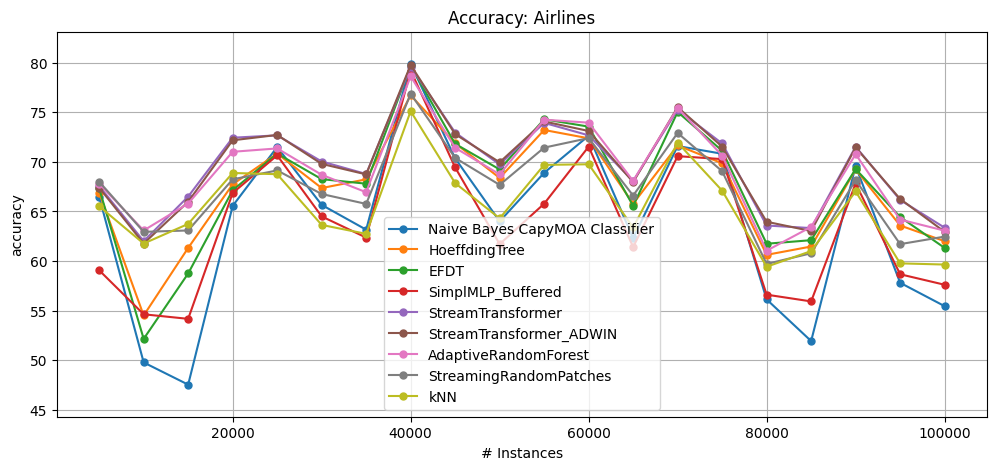


 Windowed Metrics for Airlines:

--- NaiveBayes Windowed Data ---


instances  accuracy     kappa    kappa_t   kappa_m   f1_score  f1_score_0  \
0      5000.0     66.48  1.169106  18.877057 -2.319902  51.744092   79.551000   
1     10000.0     49.76 -0.558516 -11.942959 -0.560448  46.751119   66.245633   
2     15000.0     47.52 -0.413056 -23.482353 -9.974853  46.159027   64.279880   
3     20000.0     65.56  0.097814   8.744038  6.969206  51.390313   79.167675   
4     25000.0     71.50 -0.159806  24.403183 -0.281492  41.690962   83.381924   
5     30000.0     65.66 -0.006756  16.488327 -0.116618  49.755592   79.260780   
6     35000.0     63.16  0.096996  10.058594  0.054259  56.513062   77.409860   
7     40000.0     79.90  0.237524  34.655397 -0.299401  53.163587   88.819668   
8     45000.0     70.36 -0.079956  20.578778 -0.135135  41.300775   82.601550   
9     50000.0     64.00  0.141932  12.875121  0.110988  62.161955   78.038067   
10    55000.0     68.90 -0.159844  16.621984 -0.257898  40.793369   81.586738   
11    60000.0     72.64  0.106057  28.339445  0.073046  63.350140   84.148320   
12    65000.0     62.30  0.066036  14.240218  0.053022  61.894914   76.765685   
13    70000.0     71.60 -0.039988  23.326134 -0.070472  41.724942   83.449883   
14    75000.0     70.82  0.000000  27.268195  0.000000        NaN   82.917691   
15    80000.0     56.12  0.051113   4.898136  0.045558  60.971388   71.886212   
16    85000.0     51.92  0.000000  -6.607539  0.000000        NaN   68.351764   
17    90000.0     69.58  0.000000  21.597938  0.000000        NaN   82.061564   
18    95000.0     57.80  0.000000   4.954955  0.000000        NaN   73.257288   
19   100000.0     55.44  0.000000   2.792321  0.000000        NaN   71.332990   

    f1_score_1  precision  precision_0  precision_1     recall    recall_0  \
0     7.095344  53.106452    67.425026    38.787879  50.449881   96.994942   
1     1.798280  44.116059    49.898785    38.333333  49.720960   98.521183   
2     1.130369  43.026375    47.591211    38.461538  49.783662   98.993711   
3     0.692042  52.818455    65.636911    40.000000  50.037367   99.725693   
4          NaN  35.778623    71.557246     0.000000  49.944118   99.888237   
5     0.232423  49.516086    65.698839    33.333333  49.997426   99.878234   
6     0.216685  64.912281    63.157895    66.666667  50.038422   99.968324   
7     0.593472  56.658652    79.983971    33.333333  50.074663   99.849925   
8          NaN  35.194078    70.388155     0.000000  49.971591   99.943182   
9     0.221729  81.992797    63.985594   100.000000  50.055494  100.000000   
10         NaN  34.477582    68.955164     0.000000  49.942012   99.884024   
11    0.145985  86.317263    72.634527   100.000000  50.036523  100.000000   
12    0.105988  81.146229    62.292458   100.000000  50.026511  100.000000   
13         NaN  35.807161    71.614323     0.000000  49.986037   99.972075   
14         NaN        NaN    70.820000          NaN  50.000000  100.000000   
15    0.091075  78.055611    56.111222   100.000000  50.022779  100.000000   
16         NaN        NaN    51.920000          NaN  50.000000  100.000000   
17         NaN        NaN    69.580000          NaN  50.000000  100.000000   
18         NaN        NaN    57.800000          NaN  50.000000  100.000000   
19         NaN        NaN    55.440000          NaN  50.000000  100.000000   

    recall_1  
0   3.904820  
1   0.920737  
2   0.573614  
3   0.349040  
4   0.000000  
5   0.116618  
6   0.108519  
7   0.299401  
8   0.000000  
9   0.110988  
10  0.000000  
11  0.073046  
12  0.053022  
13  0.000000  
14  0.000000  
15  0.045558  
16  0.000000  
17  0.000000  
18  0.000000  
19  0.000000


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     66.90   2.069337  19.893514  -1.037851  53.309410   
1     10000.0     54.50   8.966237  -1.381462   8.927142  55.088057   
2     15000.0     61.32  23.519525   8.988235  18.943839  62.301746   
3     20000.0     67.74  22.129479  14.520403  12.857915  61.603541   
4     25000.0     70.84   5.781013  22.652520  -2.603800  54.995160   
5     30000.0     67.36  12.718031  20.622568   4.839650  59.050532   
6     35000.0     68.24  25.010365  22.460937  13.836137  63.613832   
7     40000.0     76.72  11.306555  24.317295 -16.167665  56.259532   
8     45000.0     71.88  14.136775  24.651661   5.000000  60.431347   
9     50000.0     68.38  21.539614  23.475315  12.264151  62.883220   
10    55000.0     73.22  27.745103  28.203753  13.668601  65.413110   
11    60000.0     72.38   7.499048  27.658460  -0.876552  56.530286   
12    65000.0     65.78  17.399977  22.156506   9.278897  60.696814   
13    70000.0     71.66  20.876180  23.488121   0.140944  61.098190   
14    75000.0     69.86   8.419521  24.875374  -3.289925  55.804142   
15    80000.0     60.62  15.046261  14.651062  10.296128  58.904353   
16    85000.0     61.46  21.473811  14.545455  19.841930  62.081628   
17    90000.0     69.24  17.681341  20.721649  -1.117686  59.509386   
18    95000.0     63.58  19.820285  17.972973  13.696682  61.396798   
19   100000.0     62.00  19.226259  17.102967  14.721724  60.936725   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.849020    7.386682  56.087487    67.580379    44.594595  50.793548   
1    63.074176   40.739776  55.708315    53.101940    58.314691  54.481459   
2    64.900181   56.926503  62.688000    57.216000    68.160000  61.920223   
3    77.450021   43.343871  63.118919    71.539256    54.698582  60.159221   
4    82.404055   14.935823  58.108140    72.530274    43.686007  52.198757   
5    79.055441   26.086957  63.377995    68.338141    58.417850  55.276258   
6    77.671541   45.013850  66.018304    69.835651    62.200957  61.378353   
7    86.273585   23.421053  57.989142    81.615350    34.362934  54.630109   
8    82.714532   24.651661  66.247016    72.908539    59.585492  55.554361   
9    78.735709   38.362573  66.782102    69.081898    64.482307  59.414475   
10   82.503593   42.948445  69.205865    75.095147    63.316583  62.014471   
11   83.474931   15.946439  60.807352    73.804486    47.810219  52.815360   
12   76.749558   35.213934  64.057364    66.525324    61.589404  57.671287   
13   81.647455   37.823607  63.125772    76.135266    50.116279  59.196804   
14   81.378969   20.975354  58.492342    72.341828    44.642857  53.352174   
15   71.039859   38.487973  60.849151    60.465699    61.232604  57.080019   
16   69.388403   47.989204  63.687518    59.042985    68.332052  60.554732   
17   79.741834   36.129568  61.318815    73.595915    49.041714  57.803683   
18   73.443197   42.061724  63.731021    63.473658    63.988383  59.227521   
19   71.342383   43.620178  62.830981    61.301192    64.360771  59.153344   

     recall_0   recall_1  
0   97.560250   4.026846  
1   77.657874  31.305044  
2   74.968553  48.871893  
3   84.425480  35.892961  
4   95.389774   9.007741  
5   93.759513  16.793003  
6   87.488122  35.268584  
7   91.495748  17.764471  
8   95.568182  15.540541  
9   91.525954  27.302997  
10  91.533778  32.495164  
11  96.061691   9.569028  
12  90.687219  24.655355  
13  88.020106  30.373502  
14  92.996329  13.708019  
15  86.096257  28.063781  
16  84.129430  36.980033  
17  87.007761  28.599606  
18  87.128028  31.327014  
19  85.317460  32.989228


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     67.32   4.499154  20.909971   0.244200  55.400670   
1     10000.0     52.14   4.236270  -6.639929   4.203363  52.623775   
2     15000.0     58.74  18.965078   2.917647  13.537301  60.564088   
3     20000.0     67.14  20.681174  12.930578  11.237169  60.845911   
4     25000.0     70.84   6.666090  22.652520  -2.603800  55.379055   
5     30000.0     68.26  16.622885  22.811284   7.463557  60.740875   
6     35000.0     67.80  23.016086  21.386719  12.642431  62.907384   
7     40000.0     79.70   0.662926  34.005202  -1.297405  52.572022   
8     45000.0     71.82  15.283383  24.490890   4.797297  60.457267   
9     50000.0     69.24  24.479310  25.556631  14.650388  64.131790   
10    55000.0     74.30  30.259043  31.099196  17.150226  66.971902   
11    60000.0     73.56  11.208783  30.749083   3.433163  59.771625   
12    65000.0     65.56  17.524122  21.656051   8.695652  60.426038   
13    70000.0     75.04  27.928977  32.613391  12.050740  65.500529   
14    75000.0     71.12   6.800155  28.015952   1.028101  57.172904   
15    80000.0     61.74  17.575221  17.078457  12.847380  60.294333   
16    85000.0     62.10  23.021152  15.964523  21.173045  62.396322   
17    90000.0     69.28  11.239834  20.824742  -0.986193  57.250615   
18    95000.0     64.44  21.772706  19.909910  15.734597  62.467466   
19   100000.0     61.32  17.005397  15.619546  13.195691  60.398201   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.955839   11.580087  59.609775    68.023377    51.196172  51.746780   
1    62.778037   32.987959  53.140326    51.387828    54.892824  52.117169   
2    64.920932   49.915028  61.478163    54.605263    68.351064  59.676796   
3    77.030617   42.290130  62.260327    71.151860    53.368794  59.494332   
4    82.331556   16.590389  58.518354    72.694201    44.342508  52.559431   
5    79.349382   31.447084  64.981061    69.295455    60.666667  57.020160   
6    77.676095   42.252511  65.701629    69.075216    62.328042  60.341117   
7    88.678193    1.932367  55.165608    80.028186    30.303030  50.211358   
8    82.542436   26.956973  65.549582    73.192705    57.906459  56.099125   
9    79.097581   41.786525  67.833104    69.951923    65.714286  60.813501   
10   83.270407   44.588185  71.442408    75.567108    67.317708  63.027931   
11   84.197944   19.094247  66.625092    74.382260    58.867925  54.196626   
12   76.385080   36.410635  63.317179    66.658688    59.975669  57.787395   
13   84.118096   41.736695  69.549758    77.273790    61.825726  61.896856   
14   82.652571   13.842482  62.688805    71.921388    53.456221  52.549175   
15   71.755500   40.718934  62.451355    61.239919    63.662791  58.281339   
16   68.898736   51.497313  63.477839    60.022877    66.932801  61.351042   
17   80.664653   25.291829  60.178125    71.758119    48.598131  54.594723   
18   74.028630   43.627140  64.977492    64.054601    65.900383  60.144148   
19   71.692037   38.952020  62.979247    60.320197    65.638298  58.020381   

     recall_0   recall_1  
0   96.965189   6.528371  
1   80.655476  23.578863  
2   80.041929  39.311663  
3   83.968302  35.020361  
4   94.914781  10.204082  
5   92.815830  21.224490  
6   88.723472  31.958763  
7   99.424712   0.998004  
8   94.630682  17.567568  
9   90.994371  30.632630  
10  92.722528  33.333333  
11  96.998072  11.395179  
12  89.434811  26.139979  
13  92.292656  31.501057  
14  97.147698   7.950651  
15  86.631016  29.931663  
16  80.855162  41.846922  
17  92.095430  17.094017  
18  87.681661  32.606635  
19  88.347763  27.692998


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     59.06   5.790632   0.919652 -24.969475  52.898032   
1     10000.0     54.62   9.245257  -1.114082   9.167334  54.635075   
2     15000.0     54.16   7.717209  -7.858824   3.939648  53.876885   
3     20000.0     66.86  23.112988  12.188659  10.480821  61.700359   
4     25000.0     70.66   0.800252  22.175066  -3.237157  51.260720   
5     30000.0     64.50   3.793829  13.667315  -3.498542  53.036748   
6     35000.0     62.36   6.067707   8.105469  -2.116115  54.096168   
7     40000.0     79.22   1.323162  32.444733  -3.692615  52.234979   
8     45000.0     69.44   1.326666  18.113612  -3.243243  51.793785   
9     50000.0     61.70   4.700082   7.308809  -6.270810  52.877148   
10    55000.0     65.78   6.946987   8.257373 -10.315925  53.957127   
11    60000.0     71.54   1.891299  25.458355  -3.944485  52.270195   
12    65000.0     61.40   3.450567  12.192903  -2.332980  52.764782   
13    70000.0     70.58   8.640395  20.572354  -3.664553  55.905978   
14    75000.0     70.28   0.339543  25.922233  -1.850583  50.884231   
15    80000.0     56.60   7.748215   5.938448   1.138952  54.226261   
16    85000.0     55.92  11.546533   2.261641   8.319468  55.779994   
17    90000.0     67.82   3.460494  17.061856  -5.785667  52.737197   
18    95000.0     58.66   7.605246   6.891892   2.037915  54.827127   
19   100000.0     57.60  10.683229   7.504363   4.847397  55.792642   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    69.945676   35.810599  52.941094    69.043478    36.838710  52.855040   
1    52.935076   56.188453  54.647256    55.023717    54.270794  54.622899   
2    49.403974   58.098720  53.912287    52.167832    55.656743  53.841529   
3    75.933188   46.805778  62.375576    72.530522    52.220630  61.039605   
4    82.628774    5.659164  52.268712    71.701603    32.835821  50.290871   
5    77.448863   16.627525  54.608386    66.463149    42.753623  51.553044   
6    75.059634   23.308883  55.666730    64.524949    46.808511  52.611797   
7    88.342870    4.415823  54.168512    80.101729    28.235294  50.434723   
8    81.704981    7.281553  53.163434    70.612583    35.714286  50.492936   
9    74.312542   24.754420  53.732495    65.069298    42.395693  52.048606   
10   77.753218   25.898657  54.965765    70.485620    39.445910  52.984840   
11   83.161756    8.134280  53.952282    72.904564    35.000000  50.689823   
12   74.784426   17.732310  54.128519    63.039648    45.217391  51.468073   
13   81.926527   20.956475  58.631882    73.146117    44.117647  53.422279   
14   82.443289    3.255208  51.669476    70.871420    32.467532  50.122495   
15   66.697360   37.715270  54.762695    58.555645    50.969744  53.700234   
16   58.509036   52.986348  55.797389    57.216495    54.378284  55.762609   
17   80.152954   15.002641  54.187577    70.203111    38.172043  51.362434   
18   70.784452   29.333333  56.235386    59.832736    52.638037  53.487676   
19   67.050047   40.549635  56.469057    58.902239    54.035874  55.132241   

     recall_0   recall_1  
0   70.871764  34.838316  
1   50.999201  58.246597  
2   46.918239  60.764818  
3   79.670832  42.408377  
4   97.485331   3.096411  
5   92.785388  10.320700  
6   89.705417  15.518177  
7   98.474237   2.395210  
8   96.931818   4.054054  
9   86.616635  17.480577  
10  86.691795  19.277885  
11  96.777747   4.601899  
12  91.907514  11.028632  
13  93.102485  13.742072  
14  98.531488   1.713502  
15  77.468806  29.931663  
16  59.861325  51.663894  
17  93.388905   9.335963  
18  86.643599  20.331754  
19  77.813853  32.450628


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     67.56  10.565155  21.490803   0.976801  57.265651   
1     10000.0     62.00  23.994941  15.329768  23.939151  62.038459   
2     15000.0     66.50  33.068966  21.176471  29.798826  66.573220   
3     20000.0     72.44  34.257820  26.974033  25.553755  67.709877   
4     25000.0     72.68  15.811905  27.533156   3.870514  60.405561   
5     30000.0     70.04  25.303548  27.140078  12.653061  63.922516   
6     35000.0     68.78  26.911236  23.779297  15.301139  64.402098   
7     40000.0     79.60   2.851221  33.680104  -1.796407  54.887866   
8     45000.0     72.96  21.465482  27.545552   8.648649  62.975642   
9     50000.0     69.74  27.486388  26.766699  16.037736  64.950611   
10    55000.0     73.94  30.513278  30.134048  15.989684  66.610524   
11    60000.0     72.68   4.419994  28.444212   0.219138  56.398789   
12    65000.0     68.06  28.055622  27.343039  15.323436  64.469926   
13    70000.0     75.28  31.919986  33.261339  12.896406  66.704465   
14    75000.0     71.86   9.986565  29.860419   3.564085  59.438123   
15    80000.0     63.58  24.007845  21.066320  17.038724  62.337802   
16    85000.0     63.32  26.111121  18.669623  23.710483  63.204181   
17    90000.0     71.54  16.999640  26.649485   6.443130  61.260946   
18    95000.0     66.16  26.624156  23.783784  19.810427  64.398161   
19   100000.0     63.36  23.559650  20.069808  17.773788  62.300807   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.348103   24.417521  60.514427    69.352326    51.676529  54.347930   
1    63.531670   60.334029  62.080295    61.115214    63.045375  61.996680   
2    66.099980   66.890690  66.559829    63.888889    69.230769  66.586617   
3    80.520215   52.904990  69.605808    75.085684    64.125932  65.914491   
4    83.160750   27.648305  65.149267    74.409883    55.888651  56.305775   
5    79.646739   43.257576  66.828055    71.926380    61.729730  61.259102   
6    77.836149   47.210010  66.596173    70.535255    62.657092  62.347983   
7    88.562458    5.730129  59.507114    80.264228    38.750000  50.934100   
8    82.946519   34.749035  67.701231    74.591652    60.810811  58.866708   
9    78.924641   46.366537  67.671797    71.163024    64.180569  62.439812   
10   82.843976   45.821206  70.200136    75.880367    64.519906  63.370156   
11   83.925630    9.054594  62.198387    73.268954    51.127820  51.588494   
12   76.358253   50.785824  65.732504    70.832189    60.632818  63.254937   
13   83.872651   47.089041  69.347410    78.716630    59.978190  64.255578   
14   83.029791   17.671153  66.431579    72.463158    60.400000  53.776867   
15   70.414297   52.639792  63.009950    64.686567    61.333333  61.679843   
16   67.026250   58.675079  63.428691    62.845583    64.011799  62.981254   
17   82.179086   29.379653  66.366527    72.814026    59.919028  56.884795   
18   74.495026   49.732620  66.319530    65.998932    66.640127  62.584988   
19   70.556091   51.508735  63.198691    63.623188    62.774194  61.428079   

     recall_0   recall_1  
0   92.710503  15.985357  
1   66.147082  57.846277  
2   68.469602  64.703633  
3   86.802804  45.026178  
4   94.244202  18.367347  
5   89.223744  33.294461  
6   86.822933  37.873033  
7   98.774387   3.093812  
8   93.409091  24.324324  
9   88.586617  36.293008  
10  91.214845  35.525467  
11  98.209860   4.967129  
12  82.819525  43.690350  
13  89.751466  38.759690  
14  97.204180  10.349554  
15  77.254902  46.104784  
16  71.802773  54.159734  
17  94.308709  19.460881  
18  85.501730  39.668246  
19  79.184704  43.671454


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     67.40   8.667161  21.103582   0.488400  56.563565   
1     10000.0     61.76  23.511874  14.795009  23.458767  61.860025   
2     15000.0     65.98  32.114887  19.952941  28.709137  66.130989   
3     20000.0     72.18  32.521273  26.285109  24.851432  67.138185   
4     25000.0     72.72  14.617893  27.639257   4.011260  60.246290   
5     30000.0     69.80  24.254509  26.556420  11.953353  63.513581   
6     35000.0     68.74  27.122484  23.681641  15.192621  64.409530   
7     40000.0     79.78   2.427669  34.265280  -0.898204  55.491605   
8     45000.0     72.80  20.091753  27.116827   8.108108  62.565818   
9     50000.0     69.96  28.061716  27.299129  16.648169  65.241814   
10    55000.0     74.08  30.619722  30.509383  16.441006  66.768394   
11    60000.0     73.12   5.780400  29.596647   1.826150  58.468544   
12    65000.0     67.96  27.063741  27.115560  15.058324  64.156378   
13    70000.0     75.52  31.537391  33.909287  13.742072  66.760129   
14    75000.0     71.54   8.962958  29.062812   2.467443  58.522599   
15    80000.0     63.96  24.458444  21.889900  17.904328  62.703202   
16    85000.0     63.02  25.441047  18.004435  23.086522  62.915168   
17    90000.0     71.46  16.728289  26.443299   6.180145  61.105793   
18    95000.0     66.26  27.023655  24.009009  20.047393  64.501680   
19   100000.0     62.94  22.185335  19.153578  16.831239  61.849589   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.465860   20.950533  59.986798    68.909766    51.063830  53.509943   
1    64.154481   59.022718  61.965713    60.416667    63.514760  61.754696   
2    66.041126   65.918654  66.133772    63.033537    69.234007  66.128207   
3    80.640223   50.586146  69.584723    74.205943    64.963504  64.857841   
4    83.304774   25.464481  65.545750    74.123285    56.968215  55.739664   
5    79.589078   41.967717  66.566865    71.577924    61.555806  60.728109   
6    77.700100   47.743230  66.442836    70.690550    62.195122  62.496977   
7    88.692540    4.532578  61.159854    80.214445    42.105263  50.784898   
8    82.948847   32.806324  67.633198    74.236984    61.029412  58.204853   
9    79.063284   46.850672  67.988203    71.327968    64.648438  62.708692   
10   82.978723   45.683152  70.557900    75.846339    65.269461  63.365193   
11   84.195673   10.160428  66.654279    73.466037    59.842520  52.073463   
12   76.613139   49.142857  65.734862    70.235546    61.234177  62.651924   
13   84.161491   46.126761  69.924190    78.418134    61.430246  63.870018   
14   82.836811   16.734933  64.747368    72.294737    57.200000  53.389744   
15   71.140295   52.023429  63.585406    64.582728    62.588085  61.845143   
16   67.093789   57.795024  63.195848    62.355276    64.036419  62.636970   
17   82.133467   29.110780  66.156192    72.759539    59.552846  56.771804   
18   74.427770   50.426095  66.291684    66.226059    66.357309  62.805802   
19   70.878516   49.051416  63.051594    62.795879    63.307310  60.692556   

     recall_0   recall_1  
0   93.841119  13.178768  
1   68.385292  55.124099  
2   69.350105  62.906310  
3   88.296251  41.419430  
4   95.082425  16.396904  
5   89.619482  31.836735  
6   86.252772  38.741183  
7   99.174587   2.395210  
8   93.977273  22.432432  
9   88.680425  36.736959  
10  91.591766  35.138620  
11  98.595428   5.551497  
12  84.264611  41.039236  
13  90.812622  36.927414  
14  96.978255   9.801234  
15  79.180036  44.510251  
16  72.611710  52.662230  
17  94.279966  19.263642  
18  84.948097  40.663507  
19  81.349206  40.035907


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     67.80  13.461760  22.071636   1.709402  58.299787   
1     10000.0     63.08  26.153525  17.736185  26.100881  63.155008   
2     15000.0     65.80  31.694262  19.529412  28.331936  65.892971   
3     20000.0     71.02  33.055589  23.211447  21.717990  66.692035   
4     25000.0     71.36  10.699074  24.031830  -0.774103  57.442825   
5     30000.0     68.70  20.834691  23.881323   8.746356  61.848186   
6     35000.0     66.94  22.982706  19.287109  10.309278  62.201301   
7     40000.0     78.64   7.755452  30.559168  -6.586826  55.776968   
8     45000.0     71.42  14.708565  23.419078   3.445946  59.781203   
9     50000.0     68.74  25.409432  24.346563  13.263041  63.713533   
10    55000.0     74.26  32.406456  30.991957  17.021277  67.265813   
11    60000.0     73.96  16.847299  31.796752   4.894083  61.215961   
12    65000.0     68.08  26.097371  27.388535  15.376458  64.063366   
13    70000.0     75.44  32.392838  33.693305  13.460183  66.943547   
14    75000.0     70.64   8.875682  26.819541  -0.616861  56.790807   
15    80000.0     61.04  17.884419  15.561335  11.252847  59.440013   
16    85000.0     63.44  26.263873  18.935698  23.960067  63.353890   
17    90000.0     70.78  17.787703  24.690722   3.944773  60.514016   
18    95000.0     64.18  22.114858  19.324324  15.118483  62.077125   
19   100000.0     63.06  23.111789  19.415358  17.100539  61.985566   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.139673   29.447853  61.174578    70.094101    52.255054  55.683059   
1    65.011372   60.922947  63.234592    61.824081    64.645103  63.075624   
2    65.524194   66.071429  65.883295    63.106796    68.659794  65.902650   
3    78.862144   53.926868  67.548294    75.629547    59.467041  65.857213   
4    82.442374   22.342733  61.076996    73.454228    48.699764  54.216844   
5    78.996108   38.603374  64.818054    70.643303    58.992806  59.138544   
6    76.395830   44.844845  63.892509    69.552782    58.232236  60.597315   
7    87.777523   15.372425  59.107433    80.907173    37.307692  52.801800   
8    82.228579   27.054620  64.224503    73.125415    55.323591  55.912930   
9    78.130684   45.215563  66.035784    70.701443    61.370124  61.549064   
10   82.883362   48.125756  70.376872    76.560197    64.193548  64.418162   
11   84.114202   27.827051  66.605230    75.509310    57.701149  56.633538   
12   77.200000   46.800000  66.273905    69.531652    63.016158  61.995531   
13   83.972853   47.476476  69.610224    78.828718    60.391730  64.473646   
14   82.045010   19.517544  60.564791    72.362460    48.767123  53.459572   
15   69.332494   46.600877  60.290144    62.080632    58.499656  58.613524   
16   67.588652   58.073394  63.669453    62.614980    64.723926  63.041438   
17   81.329073   32.827586  63.901953    73.216751    54.587156  57.467232   
18   73.168539   46.135338  63.822703    64.517834    63.127572  60.424490   
19   70.069681   51.762862  62.752878    63.606943    61.898813  61.236791   

     recall_0   recall_1  
0   90.865814  20.500305  
1   68.545164  57.606085  
2   68.134172  63.671128  
3   82.383420  49.331006  
4   93.936854  14.496833  
5   89.589041  28.688047  
6   84.732341  36.462290  
7   95.922961   9.680639  
8   93.920455  17.905405  
9   87.304565  35.793563  
10  90.345028  38.491296  
11  94.932525  18.334551  
12  86.769428  37.221633  
13  89.835242  39.112051  
14  94.719006  12.200137  
15  78.502674  38.724374  
16  73.420647  52.662230  
17  91.463064  23.471400  
18  84.498270  36.350711  
19  77.994228  44.479354


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     68.00  12.277951  22.555663   2.319902  58.194388   
1     10000.0     62.94  25.882016  17.424242  25.820657  62.948852   
2     15000.0     63.08  25.863990  13.129412  22.632020  62.942887   
3     20000.0     68.24  29.316782  15.845257  14.208536  64.659770   
4     25000.0     69.14   8.575359  18.143236  -8.585503  55.074573   
5     30000.0     66.76  18.201657  19.163424   3.090379  59.797893   
6     35000.0     65.76  22.279788  16.406250   7.107976  61.429329   
7     40000.0     76.88   8.403198  24.837451 -15.369261  54.947499   
8     45000.0     70.40  15.629903  20.685959   0.000000  59.066729   
9     50000.0     67.68  23.683445  21.781220  10.321865  62.558564   
10    55000.0     71.44  27.835387  23.431635   7.930368  64.289616   
11    60000.0     72.40  14.771527  27.710843  -0.803506  58.926252   
12    65000.0     66.60  23.298851  24.021838  11.452810  62.366001   
13    70000.0     72.92  26.574627  26.889849   4.580691  63.737045   
14    75000.0     69.06   7.394726  22.881356  -6.031528  54.812808   
15    80000.0     59.70  16.227641  12.657130   8.200456  58.279516   
16    85000.0     60.78  21.377646  13.037694  18.427621  60.691427   
17    90000.0     68.16  15.534643  17.938144  -4.667982  58.264312   
18    95000.0     61.70  18.750859  13.738739   9.241706  59.630659   
19   100000.0     62.46  22.737768  18.106457  15.754039  61.511313   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    79.550102   26.470588  61.680083    69.728882    53.631285  55.081590   
1    62.314419   63.545151  62.956338    63.436853    62.475822  62.941368   
2    60.454156   65.378845  62.978140    61.804643    64.151638  62.907673   
3    75.910194   53.403756  64.722164    75.566294    53.878034  64.597497   
4    80.618013   24.325650  56.680426    73.231401    40.129450  53.557207   
5    77.157779   38.986784  61.479806    70.333250    52.626363  58.205555   
6    74.779022   46.699875  62.341307    69.898100    54.784514  60.543649   
7    86.501635   19.498607  56.689698    81.121332    32.258065  53.309190   
8    81.141692   31.226766  61.783734    73.567468    50.000000  56.578624   
9    77.136389   44.884038  64.334682    70.439276    58.230088  60.877879   
10   80.497132   46.676624  65.773926    76.090886    55.456965  62.870820   
11   82.916564   28.199792  62.157311    75.309197    49.005425  56.014508   
12   75.894919   45.638021  64.018248    68.930257    59.106239  60.796894   
13   82.179521   43.630308  65.512948    77.719691    53.306205  62.054882   
14   80.741939   21.352313  56.766798    72.195013    41.338583  52.988859   
15   66.864003   48.583822  58.638902    62.057387    55.220418  57.924508   
16   62.626263   58.741847  60.703079    61.976613    59.429544  60.679780   
17   78.913907   35.020408  59.677405    73.176124    46.178687  56.916591   
18   69.636911   48.145139  60.213046    64.266901    56.159191  59.059430   
19   68.299274   53.983820  61.846111    64.210861    59.481361  61.180120   

     recall_0   recall_1  
0   92.591491  17.571690  
1   61.231015  64.651721  
2   59.161426  66.653920  
3   76.257239  52.937755  
4   89.661917  17.452498  
5   85.449011  30.962099  
6   80.392778  40.694520  
7   92.646323  13.972056  
8   90.454545  22.702703  
9   85.240775  36.514983  
10  85.445057  40.296583  
11  92.233544  19.795471  
12  84.425177  37.168611  
13  87.182351  36.927414  
14  91.584298  14.393420  
15  72.477718  43.371298  
16  63.289676  58.069884  
17  85.628054  28.205128  
18  75.986159  42.132701  
19  72.943723  49.416517


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     65.52  17.694735  16.553727  -5.250305  58.961840   
1     10000.0     61.76  23.519902  14.795009  23.458767  61.759955   
2     15000.0     63.74  27.204074  14.682353  24.015088  63.611147   
3     20000.0     68.88  29.386108  17.541070  15.937331  64.738753   
4     25000.0     68.76  16.905647  17.135279  -9.922590  58.639299   
5     30000.0     63.64  16.822453  11.575875  -6.005831  58.456382   
6     35000.0     62.74  18.842682   9.033203  -1.085187  59.435195   
7     40000.0     75.12   8.711881  19.115735 -24.151697  54.638180   
8     45000.0     67.86  17.504117  13.879957  -8.581081  58.903793   
9     50000.0     64.30  20.847542  13.601162   0.943396  60.458914   
10    55000.0     69.70  26.362884  18.766756   2.321083  63.263124   
11    60000.0     69.76  17.783352  20.796228 -10.445581  59.066333   
12    65000.0     63.38  19.975427  16.696997   2.916225  60.050882   
13    70000.0     71.94  28.018887  24.244060   1.127555  64.087293   
14    75000.0     67.10  13.816228  17.996012 -12.748458  57.074766   
15    80000.0     59.42  17.092170  12.050282   7.562642  58.557793   
16    85000.0     61.00  21.843938  13.525499  18.885191  60.922985   
17    90000.0     67.02  17.659842  15.000000  -8.415516  58.938196   
18    95000.0     59.76  16.573510   9.369369   4.644550  58.309491   
19   100000.0     59.64  18.074901  11.954625   9.425494  59.040730   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    75.504405   41.796084  59.523799    72.259995    46.787604  58.410392   
1    61.805833   61.714057  61.759966    61.781150    61.738782  61.759944   
2    61.252404   65.927457  63.643113    62.467306    64.818921  63.579214   
3    76.879643   52.415902  65.130961    75.007248    55.254674  64.351239   
4    79.217669   37.117552  59.491889    75.615951    43.367827  57.810801   
5    73.209549   43.434972  58.757767    70.951157    46.564376  58.158073   
6    71.048951   47.741935  59.578462    69.737645    49.419280  59.292616   
7    85.183421   22.443890  55.605009    81.309686    29.900332  53.704397   
8    78.204259   38.827560  59.644315    74.824812    44.463819  58.181434   
9    72.851711   47.883212  60.722329    70.920936    50.523722  60.197776   
10   78.706957   47.487002  63.863424    76.377523    51.349325  62.674003   
11   80.084299   37.209302  59.933339    76.748296    43.118383  58.224054   
12   71.730740   48.027250  60.377566    69.075230    51.679902  59.727713   
13   80.924541   46.956522  64.753927    78.855326    50.652529  63.434246   
14   77.952017   35.210713  57.786281    74.183673    41.388889  56.380558   
15   64.633083   52.404410  58.623414    63.233288    54.013540  58.492320   
16   62.686567   59.153749  60.929714    62.281369    59.578059  60.916257   
17   77.252035   40.058161  59.533652    74.270557    44.796748  58.354532   
18   66.218939   50.247280  58.425970    64.318330    52.533609  58.193476   
19   64.028520   54.031891  59.070309    63.284003    54.856614  59.011181   

     recall_0   recall_1  
0   79.053853  37.766931  
1   61.830536  61.689351  
2   60.083857  67.074570  
3   78.847912  49.854567  
4   83.179659  32.441942  
5   75.616438  40.699708  
6   72.410516  46.174715  
7   89.444722  17.964072  
8   81.903409  34.459459  
9   74.890557  45.504994  
10  81.182952  44.165055  
11  83.723492  32.724617  
12  74.598587  44.856840  
13  83.105278  43.763214  
14  82.123694  30.637423  
15  66.096257  50.888383  
16  63.097072  58.735441  
17  80.482897  36.226167  
18  68.235294  48.151659  
19  64.790765  53.231598


==================== DATASET: LED_a ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - CUSUM           | Drifts: 2
 - HDDMWeighted    | Drifts: 13
 - RDDM            | Drifts: 4
 - STEPD           | Drifts: 24

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: LED_a


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                LED_a         73.64  70.7109      0.64
HoeffdingTree             LED_a         72.87  69.8598      1.14
EFDT                      LED_a         71.73  68.5844      1.84
Simple_MLP                LED_a         71.37  68.1910     91.69
StreamTransformer         LED_a         72.73  69.7032    362.31
StreamTransformer_ADWIN   LED_a         72.82  69.8000    362.08
ARF                       LED_a         73.34  70.3791     21.43
SRP                       LED_a         73.49  70.5433     29.17
KNN                       LED_a         56.00  51.1139     55.74

Results for LED_a saved to thesis_results.csv


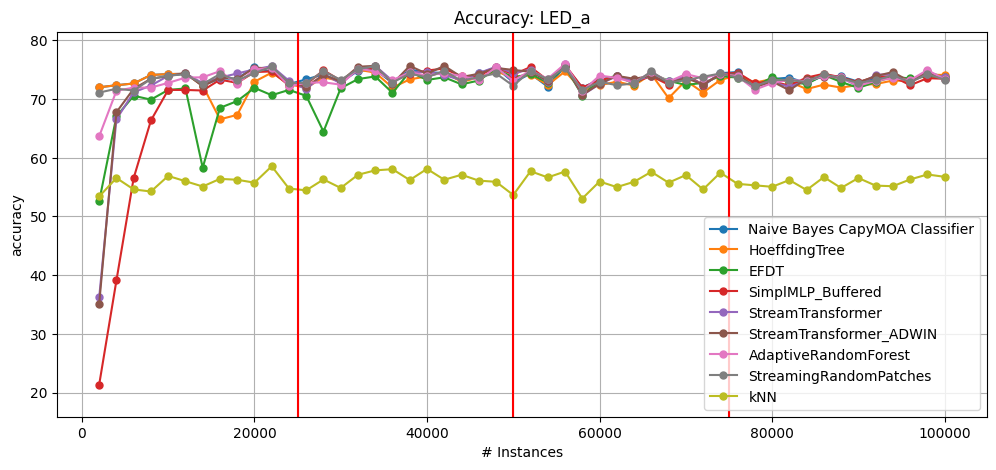


 Windowed Metrics for LED_a:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     72.00  68.853668  68.940654  68.018275  71.845853   
1      4000.0     72.35  69.265843  69.345898  69.192201  72.446337   
2      6000.0     72.65  69.594363  69.779006  68.973341  72.833162   
3      8000.0     74.10  71.207810  71.786492  70.717920  74.367684   
4     10000.0     74.25  71.382410  71.325167  71.132287  74.206943   
5     12000.0     74.30  71.435693  71.649200  70.878187  74.238091   
6     14000.0     72.30  69.218272  69.136490  68.928772  72.467106   
7     16000.0     73.50  70.550263  70.539188  70.374511  73.715579   
8     18000.0     73.45  70.492664  70.711528  70.285395  73.319652   
9     20000.0     75.45  72.719077  72.554500  72.133939  75.581522   
10    22000.0     74.60  71.772626  72.133845  71.556551  74.667006   
11    24000.0     72.55  69.490779  69.550749  69.139966  72.640073   
12    26000.0     73.35  70.379748  70.421754  69.750284  73.212272   
13    28000.0     74.20  71.319662  71.554576  71.173184  74.119679   
14    30000.0     72.90  69.860298  69.669838  69.256948  73.036871   
15    32000.0     74.80  71.996274  71.669477  71.859296  74.694691   
16    34000.0     75.00  72.210751  71.988796  71.687429  75.153559   
17    36000.0     72.75  69.714996  69.739034  69.654788  72.602234   
18    38000.0     74.95  72.161254  71.662896  71.948488  74.949372   
19    40000.0     74.55  71.717893  71.580123  71.643454  74.575930   
20    42000.0     74.45  71.607160  71.721085  71.064553  74.497872   
21    44000.0     73.10  70.095203  69.910515  69.570136  72.990632   
22    46000.0     74.40  71.545320  71.316527  71.300448  74.448221   
23    48000.0     75.35  72.581865  72.717211  72.272216  75.367302   
24    50000.0     72.85  69.829956  69.511510  69.442881  72.723981   
25    52000.0     74.30  71.441493  71.204482  70.960452  74.360688   
26    54000.0     72.10  69.000689  68.669287  68.259386  72.298494   
27    56000.0     75.60  72.872183  72.568859  72.460497  75.682862   
28    58000.0     71.95  68.822915  68.729097  68.447694  72.134191   
29    60000.0     73.30  70.312841  70.033670  70.250696  72.998701   
30    62000.0     73.85  70.923655  70.733072  70.617978  73.697194   
31    64000.0     73.10  70.104825  69.893677  70.111111  73.097655   
32    66000.0     74.25  71.377782  71.780822  71.099888  74.143190   
33    68000.0     72.75  69.697787  69.955899  69.501959  72.386673   
34    70000.0     74.10  71.205161  71.365395  71.045277  73.776432   
35    72000.0     72.25  69.164157  69.080780  68.924972  72.303339   
36    74000.0     74.40  71.537964  72.098093  71.106095  74.257362   
37    76000.0     74.60  71.750533  72.041827  71.234428  74.524052   
38    78000.0     72.00  68.884334  68.906163  68.836950  72.307787   
39    80000.0     73.40  70.443180  70.444444  69.994360  73.453805   
40    82000.0     73.65  70.717456  70.835639  70.175439  73.599131   
41    84000.0     72.70  69.645629  69.700333  69.274057  72.693208   
42    86000.0     74.00  71.093301  70.917226  70.671179  73.740479   
43    88000.0     73.85  70.932575  70.847269  70.551802  73.652960   
44    90000.0     72.95  69.931306  70.093975  69.606742  72.822040   
45    92000.0     73.45  70.494828  70.101351  70.134983  73.325110   
46    94000.0     73.90  70.999807  70.870536  70.772676  74.005291   
47    96000.0     73.10  70.072313  69.707207  69.673055  73.325101   
48    98000.0     74.50  71.657723  72.146368  71.170153  74.307152   
49   100000.0     73.80  70.872731  70.758929  70.428894  73.982139   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    74.823529   79.668050   80.239521   61.956522  ...  76.811594  80.000000   
1    73.372781   75.714286   81.651376   65.816327  ...  75.151515  77.184466   
2    72.832370   75.132275   79.000000   67.005076  ...  78.750000  73.195876   
3    74.863388   84.044944   82.025316   66.190476  ...  7


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     72.00  68.853668  68.940654  68.018275  71.845853   
1      4000.0     72.35  69.265843  69.345898  69.192201  72.446337   
2      6000.0     72.65  69.594363  69.779006  68.973341  72.833162   
3      8000.0     74.10  71.207810  71.786492  70.717920  74.367684   
4     10000.0     74.25  71.382410  71.325167  71.132287  74.206943   
5     12000.0     74.30  71.435693  71.649200  70.878187  74.238091   
6     14000.0     72.30  69.218272  69.136490  68.928772  72.467106   
7     16000.0     66.55  62.833075  62.812674  62.604807  66.632287   
8     18000.0     67.30  63.654036  63.927192  63.402350  67.257590   
9     20000.0     72.95  69.939309  69.759642  69.296254  73.109307   
10    22000.0     74.50  71.663432  72.024136  71.444569  74.548211   
11    24000.0     72.55  69.489864  69.550749  69.139966  72.647843   
12    26000.0     71.90  68.769233  68.812431  68.104427  71.770618   
13    28000.0     73.70  70.763769  71.003308  70.614525  73.553396   
14    30000.0     73.05  70.029315  69.837717  69.427113  73.161500   
15    32000.0     75.00  72.214489  71.894323  72.082635  74.903155   
16    34000.0     74.50  71.652981  71.428571  71.121178  74.825120   
17    36000.0     71.95  68.825886  68.850639  68.763920  71.954859   
18    38000.0     73.35  70.384537  69.852941  70.156775  73.411817   
19    40000.0     73.85  70.941918  70.798437  70.863510  74.003596   
20    42000.0     74.65  71.830869  71.942446  71.291053  74.739145   
21    44000.0     72.90  69.871523  69.686801  69.343891  72.695111   
22    46000.0     73.70  70.769569  70.532213  70.515695  73.757729   
23    48000.0     74.70  71.868728  71.997786  71.541057  74.720089   
24    50000.0     73.70  70.772371  70.466030  70.399550  73.538932   
25    52000.0     74.15  71.272727  71.036415  70.790960  74.100987   
26    54000.0     72.40  69.332413  69.006176  68.600683  72.478006   
27    56000.0     74.70  71.872622  71.557055  71.444695  74.771317   
28    58000.0     71.50  68.324992  68.227425  67.941507  71.791848   
29    60000.0     72.35  69.256197  68.967452  69.192201  72.020114   
30    62000.0     72.95  69.923541  69.725797  69.606742  72.873766   
31    64000.0     72.30  69.215877  68.998321  69.222222  72.228876   
32    66000.0     74.25  71.381830  71.780822  71.099888  74.106747   
33    68000.0     70.15  66.813135  67.089305  66.592054  69.848851   
34    70000.0     73.15  70.156454  70.315091  69.983231  73.061457   
35    72000.0     71.10  67.877066  67.799443  67.637178  71.289341   
36    74000.0     73.25  70.263851  70.844687  69.808126  73.436041   
37    76000.0     74.05  71.138487  71.436434  70.611552  74.397939   
38    78000.0     72.80  69.770909  69.794559  69.727323  73.201031   
39    80000.0     73.40  70.436643  70.444444  69.994360  73.564333   
40    82000.0     72.95  69.944895  70.060874  69.383135  73.123487   
41    84000.0     71.70  68.529295  68.590455  68.148565  71.919920   
42    86000.0     72.45  69.367906  69.183445  68.922730  72.595491   
43    88000.0     71.95  68.836649  68.729097  68.412162  72.411495   
44    90000.0     72.40  69.328034  69.485904  68.988764  72.619031   
45    92000.0     72.55  69.489220  69.087838  69.122610  72.730784   
46    94000.0     73.15  70.160384  70.033482  69.932811  73.371213   
47    96000.0     73.05  70.013950  69.650901  69.616685  73.624448   
48    98000.0     74.15  71.271330  71.764063  70.774449  74.207672   
49   100000.0     74.10  71.196819  71.093750  70.767494  74.464715   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    74.823529   79.668050   80.239521   61.956522  ...  76.811594  80.000000   
1    73.372781   75.714286   81.651376   65.816327  ...  75.151515  77.184466   
2    72.832370   75.132275   79.000000   67.005076  ...  78.750000  73.195876   
3    74.863388   84.044944   82.025316   66.190476  ...  7


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     52.60  47.290082  47.420965  45.859509  52.746870   
1      4000.0     67.05  63.372641  63.470067  63.286908  67.324214   
2      6000.0     70.55  67.246853  67.458564  66.591038  71.128240   
3      8000.0     69.90  66.537979  67.211329  65.969474  70.269475   
4     10000.0     71.55  68.386729  68.318486  68.105381  71.939917   
5     12000.0     71.80  68.660407  68.891340  68.045326  72.101255   
6     14000.0     58.30  53.644133  53.537604  53.224902  59.065431   
7     16000.0     68.50  64.995323  64.980545  64.784796  68.980283   
8     18000.0     69.65  66.252064  66.519581  66.032457  69.570901   
9     20000.0     71.90  68.775445  68.585802  68.104427  72.210065   
10    22000.0     70.65  67.404290  67.800329  67.133259  71.216675   
11    24000.0     71.55  68.383136  68.441486  68.015739  71.835068   
12    26000.0     70.55  67.276087  67.314095  66.572077  70.761922   
13    28000.0     64.45  60.455589  60.804851  60.279330  64.403108   
14    30000.0     71.85  68.699138  68.494684  68.065797  72.213912   
15    32000.0     73.40  70.433069  70.095559  70.295924  73.544866   
16    34000.0     73.85  70.932252  70.700280  70.385051  74.055172   
17    36000.0     71.05  67.827837  67.851194  67.761693  71.082561   
18    38000.0     74.65  71.821655  71.323529  71.612542  74.794489   
19    40000.0     73.25  70.276820  70.128420  70.194986  73.409701   
20    42000.0     73.70  70.772298  70.890980  70.215176  74.015793   
21    44000.0     72.50  69.426720  69.239374  68.891403  72.582062   
22    46000.0     73.15  70.153484  69.915966  69.899103  73.271750   
23    48000.0     75.15  72.360904  72.495849  72.047244  75.467469   
24    50000.0     73.70  70.773361  70.466030  70.399550  73.868634   
25    52000.0     74.25  71.388340  71.148459  70.903955  74.512329   
26    54000.0     72.80  69.778777  69.455362  69.055745  73.158972   
27    56000.0     75.55  72.805361  72.512648  72.404063  75.602583   
28    58000.0     70.60  67.331410  67.224080  66.929134  71.031832   
29    60000.0     73.15  70.149859  69.865320  70.083565  72.991867   
30    62000.0     74.00  71.078904  70.900951  70.786517  73.870835   
31    64000.0     72.55  69.495153  69.278120  69.500000  72.645111   
32    66000.0     74.40  71.548095  71.945205  71.268238  74.512740   
33    68000.0     73.10  70.096608  70.341786  69.893677  72.949515   
34    70000.0     72.40  69.330530  69.485904  69.144774  72.367634   
35    72000.0     72.75  69.722264  69.637883  69.484882  73.005189   
36    74000.0     73.90  70.989548  71.553134  70.541761  73.944059   
37    76000.0     73.65  70.702455  70.996147  70.158550  73.805689   
38    78000.0     72.15  69.049168  69.072737  69.003895  72.534113   
39    80000.0     73.70  70.778890  70.777778  70.332769  73.883183   
40    82000.0     72.90  69.886664  70.005534  69.326542  73.013126   
41    84000.0     72.55  69.478406  69.533851  69.105234  72.728419   
42    86000.0     74.10  71.212338  71.029083  70.783982  73.954117   
43    88000.0     72.90  69.879660  69.788183  69.481982  72.757275   
44    90000.0     71.90  68.772157  68.933112  68.426966  71.853257   
45    92000.0     72.90  69.890378  69.481982  69.516310  73.030196   
46    94000.0     73.80  70.893190  70.758929  70.660694  73.989480   
47    96000.0     73.50  70.518770  70.157658  70.124014  73.698005   
48    98000.0     73.85  70.934506  71.436374  70.435274  73.702051   
49   100000.0     73.70  70.765613  70.647321  70.316027  74.038724   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    57.721519   63.596491   62.711864   46.112601  ...  55.072464  60.416667   
1    69.538462   71.698113   72.311213   65.060241  ...  68.484848  73.786408   
2    71.084337   68.783069   74.782609   67.906977  ...  73.750000  67.010309   
3    71.111111   79.254079   74.585635   66.516854  ...  6


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     21.35  12.327491  12.756517  10.165620        NaN   
1      4000.0     39.10  32.029050  32.483370  32.144847  42.970068   
2      6000.0     56.55  51.602277  51.988950  50.709019  58.693283   
3      8000.0     66.35  62.591919  63.344227  61.955907  66.211888   
4     10000.0     71.55  68.360440  68.318486  68.105381  71.401549   
5     12000.0     71.55  68.368900  68.615554  67.762040  71.275947   
6     14000.0     71.45  68.268479  68.189415  67.975322  71.433435   
7     16000.0     73.30  70.317742  70.316843  70.150922  73.362261   
8     18000.0     72.75  69.705139  69.939327  69.501959  72.496439   
9     20000.0     74.60  71.773175  71.604248  71.169126  74.752725   
10    22000.0     74.70  71.881281  72.243555  71.668533  74.627613   
11    24000.0     72.30  69.214800  69.273433  68.858909  72.243731   
12    26000.0     72.50  69.433848  69.478357  68.785471  72.325467   
13    28000.0     74.90  72.092335  72.326351  71.955307  74.820460   
14    30000.0     73.15  70.138481  69.949636  69.540556  73.318971   
15    32000.0     75.05  72.260880  71.950534  72.138470  74.887513   
16    34000.0     75.25  72.477393  72.268908  71.970555  75.446112   
17    36000.0     73.05  70.044447  70.072182  69.988864  72.856796   
18    38000.0     74.20  71.328499  70.814480  71.108623  74.172865   
19    40000.0     74.85  72.051394  71.915131  71.977716  74.873987   
20    42000.0     75.20  72.428284  72.551190  71.913930  75.358091   
21    44000.0     73.85  70.919176  70.749441  70.418552  73.656576   
22    46000.0     73.95  71.033332  70.812325  70.795964  74.030002   
23    48000.0     75.45  72.693725  72.827892  72.384702  75.535139   
24    50000.0     74.15  71.271968  70.971364  70.906021  74.075353   
25    52000.0     75.45  72.711117  72.492997  72.259887  75.317835   
26    54000.0     73.20  70.208146  69.904548  69.510808  73.078632   
27    56000.0     75.80  73.083941  72.793704  72.686230  75.846969   
28    58000.0     71.95  68.814319  68.729097  68.447694  72.183358   
29    60000.0     73.20  70.201148  69.921437  70.139276  72.922621   
30    62000.0     73.85  70.917042  70.733072  70.617978  73.635089   
31    64000.0     72.90  69.881769  69.669838  69.888889  72.947219   
32    66000.0     73.90  70.984767  71.397260  70.707071  73.640132   
33    68000.0     72.45  69.370979  69.625138  69.166200  72.129279   
34    70000.0     74.10  71.202176  71.365395  71.045277  73.756870   
35    72000.0     72.45  69.384314  69.303621  69.148936  72.470270   
36    74000.0     74.20  71.312615  71.880109  70.880361  73.995734   
37    76000.0     74.50  71.637800  71.931756  71.121178  74.505188   
38    78000.0     72.70  69.657117  69.683509  69.616027  72.969789   
39    80000.0     73.00  69.995541  70.000000  69.543147  73.012296   
40    82000.0     72.30  69.213465  69.341450  68.647425  72.120039   
41    84000.0     73.65  70.703489  70.754717  70.343275  73.539692   
42    86000.0     74.30  71.419285  71.252796  71.009588  73.947148   
43    88000.0     73.70  70.762192  70.680045  70.382883  73.662658   
44    90000.0     72.85  69.811816  69.983416  69.494382  72.645986   
45    92000.0     73.85  70.933981  70.551802  70.584927  73.676988   
46    94000.0     73.85  70.936872  70.814732  70.716685  74.096873   
47    96000.0     72.35  69.249958  68.862613  68.827508  72.445636   
48    98000.0     73.55  70.607519  71.108684  70.096099  73.441557   
49   100000.0     73.45  70.452823  70.368304  70.033860  73.772883   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0     7.662835   48.241206    6.698565         NaN  ...   4.830918  60.000000   
1    11.538462   52.333805   58.596491   27.450980  ...   7.272727  89.805825   
2    24.598930   62.698413   64.259928   59.829060  ...  14.375000  81.443299   
3    54.769231   78.475336   70.669746   66.822430  ...  4


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     36.20  28.760514  29.229063  27.127356  35.515894   
1      4000.0     66.55  62.798943  62.915743  62.729805  66.455604   
2      6000.0     71.15  67.928872  68.121547  67.271696  71.129506   
3      8000.0     72.30  69.210017  69.825708  68.682872  72.285251   
4     10000.0     73.95  71.037140  70.991091  70.795964  73.752116   
5     12000.0     74.35  71.483754  71.704357  70.934844  74.098728   
6     14000.0     72.70  69.653879  69.582173  69.377454  72.737659   
7     16000.0     73.65  70.713705  70.705948  70.542202  73.690880   
8     18000.0     74.35  71.482057  71.704357  71.292669  74.175169   
9     20000.0     75.05  72.273765  72.107323  71.679909  75.189275   
10    22000.0     75.60  72.880195  73.230938  72.676372  75.518186   
11    24000.0     73.10  70.101834  70.160843  69.758291  72.986441   
12    26000.0     71.65  68.483769  68.534961  67.820658  71.459748   
13    28000.0     74.25  71.368521  71.609702  71.229050  74.132642   
14    30000.0     72.65  69.578932  69.390039  68.973341  72.717386   
15    32000.0     75.00  72.207693  71.894323  72.082635  74.784783   
16    34000.0     75.65  72.921909  72.717087  72.423556  75.775282   
17    36000.0     73.10  70.095636  70.127707  70.044543  73.130068   
18    38000.0     74.50  71.662684  71.153846  71.444569  74.441000   
19    40000.0     74.65  71.823315  71.691792  71.754875  74.806341   
20    42000.0     74.10  71.203184  71.333702  70.668177  74.306440   
21    44000.0     73.20  70.196011  70.022371  69.683258  72.924688   
22    46000.0     74.40  71.536817  71.316527  71.300448  74.449674   
23    48000.0     75.50  72.756482  72.883232  72.440945  75.563186   
24    50000.0     74.45  71.604067  71.308254  71.243669  74.341063   
25    52000.0     75.00  72.211099  71.988796  71.751412  74.956482   
26    54000.0     72.85  69.818746  69.511510  69.112628  72.722548   
27    56000.0     75.95  73.252531  72.962338  72.855530  75.977355   
28    58000.0     70.65  67.368558  67.279822  66.985377  71.002133   
29    60000.0     72.55  69.480417  69.191919  69.415042  72.296168   
30    62000.0     73.90  70.968880  70.789032  70.674157  73.700339   
31    64000.0     73.10  70.104650  69.893677  70.111111  73.191354   
32    66000.0     73.95  71.038621  71.452055  70.763187  73.752891   
33    68000.0     73.00  69.981906  70.231533  69.781757  72.712703   
34    70000.0     73.80  70.871128  71.033720  70.709894  73.423994   
35    72000.0     72.50  69.439071  69.359331  69.204927  72.630795   
36    74000.0     74.25  71.364071  71.934605  70.936795  74.030947   
37    76000.0     73.85  70.916702  71.216291  70.385051  73.738460   
38    78000.0     72.20  69.102383  69.128262  69.059544  72.339836   
39    80000.0     72.85  69.826016  69.833333  69.373942  72.851428   
40    82000.0     72.10  68.990568  69.120089  68.421053  71.959275   
41    84000.0     73.10  70.085227  70.144284  69.724254  73.006393   
42    86000.0     73.90  70.973465  70.805369  70.558376  73.538317   
43    88000.0     73.60  70.651976  70.568562  70.270270  73.511378   
44    90000.0     72.20  69.091768  69.264787  68.764045  72.052323   
45    92000.0     74.15  71.261445  70.889640  70.922385  73.919590   
46    94000.0     74.20  71.326754  71.205357  71.108623  74.410122   
47    96000.0     72.90  69.859158  69.481982  69.447576  73.063611   
48    98000.0     74.30  71.439304  71.927908  70.944036  74.102103   
49   100000.0     73.75  70.794254  70.703125  70.372460  73.883495   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    25.252525   53.206003   46.864686   21.875000  ...  24.154589  81.250000   
1    63.492063   70.190275   80.331263   60.571429  ...  60.606061  80.582524   
2    70.694864   74.611399   74.816626   66.145833  ...  73.125000  74.226804   
3    72.965879   83.521445   75.305623   66.978923  ...  7


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     35.10  27.485163  28.008874  25.870931  35.221389   
1      4000.0     67.75  64.138256  64.246120  64.066852  67.795608   
2      6000.0     71.75  68.601430  68.784530  67.952354  71.841044   
3      8000.0     73.45  70.489352  71.078431  69.983041  73.451717   
4     10000.0     73.90  70.985735  70.935412  70.739910  73.714263   
5     12000.0     74.45  71.595149  71.814672  71.048159  74.207993   
6     14000.0     72.15  69.042837  68.969359  68.760516  72.133736   
7     16000.0     73.70  70.764727  70.761534  70.598099  73.766431   
8     18000.0     73.40  70.429142  70.656371  70.229435  73.217104   
9     20000.0     75.35  72.607246  72.442705  72.020431  75.544220   
10    22000.0     75.20  72.434705  72.792101  72.228443  75.084961   
11    24000.0     72.80  69.769246  69.828064  69.421023  72.635199   
12    26000.0     72.10  68.987914  69.034406  68.331442  71.991537   
13    28000.0     74.10  71.202464  71.444322  71.061453  74.003182   
14    30000.0     73.00  69.966145  69.781757  69.370391  73.172302   
15    32000.0     75.50  72.757883  72.456436  72.640983  75.245743   
16    34000.0     75.65  72.918830  72.717087  72.423556  75.757486   
17    36000.0     72.60  69.539225  69.572460  69.487751  72.658960   
18    38000.0     75.65  72.939371  72.454751  72.732363  75.555998   
19    40000.0     74.30  71.434740  71.300949  71.364903  74.461042   
20    42000.0     75.65  72.925620  73.049253  72.423556  75.867026   
21    44000.0     73.75  70.808521  70.637584  70.305430  73.496598   
22    46000.0     74.30  71.421844  71.204482  71.188341  74.420652   
23    48000.0     75.30  72.533323  72.661871  72.215973  75.337235   
24    50000.0     74.95  72.159645  71.869736  71.806415  74.890184   
25    52000.0     74.65  71.820191  71.596639  71.355932  74.601664   
26    54000.0     73.10  70.098170  69.792252  69.397042  72.998489   
27    56000.0     75.70  72.974386  72.681282  72.573363  75.730299   
28    58000.0     70.70  67.423414  67.335563  67.041620  71.024201   
29    60000.0     72.60  69.539818  69.248036  69.470752  72.398564   
30    62000.0     73.95  71.024810  70.844992  70.730337  73.801035   
31    64000.0     73.45  70.494205  70.285395  70.500000  73.507771   
32    66000.0     73.95  71.038718  71.452055  70.763187  73.750609   
33    68000.0     72.80  69.756431  70.011025  69.557918  72.470317   
34    70000.0     73.55  70.592805  70.757324  70.430408  73.152561   
35    72000.0     72.50  69.441210  69.359331  69.204927  72.583371   
36    74000.0     74.20  71.310637  71.880109  70.880361  74.008049   
37    76000.0     74.30  71.418713  71.711613  70.894677  74.245379   
38    78000.0     72.00  68.877183  68.906163  68.836950  72.223144   
39    80000.0     73.00  69.992306  70.000000  69.543147  73.062544   
40    82000.0     71.50  68.325485  68.456004  67.741935  71.406213   
41    84000.0     73.45  70.473336  70.532741  70.118177  73.334848   
42    86000.0     73.80  70.863321  70.693512  70.445572  73.495403   
43    88000.0     73.65  70.707210  70.624303  70.326577  73.556048   
44    90000.0     72.80  69.757187  69.928137  69.438202  72.693317   
45    92000.0     73.90  70.983622  70.608108  70.641170  73.660469   
46    94000.0     74.60  71.770297  71.651786  71.556551  74.809857   
47    96000.0     72.95  69.915321  69.538288  69.503946  73.123327   
48    98000.0     74.70  71.882828  72.364828  71.396269  74.484275   
49   100000.0     73.35  70.352018  70.256696  69.920993  73.593236   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    39.316239   51.282051   35.687732   29.600000  ...  44.444444  79.166667   
1    70.238095   71.806167   79.429735   64.066852  ...  71.515152  79.126214   
2    71.264368   76.240209   73.786408   66.997519  ...  77.500000  75.257732   
3    75.065617   84.064665   79.036145   67.294118  ...  7


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     63.65  59.555286  59.678314  58.480868  63.498391   
1      4000.0     71.40  68.204284  68.292683  68.133705  71.748436   
2      6000.0     71.95  68.803974  69.005525  68.179240  72.275970   
3      8000.0     71.95  68.808978  69.444444  68.287168  72.240368   
4     10000.0     72.75  69.708423  69.654788  69.450673  72.827175   
5     12000.0     73.65  70.716667  70.932157  70.141643  73.737529   
6     14000.0     73.70  70.755284  70.696379  70.499159  73.805209   
7     16000.0     74.75  71.936821  71.928849  71.771940  74.972573   
8     18000.0     72.60  69.546513  69.773855  69.334079  72.555939   
9     20000.0     75.05  72.274197  72.107323  71.679909  75.172491   
10    22000.0     75.35  72.604308  72.956665  72.396417  75.411762   
11    24000.0     72.20  69.109395  69.162507  68.746487  72.283943   
12    26000.0     72.75  69.718723  69.755827  69.069240  72.677759   
13    28000.0     72.85  69.836098  70.066152  69.664804  73.111104   
14    30000.0     72.45  69.367140  69.166200  68.746455  72.890096   
15    32000.0     75.20  72.425663  72.119168  72.305974  75.194728   
16    34000.0     74.70  71.858214  71.652661  71.347678  75.016108   
17    36000.0     73.20  70.210861  70.238756  70.155902  73.391417   
18    38000.0     74.55  71.712935  71.210407  71.500560  74.853227   
19    40000.0     74.00  71.108744  70.965941  71.030641  74.269846   
20    42000.0     74.45  71.595899  71.721085  71.064553  74.604838   
21    44000.0     73.90  70.984033  70.805369  70.475113  73.848998   
22    46000.0     73.25  70.268668  70.028011  70.011211  73.503735   
23    48000.0     75.40  72.633873  72.772551  72.328459  75.528585   
24    50000.0     73.10  70.113992  69.792252  69.724254  73.275692   
25    52000.0     74.85  72.051332  71.820728  71.581921  75.049206   
26    54000.0     73.45  70.496656  70.185289  69.795222  73.648343   
27    56000.0     76.00  73.311397  73.018550  72.911964  76.127379   
28    58000.0     71.30  68.089829  68.004459  67.716535  71.680785   
29    60000.0     74.00  71.106681  70.819304  71.030641  73.939408   
30    62000.0     73.60  70.644838  70.453274  70.337079  73.524219   
31    64000.0     72.80  69.770414  69.557918  69.777778  72.934839   
32    66000.0     74.60  71.774069  72.164384  71.492705  74.744197   
33    68000.0     72.95  69.937614  70.176406  69.725797  72.833769   
34    70000.0     74.25  71.377090  71.531233  71.212968  74.089567   
35    72000.0     73.55  70.611062  70.529248  70.380739  73.696720   
36    74000.0     74.30  71.431049  71.989101  70.993228  74.251613   
37    76000.0     73.90  70.979008  71.271326  70.441676  74.085680   
38    78000.0     71.60  68.434019  68.461966  68.391764  71.918538   
39    80000.0     72.70  69.670070  69.666667  69.204738  72.878455   
40    82000.0     73.30  70.334924  70.448257  69.779287  73.413945   
41    84000.0     73.00  69.981906  70.033296  69.611705  73.041716   
42    86000.0     74.00  71.097575  70.917226  70.671179  73.866035   
43    88000.0     73.70  70.770202  70.680045  70.382883  73.606227   
44    90000.0     72.25  69.155126  69.320066  68.820225  72.133181   
45    92000.0     73.10  70.108927  69.707207  69.741282  73.106992   
46    94000.0     73.55  70.611527  70.479911  70.380739  73.675687   
47    96000.0     73.20  70.189348  69.819820  69.785795  73.315012   
48    98000.0     74.95  72.159475  72.637903  71.678915  74.743681   
49   100000.0     73.35  70.362709  70.256696  69.920993  73.585322   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    64.133017   75.303644   75.000000   57.583548  ...  65.217391  77.500000   
1    68.810289   76.658477   83.410138   64.770241  ...  64.848485  75.728155   
2    72.964169   74.393531   77.519380   64.801865  ...  70.000000  71.134021   
3    71.929825   82.352941   76.363636   64.300626  ...  6


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     71.10  67.852249  67.942318  66.990291  71.055600   
1      4000.0     71.75  68.597818  68.680710  68.523677  71.886852   
2      6000.0     71.45  68.258142  68.453039  67.612025  71.848397   
3      8000.0     73.40  70.431862  71.023965  69.926512  73.560860   
4     10000.0     74.00  71.096949  71.046771  70.852018  73.956138   
5     12000.0     74.20  71.323416  71.538886  70.764873  74.220536   
6     14000.0     72.55  69.491297  69.415042  69.209198  72.607715   
7     16000.0     74.25  71.381798  71.372985  71.212968  74.302463   
8     18000.0     73.20  70.213659  70.435742  70.005596  73.073901   
9     20000.0     74.40  71.555903  71.380660  70.942111  74.575314   
10    22000.0     75.55  72.826427  73.176083  72.620381  75.567215   
11    24000.0     72.75  69.717360  69.772601  69.364812  72.791077   
12    26000.0     72.75  69.712732  69.755827  69.069240  72.549502   
13    28000.0     74.75  71.933226  72.160970  71.787709  74.720106   
14    30000.0     73.25  70.254295  70.061556  69.653999  73.396173   
15    32000.0     75.10  72.318816  72.006745  72.194305  74.862775   
16    34000.0     75.60  72.883579  72.661064  72.366931  75.736430   
17    36000.0     72.80  69.771967  69.794559  69.710468  72.667244   
18    38000.0     74.35  71.494679  70.984163  71.276596  74.326425   
19    40000.0     73.70  70.777015  70.630932  70.696379  73.774714   
20    42000.0     74.80  71.994920  72.108467  71.460929  74.936454   
21    44000.0     73.10  70.085501  69.910515  69.570136  72.883120   
22    46000.0     73.75  70.815417  70.588235  70.571749  73.790621   
23    48000.0     74.35  71.475548  71.610404  71.147357  74.451984   
24    50000.0     72.25  69.166538  68.837732  68.767586  72.224112   
25    52000.0     74.85  72.051324  71.820728  71.581921  74.889970   
26    54000.0     73.35  70.382472  70.072993  69.681456  73.454663   
27    56000.0     75.35  72.592565  72.287802  72.178330  75.470671   
28    58000.0     71.55  68.376960  68.283166  67.997750  71.814512   
29    60000.0     72.95  69.932351  69.640853  69.860724  72.815486   
30    62000.0     72.35  69.261785  69.054281  68.932584  72.267702   
31    64000.0     72.65  69.599103  69.390039  69.611111  72.606870   
32    66000.0     74.70  71.873091  72.273973  71.604938  74.512452   
33    68000.0     72.80  69.749998  70.011025  69.557918  72.454610   
34    70000.0     73.20  70.200775  70.370370  70.039128  72.971111   
35    72000.0     73.80  70.886293  70.807799  70.660694  73.828669   
36    74000.0     74.35  71.480583  72.043597  71.049661  74.155343   
37    76000.0     73.65  70.695930  70.996147  70.158550  73.681342   
38    78000.0     72.20  69.109138  69.128262  69.059544  72.360348   
39    80000.0     73.25  70.274508  70.277778  69.825155  73.308309   
40    82000.0     73.25  70.274681  70.392916  69.722694  73.174348   
41    84000.0     72.90  69.870929  69.922309  69.499156  72.810196   
42    86000.0     74.25  71.369730  71.196868  70.953187  73.916624   
43    88000.0     73.50  70.542946  70.457079  70.157658  73.448125   
44    90000.0     72.75  69.710005  69.872858  69.382022  72.583316   
45    92000.0     73.20  70.216464  69.819820  69.853768  73.125577   
46    94000.0     74.05  71.161588  71.037946  70.940649  74.163880   
47    96000.0     72.85  69.798770  69.425676  69.391206  73.098957   
48    98000.0     74.25  71.383348  71.873293  70.887507  74.084656   
49   100000.0     73.30  70.304306  70.200893  69.864560  73.369271   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    73.755656   78.008299   80.722892   64.957265  ...  78.743961  78.333333   
1    71.884058   75.757576   79.464286   65.871122  ...  75.151515  72.815534   
2    74.052478   72.159091   74.666667   67.625899  ...  79.375000  65.463918   
3    74.673629   82.577566   78.125000   66.359447  ...  7


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     53.40  48.139635  48.308375  46.773272  53.059049   
1      4000.0     56.55  51.722330  51.829268  51.587744  56.408510   
2      6000.0     54.60  49.568065  49.834254  48.496880  54.667870   
3      8000.0     54.25  49.110717  50.163399  48.275862  54.412327   
4     10000.0     56.90  52.085930  52.004454  51.681614  56.779223   
5     12000.0     56.00  51.053980  51.461666  50.141643  55.532349   
6     14000.0     55.10  50.095225  49.972145  49.635446  55.040755   
7     16000.0     56.40  51.537503  51.528627  51.257686  56.509116   
8     18000.0     56.25  51.387012  51.737452  51.035255  56.041658   
9     20000.0     55.75  50.847656  50.531023  49.772985  55.847324   
10    22000.0     58.55  53.891638  54.525507  53.583427  58.187614   
11    24000.0     54.75  49.709789  49.805879  49.128724  54.510469   
12    26000.0     54.45  49.359616  49.445061  48.297389  53.896370   
13    28000.0     56.30  51.449313  51.819184  51.173184  56.360113   
14    30000.0     54.85  49.817386  49.468383  48.780488  55.117377   
15    32000.0     57.10  52.272321  51.770658  52.093802  56.776706   
16    34000.0     57.85  53.094302  52.773109  52.265006  57.982157   
17    36000.0     58.05  53.350675  53.414770  53.285078  58.160443   
18    38000.0     56.20  51.335510  50.452489  50.951848  56.329189   
19    40000.0     58.10  53.436477  53.210497  53.314763  58.129516   
20    42000.0     56.25  51.379057  51.577200  50.453001  56.217863   
21    44000.0     57.10  52.331321  52.013423  51.470588  56.835981   
22    46000.0     56.10  51.215731  50.812325  50.784753  56.013503   
23    48000.0     55.90  50.971632  51.189817  50.393701  55.881106   
24    50000.0     53.65  48.475010  47.950590  47.833427  53.390309   
25    52000.0     57.70  52.993811  52.605042  52.203390  57.564056   
26    54000.0     56.65  51.840022  51.319483  50.682594  56.587570   
27    56000.0     57.65  52.875263  52.388983  52.200903  57.483231   
28    58000.0     53.05  47.848689  47.658863  47.187852  53.463418   
29    60000.0     55.95  50.963012  50.561167  50.919220  55.260584   
30    62000.0     55.00  49.921572  49.636262  49.438202  54.404737   
31    64000.0     55.90  50.981523  50.643537  51.000000  55.460241   
32    66000.0     57.60  52.833403  53.534247  52.413019  56.773395   
33    68000.0     55.75  50.771647  51.212789  50.475658  54.854219   
34    70000.0     57.05  52.229623  52.515202  51.984349  56.372353   
35    72000.0     54.60  49.547735  49.415042  49.160134  54.542076   
36    74000.0     57.45  52.703488  53.623978  51.975169  57.216618   
37    76000.0     55.55  50.547138  51.073198  49.660249  55.518073   
38    78000.0     55.30  50.334258  50.360911  50.250417  55.626556   
39    80000.0     55.05  50.056582  50.055556  49.294980  55.064253   
40    82000.0     56.20  51.307716  51.521859  50.424448  55.796244   
41    84000.0     54.50  49.378735  49.500555  48.790096  54.172613   
42    86000.0     56.70  51.810863  51.565996  51.156232  55.833368   
43    88000.0     54.85  49.797522  49.665552  49.155405  54.580424   
44    90000.0     56.55  51.695964  51.962410  51.179775  56.393945   
45    92000.0     55.25  50.231410  49.605856  49.662542  54.811001   
46    94000.0     55.15  50.178112  49.944196  49.776036  55.308913   
47    96000.0     56.30  51.388974  50.788288  50.732807  56.400238   
48    98000.0     57.15  52.356915  53.194975  51.554551  56.719531   
49   100000.0     56.75  51.879053  51.729911  51.185102  57.057122   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    54.104478   65.259117   67.024129   45.576408  ...  70.048309  70.833333   
1    52.450980   61.873638   73.529412   49.514563  ...  64.848485  68.932039   
2    52.406417   56.641604   69.074492   52.134831  ...  61.250000  58.247423   
3    54.187192   66.105263   66.666667   46.843177  ...  5


==================== DATASET: LED_g ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - CUSUM           | Drifts: 2
 - HDDMWeighted    | Drifts: 11
 - RDDM            | Drifts: 5
 - STEPD           | Drifts: 29

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: LED_g


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                LED_g         73.67  70.7498      0.60
HoeffdingTree             LED_g         72.94  69.9353      1.06
EFDT                      LED_g         71.77  68.6278      1.64
Simple_MLP                LED_g         71.29  68.1032     89.91
StreamTransformer         LED_g         72.75  69.7222    361.71
StreamTransformer_ADWIN   LED_g         72.83  69.8144    372.76
ARF                       LED_g         73.38  70.4190     20.71
SRP                       LED_g         73.47  70.5176     29.72
KNN                       LED_g         56.04  51.1573     57.55

Results for LED_g saved to thesis_results.csv


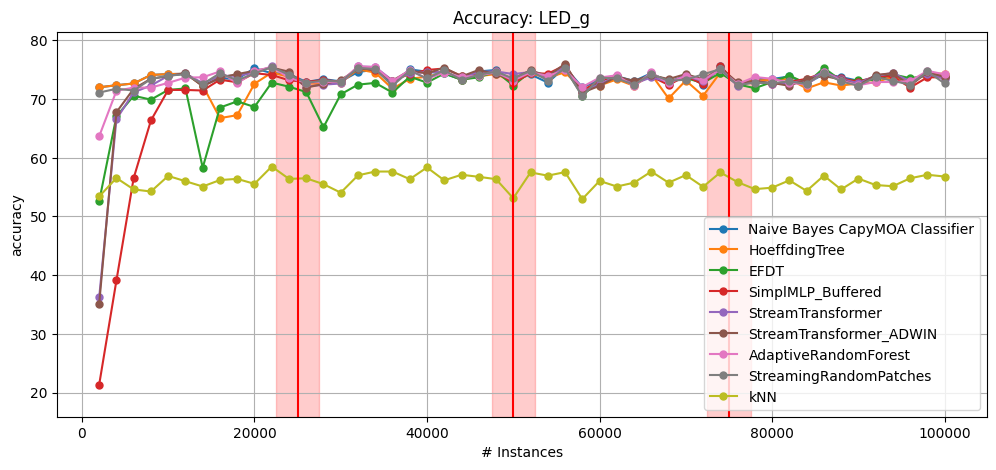


 Windowed Metrics for LED_g:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     72.00  68.853668  68.940654  68.018275  71.845853   
1      4000.0     72.35  69.265843  69.345898  69.192201  72.446337   
2      6000.0     72.65  69.594363  69.779006  68.973341  72.833162   
3      8000.0     74.10  71.207810  71.786492  70.717920  74.367684   
4     10000.0     74.25  71.382410  71.325167  71.132287  74.206943   
5     12000.0     74.30  71.435693  71.649200  70.878187  74.238091   
6     14000.0     72.30  69.218272  69.136490  68.928772  72.467106   
7     16000.0     73.55  70.605714  70.578420  70.413870  73.769928   
8     18000.0     73.40  70.436774  70.656371  70.312500  73.261975   
9     20000.0     75.25  72.496111  72.361809  71.970555  75.373681   
10    22000.0     74.40  71.548419  71.914427  71.122391  74.430511   
11    24000.0     74.25  71.383070  71.229050  71.277189  74.134414   
12    26000.0     72.90  69.882029  69.805014  69.737577  72.910130   
13    28000.0     73.40  70.430793  70.607735  69.943503  73.570312   
14    30000.0     73.00  69.976724  69.832402  69.508752  73.056450   
15    32000.0     74.60  71.774595  71.412493  71.588367  74.510478   
16    34000.0     75.00  72.213323  72.051425  71.815107  75.125554   
17    36000.0     72.55  69.493305  69.483046  69.432071  72.444011   
18    38000.0     75.05  72.271855  71.791973  72.107323  75.024901   
19    40000.0     74.65  71.829945  71.691792  71.770601  74.680932   
20    42000.0     74.35  71.493919  71.610404  71.049661  74.389143   
21    44000.0     73.30  70.319639  70.117515  69.796380  73.207487   
22    46000.0     74.70  71.879547  71.573034  71.636771  74.744272   
23    48000.0     74.95  72.138929  72.259136  71.806415  74.903694   
24    50000.0     73.05  70.046586  70.220994  69.513575  73.135845   
25    52000.0     74.20  71.328172  71.076233  71.189280  74.070385   
26    54000.0     72.80  69.770598  69.403825  69.438202  72.894812   
27    56000.0     75.40  72.652385  72.266065  72.406057  75.524378   
28    58000.0     72.00  68.878904  68.836950  68.556990  72.171685   
29    60000.0     73.25  70.257735  69.943820  70.211581  72.944542   
30    62000.0     73.90  70.980501  70.772676  70.690623  73.751890   
31    64000.0     73.05  70.049199  69.854586  70.038911  73.039136   
32    66000.0     74.40  71.543691  71.945205  71.268238  74.269670   
33    68000.0     72.55  69.477931  69.735391  69.278120  72.227841   
34    70000.0     74.15  71.262291  71.483729  71.052632  73.863860   
35    72000.0     72.40  69.329985  69.179229  69.023569  72.411440   
36    74000.0     75.60  72.865553  73.053562  72.272727  75.440654   
37    76000.0     72.35  69.258675  69.413717  68.845070  72.596877   
38    78000.0     73.40  70.441292  70.279330  70.246085  73.402723   
39    80000.0     73.40  70.441965  70.460855  69.875425  73.421681   
40    82000.0     73.85  70.937195  71.088999  70.468662  73.797132   
41    84000.0     72.60  69.535728  69.521691  69.230769  72.577018   
42    86000.0     74.25  71.372834  71.212968  71.051152  73.994219   
43    88000.0     73.75  70.820616  70.784641  70.472441  73.564563   
44    90000.0     73.10  70.100173  70.210410  69.758291  72.986730   
45    92000.0     73.55  70.604995  70.264193  70.264193  73.430416   
46    94000.0     74.25  71.387768  71.196868  71.164614  74.324696   
47    96000.0     72.85  69.791142  69.408451  69.287330  73.094376   
48    98000.0     74.40  71.548901  72.082879  71.171171  74.265096   
49   100000.0     74.00  71.091301  70.982143  70.621469  74.148001   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    74.823529   79.668050   80.239521   61.956522  ...  76.811594  80.000000   
1    73.372781   75.714286   81.651376   65.816327  ...  75.151515  77.184466   
2    72.832370   75.132275   79.000000   67.005076  ...  78.750000  73.195876   
3    74.863388   84.044944   82.025316   66.190476  ...  7


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     72.00  68.853668  68.940654  68.018275  71.845853   
1      4000.0     72.35  69.265843  69.345898  69.192201  72.446337   
2      6000.0     72.65  69.594363  69.779006  68.973341  72.833162   
3      8000.0     74.10  71.207810  71.786492  70.717920  74.367684   
4     10000.0     74.25  71.382410  71.325167  71.132287  74.206943   
5     12000.0     74.30  71.435693  71.649200  70.878187  74.238091   
6     14000.0     72.30  69.218272  69.136490  68.928772  72.467106   
7     16000.0     66.75  63.055207  63.014461  62.807606  66.856830   
8     18000.0     67.25  63.597936  63.872035  63.448661  67.209828   
9     20000.0     72.60  69.550599  69.402568  68.969422  72.757665   
10    22000.0     74.50  71.660086  72.024136  71.235195  74.492398   
11    24000.0     73.80  70.879166  70.726257  70.775237  73.724451   
12    26000.0     72.70  69.657564  69.582173  69.514238  72.607917   
13    28000.0     72.50  69.425480  69.613260  68.926554  72.565381   
14    30000.0     72.80  69.756195  69.608939  69.282891  72.851954   
15    32000.0     75.05  72.270214  71.918965  72.091723  74.965489   
16    34000.0     74.50  71.654037  71.492454  71.251409  74.801402   
17    36000.0     71.75  68.602643  68.593663  68.541203  71.782318   
18    38000.0     73.45  70.495837  69.983041  70.318614  73.512153   
19    40000.0     73.80  70.887692  70.742602  70.824053  73.971703   
20    42000.0     74.55  71.717642  71.831765  71.275395  74.630368   
21    44000.0     73.25  70.262620  70.061556  69.739819  73.062077   
22    46000.0     73.90  70.993328  70.674157  70.739910  73.941609   
23    48000.0     74.25  71.365058  71.483942  71.018571  74.206130   
24    50000.0     72.90  69.876630  70.055249  69.343891  72.876951   
25    52000.0     74.35  71.493206  71.244395  71.356784  74.189157   
26    54000.0     73.65  70.712785  70.359955  70.393258  73.616325   
27    56000.0     74.55  71.707353  71.307779  71.452608  74.660172   
28    58000.0     71.60  68.437378  68.391764  68.107805  71.884155   
29    60000.0     72.30  69.200183  68.876404  69.153675  71.959150   
30    62000.0     73.35  70.369547  70.156775  70.072993  73.288316   
31    64000.0     72.25  69.160602  68.959732  69.149528  72.174034   
32    66000.0     74.20  71.325456  71.726027  71.043771  74.040987   
33    68000.0     70.10  66.758950  67.034179  66.536094  69.846930   
34    70000.0     73.15  70.158261  70.380585  69.932811  73.109502   
35    72000.0     70.55  67.267358  67.113345  66.947250  70.990662   
36    74000.0     74.50  71.651358  71.838763  71.022727  74.671017   
37    76000.0     72.70  69.636354  69.800885  69.239437  73.225386   
38    78000.0     73.15  70.166741  70.000000  69.966443  73.307336   
39    80000.0     73.25  70.270288  70.294281  69.705549  73.413046   
40    82000.0     73.40  70.440166  70.591487  69.960474  73.536977   
41    84000.0     71.80  68.642809  68.631813  68.332398  71.986024   
42    86000.0     72.85  69.813603  69.647848  69.477234  72.986325   
43    88000.0     72.30  69.212447  69.170840  68.841395  72.555226   
44    90000.0     72.65  69.605775  69.712071  69.252389  72.864313   
45    92000.0     72.85  69.832110  69.477234  69.477234  73.112924   
46    94000.0     73.80  70.883057  70.693512  70.660694  74.022301   
47    96000.0     72.90  69.844468  69.464789  69.343891  73.412267   
48    98000.0     74.35  71.495313  72.028353  71.114865  74.390853   
49   100000.0     74.30  71.416933  71.316964  70.960452  74.622327   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    74.823529   79.668050   80.239521   61.956522  ...  76.811594  80.000000   
1    73.372781   75.714286   81.651376   65.816327  ...  75.151515  77.184466   
2    72.832370   75.132275   79.000000   67.005076  ...  78.750000  73.195876   
3    74.863388   84.044944   82.025316   66.190476  ...  7


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     52.60  47.290082  47.420965  45.859509  52.746870   
1      4000.0     67.05  63.372641  63.470067  63.286908  67.324214   
2      6000.0     70.55  67.246853  67.458564  66.591038  71.128240   
3      8000.0     69.90  66.537979  67.211329  65.969474  70.269475   
4     10000.0     71.55  68.386729  68.318486  68.105381  71.939917   
5     12000.0     71.80  68.660407  68.891340  68.045326  72.101255   
6     14000.0     58.30  53.644133  53.537604  53.224902  59.065431   
7     16000.0     68.55  65.051274  65.016685  64.821029  69.035471   
8     18000.0     69.60  66.195780  66.464424  66.071429  69.514328   
9     20000.0     68.65  65.157172  64.991625  64.496036  69.266705   
10    22000.0     72.80  69.780540  70.159078  69.317541  73.220922   
11    24000.0     72.10  68.996529  68.826816  68.878974  72.398887   
12    26000.0     71.20  67.990913  67.910864  67.839196  71.350112   
13    28000.0     65.20  61.265257  61.546961  60.677966  65.352922   
14    30000.0     70.80  67.525887  67.374302  67.024280  71.102701   
15    32000.0     72.45  69.386508  68.992684  69.183445  72.630595   
16    34000.0     72.75  69.716401  69.536054  69.278467  73.035315   
17    36000.0     71.10  67.893625  67.871039  67.817372  71.352886   
18    38000.0     73.80  70.886681  70.378745  70.709894  74.022687   
19    40000.0     72.80  69.780271  69.625907  69.710468  73.057325   
20    42000.0     74.35  71.480623  71.610404  71.049661  74.721574   
21    44000.0     73.30  70.319515  70.117515  69.796380  73.387655   
22    46000.0     73.70  70.760088  70.449438  70.515695  73.881242   
23    48000.0     74.70  71.858786  71.982281  71.525042  74.924746   
24    50000.0     72.30  69.223752  69.392265  68.665158  72.570591   
25    52000.0     74.65  71.826940  71.580717  71.691792  74.546950   
26    54000.0     73.85  70.937930  70.584927  70.617978  74.104208   
27    56000.0     75.25  72.474240  72.096956  72.237801  75.358568   
28    58000.0     70.60  67.337897  67.278798  66.984840  71.125906   
29    60000.0     73.10  70.089501  69.775281  70.044543  72.937175   
30    62000.0     73.95  71.023351  70.828667  70.746771  73.836705   
31    64000.0     72.60  69.552900  69.351230  69.538633  72.745443   
32    66000.0     74.25  71.378235  71.780822  71.099888  74.266545   
33    68000.0     73.15  70.151344  70.396913  69.949636  73.172359   
34    70000.0     73.55  70.595412  70.821842  70.380739  73.456507   
35    72000.0     72.75  69.730378  69.570073  69.416386  73.057716   
36    74000.0     74.45  71.604304  71.783545  70.965909  74.599030   
37    76000.0     72.50  69.412642  69.579646  69.014085  72.838683   
38    78000.0     71.85  68.722075  68.547486  68.512304  72.018033   
39    80000.0     72.90  69.896707  69.905608  69.309173  73.077531   
40    82000.0     74.00  71.106191  71.254837  70.638058  74.228400   
41    84000.0     72.65  69.600480  69.577308  69.286917  72.920573   
42    86000.0     75.30  72.549044  72.386808  72.231591  75.318828   
43    88000.0     73.15  70.158726  70.116861  69.797525  73.135068   
44    90000.0     73.20  70.216605  70.321152  69.870714  73.174704   
45    92000.0     73.25  70.283506  69.926925  69.926925  73.554761   
46    94000.0     74.20  71.333198  71.140940  71.108623  74.325854   
47    96000.0     73.55  70.564611  70.197183  70.079186  73.847020   
48    98000.0     73.95  71.053095  71.592148  70.664414  73.998164   
49   100000.0     73.70  70.752194  70.647321  70.282486  74.116935   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    57.721519   63.596491   62.711864   46.112601  ...  55.072464  60.416667   
1    69.538462   71.698113   72.311213   65.060241  ...  68.484848  73.786408   
2    71.084337   68.783069   74.782609   67.906977  ...  73.750000  67.010309   
3    71.111111   79.254079   74.585635   66.516854  ...  6


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     21.35  12.327491  12.756517  10.165620        NaN   
1      4000.0     39.10  32.029050  32.483370  32.144847  42.970068   
2      6000.0     56.55  51.602277  51.988950  50.709019  58.693283   
3      8000.0     66.35  62.591919  63.344227  61.955907  66.211888   
4     10000.0     71.55  68.360440  68.318486  68.105381  71.401549   
5     12000.0     71.55  68.368900  68.615554  67.762040  71.275947   
6     14000.0     71.45  68.268479  68.189415  67.975322  71.433435   
7     16000.0     73.30  70.317767  70.300334  70.134228  73.373526   
8     18000.0     72.85  69.815709  70.049641  69.698661  72.594551   
9     20000.0     74.40  71.550917  71.412619  71.007928  74.547860   
10    22000.0     74.10  71.213138  71.585299  70.783982  74.006702   
11    24000.0     73.20  70.208402  70.055866  70.105968  72.979594   
12    26000.0     72.90  69.879309  69.805014  69.737577  72.846937   
13    28000.0     73.25  70.248812  70.441989  69.774011  73.292632   
14    30000.0     72.95  69.921928  69.776536  69.452287  72.993505   
15    32000.0     75.40  72.651313  72.312887  72.483221  75.216560   
16    34000.0     74.90  72.091211  71.939631  71.702368  75.076334   
17    36000.0     73.15  70.154621  70.150083  70.100223  73.015372   
18    38000.0     74.25  71.383420  70.887507  71.212968  74.211382   
19    40000.0     74.95  72.162986  72.026801  72.104677  74.995965   
20    42000.0     75.20  72.424751  72.551190  72.009029  75.337551   
21    44000.0     73.95  71.034298  70.844992  70.531674  73.806814   
22    46000.0     74.20  71.315118  71.011236  71.076233  74.271292   
23    48000.0     74.75  71.914502  72.037652  71.581317  74.808794   
24    50000.0     72.70  69.646701  69.834254  69.117647  72.782890   
25    52000.0     74.45  71.597383  71.356502  71.468453  74.097410   
26    54000.0     74.30  71.428905  71.091114  71.123596  74.146135   
27    56000.0     75.75  73.032348  72.660654  72.798654  75.796697   
28    58000.0     71.45  68.256977  68.224819  67.939360  71.707465   
29    60000.0     73.10  70.090756  69.775281  70.044543  72.826103   
30    62000.0     73.95  71.029023  70.828667  70.746771  73.745919   
31    64000.0     72.70  69.658289  69.463087  69.649805  72.721604   
32    66000.0     73.85  70.927962  71.342466  70.650954  73.573698   
33    68000.0     72.40  69.316440  69.570011  69.110241  72.117211   
34    70000.0     73.95  71.037824  71.263100  70.828667  73.665730   
35    72000.0     72.50  69.439657  69.290899  69.135802  72.441204   
36    74000.0     75.55  72.806041  72.998343  72.215909  75.375759   
37    76000.0     72.60  69.524013  69.690265  69.126761  72.976165   
38    78000.0     72.90  69.883936  69.720670  69.686801  72.787643   
39    80000.0     72.60  69.545886  69.572460  68.969422  72.534898   
40    82000.0     72.90  69.880748  70.038695  69.395822  72.759143   
41    84000.0     73.45  70.480821  70.467186  70.185289  73.318299   
42    86000.0     74.45  71.586968  71.436557  71.275998  74.092351   
43    88000.0     73.55  70.594873  70.562048  70.247469  73.519836   
44    90000.0     72.90  69.869982  69.988926  69.533446  72.698942   
45    92000.0     73.85  70.930144  70.601461  70.601461  73.677464   
46    94000.0     73.85  70.938027  70.749441  70.716685  74.044052   
47    96000.0     71.95  68.802986  68.394366  68.269231  72.077291   
48    98000.0     73.70  70.775229  71.319520  70.382883  73.638975   
49   100000.0     73.70  70.730809  70.647321  70.282486  73.969973   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0     7.662835   48.241206    6.698565         NaN  ...   4.830918  60.000000   
1    11.538462   52.333805   58.596491   27.450980  ...   7.272727  89.805825   
2    24.598930   62.698413   64.259928   59.829060  ...  14.375000  81.443299   
3    54.769231   78.475336   70.669746   66.822430  ...  4


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     36.20  28.760514  29.229063  27.127356  35.515894   
1      4000.0     66.55  62.798943  62.915743  62.729805  66.455604   
2      6000.0     71.15  67.928872  68.121547  67.271696  71.129506   
3      8000.0     72.30  69.210017  69.825708  68.682872  72.285251   
4     10000.0     73.95  71.037140  70.991091  70.795964  73.752116   
5     12000.0     74.35  71.483754  71.704357  70.934844  74.098728   
6     14000.0     72.70  69.653879  69.582173  69.377454  72.737659   
7     16000.0     73.90  70.991660  70.967742  70.805369  73.959795   
8     18000.0     74.00  71.091132  71.318257  70.982143  73.837543   
9     20000.0     74.40  71.550901  71.412619  71.007928  74.523620   
10    22000.0     75.55  72.821020  73.176083  72.419628  75.397891   
11    24000.0     74.10  71.202696  71.061453  71.109872  73.764547   
12    26000.0     72.10  68.992119  68.913649  68.844221  72.079695   
13    28000.0     72.45  69.358920  69.558011  68.870056  72.432940   
14    30000.0     72.65  69.581089  69.441341  69.113495  72.664399   
15    32000.0     75.55  72.818988  72.481711  72.651007  75.371589   
16    34000.0     75.45  72.705087  72.554500  72.322435  75.531205   
17    36000.0     73.15  70.148499  70.150083  70.100223  73.333366   
18    38000.0     74.35  71.494014  71.000565  71.324762  74.272634   
19    40000.0     74.60  71.768799  71.635958  71.714922  74.735668   
20    42000.0     74.60  71.755904  71.887106  71.331828  74.761134   
21    44000.0     73.55  70.590516  70.397314  70.079186  73.313655   
22    46000.0     74.65  71.811636  71.516854  71.580717  74.664743   
23    48000.0     74.70  71.865905  71.982281  71.525042  74.749578   
24    50000.0     74.25  71.367621  71.546961  70.871041  74.361012   
25    52000.0     74.60  71.766108  71.524664  71.635958  74.270741   
26    54000.0     73.75  70.816488  70.472441  70.505618  73.596080   
27    56000.0     75.45  72.702932  72.322435  72.462142  75.515069   
28    58000.0     71.15  67.923194  67.890929  67.602471  71.444759   
29    60000.0     72.60  69.536389  69.213483  69.487751  72.293733   
30    62000.0     73.80  70.859433  70.660694  70.578327  73.648408   
31    64000.0     72.60  69.545802  69.351230  69.538633  72.705563   
32    66000.0     73.70  70.759177  71.178082  70.482604  73.471220   
33    68000.0     72.95  69.928214  70.176406  69.725797  72.706732   
34    70000.0     73.90  70.983420  71.207943  70.772676  73.591794   
35    72000.0     73.05  70.047726  69.905081  69.753086  73.056593   
36    74000.0     75.05  72.245482  72.446162  71.647727  74.893075   
37    76000.0     72.25  69.128832  69.303097  68.732394  72.688316   
38    78000.0     73.10  70.102997  69.944134  69.910515  72.872765   
39    80000.0     72.60  69.536550  69.572460  68.969422  72.591175   
40    82000.0     72.75  69.711840  69.872858  69.226426  72.676687   
41    84000.0     73.15  70.137924  70.133482  69.848400  73.049552   
42    86000.0     74.65  71.813180  71.660145  71.500843  74.307098   
43    88000.0     73.40  70.427859  70.395103  70.078740  73.299384   
44    90000.0     72.70  69.648979  69.767442  69.308600  72.557719   
45    92000.0     73.95  71.034330  70.713884  70.713884  73.696911   
46    94000.0     74.45  71.606134  71.420582  71.388578  74.639090   
47    96000.0     73.00  69.971181  69.577465  69.457014  73.128417   
48    98000.0     74.25  71.384215  71.919302  71.002252  74.128502   
49   100000.0     73.45  70.459431  70.368304  70.000000  73.525600   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    25.252525   53.206003   46.864686   21.875000  ...  24.154589  81.250000   
1    63.492063   70.190275   80.331263   60.571429  ...  60.606061  80.582524   
2    70.694864   74.611399   74.816626   66.145833  ...  73.125000  74.226804   
3    72.965879   83.521445   75.305623   66.978923  ...  7


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     35.10  27.485163  28.008874  25.870931  35.221389   
1      4000.0     67.75  64.138256  64.246120  64.066852  67.795608   
2      6000.0     71.75  68.601430  68.784530  67.952354  71.841044   
3      8000.0     73.45  70.489352  71.078431  69.983041  73.451717   
4     10000.0     73.90  70.985735  70.935412  70.739910  73.714263   
5     12000.0     74.45  71.595149  71.814672  71.048159  74.207993   
6     14000.0     72.15  69.042837  68.969359  68.760516  72.133736   
7     16000.0     73.65  70.709644  70.689655  70.525727  73.722043   
8     18000.0     74.25  71.371258  71.594043  71.261161  74.069484   
9     20000.0     74.80  71.994586  71.859296  71.460929  74.977938   
10    22000.0     75.35  72.599565  72.956665  72.194021  75.182637   
11    24000.0     74.65  71.815013  71.675978  71.723369  74.342062   
12    26000.0     71.95  68.825150  68.746518  68.676717  71.966305   
13    28000.0     72.55  69.467491  69.668508  68.983051  72.546070   
14    30000.0     73.25  70.251053  70.111732  69.791078  73.293099   
15    32000.0     75.10  72.315823  71.975239  72.147651  74.933804   
16    34000.0     75.10  72.310813  72.163220  71.927847  75.237154   
17    36000.0     73.15  70.148839  70.150083  70.100223  73.251421   
18    38000.0     74.85  72.050191  71.565856  71.883734  74.744658   
19    40000.0     74.35  71.490338  71.356784  71.436526  74.483196   
20    42000.0     75.35  72.591194  72.717211  72.178330  75.520394   
21    44000.0     73.85  70.920963  70.733072  70.418552  73.633638   
22    46000.0     74.95  72.148331  71.853933  71.917040  75.030030   
23    48000.0     74.20  71.312224  71.428571  70.962296  74.206191   
24    50000.0     73.45  70.479639  70.662983  69.966063  73.660406   
25    52000.0     74.90  72.099540  71.860987  71.970966  74.628349   
26    54000.0     73.90  70.982783  70.641170  70.674157  73.783145   
27    56000.0     76.00  73.312895  72.942503  73.079080  76.086367   
28    58000.0     71.10  67.866288  67.835281  67.546322  71.464058   
29    60000.0     72.25  69.149013  68.820225  69.097996  72.018609   
30    62000.0     73.80  70.857715  70.660694  70.578327  73.677561   
31    64000.0     73.10  70.106469  69.910515  70.094497  73.289357   
32    66000.0     74.05  71.148995  71.561644  70.875421  73.857931   
33    68000.0     73.40  70.427169  70.672547  70.229435  73.113128   
34    70000.0     74.25  71.374481  71.594043  71.164614  73.947979   
35    72000.0     73.35  70.382883  70.240089  70.089787  73.418094   
36    74000.0     75.25  72.466960  72.667035  71.875000  75.072044   
37    76000.0     72.85  69.798148  69.966814  69.408451  73.302978   
38    78000.0     73.00  69.991514  69.832402  69.798658  72.784270   
39    80000.0     72.75  69.704525  69.739034  69.139298  72.821629   
40    82000.0     72.25  69.156454  69.320066  68.661773  72.130322   
41    84000.0     73.40  70.420033  70.411568  70.129141  73.272277   
42    86000.0     73.95  71.033066  70.877585  70.713884  73.632195   
43    88000.0     73.30  70.317148  70.283806  69.966254  73.251240   
44    90000.0     72.30  69.204232  69.324474  68.858909  72.149961   
45    92000.0     74.10  71.202088  70.882518  70.882518  73.858008   
46    94000.0     74.40  71.549905  71.364653  71.332587  74.629040   
47    96000.0     72.30  69.188269  68.788732  68.665158  72.495510   
48    98000.0     74.55  71.717163  72.246456  71.340090  74.394818   
49   100000.0     73.80  70.845513  70.758929  70.395480  73.916055   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    39.316239   51.282051   35.687732   29.600000  ...  44.444444  79.166667   
1    70.238095   71.806167   79.429735   64.066852  ...  71.515152  79.126214   
2    71.264368   76.240209   73.786408   66.997519  ...  77.500000  75.257732   
3    75.065617   84.064665   79.036145   67.294118  ...  7


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     63.65  59.555286  59.678314  58.480868  63.498391   
1      4000.0     71.40  68.204284  68.292683  68.133705  71.748436   
2      6000.0     71.95  68.803974  69.005525  68.179240  72.275970   
3      8000.0     71.95  68.808978  69.444444  68.287168  72.240368   
4     10000.0     72.75  69.708423  69.654788  69.450673  72.827175   
5     12000.0     73.65  70.716667  70.932157  70.141643  73.737529   
6     14000.0     73.70  70.755284  70.696379  70.499159  73.805209   
7     16000.0     74.70  71.881305  71.857620  71.700224  74.945409   
8     18000.0     72.65  69.601831  69.829013  69.475446  72.575908   
9     20000.0     74.70  71.884500  71.747627  71.347678  74.811683   
10    22000.0     75.50  72.773505  73.121229  72.363226  75.561160   
11    24000.0     73.60  70.660473  70.502793  70.552147  73.522124   
12    26000.0     72.80  69.769775  69.693593  69.625907  72.668706   
13    28000.0     72.90  69.879711  70.055249  69.378531  73.168435   
14    30000.0     72.95  69.926091  69.776536  69.452287  73.200425   
15    32000.0     75.55  72.825196  72.481711  72.651007  75.468732   
16    34000.0     75.45  72.700102  72.554500  72.322435  75.630119   
17    36000.0     73.00  69.988471  69.983324  69.933185  73.050104   
18    38000.0     74.95  72.162383  71.678915  71.995528  75.059260   
19    40000.0     73.45  70.499549  70.351759  70.434298  73.570010   
20    42000.0     74.50  71.647458  71.776425  71.218962  74.556829   
21    44000.0     73.75  70.814428  70.621153  70.305430  73.597033   
22    46000.0     74.00  71.102787  70.786517  70.852018  74.167902   
23    48000.0     74.55  71.686571  71.816168  71.356218  74.584141   
24    50000.0     73.15  70.151021  70.331492  69.626697  73.270616   
25    52000.0     74.55  71.718082  71.468610  71.580123  74.528949   
26    54000.0     73.95  71.046588  70.697413  70.730337  74.065579   
27    56000.0     74.90  72.088154  71.702368  71.845205  75.074584   
28    58000.0     72.05  68.930092  68.892599  68.613139  72.380305   
29    60000.0     73.65  70.713990  70.393258  70.657016  73.551513   
30    62000.0     74.05  71.144672  70.940649  70.859068  73.902631   
31    64000.0     72.15  69.049383  68.847875  69.038355  72.260641   
32    66000.0     74.55  71.715929  72.109589  71.436588  74.548906   
33    68000.0     72.65  69.600581  69.845645  69.390039  72.522671   
34    70000.0     74.00  71.096451  71.318257  70.884658  73.794865   
35    72000.0     73.20  70.226333  70.072585  69.921437  73.346770   
36    74000.0     75.05  72.265683  72.446162  71.647727  75.131837   
37    76000.0     72.55  69.465708  69.634956  69.070423  72.813656   
38    78000.0     73.75  70.833730  70.670391  70.637584  73.772804   
39    80000.0     73.45  70.498189  70.516380  69.932050  73.544515   
40    82000.0     72.80  69.773840  69.928137  69.282891  72.860592   
41    84000.0     72.45  69.372520  69.354839  69.062325  72.466296   
42    86000.0     74.55  71.711347  71.548351  71.388420  74.421952   
43    88000.0     73.15  70.156064  70.116861  69.797525  73.029491   
44    90000.0     72.35  69.265083  69.379845  68.915121  72.224195   
45    92000.0     72.90  69.886547  69.533446  69.533446  72.923567   
46    94000.0     72.90  69.883066  69.686801  69.652856  73.004778   
47    96000.0     73.05  70.012298  69.633803  69.513575  73.315275   
48    98000.0     74.80  71.995224  72.519084  71.621622  74.664444   
49   100000.0     74.20  71.304391  71.205357  70.847458  74.345052   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    64.133017   75.303644   75.000000   57.583548  ...  65.217391  77.500000   
1    68.810289   76.658477   83.410138   64.770241  ...  64.848485  75.728155   
2    72.964169   74.393531   77.519380   64.801865  ...  70.000000  71.134021   
3    71.929825   82.352941   76.363636   64.300626  ...  6


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     71.10  67.852249  67.942318  66.990291  71.055600   
1      4000.0     71.75  68.597818  68.680710  68.523677  71.886852   
2      6000.0     71.45  68.258142  68.453039  67.612025  71.848397   
3      8000.0     73.40  70.431862  71.023965  69.926512  73.560860   
4     10000.0     74.00  71.096949  71.046771  70.852018  73.956138   
5     12000.0     74.20  71.323416  71.538886  70.764873  74.220536   
6     14000.0     72.55  69.491297  69.415042  69.209198  72.607715   
7     16000.0     74.40  71.548063  71.523915  71.364653  74.448078   
8     18000.0     73.20  70.211002  70.435742  70.089286  73.036930   
9     20000.0     74.35  71.502755  71.356784  70.951302  74.574544   
10    22000.0     75.45  72.717789  73.066374  72.306825  75.514325   
11    24000.0     74.15  71.265805  71.117318  71.165644  73.959384   
12    26000.0     72.75  69.713313  69.637883  69.570073  72.620967   
13    28000.0     73.15  70.161578  70.331492  69.661017  73.281158   
14    30000.0     72.95  69.926467  69.776536  69.452287  73.163896   
15    32000.0     75.30  72.548334  72.200338  72.371365  75.231233   
16    34000.0     75.10  72.334686  72.163220  71.927847  75.354518   
17    36000.0     72.25  69.160353  69.149528  69.097996  72.286281   
18    38000.0     74.85  72.050571  71.565856  71.883734  74.878470   
19    40000.0     73.50  70.554574  70.407594  70.489978  73.612802   
20    42000.0     74.90  72.102347  72.219148  71.670429  75.101966   
21    44000.0     73.25  70.253328  70.061556  69.739819  73.057513   
22    46000.0     74.15  71.259088  70.955056  71.020179  74.182790   
23    48000.0     74.65  71.798465  71.926910  71.468768  74.766956   
24    50000.0     73.50  70.543601  70.718232  70.022624  73.667324   
25    52000.0     74.80  71.993543  71.748879  71.859296  74.714278   
26    54000.0     73.15  70.152904  69.797525  69.831461  73.224361   
27    56000.0     75.25  72.490028  72.096956  72.237801  75.608117   
28    58000.0     70.45  67.153802  67.111853  66.816395  70.736815   
29    60000.0     73.65  70.710791  70.393258  70.657016  73.459390   
30    62000.0     73.50  70.537567  70.324748  70.241437  73.414518   
31    64000.0     72.45  69.382008  69.183445  69.371873  72.387471   
32    66000.0     74.25  71.380184  71.780822  71.099888  74.084852   
33    68000.0     73.10  70.103803  70.341786  69.893677  72.919015   
34    70000.0     73.30  70.323524  70.546056  70.100784  73.156704   
35    72000.0     74.20  71.330283  71.189280  71.043771  74.203555   
36    74000.0     75.10  72.306902  72.501380  71.704545  75.002361   
37    76000.0     72.35  69.256838  69.413717  68.845070  72.546044   
38    78000.0     72.80  69.777904  69.608939  69.574944  72.749939   
39    80000.0     72.70  69.655996  69.683509  69.082673  72.815216   
40    82000.0     73.00  69.994982  70.149254  69.508752  73.033746   
41    84000.0     72.55  69.482478  69.466073  69.174621  72.498735   
42    86000.0     74.50  71.652989  71.492454  71.332209  74.271616   
43    88000.0     73.00  69.987353  69.949917  69.628796  72.935673   
44    90000.0     72.25  69.155083  69.269103  68.802698  72.080148   
45    92000.0     73.75  70.821151  70.489039  70.489039  73.611240   
46    94000.0     73.10  70.108139  69.910515  69.876820  73.149514   
47    96000.0     72.45  69.361629  68.957746  68.834842  72.558965   
48    98000.0     74.70  71.883375  72.410033  71.509009  74.489789   
49   100000.0     72.65  69.582739  69.475446  69.096045  72.644205   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    73.755656   78.008299   80.722892   64.957265  ...  78.743961  78.333333   
1    71.884058   75.757576   79.464286   65.871122  ...  75.151515  72.815534   
2    74.052478   72.159091   74.666667   67.625899  ...  79.375000  65.463918   
3    74.673629   82.577566   78.125000   66.359447  ...  7


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     53.40  48.139635  48.308375  46.773272  53.059049   
1      4000.0     56.55  51.722330  51.829268  51.587744  56.408510   
2      6000.0     54.60  49.568065  49.834254  48.496880  54.667870   
3      8000.0     54.25  49.110717  50.163399  48.275862  54.412327   
4     10000.0     56.90  52.085930  52.004454  51.681614  56.779223   
5     12000.0     56.00  51.053980  51.461666  50.141643  55.532349   
6     14000.0     55.10  50.095225  49.972145  49.635446  55.040755   
7     16000.0     56.20  51.315645  51.279199  51.006711  56.311141   
8     18000.0     56.40  51.551612  51.902923  51.339286  56.164082   
9     20000.0     55.55  50.618834  50.362926  49.660249  55.616489   
10    22000.0     58.50  53.831435  54.470653  53.186689  58.122847   
11    24000.0     56.40  51.541933  51.284916  51.366425  55.867072   
12    26000.0     56.50  51.638120  51.532033  51.423786  56.355550   
13    28000.0     55.50  50.547286  50.828729  49.717514  55.535527   
14    30000.0     54.05  48.928101  48.659218  48.108413  54.175481   
15    32000.0     57.00  52.162266  51.603827  51.901566  56.671981   
16    34000.0     57.65  52.881161  52.655115  52.254791  57.810386   
17    36000.0     57.65  52.908393  52.918288  52.839644  57.808453   
18    38000.0     56.35  51.494624  50.650085  51.201789  56.398297   
19    40000.0     58.35  53.718494  53.489671  53.619154  58.399615   
20    42000.0     56.15  51.262940  51.466519  50.507901  56.067876   
21    44000.0     57.10  52.334154  51.986570  51.470588  56.824420   
22    46000.0     56.75  51.941775  51.404494  51.513453  56.691645   
23    48000.0     56.35  51.466701  51.661130  50.872257  56.353582   
24    50000.0     53.10  47.862342  48.176796  46.945701  53.131548   
25    52000.0     57.50  52.736120  52.354260  52.540480  57.351504   
26    54000.0     56.95  52.152871  51.574803  51.629213  56.543023   
27    56000.0     57.55  52.768167  52.142052  52.383623  57.403496   
28    58000.0     52.95  47.741384  47.634947  47.164514  53.354981   
29    60000.0     56.05  51.070302  50.617978  51.057906  55.323876   
30    62000.0     55.10  50.039348  49.720045  49.578888  54.538294   
31    64000.0     55.75  50.811157  50.503356  50.806003  55.287544   
32    66000.0     57.65  52.886547  53.589041  52.469136  56.809802   
33    68000.0     55.75  50.781490  51.212789  50.475658  54.862609   
34    70000.0     57.05  52.228879  52.619967  51.903695  56.427557   
35    72000.0     55.05  50.052684  49.804578  49.551066  55.083789   
36    74000.0     57.50  52.746459  53.064605  51.704545  57.198874   
37    76000.0     55.85  50.891858  51.161504  50.253521  56.297628   
38    78000.0     54.65  49.594309  49.329609  49.272931  54.315102   
39    80000.0     54.90  49.885228  49.916713  48.924122  54.785130   
40    82000.0     56.15  51.249936  51.520177  50.479955  55.732366   
41    84000.0     54.35  49.206385  49.221357  48.736665  54.039175   
42    86000.0     56.95  52.091743  51.872554  51.602024  56.046930   
43    88000.0     54.60  49.518887  49.471341  48.931384  54.343236   
44    90000.0     56.45  51.583621  51.771872  51.039910  56.263411   
45    92000.0     55.35  50.344074  49.803260  49.803260  54.930664   
46    94000.0     55.15  50.174473  49.832215  49.776036  55.270437   
47    96000.0     56.50  51.605380  50.985915  50.791855  56.509702   
48    98000.0     57.10  52.316591  53.217012  51.689189  56.796228   
49   100000.0     56.80  51.923264  51.785714  51.186441  57.066873   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...   recall_0   recall_1  \
0    54.104478   65.259117   67.024129   45.576408  ...  70.048309  70.833333   
1    52.450980   61.873638   73.529412   49.514563  ...  64.848485  68.932039   
2    52.406417   56.641604   69.074492   52.134831  ...  61.250000  58.247423   
3    54.187192   66.105263   66.666667   46.843177  ...  5


==================== DATASET: AGR_a ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - CUSUM           | Drifts: 3420
 - GeometricMovingAverage | Drifts: 1675
 - HDDMAverage     | Drifts: 24841
 - HDDMWeighted    | Drifts: 24841
 - PageHinkley     | Drifts: 133
 - SEED            | Drifts: 15

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: AGR_a


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                AGR_a         63.17  26.6899      0.15
HoeffdingTree             AGR_a         77.45  54.8316      0.53
EFDT                      AGR_a         81.52  63.0918      0.71
Simple_MLP                AGR_a         58.43  16.8349     90.68
StreamTransformer         AGR_a         86.06  72.0972    367.69
StreamTransformer_ADWIN   AGR_a         49.30  -0.0062    370.58
ARF                       AGR_a         79.24  58.4599     28.74
SRP                       AGR_a         85.87  71.7309     37.03
KNN                       AGR_a         67.64  35.2582     18.68

Results for AGR_a saved to thesis_results.csv


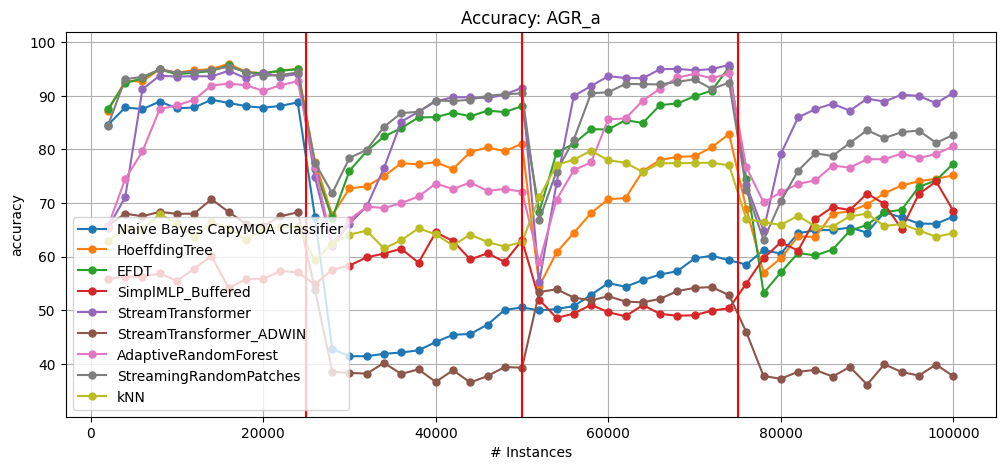


 Windowed Metrics for AGR_a:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     84.55  62.067552  67.336152  54.558824  82.899786   
1      4000.0     87.80  69.048102  72.177879  61.875000  86.124743   
2      6000.0     87.50  68.521783  71.815107  61.538462  85.974575   
3      8000.0     88.90  71.783475  73.539928  64.928910  87.346248   
4     10000.0     87.65  68.490155  71.245634  61.466459  86.090518   
5     12000.0     87.80  68.848943  71.889401  61.875000  86.265274   
6     14000.0     89.25  70.962505  74.404762  63.310580  87.113921   
7     16000.0     88.65  71.061643  73.817762  64.195584  87.114619   
8     18000.0     88.05  70.830821  73.908297  64.749263  87.075181   
9     20000.0     87.75  70.337978  71.210341  64.337700  86.847143   
10    22000.0     88.10  70.085470  73.496659  63.384615  86.722141   
11    24000.0     88.75  71.324794  75.355969  64.566929  87.280860   
12    26000.0     67.35  31.694275  30.383795  29.329004  68.807259   
13    28000.0     42.75  -1.871046 -20.399579 -37.785800  48.703138   
14    30000.0     41.40  -3.750235 -23.759240 -53.002611  47.347942   
15    32000.0     41.40  -2.800976 -26.839827 -53.604194  47.924301   
16    34000.0     41.85  -4.930753 -20.643154 -44.831880  46.613611   
17    36000.0     42.10  -2.267188 -20.625000 -51.968504  48.389404   
18    38000.0     42.50  -3.495167 -18.556701 -47.625160  47.677805   
19    40000.0     44.05   1.206011 -22.161572 -52.868852  50.820119   
20    42000.0     45.40  -0.014654 -16.046759 -40.721649  49.990980   
21    44000.0     45.55   1.063859 -14.511041 -49.178082  50.655821   
22    46000.0     47.30   3.218579 -11.416490 -39.787798  51.941087   
23    48000.0     50.05   6.539433  -8.469055 -26.776650  53.783328   
24    50000.0     50.50   6.145569   0.201613 -26.114650  53.432482   
25    52000.0     49.95  -1.611367  -4.270833   2.150538  49.183931   
26    54000.0     50.20  -1.387255   1.871921  -8.026030  49.298171   
27    56000.0     50.75   0.281439   0.605449  -3.357817  50.144192   
28    58000.0     52.85   4.888509   5.321285   2.178423  52.496988   
29    60000.0     55.05   8.930301   6.158664   5.168776  54.556624   
30    62000.0     54.35   7.907266  12.042389   5.681818  54.074063   
31    64000.0     55.60  10.423280  10.843373   9.480122  55.421100   
32    66000.0     56.65  12.391146  11.440245   9.498956  56.335235   
33    68000.0     57.25  13.030387  16.990291   7.965554  56.613076   
34    70000.0     59.65  17.436036  16.975309  11.995638  58.889515   
35    72000.0     60.15  18.254230  20.932540  12.800875  59.341072   
36    74000.0     59.30  17.434840  19.326065  13.771186  58.898002   
37    76000.0     58.50  18.771751  16.330645  15.132924  59.986349   
38    78000.0     61.20  26.142788  19.751810  -2.917772  64.480147   
39    80000.0     60.55  24.483155  14.239130  -6.048387  63.439572   
40    82000.0     64.35  31.154348  25.262055   7.402597  66.780649   
41    84000.0     64.90  31.465859  27.777778   9.652510  66.632321   
42    86000.0     64.95  31.745067  24.785408   6.781915  66.930922   
43    88000.0     65.40  32.123856  28.952772  12.182741  66.828903   
44    90000.0     64.45  30.879205  26.091476   1.523546  66.626902   
45    92000.0     68.25  37.347933  33.087460  20.426065  69.370074   
46    94000.0     67.30  35.684551  31.230284  14.954486  68.699989   
47    96000.0     66.15  33.356959  29.331942  10.449735  67.511524   
48    98000.0     66.10  32.596803  29.375000  14.930991  66.751778   
49   100000.0     67.45  34.996335  31.761006  13.545817  68.088957   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    89.348501   71.883530  88.297044    81.869867    94.724221  78.124346   
1    91.723202   76.806084  91.598396    85.138539    98.058252  81.268382   
2    91.490810   76.459510  91.589225    84.634761    98.543689  81.008547   
3    92.469471   78.897338  92.628302    86.211259    99.045346  82.63


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     87.15  70.987923  72.832981  62.205882  85.532779   
1      4000.0     92.75  84.172379  83.466363  77.343750  92.499481   
2      6000.0     92.65  83.400147  83.427283  77.384615  91.714291   
3      8000.0     94.95  88.508232  87.961859  84.044234  94.293673   
4     10000.0     94.30  87.094218  86.728754  82.215289  93.579663   
5     12000.0     94.75  88.069809  87.903226  83.593750  94.055797   
6     14000.0     94.95  88.032069  87.976190  82.764505  94.058819   
7     16000.0     95.95  90.783452  90.657439  87.223975  95.427974   
8     18000.0     94.45  87.717462  87.882096  83.628319  93.873031   
9     20000.0     94.20  87.228763  86.368978  83.114993  93.625025   
10    22000.0     94.65  87.964681  88.084633  83.538462  94.012886   
11    24000.0     95.00  88.559334  89.047097  84.251969  94.291352   
12    26000.0     77.65  54.836624  52.345416  51.623377  77.467317   
13    28000.0     67.70  31.891026  32.071504  22.262335  65.945840   
14    30000.0     72.70  41.978594  42.344245  28.720627  70.993230   
15    32000.0     73.10  42.565609  41.774892  29.488860  71.294007   
16    34000.0     75.00  47.025761  48.132780  37.733499  73.617902   
17    36000.0     77.40  50.845843  52.916667  40.682415  75.578697   
18    38000.0     77.20  50.801047  52.989691  41.463415  75.585819   
19    40000.0     77.60  50.445548  51.091703  38.797814  75.352760   
20    42000.0     76.30  47.806554  49.628055  38.917526  74.439389   
21    44000.0     79.50  53.243317  56.887487  43.835616  77.266400   
22    46000.0     80.35  55.697644  58.456660  47.877984  78.717524   
23    48000.0     79.65  55.456619  55.808903  48.350254  78.400039   
24    50000.0     81.05  58.100250  61.794355  51.719745  80.056143   
25    52000.0     54.50  10.974322   5.208333  11.045943  55.964582   
26    54000.0     60.75  22.877561  22.660099  14.859002  61.999594   
27    56000.0     64.40  29.538507  28.153380  25.288562  65.328927   
28    58000.0     68.10  36.656076  35.943775  33.817427  68.854545   
29    60000.0     70.70  41.883529  38.830898  38.185654  71.421146   
30    62000.0     70.90  42.144357  43.930636  39.876033  71.586379   
31    64000.0     75.95  52.108329  51.706827  50.968400  76.478572   
32    66000.0     78.00  56.391949  55.056180  54.070981  79.151774   
33    68000.0     78.60  57.778560  58.446602  53.928956  79.922828   
34    70000.0     78.70  58.064799  56.172840  53.544166  80.150677   
35    72000.0     80.40  61.417171  61.111111  57.111597  81.872676   
36    74000.0     82.85  65.949792  66.005946  63.665254  83.558365   
37    76000.0     68.90  37.171463  37.298387  36.400818  68.600993   
38    78000.0     57.00   9.221032  11.065150 -14.058355  54.613264   
39    80000.0     59.70  15.324750  12.391304  -8.333333  57.682714   
40    82000.0     63.75  22.604750  24.004193   5.844156  61.315965   
41    84000.0     63.65  22.310467  25.205761   6.435006  61.183365   
42    86000.0     68.00  30.295373  31.330472  14.893617  65.211184   
43    88000.0     68.45  33.023678  35.215606  19.923858  66.547589   
44    90000.0     69.70  34.245077  37.006237  16.066482  67.122706   
45    92000.0     71.80  40.039038  40.569020  29.323308  70.118517   
46    94000.0     73.25  42.487836  43.743428  30.429129  71.307851   
47    96000.0     74.05  43.897472  45.824635  31.349206  72.001323   
48    98000.0     74.50  46.007807  46.875000  36.010038  73.068661   
49   100000.0     75.15  46.150112  47.903564  33.997344  73.134151   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    90.399701   80.574452  86.093691    89.036056    83.151326  84.979129   
1    94.408022   89.694385  90.769326    99.270073    82.268579  94.296875   
2    94.508778   88.888889  91.348896    95.327807    87.369985  92.082621   
3    96.255098   92.248657  93.647739    97.593985    89.701493  94.94


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     87.50  72.088744  73.572939  63.235294  86.046657   
1      4000.0     92.35  83.193462  82.554162  76.093750  91.912008   
2      6000.0     93.25  84.572310  84.780158  79.230769  92.287522   
3      8000.0     94.90  88.370171  87.842670  83.886256  94.214747   
4     10000.0     94.00  86.448013  86.030268  81.279251  93.268543   
5     12000.0     94.30  87.136667  86.866359  82.187500  93.622549   
6     14000.0     94.60  87.233922  87.142857  81.569966  93.671375   
7     16000.0     95.65  90.133616  89.965398  86.277603  95.120816   
8     18000.0     94.30  87.416885  87.554585  83.185841  93.732577   
9     20000.0     94.20  87.246342  86.368978  83.114993  93.638459   
10    22000.0     94.65  87.974150  88.084633  83.538462  94.021387   
11    24000.0     94.95  88.459385  88.937568  84.094488  94.245091   
12    26000.0     76.30  52.104957  49.466951  48.701299  76.100660   
13    28000.0     67.15  30.948953  30.914826  20.938628  65.477642   
14    30000.0     76.00  50.613219  49.313622  37.336815  75.484316   
15    32000.0     79.65  59.530192  55.952381  46.657929  80.824124   
16    34000.0     82.40  64.931262  63.485477  56.164384  83.245797   
17    36000.0     83.95  67.568092  66.562500  57.874016  84.461970   
18    38000.0     85.95  71.674643  71.030928  63.928113  86.478899   
19    40000.0     86.00  71.386527  69.432314  61.748634  86.374120   
20    42000.0     86.85  73.177279  72.051010  66.108247  86.952441   
21    44000.0     86.15  71.332471  70.872766  62.054795  86.077360   
22    46000.0     87.20  73.473372  72.938689  66.047745  86.953103   
23    48000.0     86.95  73.224508  71.661238  66.878173  86.780736   
24    50000.0     88.05  75.445374  75.907258  69.554140  87.889301   
25    52000.0     68.35  36.204179  34.062500  38.123167  68.124290   
26    54000.0     79.35  57.942203  59.310345  55.206074  79.331555   
27    56000.0     81.05  61.736729  61.755802  60.230850  81.254802   
28    58000.0     83.75  67.315266  67.369478  66.286307  83.910090   
29    60000.0     83.70  67.057397  65.970772  65.611814  83.911254   
30    62000.0     85.45  70.749300  71.965318  69.938017  85.676320   
31    64000.0     84.90  69.638874  69.678715  69.215087  85.245240   
32    66000.0     88.25  76.340011  75.995914  75.469729  88.447323   
33    68000.0     88.55  76.816888  77.766990  75.349839  88.611195   
34    70000.0     89.90  79.495363  79.218107  77.971647  89.938127   
35    72000.0     90.95  81.633055  82.043651  80.196937  90.962309   
36    74000.0     95.35  90.651312  90.782953  90.148305  95.357048   
37    76000.0     74.40  48.908926  48.387097  47.648262  74.597763   
38    78000.0     53.20  10.914497   3.205791 -24.137931  56.045461   
39    80000.0     57.05  16.181384   6.630435 -15.456989  58.620654   
40    82000.0     60.65  21.678294  17.505241  -2.207792  61.196585   
41    84000.0     60.20  21.121189  18.106996  -2.445302  60.943779   
42    86000.0     61.30  23.397888  16.952790  -2.925532  62.216297   
43    88000.0     64.80  30.425983  27.720739  10.659898  65.778280   
44    90000.0     65.90  32.064405  29.106029   5.540166  66.763424   
45    92000.0     68.30  37.334193  33.192835  20.551378  69.317399   
46    94000.0     68.70  38.521914  34.174553  18.595579  70.223366   
47    96000.0     73.00  46.830298  43.632568  28.571429  74.575782   
48    98000.0     74.20  48.743368  46.250000  35.257215  75.072065   
49   100000.0     77.35  54.087621  52.515723  39.840637  77.580125   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    90.551776   81.536189  86.176850    90.210843    82.142857  85.916856   
1    94.135684   89.000719  90.371045    98.318655    82.423435  93.506434   
2    95.012929   89.559165  92.407263    94.767870    90.046656  92.168091   
3    96.225019   92.141757  93.651545    97.378277    89.924812  94.78


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     55.80   0.386285   6.553911 -30.000000  50.193319   
1      4000.0     56.25   0.173413   0.228050 -36.718750  50.086725   
2      6000.0     56.25   0.956477   1.352875 -34.615385  50.478337   
3      8000.0     56.85   0.478120  -2.860548 -36.334913  50.239065   
4     10000.0     55.45  -1.653843  -3.725262 -39.001560  49.172942   
5     12000.0     57.75   2.393384   2.649770 -32.031250  51.196844   
6     14000.0     60.10   2.623076   5.000000 -36.177474  51.312092   
7     16000.0     54.10  -5.287304  -5.882353 -44.794953  47.355840   
8     18000.0     55.80   0.947054   3.493450 -30.383481  50.473574   
9     20000.0     55.80   1.794473  -3.877791 -28.675400  50.897258   
10    22000.0     57.30   2.755637   4.899777 -31.384615  51.377822   
11    24000.0     57.05  -0.157407   5.914567 -35.275591  49.921258   
12    26000.0     54.80   8.963473   3.624733   2.164502  54.482322   
13    28000.0     57.55   8.740097  10.725552  -2.166065  54.384374   
14    30000.0     58.30  12.246736  11.932418  -8.877285  56.125073   
15    32000.0     59.85  14.685558  13.095238  -5.242464  57.343303   
16    34000.0     60.55  18.098983  18.153527   1.743462  59.050096   
17    36000.0     61.45  18.043068  19.687500  -1.181102  59.022176   
18    38000.0     58.85  13.333024  15.154639  -5.648267  56.666700   
19    40000.0     64.50  22.837494  22.489083   3.005464  61.425127   
20    42000.0     62.90  22.210480  21.147715   4.381443  61.107276   
21    44000.0     59.45  12.700890  14.721346 -11.095890  56.350635   
22    46000.0     60.60  15.638195  16.701903  -4.509284  57.821372   
23    48000.0     59.00  14.709137  10.966341  -4.060914  57.358255   
24    50000.0     63.05  22.008570  25.504032   5.859873  61.009616   
25    52000.0     51.95   3.564017  -0.104167   6.060606  51.782211   
26    54000.0     48.55  -3.554256  -1.379310 -11.605206  48.222864   
27    56000.0     49.35  -1.615210  -2.219980  -6.295908  49.192248   
28    58000.0     51.00   1.816200   1.606426  -1.659751  50.908217   
29    60000.0     49.60  -1.126030  -5.219207  -6.329114  49.436956   
30    62000.0     48.85  -2.296727   1.445087  -5.681818  48.851011   
31    64000.0     50.95   1.746134   1.506024   0.000000  50.873341   
32    66000.0     49.30  -1.527925  -3.575077  -5.845511  49.235982   
33    68000.0     48.95  -2.639267   0.873786  -9.903122  48.680361   
34    70000.0     49.05  -2.907880  -4.835391 -11.123228  48.545141   
35    72000.0     49.90  -0.528527   0.595238  -9.628009  49.735428   
36    74000.0     50.35   0.146412   1.585728  -5.190678  50.073275   
37    76000.0     54.95   9.252608   9.173387   7.873211  54.626363   
38    78000.0     59.70  13.620152  16.649431  -6.896552  56.812856   
39    80000.0     62.65  19.995373  18.804348  -0.403226  59.997741   
40    82000.0     61.10  17.814586  18.448637  -1.038961  58.907314   
41    84000.0     67.00  30.838272  32.098765  15.057915  65.421946   
42    86000.0     69.25  34.173909  34.012876  18.218085  67.089875   
43    88000.0     68.65  34.393089  35.626283  20.431472  67.196631   
44    90000.0     71.75  38.601238  41.268191  21.745152  69.301575   
45    92000.0     69.80  36.630240  36.354057  24.310777  68.324397   
46    94000.0     65.15  26.710885  26.708728   9.362809  63.358185   
47    96000.0     71.65  39.975355  40.814196  25.000000  69.990992   
48    98000.0     74.00  45.603793  45.833333  34.755332  72.804382   
49   100000.0     68.50  32.800645  33.962264  16.334661  66.400669   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    66.916168   33.433735  50.195956    66.026588    34.365325  50.190683   
1    67.628561   32.536623  50.086134    68.056590    32.115677  50.087316   
2    67.387253   33.561124  50.475194    67.816954    33.133433  50.481481   
3    68.376695   32.100708  50.238562    68.502203    31.974922  50.23


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     65.35  -0.349558  26.744186  -1.911765  48.776699   
1      4000.0     71.05  12.816961  33.979475   9.531250  66.035805   
2      6000.0     91.20  79.551528  80.157835  72.923077  89.838746   
3      8000.0     93.75  85.511312  85.101311  80.252765  92.757078   
4     10000.0     93.55  85.185355  84.982538  79.875195  92.592706   
5     12000.0     93.65  85.342320  85.368664  80.156250  92.674636   
6     14000.0     93.60  84.396409  84.761905  78.156997  92.210942   
7     16000.0     94.65  87.660614  87.658593  83.123028  93.830572   
8     18000.0     93.25  84.911245  85.262009  80.088496  92.456291   
9     20000.0     94.30  87.361853  86.603995  83.406114  93.680927   
10    22000.0     93.55  85.234362  85.634744  80.153846  92.620593   
11    24000.0     94.05  86.276726  86.966046  81.259843  93.138392   
12    26000.0     74.75  49.249292  46.162047  45.346320  74.626153   
13    28000.0     61.95   3.784153  19.978970   8.423586  54.872762   
14    30000.0     66.15  15.119297  28.511088  11.618799  63.979132   
15    32000.0     69.35  26.591046  33.658009  19.659240  66.290297   
16    34000.0     76.50  48.837356  51.244813  41.469489  75.145626   
17    36000.0     85.15  68.492811  69.062500  61.023622  84.246581   
18    38000.0     87.00  72.690309  73.195876  66.623877  86.345478   
19    40000.0     88.95  76.016738  75.873362  69.808743  88.022515   
20    42000.0     89.70  78.332211  78.108395  73.453608  89.166454   
21    44000.0     89.70  77.767225  78.338591  71.780822  88.883704   
22    46000.0     89.55  77.712895  77.906977  72.281167  88.857539   
23    48000.0     90.20  79.550273  78.718784  75.126904  89.780706   
24    50000.0     91.50  82.176090  82.862903  78.343949  91.088045   
25    52000.0     55.25   9.444302   6.770833  12.512219  54.750408   
26    54000.0     73.65  46.281826  48.078818  42.841649  73.478496   
27    56000.0     89.95  79.848856  79.717457  78.908709  89.925412   
28    58000.0     91.80  83.597638  83.534137  82.987552  91.820243   
29    60000.0     93.65  87.266230  86.743215  86.603376  93.633137   
30    62000.0     93.30  86.584545  87.090559  86.157025  93.292620   
31    64000.0     93.25  86.494517  86.445783  86.238532  93.252129   
32    66000.0     94.95  89.890234  89.683350  89.457203  94.953248   
33    68000.0     95.00  89.959366  90.291262  89.235737  94.984128   
34    70000.0     94.75  89.447448  89.197531  88.549618  94.735680   
35    72000.0     94.95  89.827388  89.980159  88.949672  94.913899   
36    74000.0     95.75  91.471823  91.575818  90.995763  95.736119   
37    76000.0     73.30  46.202978  46.169355  45.398773  73.102241   
38    78000.0     64.85  16.636824  27.300931   6.763926  59.556985   
39    80000.0     79.15  54.515707  54.673913  43.951613  77.337307   
40    82000.0     85.95  70.192950  70.545073  63.506494  85.103677   
41    84000.0     87.50  73.728706  74.279835  67.824968  86.865091   
42    86000.0     88.50  75.518580  75.321888  69.414894  87.759635   
43    88000.0     87.20  73.301963  73.716632  67.512690  86.657482   
44    90000.0     89.45  77.125834  78.066528  70.775623  88.562940   
45    92000.0     88.90  76.904255  76.606955  72.180451  88.454219   
46    94000.0     90.20  79.295170  79.390116  74.512354  89.647585   
47    96000.0     89.95  78.510488  79.018789  73.412698  89.265219   
48    98000.0     88.60  76.250223  76.250000  71.392723  88.125860   
49   100000.0     90.55  79.951119  80.188679  74.900398  89.980653   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    78.942571    2.256700  47.734227    65.838824    29.629630  49.865721   
1    82.417249   18.104668  82.862073    70.201759    95.522388  54.889706   
2    93.595342   85.942492  90.678663    91.988555    89.368771  89.014245   
3    95.439621   90.071485  92.885793    95.196507    90.575080  92.62


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy    kappa    kappa_t    kappa_m   f1_score  f1_score_0  \
0      2000.0     65.75 -0.02015  27.589852  -0.735294  49.802914   79.298882   
1      4000.0     68.00  0.00000  27.023945   0.000000        NaN   80.952381   
2      6000.0     67.50  0.00000  26.719278   0.000000        NaN   80.597015   
3      8000.0     68.35  0.00000  24.553039   0.000000        NaN   81.199881   
4     10000.0     67.95  0.00000  25.378347   0.000000        NaN   80.916940   
5     12000.0     68.00  0.00000  26.267281   0.000000        NaN   80.952381   
6     14000.0     70.70  0.00000  30.238095   0.000000        NaN   82.835384   
7     16000.0     68.30  0.00000  26.874279   0.000000        NaN   81.164587   
8     18000.0     66.10  0.00000  25.982533   0.000000        NaN   79.590608   
9     20000.0     65.65  0.00000  19.271445   0.000000        NaN   79.263507   
10    22000.0     67.50  0.00000  27.616927   0.000000        NaN   80.597015   
11    24000.0     68.25  0.00000  30.449069   0.000000        NaN   81.129272   
12    26000.0     53.80  0.00000   1.492537   0.000000        NaN   69.960988   
13    28000.0     38.50  0.00000 -29.337539 -48.014440        NaN   55.595668   
14    30000.0     38.30  0.00000 -30.306230 -61.096606        NaN   55.386840   
15    32000.0     38.15  0.00000 -33.874459 -62.123198        NaN   55.229823   
16    34000.0     40.15  0.00000 -24.170124 -49.066002        NaN   57.295755   
17    36000.0     38.10  0.00000 -28.958333 -62.467192        NaN   55.177408   
18    38000.0     38.95  0.00000 -25.876289 -56.739409        NaN   56.063332   
19    40000.0     36.60  0.00000 -38.427948 -73.224044        NaN   53.587116   
20    42000.0     38.80  0.00000 -30.074389 -57.731959        NaN   55.907781   
21    44000.0     36.50  0.00000 -33.543638 -73.972603        NaN   53.479853   
22    46000.0     37.70  0.00000 -31.712474 -65.251989        NaN   54.756718   
23    48000.0     39.40  0.00000 -31.596091 -53.807107        NaN   56.527977   
24    50000.0     39.25  0.00000 -22.479839 -54.777070        NaN   56.373429   
25    52000.0     53.35  0.00000   2.812500   8.797654        NaN   69.579394   
26    54000.0     53.90  0.00000   9.162562   0.000000        NaN   70.045484   
27    56000.0     52.35  0.00000   3.834511   0.000000        NaN   68.723334   
28    58000.0     51.80  0.00000   3.212851   0.000000        NaN   68.247694   
29    60000.0     52.60  0.00000   1.043841   0.000000        NaN   68.938401   
30    62000.0     51.60  0.00000   6.743738   0.000000        NaN   68.073879   
31    64000.0     51.45  0.00000   2.510040   1.019368        NaN   67.943216   
32    66000.0     52.10  0.00000   2.145046   0.000000        NaN   68.507561   
33    68000.0     53.55  0.00000   9.805825   0.000000        NaN   69.749267   
34    70000.0     54.15  0.00000   5.658436   0.000000        NaN   70.256244   
35    72000.0     54.30  0.00000   9.325397   0.000000        NaN   70.382372   
36    74000.0     52.80  0.00000   6.442022   0.000000        NaN   69.109948   
37    76000.0     45.90  0.00000  -9.072581 -10.633947        NaN   62.919808   
38    78000.0     37.70  0.00000 -28.852120 -65.251989        NaN   54.756718   
39    80000.0     37.20  0.00000 -36.521739 -68.817204        NaN   54.227405   
40    82000.0     38.50  0.00000 -28.930818 -59.740260        NaN   55.595668   
41    84000.0     38.85  0.00000 -25.823045 -57.400257        NaN   55.959669   
42    86000.0     37.60  0.00000 -33.905579 -65.957447        NaN   54.651163   
43    88000.0     39.40  0.00000 -24.435318 -53.807107        NaN   56.527977   
44    90000.0     36.10  0.00000 -32.848233 -77.008310        NaN   53.049229   
45    92000.0     39.90  0.00000 -26.659642 -50.626566        NaN   57.040743   
46    94000.0     38.45  0.00000 -29.442692 -60.078023        NaN   55.543518   
47    96000.0     37.80  0.00000 -29.853862 -64.550265        NaN   54.862119   
48    98000.0     39.85  0.00000 -2


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     65.60  16.551845  27.272727  -1.176471  58.681056   
1      4000.0     74.45  33.880234  41.733181  20.156250  68.232679   
2      6000.0     79.60  47.752593  54.002255  37.230769  75.662287   
3      8000.0     87.50  69.422738  70.202622  60.505529  85.173444   
4     10000.0     88.20  72.008630  72.526193  63.182527  86.163357   
5     12000.0     89.25  75.019752  75.230415  66.406250  87.528714   
6     14000.0     91.90  80.390258  80.714286  72.354949  90.196209   
7     16000.0     92.25  82.140265  82.122261  75.552050  91.070823   
8     18000.0     91.95  81.901043  82.423581  76.253687  90.962062   
9     20000.0     90.90  79.625353  78.613396  73.508006  89.832487   
10    22000.0     91.95  81.718049  82.071269  75.230769  90.861184   
11    24000.0     92.70  83.070403  84.008762  77.007874  91.539274   
12    26000.0     76.65  53.039463  50.213220  49.458874  76.519852   
13    28000.0     62.25  15.371078  20.609884   9.145608  58.004347   
14    30000.0     66.90  25.775767  30.095037  13.577023  63.363407   
15    32000.0     69.30  31.068782  33.549784  19.528178  66.083999   
16    34000.0     69.05  33.712283  35.788382  22.914072  67.052783   
17    36000.0     69.95  34.455765  37.395833  21.128609  67.360904   
18    38000.0     71.20  37.942737  40.618557  26.059050  69.095637   
19    40000.0     73.60  41.422891  42.358079  27.868852  70.845495   
20    42000.0     72.60  40.335168  41.764081  29.381443  70.414849   
21    44000.0     73.80  41.923614  44.900105  28.219178  71.076132   
22    46000.0     72.25  38.859818  41.331924  26.392573  69.637627   
23    48000.0     72.60  40.943185  40.499457  30.456853  70.675520   
24    50000.0     72.10  38.762408  43.750000  28.917197  69.876526   
25    52000.0     58.90  17.871534  14.375000  19.648094  58.964464   
26    54000.0     70.60  40.616378  42.068966  36.225597  70.332198   
27    56000.0     76.10  51.908421  51.765893  49.842602  76.043207   
28    58000.0     77.55  54.906821  54.919679  53.423237  77.549457   
29    60000.0     85.60  71.061558  69.937370  69.620253  85.559538   
30    62000.0     85.75  71.389219  72.543353  70.557851  85.838077   
31    64000.0     89.10  78.175316  78.112450  77.777778  89.089617   
32    66000.0     91.30  82.569252  82.226762  81.837161  91.284626   
33    68000.0     93.40  86.721751  87.184466  85.791173  93.364036   
34    70000.0     94.05  88.014447  87.757202  87.022901  94.007425   
35    72000.0     93.25  86.393516  86.607143  85.229759  93.197307   
36    74000.0     94.15  88.248009  88.404361  87.605932  94.135787   
37    76000.0     76.65  53.150174  52.923387  52.249489  76.599876   
38    78000.0     70.10  35.640240  38.159255  20.689655  67.838971   
39    80000.0     71.95  39.047180  39.021739  24.596774  69.559776   
40    82000.0     73.55  43.555873  44.549266  31.298701  71.801466   
41    84000.0     74.20  45.340546  46.913580  33.590734  72.680462   
42    86000.0     76.95  50.917763  50.536481  38.696809  75.459014   
43    88000.0     76.60  51.343259  51.950719  40.609137  75.686024   
44    90000.0     78.15  53.466976  54.573805  39.473684  76.787394   
45    92000.0     78.15  54.488933  53.951528  45.238095  77.244840   
46    94000.0     79.20  56.140675  56.256572  45.903771  78.071350   
47    96000.0     78.35  54.606640  54.801670  42.724868  77.349445   
48    98000.0     79.15  56.936257  56.562500  47.678795  78.502018   
49   100000.0     80.55  58.713737  59.224319  48.339973  79.359705   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    76.027875   39.115044  59.813374    70.296392    49.330357  57.590813   
1    82.915413   49.355798  71.753326    76.026977    67.479675  65.041360   
2    86.290323   60.156250  80.659865    78.966790    82.352941  71.247863   
3    91.270950   77.992958  87.689760    87.307949    88.071571  82.79


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     84.40  62.675497  67.019027  54.117647  82.291474   
1      4000.0     93.10  83.741753  84.264538  78.437500  91.977278   
2      6000.0     93.50  84.957186  85.343856  80.000000  92.520172   
3      8000.0     94.90  88.131793  87.842670  83.886256  94.073602   
4     10000.0     94.30  86.738496  86.728754  82.215289  93.399627   
5     12000.0     94.50  87.277942  87.327189  82.812500  93.646513   
6     14000.0     94.85  87.538323  87.738095  82.423208  93.769971   
7     16000.0     95.40  89.367997  89.388697  85.488959  94.684119   
8     18000.0     94.45  87.512797  87.882096  83.628319  93.771161   
9     20000.0     93.70  85.924068  85.193890  81.659389  92.975118   
10    22000.0     93.85  85.954896  86.302895  81.076923  92.978155   
11    24000.0     94.35  86.935661  87.623220  82.204724  93.468564   
12    26000.0     77.45  54.641456  51.918977  51.190476  77.320742   
13    28000.0     71.80  37.249666  40.694006  32.129964  69.182618   
14    30000.0     78.40  52.066681  54.382260  43.603133  76.638759   
15    32000.0     79.90  55.438251  56.493506  47.313237  78.278584   
16    34000.0     84.20  66.110020  67.219917  60.647572  83.473896   
17    36000.0     86.75  71.440457  72.395833  65.223097  85.809265   
18    38000.0     87.00  72.094351  73.195876  66.623877  86.210874   
19    40000.0     89.10  76.014435  76.200873  70.218579  88.128539   
20    42000.0     89.00  76.482862  76.620616  71.649485  88.332019   
21    44000.0     89.25  76.263290  77.392219  70.547945  88.279378   
22    46000.0     90.00  78.394915  78.858351  73.474801  89.270028   
23    48000.0     90.25  79.208516  78.827362  75.253807  89.753878   
24    50000.0     90.45  79.601863  80.745968  75.668790  89.951789   
25    52000.0     66.85  33.566469  30.937500  35.190616  66.794794   
26    54000.0     75.85  51.132057  52.413793  47.613883  75.632524   
27    56000.0     81.80  63.398730  63.269425  61.804827  81.778301   
28    58000.0     90.45  80.870387  80.823293  80.186722  90.436188   
29    60000.0     90.65  81.218941  80.480167  80.274262  90.629176   
30    62000.0     92.20  84.361968  84.971098  83.884298  92.222085   
31    64000.0     92.15  84.285417  84.236948  83.995923  92.142898   
32    66000.0     92.10  84.142724  83.861083  83.507307  92.112457   
33    68000.0     92.60  85.086704  85.631068  84.068891  92.571389   
34    70000.0     93.05  85.953097  85.699588  84.841876  93.017216   
35    72000.0     91.25  82.331335  82.638889  80.853392  91.178799   
36    74000.0     92.45  84.831194  85.034688  84.004237  92.428985   
37    76000.0     72.45  45.210002  44.455645  43.660532  72.864213   
38    78000.0     63.10  23.450654  23.681489   2.122016  61.790439   
39    80000.0     70.30  36.814964  35.434783  20.161290  68.412664   
40    82000.0     76.00  48.670787  49.685535  37.662338  74.373958   
41    84000.0     79.25  55.651780  57.304527  46.589447  77.894514   
42    86000.0     78.75  53.824023  54.399142  43.484043  76.999127   
43    88000.0     81.20  60.045225  61.396304  52.284264  80.097832   
44    90000.0     83.55  64.182523  65.800416  54.432133  82.095618   
45    92000.0     82.10  62.279896  62.276080  55.137845  81.183769   
46    94000.0     83.20  64.103063  64.668770  56.306892  82.090854   
47    96000.0     83.50  64.709506  65.553236  56.349206  82.363836   
48    98000.0     81.20  60.415177  60.833333  52.823087  80.240456   
49   100000.0     82.70  62.858839  63.731656  54.050465  81.445984   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    88.990826   73.241852  85.701280    83.179420    88.223140  79.142618   
1    95.035971   88.688525  93.152016    93.028169    93.275862  90.831801   
2    95.252009   89.698891  93.215893    93.948127    92.483660  91.834758   
3    96.290909   91.840000  94.382353    95.733912    93.030794  93.76


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     62.85  18.123293  21.458774  -9.264706  59.065918   
1      4000.0     65.25  18.705844  20.752566  -8.593750  59.365958   
2      6000.0     65.10  20.645748  21.307779  -7.384615  60.323133   
3      8000.0     67.90  25.108226  23.480334  -1.421801  62.558603   
4     10000.0     66.25  20.849896  21.420256  -5.304212  60.445453   
5     12000.0     63.60  15.943100  16.129032 -13.750000  57.972390   
6     14000.0     66.35  17.249283  19.880952 -14.846416  58.634762   
7     16000.0     65.40  16.644181  20.184544  -9.148265  58.387954   
8     18000.0     63.10  17.366106  19.432314  -8.849558  58.683638   
9     20000.0     65.10  22.132716  17.978848  -1.601164  61.068737   
10    22000.0     65.55  20.240783  23.273942  -6.000000  60.131657   
11    24000.0     65.60  19.472357  24.644031  -8.346457  59.744657   
12    26000.0     59.30  16.997724  13.219616  11.904762  58.645236   
13    28000.0     62.40  20.290009  20.925342   9.506619  60.146518   
14    30000.0     64.10  23.281090  24.181626   6.266319  61.651620   
15    32000.0     64.80  23.528549  23.809524   7.732634  61.834925   
16    34000.0     61.50  18.385604  20.124481   4.109589  59.236625   
17    36000.0     63.05  20.397431  23.020833   3.018373  60.223415   
18    38000.0     65.25  25.529703  28.350515  10.783055  62.815172   
19    40000.0     64.15  20.714257  21.724891   2.049180  60.410911   
20    42000.0     62.05  18.337924  19.341126   2.190722  59.215458   
21    44000.0     64.10  20.278913  24.500526   1.643836  60.204129   
22    46000.0     62.70  18.808907  21.141649   1.061008  59.446254   
23    48000.0     61.85  18.536171  17.155266   3.172589  59.310143   
24    50000.0     62.70  20.712103  24.798387   4.968153  60.378008   
25    52000.0     71.05  42.037865  39.687500  43.401760  71.046399   
26    54000.0     77.10  53.876211  54.876847  50.325380  76.940077   
27    56000.0     78.05  55.942627  55.701312  53.934942  77.983180   
28    58000.0     79.75  59.498542  59.337349  57.987552  79.767512   
29    60000.0     77.95  55.588229  53.966597  53.481013  77.891965   
30    62000.0     77.50  54.907651  56.647399  53.512397  77.467960   
31    64000.0     75.75  51.480301  51.305221  50.560652  75.743050   
32    66000.0     77.40  54.739169  53.830439  52.818372  77.370958   
33    68000.0     77.40  54.493056  56.116505  51.345533  77.254501   
34    70000.0     77.45  54.499688  53.600823  50.817884  77.257202   
35    72000.0     77.50  54.514947  55.357143  50.765864  77.277668   
36    74000.0     77.00  53.772189  54.410307  51.271186  76.900030   
37    76000.0     67.05  34.083785  33.568548  32.617587  67.095396   
38    78000.0     66.40  27.943075  30.506722  10.875332  63.978079   
39    80000.0     65.90  25.962273  25.869565   8.333333  63.002840   
40    82000.0     67.60  30.534711  32.075472  15.844156  65.302418   
41    84000.0     65.60  26.249656  29.218107  11.454311  63.172803   
42    86000.0     65.60  25.669836  26.180258   8.510638  62.856123   
43    88000.0     67.50  31.115463  33.264887  17.512690  65.584037   
44    90000.0     68.00  28.440449  33.471933  11.357341  64.319279   
45    92000.0     65.70  27.287374  27.713383  14.035088  63.692117   
46    94000.0     66.05  27.007927  28.601472  11.703511  63.545086   
47    96000.0     64.85  23.725908  26.617954   7.010582  61.906625   
48    98000.0     63.70  22.775405  24.375000   8.908407  61.444777   
49   100000.0     64.35  22.746539  25.262055   5.312085  61.402976   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    71.521656   46.585191  58.983862    72.269558    45.698166  59.148203   
1    74.846182   43.815683  59.546425    73.699216    45.393635  59.186581   
2    74.090572   46.554364  60.298708    74.255952    46.341463  60.347578   
3    76.705370   48.392283  62.680707    76.097912    49.263502  62.43


==================== DATASET: AGR_g ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - CUSUM           | Drifts: 3422
 - GeometricMovingAverage | Drifts: 1616
 - HDDMAverage     | Drifts: 24868
 - HDDMWeighted    | Drifts: 24868
 - PageHinkley     | Drifts: 181
 - SEED            | Drifts: 12

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: AGR_g


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                AGR_g         63.18  26.7150      0.15
HoeffdingTree             AGR_g         71.24  42.4568      0.51
EFDT                      AGR_g         77.51  55.1282      0.73
Simple_MLP                AGR_g         58.22  16.4219     93.75
StreamTransformer         AGR_g         86.47  72.9368    376.88
StreamTransformer_ADWIN   AGR_g         49.29  -0.0062    364.82
ARF                       AGR_g         76.17  52.3098     29.88
SRP                       AGR_g         82.96  65.8994     40.20
KNN                       AGR_g         66.41  32.7852     18.58

Results for AGR_g saved to thesis_results.csv


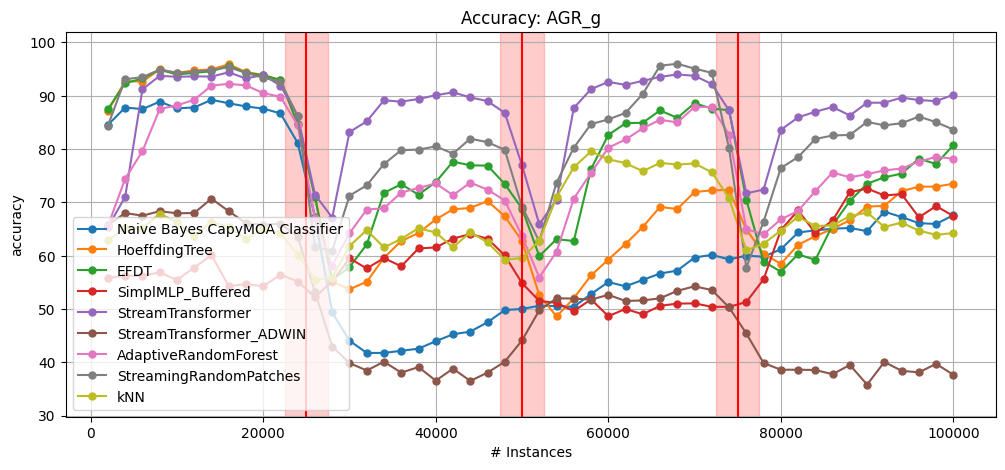


 Windowed Metrics for AGR_g:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     84.55  62.067552  67.336152  54.558824  82.899786   
1      4000.0     87.80  69.048102  72.177879  61.875000  86.124743   
2      6000.0     87.50  68.521783  71.815107  61.538462  85.974575   
3      8000.0     88.90  71.783475  73.539928  64.928910  87.346248   
4     10000.0     87.65  68.490155  71.245634  61.466459  86.090518   
5     12000.0     87.80  68.848943  71.889401  61.875000  86.265274   
6     14000.0     89.25  70.962505  74.404762  63.310580  87.113921   
7     16000.0     88.60  70.912320  73.672055  63.981043  87.024600   
8     18000.0     88.00  70.697259  73.799127  64.601770  87.021920   
9     20000.0     87.60  69.890927  70.789164  63.742690  86.609786   
10    22000.0     86.70  67.414739  70.865279  60.882353  85.531959   
11    24000.0     81.15  55.066947  59.331176  48.285322  79.953635   
12    26000.0     67.25  32.141792  35.340573  30.021368  68.637534   
13    28000.0     49.35   6.088749  -5.082988  -9.750813  54.050306   
14    30000.0     44.05  -0.697957 -15.958549 -40.401506  49.520533   
15    32000.0     41.75  -2.526644 -26.218852 -51.495449  48.138338   
16    34000.0     41.75  -5.002821 -20.475698 -45.261845  46.550175   
17    36000.0     42.15  -2.171836 -20.270270 -52.036794  48.459640   
18    38000.0     42.55  -3.545790 -18.453608 -46.930946  47.648760   
19    40000.0     43.95   1.002165 -22.513661 -53.351573  50.680044   
20    42000.0     45.25  -0.268849 -16.242038 -41.108247  49.834401   
21    44000.0     45.75   1.427261 -13.850997 -48.630137  50.879836   
22    46000.0     47.50   3.339750 -11.464968 -37.976347  52.004680   
23    48000.0     49.80   5.897702  -7.264957 -25.187032  53.412925   
24    50000.0     50.00   3.176208   0.793651 -13.378685  51.720406   
25    52000.0     50.60   1.301166   2.946955   0.703518  50.665539   
26    54000.0     50.55   0.177641   1.395813  -4.878049  50.090551   
27    56000.0     50.40  -0.251741   0.201207  -3.225806  49.870497   
28    58000.0     52.80   4.810402   5.220884   2.176166  52.457596   
29    60000.0     55.05   8.912400   5.765199   5.068638  54.545608   
30    62000.0     54.25   7.750008  11.934552   5.670103  53.997133   
31    64000.0     55.45  10.039256  10.631896   8.895706  55.217143   
32    66000.0     56.65  12.441931  11.349693   9.687500  56.360966   
33    68000.0     57.20  12.979831  16.973812   8.154506  56.593351   
34    70000.0     59.65  17.375680  17.400205  11.803279  58.859091   
35    72000.0     60.15  18.706982  21.322804  14.208827  59.569392   
36    74000.0     59.30  18.474777  17.777778  18.108652  59.545033   
37    76000.0     60.00  21.742329  21.568627  11.894273  61.504846   
38    78000.0     59.80  22.691639  17.113402  -0.878294  62.291329   
39    80000.0     61.20  25.393798  16.108108  -0.518135  63.779205   
40    82000.0     64.35  31.164052  25.262055   7.642487  66.785399   
41    84000.0     64.75  31.232259  27.394439   8.560311  66.548765   
42    86000.0     65.05  31.804213  25.000000   7.417219  66.902784   
43    88000.0     65.20  31.803484  28.834356  11.898734  66.680735   
44    90000.0     64.60  31.040931  25.863874   1.117318  66.698913   
45    92000.0     68.25  37.323197  33.577406  20.724095  69.336106   
46    94000.0     67.25  35.590834  30.907173  14.713542  68.656837   
47    96000.0     66.10  33.311038  29.668050  11.023622  67.479835   
48    98000.0     65.95  32.221136  29.136316  14.231738  66.547971   
49   100000.0     67.60  35.247981  31.932773  13.944223  68.205283   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    89.348501   71.883530  88.297044    81.869867    94.724221  78.124346   
1    91.723202   76.806084  91.598396    85.138539    98.058252  81.268382   
2    91.490810   76.459510  91.589225    84.634761    98.543689  81.008547   
3    92.469471   78.897338  92.628302    86.211259    99.045346  82.63


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     87.15  70.987923  72.832981  62.205882  85.532779   
1      4000.0     92.75  84.172379  83.466363  77.343750  92.499481   
2      6000.0     92.65  83.400147  83.427283  77.384615  91.714291   
3      8000.0     94.95  88.508232  87.961859  84.044234  94.293673   
4     10000.0     94.30  87.094218  86.728754  82.215289  93.579663   
5     12000.0     94.75  88.069809  87.903226  83.593750  94.055797   
6     14000.0     94.95  88.032069  87.976190  82.764505  94.058819   
7     16000.0     95.90  90.666152  90.531178  87.045814  95.371411   
8     18000.0     94.45  87.717462  87.882096  83.628319  93.873031   
9     20000.0     93.90  86.559851  85.630153  82.163743  93.295161   
10    22000.0     92.95  84.352805  84.556407  79.264706  92.179572   
11    24000.0     84.65  66.444640  66.882416  57.887517  83.259707   
12    26000.0     71.10  41.465746  42.941757  38.247863  70.921955   
13    28000.0     55.15  13.046344   6.950207   2.816901  56.974979   
14    30000.0     53.70  11.410364   4.041451 -16.185696  56.247629   
15    32000.0     55.10  13.304145   2.708559 -16.775033  57.169045   
16    34000.0     59.60  19.960694  16.442606  -0.748130  60.291762   
17    36000.0     62.75  24.562462  22.557173   2.102497  62.510456   
18    38000.0     64.25  27.408072  26.288660   8.567775  63.865474   
19    40000.0     66.80  32.269986  27.431694   9.165527  66.472509   
20    42000.0     68.70  35.283512  33.545648  19.329897  67.700339   
21    44000.0     68.95  35.296998  34.837356  14.931507  67.793442   
22    46000.0     70.25  38.318191  36.836518  21.813403  69.246358   
23    48000.0     67.40  33.456079  30.341880  18.703242  66.809826   
24    50000.0     62.75  23.782203  26.091270  15.532880  61.924894   
25    52000.0     52.60   5.132170   6.876228   4.723618  52.591034   
26    54000.0     48.60  -2.081347  -2.492522  -9.013786  48.934405   
27    56000.0     52.00   4.465730   3.420523   0.104058  52.263262   
28    58000.0     56.30  12.780109  12.248996   9.430052  56.418360   
29    60000.0     59.25  18.749763  14.570231  13.938754  59.432815   
30    62000.0     62.20  24.630630  27.237729  22.061856  62.423443   
31    64000.0     65.40  30.875208  30.591775  29.243354  65.471264   
32    66000.0     69.15  38.553161  36.912065  35.729167  69.475172   
33    68000.0     68.75  37.926322  39.379243  32.939914  69.236096   
34    70000.0     71.95  44.278903  42.579324  38.688525  72.442895   
35    72000.0     72.25  44.867951  45.212241  40.258342  72.741549   
36    74000.0     72.35  44.724211  44.141414  44.366197  72.432183   
37    76000.0     64.90  29.003131  31.176471  22.687225  64.508287   
38    78000.0     60.40  18.398046  18.350515   0.627353  59.215837   
39    80000.0     58.45  13.033468  10.162162  -7.642487  56.520758   
40    82000.0     62.05  18.943857  20.440252   1.683938  59.486626   
41    84000.0     63.65  22.357098  25.128733   5.706874  61.194513   
42    86000.0     65.05  23.461846  25.000000   7.417219  61.820106   
43    88000.0     66.65  28.607362  31.799591  15.569620  64.394754   
44    90000.0     69.20  31.730326  35.497382  13.966480  65.902157   
45    92000.0     69.35  34.419425  35.878661  23.470662  67.381650   
46    94000.0     72.10  39.634431  41.139241  27.343750  69.923967   
47    96000.0     72.95  41.212905  43.879668  29.002625  70.725838   
48    98000.0     72.95  42.145844  43.704475  31.863980  71.221564   
49   100000.0     73.50  42.466785  44.327731  29.614874  71.300656   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    90.399701   80.574452  86.093691    89.036056    83.151326  84.979129   
1    94.408022   89.694385  90.769326    99.270073    82.268579  94.296875   
2    94.508778   88.888889  91.348896    95.327807    87.369985  92.082621   
3    96.255098   92.248657  93.647739    97.593985    89.701493  94.94


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     87.50  72.088744  73.572939  63.235294  86.046657   
1      4000.0     92.35  83.193462  82.554162  76.093750  91.912008   
2      6000.0     93.25  84.572310  84.780158  79.230769  92.287522   
3      8000.0     94.90  88.370171  87.842670  83.886256  94.214747   
4     10000.0     94.00  86.448013  86.030268  81.279251  93.268543   
5     12000.0     94.30  87.136667  86.866359  82.187500  93.622549   
6     14000.0     94.60  87.233922  87.142857  81.569966  93.671375   
7     16000.0     95.60  90.016552  89.838337  86.097946  95.064803   
8     18000.0     94.30  87.416885  87.554585  83.185841  93.732577   
9     20000.0     93.85  86.473230  85.512367  82.017544  93.258765   
10    22000.0     92.95  84.363911  84.556407  79.264706  92.186376   
11    24000.0     84.65  66.424750  66.882416  57.887517  83.253369   
12    26000.0     71.00  41.263206  42.744324  38.034188  70.819768   
13    28000.0     55.50  13.807380   7.676349   3.575298  57.401475   
14    30000.0     57.85  20.842097  12.642487  -5.771644  61.967026   
15    32000.0     62.10  29.432640  17.876490   1.430429  67.157864   
16    34000.0     71.80  45.933717  41.675284  29.675810  75.044533   
17    36000.0     73.40  48.747641  44.698545  30.091984  76.391993   
18    38000.0     71.45  45.817510  41.134021  26.982097  75.528452   
19    40000.0     73.80  49.749274  42.732240  28.317373  77.280705   
20    42000.0     77.65  56.269762  52.547771  42.396907  79.655959   
21    44000.0     76.95  54.501939  51.626443  36.849315  78.716239   
22    46000.0     76.90  54.506738  50.955414  39.290407  78.566079   
23    48000.0     73.45  48.122341  43.269231  33.790524  75.306035   
24    50000.0     68.85  38.101720  38.194444  29.365079  69.338804   
25    52000.0     59.90  19.886122  21.218075  19.396985  60.194115   
26    54000.0     63.10  25.484653  26.420738  21.739130  63.013545   
27    56000.0     62.75  24.802012  25.050302  22.476587  62.662050   
28    58000.0     76.25  52.114522  52.309237  50.777202  76.578695   
29    60000.0     82.65  64.815153  63.626834  63.357973  83.149708   
30    62000.0     84.85  69.486712  70.837344  68.762887  85.495187   
31    64000.0     84.95  69.677799  69.809428  69.222904  85.547998   
32    66000.0     87.25  74.278798  73.926380  73.437500  87.733266   
33    68000.0     85.85  71.220534  72.550921  69.635193  86.203928   
34    70000.0     88.60  76.743356  76.663255  75.081967  88.805785   
35    72000.0     87.60  74.819191  75.518263  73.304629  87.805724   
36    74000.0     87.30  74.590548  74.343434  74.446680  87.353944   
37    76000.0     70.50  41.398956  42.156863  35.022026  70.986711   
38    78000.0     58.90  17.649546  15.257732  -3.136763  58.997700   
39    80000.0     57.00  13.803472   7.027027 -11.398964  57.074517   
40    82000.0     60.25  19.378719  16.666667  -2.979275  59.833408   
41    84000.0     59.20  17.664663  15.962925  -5.836576  59.001399   
42    86000.0     65.75  29.990597  26.502146   9.271523  65.195123   
43    88000.0     70.25  39.881379  39.161554  24.683544  70.211842   
44    90000.0     73.50  46.360184  44.502618  25.977654  73.915418   
45    92000.0     74.70  49.187655  47.071130  36.828964  74.998056   
46    94000.0     75.40  50.616689  48.101266  35.937500  75.928087   
47    96000.0     78.20  56.149526  54.771784  42.782152  78.751760   
48    98000.0     77.20  53.982901  52.549428  42.569270  77.361254   
49   100000.0     80.75  60.464892  59.558824  48.871182  80.556879   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    90.551776   81.536189  86.176850    90.210843    82.142857  85.916856   
1    94.135684   89.000719  90.371045    98.318655    82.423435  93.506434   
2    95.012929   89.559165  92.407263    94.767870    90.046656  92.168091   
3    96.225019   92.141757  93.651545    97.378277    89.924812  94.78


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     55.80   0.386285   6.553911 -30.000000  50.193319   
1      4000.0     56.25   0.173413   0.228050 -36.718750  50.086725   
2      6000.0     56.25   0.956477   1.352875 -34.615385  50.478337   
3      8000.0     56.85   0.478120  -2.860548 -36.334913  50.239065   
4     10000.0     55.45  -1.653843  -3.725262 -39.001560  49.172942   
5     12000.0     57.75   2.393384   2.649770 -32.031250  51.196844   
6     14000.0     60.10   2.623076   5.000000 -36.177474  51.312092   
7     16000.0     54.30  -4.826492  -5.542725 -44.391785  47.586167   
8     18000.0     54.65  -0.577740   0.982533 -33.775811  49.711074   
9     20000.0     54.25  -2.260688  -7.773852 -33.771930  48.869430   
10    22000.0     56.45   3.411107   4.600219 -28.088235  51.705747   
11    24000.0     55.15   3.275061   3.236246 -23.045267  51.637540   
12    26000.0     52.20   3.771822   5.626851  -2.136752  51.887301   
13    28000.0     55.20   8.608824   7.053942   2.925244  54.304421   
14    30000.0     59.50  15.087130  16.062176  -1.631117  57.546035   
15    32000.0     57.60   9.626003   8.125677 -10.273082  54.816729   
16    34000.0     59.55  16.538569  16.339193  -0.872818  58.277615   
17    36000.0     58.00  10.684761  12.681913 -10.381078  55.342697   
18    38000.0     61.35  18.600904  20.309278   1.150895  59.301354   
19    40000.0     61.55  17.412709  15.956284  -5.198358  58.707244   
20    42000.0     63.20  22.255273  21.868365   5.154639  61.128895   
21    44000.0     64.05  22.014816  24.554040   1.506849  61.009863   
22    46000.0     63.20  22.020268  21.868365   3.285151  61.010237   
23    48000.0     60.05  16.443745  14.636752   0.374065  58.224327   
24    50000.0     54.85   8.828584  10.416667  -2.380952  54.417401   
25    52000.0     51.50   2.988844   4.715128   2.512563  51.494664   
26    54000.0     51.15   2.170866   2.592223  -3.605514  51.085459   
27    56000.0     49.60  -1.056177  -1.408451  -4.890739  49.471731   
28    58000.0     51.80   3.562872   3.212851   0.103627  51.781950   
29    60000.0     48.65  -3.038585  -7.651992  -8.447730  48.480645   
30    62000.0     50.00  -0.198393   3.753609  -3.092784  49.900739   
31    64000.0     49.00  -2.039183  -2.306921  -4.294479  48.980204   
32    66000.0     50.60   1.239504  -1.022495  -2.916667  50.620528   
33    68000.0     51.00   1.288487   4.946654  -5.150215  50.644720   
34    70000.0     51.05   1.463454  -0.204708  -6.994536  50.731757   
35    72000.0     50.40   0.368496   2.073050  -6.781485  50.184257   
36    74000.0     50.40   0.790476  -0.202020   0.201207  50.395258   
37    76000.0     51.30   1.659074   4.509804  -7.268722  50.829598   
38    78000.0     55.55   7.455409   8.350515 -11.543287  53.727874   
39    80000.0     64.80  25.524712  23.891892   8.808290  62.763418   
40    82000.0     68.50  33.481434  33.962264  18.393782  66.740870   
41    84000.0     64.25  25.068120  26.364573   7.263294  62.540012   
42    86000.0     66.60  28.748567  28.326180  11.523179  64.375129   
43    88000.0     71.90  41.181396  42.535787  28.860759  70.590744   
44    90000.0     72.60  39.872195  42.617801  23.463687  69.945872   
45    92000.0     71.30  40.406049  39.958159  28.339576  70.205192   
46    94000.0     71.55  39.818928  39.978903  25.911458  69.909567   
47    96000.0     67.20  30.390788  31.950207  13.910761  65.195535   
48    98000.0     69.30  35.768415  36.108221  22.670025  67.884847   
49   100000.0     67.45  30.834008  31.617647  13.545817  65.417731   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    66.916168   33.433735  50.195956    66.026588    34.365325  50.190683   
1    67.628561   32.536623  50.086134    68.056590    32.115677  50.087316   
2    67.387253   33.561124  50.475194    67.816954    33.133433  50.481481   
3    68.376695   32.100708  50.238562    68.502203    31.974922  50.23


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     65.35  -0.349558  26.744186  -1.911765  48.776699   
1      4000.0     71.05  12.816961  33.979475   9.531250  66.035805   
2      6000.0     91.20  79.551528  80.157835  72.923077  89.838746   
3      8000.0     93.75  85.511312  85.101311  80.252765  92.757078   
4     10000.0     93.55  85.185355  84.982538  79.875195  92.592706   
5     12000.0     93.65  85.342320  85.368664  80.156250  92.674636   
6     14000.0     93.60  84.396409  84.761905  78.156997  92.210942   
7     16000.0     94.40  87.089531  87.066975  82.306477  93.545816   
8     18000.0     93.25  84.867676  85.262009  80.088496  92.438384   
9     20000.0     93.90  86.475101  85.630153  82.163743  93.238514   
10    22000.0     91.90  81.690778  82.256298  76.176471  90.887677   
11    24000.0     86.25  69.745111  70.334412  62.277092  84.963531   
12    26000.0     71.45  42.013031  43.632774  38.995726  71.349527   
13    28000.0     67.15  31.236158  31.846473  28.819068  65.894287   
14    30000.0     83.20  64.428673  65.181347  57.841907  82.304246   
15    32000.0     85.20  68.670320  67.930661  61.508453  84.336403   
16    34000.0     89.15  77.456372  77.559462  72.942643  88.729887   
17    36000.0     88.90  76.407249  76.923077  70.827858  88.205016   
18    38000.0     89.40  77.853734  78.144330  72.890026  88.937206   
19    40000.0     90.10  78.518445  78.360656  72.913817  89.270516   
20    42000.0     90.65  80.427538  80.148620  75.902062  90.227610   
21    44000.0     89.70  77.934403  78.384050  71.780822  88.980190   
22    46000.0     89.00  76.679030  76.645435  71.090670  88.339602   
23    48000.0     86.80  72.545414  71.794872  67.082294  86.273023   
24    50000.0     76.95  52.893908  54.265873  47.732426  76.502303   
25    52000.0     65.90  31.773050  33.005894  31.457286  65.930277   
26    54000.0     70.50  40.619968  41.176471  37.433722  70.460381   
27    56000.0     87.70  75.310451  75.251509  74.401665  87.710683   
28    58000.0     91.25  82.477922  82.429719  81.865285  91.238982   
29    60000.0     92.60  85.155154  84.486373  84.371700  92.577920   
30    62000.0     92.05  84.092842  84.696824  83.608247  92.051156   
31    64000.0     92.80  85.587086  85.556670  85.276074  92.793886   
32    66000.0     93.55  87.086053  86.809816  86.562500  93.546715   
33    68000.0     94.00  87.939311  88.360815  87.124464  93.970455   
34    70000.0     93.75  87.423029  87.205732  86.338798  93.715256   
35    72000.0     92.20  84.303040  84.600197  83.207750  92.156987   
36    74000.0     87.25  74.498011  74.242424  74.346076  87.249918   
37    76000.0     71.70  42.969764  44.509804  37.665198  71.485976   
38    78000.0     72.40  40.460974  43.092784  30.740276  70.532960   
39    80000.0     83.60  64.843382  64.540541  57.512953  82.504303   
40    82000.0     85.95  70.034849  70.545073  63.601036  85.058258   
41    84000.0     87.00  72.507922  73.223481  66.277562  86.255270   
42    86000.0     87.90  74.106154  74.034335  67.947020  87.063447   
43    88000.0     86.30  71.348503  71.983640  65.316456  85.674330   
44    90000.0     88.70  75.310476  76.335079  68.435754  87.659696   
45    92000.0     88.70  76.419253  76.359833  71.785268  88.211718   
46    94000.0     89.65  78.052504  78.164557  73.046875  89.029986   
47    96000.0     89.20  76.998569  77.593361  71.653543  88.506415   
48    98000.0     89.00  76.995341  77.107180  72.292191  88.498432   
49   100000.0     90.20  79.093534  79.411765  73.970784  89.547583   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    78.942571    2.256700  47.734227    65.838824    29.629630  49.865721   
1    82.417249   18.104668  82.862073    70.201759    95.522388  54.889706   
2    93.595342   85.942492  90.678663    91.988555    89.368771  89.014245   
3    95.439621   90.071485  92.885793    95.196507    90.575080  92.62


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy    kappa    kappa_t    kappa_m   f1_score  f1_score_0  \
0      2000.0     65.75 -0.02015  27.589852  -0.735294  49.802914   79.298882   
1      4000.0     68.00  0.00000  27.023945   0.000000        NaN   80.952381   
2      6000.0     67.50  0.00000  26.719278   0.000000        NaN   80.597015   
3      8000.0     68.35  0.00000  24.553039   0.000000        NaN   81.199881   
4     10000.0     67.95  0.00000  25.378347   0.000000        NaN   80.916940   
5     12000.0     68.00  0.00000  26.267281   0.000000        NaN   80.952381   
6     14000.0     70.70  0.00000  30.238095   0.000000        NaN   82.835384   
7     16000.0     68.35  0.00000  26.905312   0.000000        NaN   81.199881   
8     18000.0     66.10  0.00000  25.982533   0.000000        NaN   79.590608   
9     20000.0     65.80  0.00000  19.434629   0.000000        NaN   79.372738   
10    22000.0     66.00  0.00000  25.520263   0.000000        NaN   79.518072   
11    24000.0     63.55  0.00000  21.359223   0.000000        NaN   77.713238   
12    26000.0     53.20  0.00000   7.601185   0.000000        NaN   69.451697   
13    28000.0     42.95  0.00000 -18.360996 -23.618635        NaN   60.090941   
14    30000.0     39.85  0.00000 -24.663212 -50.941029        NaN   56.989632   
15    32000.0     38.45  0.00000 -33.369447 -60.078023        NaN   55.543518   
16    34000.0     40.10  0.00000 -23.888314 -49.376559        NaN   57.244825   
17    36000.0     38.05  0.00000 -28.794179 -62.812089        NaN   55.124955   
18    38000.0     39.10  0.00000 -25.567010 -55.754476        NaN   56.218548   
19    40000.0     36.55  0.00000 -38.688525 -73.597811        NaN   53.533504   
20    42000.0     38.80  0.00000 -29.936306 -57.731959        NaN   55.907781   
21    44000.0     36.50  0.00000 -33.263379 -73.972603        NaN   53.479853   
22    46000.0     38.05  0.00000 -31.528662 -62.812089        NaN   55.124955   
23    48000.0     40.10  0.00000 -27.991453 -49.376559        NaN   57.244825   
24    50000.0     44.10  0.00000 -10.912698 -26.757370        NaN   61.207495   
25    52000.0     49.75  0.00000   1.277014  -1.005025        NaN   66.444073   
26    54000.0     52.00  0.00000   4.287139  -1.802757        NaN   68.421053   
27    56000.0     51.95  0.00000   3.319920   0.000000        NaN   68.377756   
28    58000.0     51.75  0.00000   3.112450   0.000000        NaN   68.204283   
29    60000.0     52.65  0.00000   0.733753   0.000000        NaN   68.981330   
30    62000.0     51.50  0.00000   6.641001   0.000000        NaN   67.986799   
31    64000.0     51.60  0.00000   2.908726   1.022495        NaN   68.073879   
32    66000.0     52.00  0.00000   1.840491   0.000000        NaN   68.421053   
33    68000.0     53.40  0.00000   9.602328   0.000000        NaN   69.621904   
34    70000.0     54.25  0.00000   6.345957   0.000000        NaN   70.340357   
35    72000.0     53.55  0.00000   8.292201   0.000000        NaN   69.749267   
36    74000.0     50.30  0.00000  -0.404040   0.000000        NaN   66.932801   
37    76000.0     45.40  0.00000  -7.058824 -20.264317        NaN   62.448418   
38    78000.0     39.85  0.00000 -24.020619 -50.941029        NaN   56.989632   
39    80000.0     38.60  0.00000 -32.756757 -59.067358        NaN   55.699856   
40    82000.0     38.60  0.00000 -28.721174 -59.067358        NaN   55.699856   
41    84000.0     38.55  0.00000 -26.570546 -59.403372        NaN   55.647781   
42    86000.0     37.75  0.00000 -33.583691 -64.900662        NaN   54.809437   
43    88000.0     39.50  0.00000 -23.721881 -53.164557        NaN   56.630824   
44    90000.0     35.80  0.00000 -34.450262 -79.329609        NaN   52.724595   
45    92000.0     40.05  0.00000 -25.418410 -49.687890        NaN   57.193859   
46    94000.0     38.40  0.00000 -29.957806 -60.416667        NaN   55.491329   
47    96000.0     38.10  0.00000 -28.423237 -62.467192        NaN   55.177408   
48    98000.0     39.70  0.00000 -2


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     65.60  16.551845  27.272727  -1.176471  58.681056   
1      4000.0     74.45  33.880234  41.733181  20.156250  68.232679   
2      6000.0     79.60  47.752593  54.002255  37.230769  75.662287   
3      8000.0     87.50  69.422738  70.202622  60.505529  85.173444   
4     10000.0     88.20  72.008630  72.526193  63.182527  86.163357   
5     12000.0     89.25  75.019752  75.230415  66.406250  87.528714   
6     14000.0     91.90  80.390258  80.714286  72.354949  90.196209   
7     16000.0     92.25  82.140388  82.101617  75.513428  91.071547   
8     18000.0     91.95  81.861648  82.423581  76.253687  90.949986   
9     20000.0     90.50  78.817905  77.620730  72.222222  89.411432   
10    22000.0     89.80  77.207723  77.656079  70.000000  88.605424   
11    24000.0     84.45  65.946917  66.450917  57.338820  83.021871   
12    26000.0     67.00  33.170242  34.846989  29.487179  66.731930   
13    28000.0     58.15  14.834992  13.174274   9.317443  57.418900   
14    30000.0     64.20  23.641246  25.803109  10.163112  61.896971   
15    32000.0     68.65  31.474811  32.069339  18.465540  65.925291   
16    34000.0     68.90  33.395298  35.677353  22.443890  66.883985   
17    36000.0     71.85  38.141113  41.476091  26.018397  69.299716   
18    38000.0     72.70  40.889899  43.711340  30.179028  70.664167   
19    40000.0     73.55  41.147414  42.185792  27.633379  70.727454   
20    42000.0     71.35  37.900988  39.171975  26.159794  69.121609   
21    44000.0     73.70  41.138291  44.805876  27.945205  70.779353   
22    46000.0     72.40  38.657056  41.401274  27.463863  69.746511   
23    48000.0     70.35  35.391085  36.645299  26.059850  68.235416   
24    50000.0     63.70  23.652241  27.976190  17.687075  62.482426   
25    52000.0     55.90  11.710386  13.359528  11.356784  55.974742   
26    54000.0     60.75  21.584689  21.734796  16.755037  60.816598   
27    56000.0     70.70  41.246477  41.046278  39.021852  70.631380   
28    58000.0     75.55  51.086304  50.903614  49.326425  75.552474   
29    60000.0     80.25  60.386627  58.595388  58.289335  80.193328   
30    62000.0     81.80  63.516818  64.966314  62.474227  81.792238   
31    64000.0     83.90  67.766993  67.703109  67.075665  83.883497   
32    66000.0     85.50  70.958180  70.347648  69.791667  85.479375   
33    68000.0     85.00  69.811138  70.902037  67.811159  84.915765   
34    70000.0     87.90  75.590444  75.230297  73.551913  87.800151   
35    72000.0     87.90  75.646108  76.110563  73.950484  87.829266   
36    74000.0     82.70  65.380890  65.050505  65.191147  82.812205   
37    76000.0     65.00  30.102889  31.372549  22.907489  65.139806   
38    78000.0     64.00  22.981226  25.773196   9.661230  61.587274   
39    80000.0     66.80  27.805998  28.216216  13.989637  64.037234   
40    82000.0     68.40  31.421230  33.752621  18.134715  65.841980   
41    84000.0     72.10  39.232037  42.533471  27.626459  69.816706   
42    86000.0     75.60  46.722855  47.639485  35.364238  73.500535   
43    88000.0     74.70  46.046234  48.261759  35.949367  73.122838   
44    90000.0     75.30  45.320110  48.272251  31.005587  72.705313   
45    92000.0     76.00  48.941656  49.790795  40.074906  74.619264   
46    94000.0     76.35  49.072758  50.105485  38.411458  74.618766   
47    96000.0     77.65  52.435980  53.630705  41.338583  76.221393   
48    98000.0     78.55  54.898032  55.359001  45.969773  77.463814   
49   100000.0     78.20  53.173012  54.201681  42.098274  76.602554   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    76.027875   39.115044  59.813374    70.296392    49.330357  57.590813   
1    82.915413   49.355798  71.753326    76.026977    67.479675  65.041360   
2    86.290323   60.156250  80.659865    78.966790    82.352941  71.247863   
3    91.270950   77.992958  87.689760    87.307949    88.071571  82.79


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     84.40  62.675497  67.019027  54.117647  82.291474   
1      4000.0     93.10  83.741753  84.264538  78.437500  91.977278   
2      6000.0     93.50  84.957186  85.343856  80.000000  92.520172   
3      8000.0     94.90  88.131793  87.842670  83.886256  94.073602   
4     10000.0     94.30  86.738496  86.728754  82.215289  93.399627   
5     12000.0     94.50  87.277942  87.327189  82.812500  93.646513   
6     14000.0     94.85  87.538323  87.738095  82.423208  93.769971   
7     16000.0     95.35  89.247859  89.260970  85.308057  94.623959   
8     18000.0     94.30  87.170657  87.554585  83.185841  93.601356   
9     20000.0     93.40  85.221543  84.452297  80.701754  92.623813   
10    22000.0     92.65  83.463823  83.899233  78.382353  91.751366   
11    24000.0     86.25  69.379938  70.334412  62.277092  84.934001   
12    26000.0     61.55  21.803820  24.086871  17.841880  61.126538   
13    28000.0     60.95  20.601356  18.983402  15.384615  60.304043   
14    30000.0     71.25  38.020894  40.414508  27.854454  69.283694   
15    32000.0     73.20  40.534502  41.928494  30.299090  70.787092   
16    34000.0     77.20  50.435214  52.843847  43.142145  75.894206   
17    36000.0     79.80  55.946512  58.004158  46.911958  78.174025   
18    38000.0     79.90  56.210677  58.556701  48.593350  78.541562   
19    40000.0     80.50  56.415864  57.377049  46.648427  78.481866   
20    42000.0     79.15  54.916969  55.732484  46.262887  77.662904   
21    44000.0     81.95  59.492364  62.119622  50.547945  80.092715   
22    46000.0     81.30  58.939587  60.297240  50.854139  79.801776   
23    48000.0     79.85  56.891849  56.944444  49.750623  78.734781   
24    50000.0     69.20  35.396452  38.888889  30.158730  68.515188   
25    52000.0     62.70  25.336910  26.719057  25.025126  62.843432   
26    54000.0     73.70  47.239608  47.557328  44.220573  73.635237   
27    56000.0     80.25  60.304938  60.261569  58.896982  80.268571   
28    58000.0     84.70  69.319464  69.277108  68.290155  84.687655   
29    60000.0     85.55  70.946014  69.706499  69.482577  85.512711   
30    62000.0     86.80  73.522155  74.590953  72.783505  86.846924   
31    64000.0     90.35  80.675884  80.641926  80.265849  90.338933   
32    66000.0     95.65  91.278720  91.104294  90.937500  95.649477   
33    68000.0     96.00  91.957342  92.240543  91.416309  95.980995   
34    70000.0     95.10  90.113443  89.969294  89.289617  95.064156   
35    72000.0     94.30  88.538970  88.746298  87.728741  94.269843   
36    74000.0     80.15  60.284511  59.898990  60.060362  80.194913   
37    76000.0     57.75  15.755765  17.156863   6.938326  57.939818   
38    78000.0     66.40  30.354106  30.721649  15.683814  65.184533   
39    80000.0     76.45  49.379877  49.081081  38.989637  74.776964   
40    82000.0     78.50  53.865433  54.926625  44.300518  77.010577   
41    84000.0     81.90  61.158256  62.718847  53.047990  80.662209   
42    86000.0     82.55  62.131076  62.553648  53.774834  81.170845   
43    88000.0     82.65  63.320402  64.519427  56.075949  81.699825   
44    90000.0     85.10  67.343468  68.795812  58.379888  83.683585   
45    92000.0     84.45  67.271771  67.468619  61.173533  83.684912   
46    94000.0     84.85  67.425239  68.037975  60.546875  83.807043   
47    96000.0     86.10  70.336162  71.161826  63.517060  85.181771   
48    98000.0     85.05  68.248979  68.886576  62.342569  84.240428   
49   100000.0     83.65  64.626392  65.651261  56.573705  82.380294   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    88.990826   73.241852  85.701280    83.179420    88.223140  79.142618   
1    95.035971   88.688525  93.152016    93.028169    93.275862  90.831801   
2    95.252009   89.698891  93.215893    93.948127    92.483660  91.834758   
3    96.290909   91.840000  94.382353    95.733912    93.030794  93.76


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     62.85  18.123293  21.458774  -9.264706  59.065918   
1      4000.0     65.25  18.705844  20.752566  -8.593750  59.365958   
2      6000.0     65.10  20.645748  21.307779  -7.384615  60.323133   
3      8000.0     67.90  25.108226  23.480334  -1.421801  62.558603   
4     10000.0     66.25  20.849896  21.420256  -5.304212  60.445453   
5     12000.0     63.60  15.943100  16.129032 -13.750000  57.972390   
6     14000.0     66.35  17.249283  19.880952 -14.846416  58.634762   
7     16000.0     65.40  16.634441  20.092379  -9.320695  58.380373   
8     18000.0     63.10  17.485107  19.432314  -8.849558  58.742765   
9     20000.0     65.00  21.905680  17.550059  -2.339181  60.953887   
10    22000.0     64.20  18.725027  21.577218  -5.294118  59.380209   
11    24000.0     60.20  12.085096  14.131607  -9.190672  56.066803   
12    26000.0     55.45  10.204625  12.043435   4.807692  55.110811   
13    28000.0     55.90  10.166010   8.506224   4.442037  55.083390   
14    30000.0     61.80  19.806949  20.829016   4.140527  59.908545   
15    32000.0     64.80  23.695149  23.726977   8.452536  61.927347   
16    34000.0     61.55  18.466794  20.475698   4.114713  59.276465   
17    36000.0     63.15  20.525716  23.388773   3.153745  60.289395   
18    38000.0     65.15  25.405241  28.144330  10.869565  62.755061   
19    40000.0     64.35  21.054963  22.076503   2.462380  60.584820   
20    42000.0     61.55  17.421223  18.365180   0.902062  58.747150   
21    44000.0     64.40  20.802652  25.288562   2.465753  60.476440   
22    46000.0     62.50  18.809993  20.382166   1.445466  59.442359   
23    48000.0     59.25  13.115415  12.927350  -1.620948  56.610074   
24    50000.0     59.55  17.473737  19.742063   8.276644  58.747960   
25    52000.0     62.80  25.586233  26.915521  25.226131  62.799676   
26    54000.0     70.95  41.743874  42.073779  38.388123  70.879599   
27    56000.0     76.60  53.084729  52.917505  51.300728  76.550056   
28    58000.0     79.55  59.105725  58.935743  57.616580  79.575358   
29    60000.0     78.10  55.879642  54.088050  53.748680  78.040637   
30    62000.0     77.35  54.616949  56.400385  53.298969  77.321662   
31    64000.0     75.85  51.673710  51.554664  50.613497  75.839766   
32    66000.0     77.40  54.742070  53.783231  52.916667  77.371913   
33    68000.0     77.10  53.905363  55.577110  50.858369  76.961932   
34    70000.0     77.30  54.183297  53.531218  50.382514  77.098346   
35    72000.0     75.65  50.909633  51.924975  47.578041  75.476643   
36    74000.0     70.75  41.484903  40.909091  41.146881  70.756675   
37    76000.0     61.00  21.755250  23.529412  14.096916  60.896130   
38    78000.0     62.25  20.802257  22.164948   5.269762  60.405431   
39    80000.0     64.70  24.179289  23.675676   8.549223  62.129654   
40    82000.0     67.30  30.003767  31.446541  15.284974  65.034026   
41    84000.0     65.55  25.980994  29.042225  10.635538  63.032296   
42    86000.0     65.70  25.938322  26.394850   9.139073  62.993972   
43    88000.0     67.40  31.003831  33.333333  17.468354  65.526130   
44    90000.0     68.10  28.344879  33.193717  10.893855  64.272278   
45    92000.0     65.40  26.762954  27.615063  13.607990  63.428810   
46    94000.0     66.20  27.306825  28.691983  11.979167  63.693844   
47    96000.0     64.70  23.658509  26.763485   7.349081  61.873566   
48    98000.0     63.90  23.111656  24.869927   9.068010  61.611386   
49   100000.0     64.25  22.446819  24.894958   5.046481  61.256563   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    71.521656   46.585191  58.983862    72.269558    45.698166  59.148203   
1    74.846182   43.815683  59.546425    73.699216    45.393635  59.186581   
2    74.090572   46.554364  60.298708    74.255952    46.341463  60.347578   
3    76.705370   48.392283  62.680707    76.097912    49.263502  62.43


==================== DATASET: RBF_m ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - CUSUM           | Drifts: 1
 - EWMAChart       | Drifts: 14
 - RDDM            | Drifts: 9
 - SEED            | Drifts: 10
 - STEPD           | Drifts: 1666

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: RBF_m


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                RBF_m         52.86  37.4440      0.29
HoeffdingTree             RBF_m         75.31  67.9799      0.57
EFDT                      RBF_m         77.76  71.1097      1.23
Simple_MLP                RBF_m         76.06  68.6473     91.78
StreamTransformer         RBF_m         86.63  82.6847    367.59
StreamTransformer_ADWIN   RBF_m         86.54  82.5734    361.50
ARF                       RBF_m         86.62  82.6276     16.39
SRP                       RBF_m         85.86  81.5835     17.07
KNN                       RBF_m         89.83  86.8499     15.74

Results for RBF_m saved to thesis_results.csv


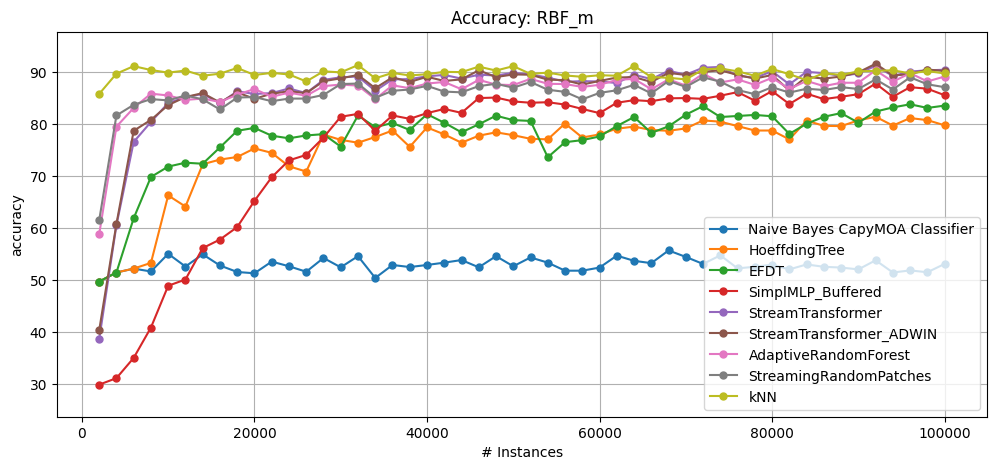


 Windowed Metrics for RBF_m:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.70  33.150239  35.054874  26.408193  45.805913   
1      4000.0     51.45  35.561644  36.286089  30.692363  48.334658   
2      6000.0     52.20  36.961290  38.796415  32.438163  49.575078   
3      8000.0     51.65  36.039495  37.572628  30.829757  47.845828   
4     10000.0     55.05  40.292243  42.037395  35.370237  51.516927   
5     12000.0     52.60  37.279270  39.035370  32.188841  50.217105   
6     14000.0     54.95  40.525501  41.645078  36.189802  52.281898   
7     16000.0     52.80  37.317876  38.860104  32.715609  47.211639   
8     18000.0     51.55  35.705634  38.122605  30.287770  46.021079   
9     20000.0     51.30  35.246014  38.080102  29.420290  47.823538   
10    22000.0     53.55  38.713727  39.081967  33.213515  51.948739   
11    24000.0     52.65  37.468656  38.586252  33.497191  49.611362   
12    26000.0     51.60  35.985800  38.067818  31.926864  47.926537   
13    28000.0     54.25  39.481565  41.005803  36.458333  51.254952   
14    30000.0     52.45  37.302050  38.684720  33.403361  51.025071   
15    32000.0     54.60  39.803726  41.794872  34.816942  53.072343   
16    34000.0     50.40  33.710090  36.246787  28.427128  46.087455   
17    36000.0     52.90  37.635636  39.769821  33.474576  49.002587   
18    38000.0     52.50  37.021258  38.906752  32.191292  47.465742   
19    40000.0     52.90  37.189867  40.114431  31.391114  48.306484   
20    42000.0     53.35  38.379398  39.650712  33.876683  49.381483   
21    44000.0     53.85  38.276909  40.258900  32.578524  50.094876   
22    46000.0     52.45  36.606213  36.852590  32.119914  47.113055   
23    48000.0     54.60  39.562541  40.341656  35.096497  50.395421   
24    50000.0     52.65  37.281653  38.386467  32.789212  49.043392   
25    52000.0     54.35  39.475699  41.020672  33.888487  51.113648   
26    54000.0     53.35  38.443004  39.138943  33.688699  50.588228   
27    56000.0     51.80  36.194899  37.443219  31.290093  49.922051   
28    58000.0     51.80  36.070625  38.871275  32.208158  49.083448   
29    60000.0     52.40  37.363497  39.517154  32.815808  49.370258   
30    62000.0     54.70  39.467959  40.039709  33.771930  51.264000   
31    64000.0     53.70  38.177477  40.943878  32.752360  49.515478   
32    66000.0     53.25  37.875343  40.179143  33.070866  49.776532   
33    68000.0     55.70  40.941759  42.985843  36.984353  51.746015   
34    70000.0     54.45  38.977358  41.035599  31.760300  50.060609   
35    72000.0     53.10  37.572855  39.090909  33.757062  49.156150   
36    74000.0     54.75  39.619489  40.733464  34.609827  50.731194   
37    76000.0     52.25  36.567294  38.664098  31.492109  48.242239   
38    78000.0     52.55  37.051058  36.943522  32.359230  47.858621   
39    80000.0     52.95  37.468747  37.308461  32.253420  48.823446   
40    82000.0     52.05  36.400817  37.968952  31.792319  48.342647   
41    84000.0     53.00  37.132955  39.237233  32.471264  49.992187   
42    86000.0     52.55  36.848206  39.669421  30.981818  49.407353   
43    88000.0     52.40  36.827632  38.020833  31.805158  49.613988   
44    90000.0     52.05  36.831240  38.168923  32.417195  49.299321   
45    92000.0     53.80  38.898668  39.370079  34.560907  50.138975   
46    94000.0     51.45  35.562841  37.955272  29.688631  48.930442   
47    96000.0     51.85  36.103084  36.976440  31.410256  49.297732   
48    98000.0     51.50  35.680871  38.137755  31.642001  48.666047   
49   100000.0     53.10  37.708110  39.130435  33.047823  49.765443   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    49.604743   42.811502   61.801242   13.846154  ...    44.666667   
1    55.128205   43.941842   51.140065   23.255814  ...    46.735395   
2    54.713494   44.515103   53.902798   23.904382  ...    45.602606   
3    55.605381   44.592346   57.227139   20.849421  ...    46.853147   
4    59.499537   42.70


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.70  33.150239  35.054874  26.408193  45.805913   
1      4000.0     51.45  35.561644  36.286089  30.692363  48.334658   
2      6000.0     52.20  36.961290  38.796415  32.438163  49.575078   
3      8000.0     53.30  38.388164  39.703034  33.190272  51.002512   
4     10000.0     66.30  56.227698  56.544165  51.545651  65.987802   
5     12000.0     64.15  53.296018  53.890675  48.712446  63.122470   
6     14000.0     72.30  64.209112  64.119171  60.764873  70.716450   
7     16000.0     73.20  65.258862  65.284974  61.796151  71.624262   
8     18000.0     73.70  65.906653  66.411239  62.158273  72.508839   
9     20000.0     75.35  68.104736  68.658614  64.275362  73.752779   
10    22000.0     74.50  67.119748  66.557377  63.335730  73.950859   
11    24000.0     71.90  63.711066  63.553826  60.533708  70.428215   
12    26000.0     70.90  62.354962  62.763916  59.071730  69.862145   
13    28000.0     78.00  71.539006  71.631206  69.444444  77.305109   
14    30000.0     77.00  70.381855  70.341715  67.787115  76.696395   
15    32000.0     76.45  69.564894  69.807692  66.188083  75.985377   
16    34000.0     77.55  70.898862  71.143959  67.604618  77.056782   
17    36000.0     78.80  72.620361  72.890026  70.056497  78.436217   
18    38000.0     75.65  68.470853  68.681672  65.239115  75.299905   
19    40000.0     79.40  73.261885  73.808010  69.992717  78.615951   
20    42000.0     78.05  71.714546  71.604140  68.887314  77.581759   
21    44000.0     76.45  69.447645  69.514563  65.595325  75.326564   
22    46000.0     77.80  71.233230  70.517928  68.308351  76.886501   
23    48000.0     78.45  72.068542  71.681997  69.192280  77.668181   
24    50000.0     77.90  71.393335  71.242681  68.630234  77.630182   
25    52000.0     77.20  70.512224  70.542636  66.980449  76.911290   
26    54000.0     77.10  70.338488  70.123940  67.448472  76.290679   
27    56000.0     80.15  74.336266  74.237508  71.703493  79.624009   
28    58000.0     77.45  70.832565  71.401395  68.284107  76.585123   
29    60000.0     78.05  71.748558  72.109276  69.019054  78.079393   
30    62000.0     79.15  72.779595  72.402383  69.517544  78.260897   
31    64000.0     79.55  73.455916  73.915816  70.297749  78.647949   
32    66000.0     78.90  72.679612  73.000640  69.792412  78.563020   
33    68000.0     78.75  72.333926  72.651223  69.772404  77.751436   
34    70000.0     79.20  72.855733  73.074434  68.838951  78.665907   
35    72000.0     80.75  75.047952  75.000000  72.810734  80.707090   
36    74000.0     80.50  74.592892  74.459725  71.820809  79.371218   
37    76000.0     79.65  73.625078  73.859987  70.803443  78.970323   
38    78000.0     78.80  72.602076  71.827243  69.779045  78.780842   
39    80000.0     78.80  72.626592  71.752165  69.474442  78.184434   
40    82000.0     77.10  70.270387  70.375162  67.425320  76.906801   
41    84000.0     80.70  74.876784  75.048481  72.270115  80.381222   
42    86000.0     79.70  73.780173  74.189447  70.472727  79.565262   
43    88000.0     79.65  73.717629  73.502604  70.845272  79.191547   
44    90000.0     80.75  75.230788  75.177305  72.868217  80.960728   
45    92000.0     81.45  76.064362  75.656168  73.725212  81.923557   
46    94000.0     79.75  73.800500  74.121406  70.673425  79.911586   
47    96000.0     81.20  75.709135  75.392670  73.219373  81.188359   
48    98000.0     80.80  75.228947  75.510204  72.938689  80.825946   
49   100000.0     79.80  73.793019  73.783258  71.163455  79.524612   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    49.604743   42.811502   61.801242   13.846154  ...    44.666667   
1    55.128205   43.941842   51.140065   23.255814  ...    46.735395   
2    54.713494   44.515103   53.902798   23.904382  ...    45.602606   
3    56.153145   47.697368   56.631893   33.451957  ...    49.488055   
4    70.565676   63.95


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.70  33.150239  35.054874  26.408193  45.805913   
1      4000.0     51.45  35.561644  36.286089  30.692363  48.334658   
2      6000.0     61.90  50.335448  51.216389  46.148410  61.910874   
3      8000.0     69.85  60.576241  61.071659  56.866953  69.647212   
4     10000.0     71.85  63.186566  63.700838  59.525521  72.728432   
5     12000.0     72.60  64.451110  64.758842  60.801144  71.855740   
6     14000.0     72.40  63.981905  64.248705  60.906516  72.239558   
7     16000.0     75.55  68.324092  68.329016  65.146115  75.074126   
8     18000.0     78.75  72.420685  72.860792  69.424460  78.626791   
9     20000.0     79.30  73.192128  73.680865  70.000000  78.975968   
10    22000.0     77.80  71.295225  70.885246  68.080518  77.939655   
11    24000.0     77.30  70.686103  70.557717  68.117978  77.383833   
12    26000.0     77.85  71.343090  71.657070  68.846695  77.423960   
13    28000.0     78.10  71.666706  71.760155  69.583333  77.524565   
14    30000.0     75.70  68.893511  68.665377  65.966387  75.982475   
15    32000.0     81.70  76.333236  76.538462  73.725772  82.141945   
16    34000.0     79.45  73.184183  73.586118  70.346320  79.449451   
17    36000.0     80.25  74.417364  74.744246  72.104520  80.416617   
18    38000.0     78.90  72.564632  72.861736  69.878658  78.448097   
19    40000.0     81.95  76.427800  77.050223  73.707210  81.746310   
20    42000.0     80.30  74.489333  74.514877  72.076541  79.980314   
21    44000.0     78.45  71.805215  72.103560  68.517166  77.999661   
22    46000.0     80.00  74.011453  73.439575  71.448965  79.631443   
23    48000.0     81.65  76.078418  75.886991  73.766976  80.952765   
24    50000.0     80.80  75.057882  75.016265  72.746629  81.239807   
25    52000.0     80.65  74.833369  75.000000  71.976828  80.647408   
26    54000.0     73.65  65.610500  65.622962  62.544421  73.520721   
27    56000.0     76.55  69.554736  69.565217  66.571632  75.884067   
28    58000.0     76.95  70.216897  70.767280  67.580872  76.439374   
29    60000.0     77.65  71.181454  71.601017  68.454481  78.040695   
30    62000.0     79.65  73.278279  73.064196  70.248538  79.389774   
31    64000.0     81.40  75.773727  76.275510  72.984749  81.131957   
32    66000.0     78.35  71.983376  72.296865  69.005011  78.560001   
33    68000.0     79.60  73.417260  73.745174  70.981508  79.403582   
34    70000.0     81.85  76.257898  76.504854  72.808989  81.354447   
35    72000.0     83.50  78.558222  78.571429  76.694915  83.475690   
36    74000.0     81.40  75.692653  75.638507  73.121387  80.772002   
37    76000.0     81.60  76.159596  76.364804  73.601148  81.095762   
38    78000.0     81.80  76.401042  75.813953  74.055595  81.271270   
39    80000.0     81.55  76.103118  75.416389  73.434125  81.194009   
40    82000.0     78.15  71.689236  71.733506  68.918919  78.227408   
41    84000.0     80.10  73.863394  74.272786  71.408046  78.957613   
42    86000.0     81.45  76.038406  76.414495  73.018182  81.134177   
43    88000.0     82.15  76.820808  76.757812  74.426934  81.998732   
44    90000.0     80.30  74.533137  74.597034  72.233968  80.201685   
45    92000.0     82.45  77.255187  76.968504  75.141643  82.664805   
46    94000.0     83.25  78.234111  78.594249  75.742216  83.213483   
47    96000.0     83.85  79.140202  78.861257  76.994302  83.827062   
48    98000.0     83.15  78.215662  78.507653  76.250881  83.476544   
49   100000.0     83.60  78.767375  78.715120  76.588151  83.407374   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    49.604743   42.811502   61.801242   13.846154  ...    44.666667   
1    55.128205   43.941842   51.140065   23.255814  ...    46.735395   
2    65.640038   56.474259   67.226891   57.230769  ...    56.739812   
3    75.422886   62.866450   70.402299   69.186047  ...    64.548495   
4    75.984252   64.68


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     29.85  -0.309831   9.425436  -2.633504        NaN   
1      4000.0     31.10   1.851363   9.580052   1.641685        NaN   
2      6000.0     35.00   9.780082  16.773367   8.127208        NaN   
3      8000.0     40.85  17.921777  23.628147  15.379113        NaN   
4     10000.0     48.90  30.856012  34.107028  26.527678        NaN   
5     12000.0     50.10  33.171798  35.819936  28.612303        NaN   
6     14000.0     56.15  42.155890  43.199482  37.889518  55.764241   
7     16000.0     57.80  44.285207  45.336788  39.843193  51.280153   
8     18000.0     60.20  47.355490  49.169860  42.733813        NaN   
9     20000.0     65.25  53.924184  55.816910  49.637681  62.005431   
10    22000.0     69.80  60.281959  60.393443  56.578001  66.287993   
11    24000.0     73.05  64.745054  65.045396  62.148876  70.937221   
12    26000.0     74.10  66.106907  66.858605  63.572433  70.872748   
13    28000.0     77.45  70.379906  70.921986  68.680556  75.250660   
14    30000.0     81.45  75.974288  76.079948  74.019608  80.944290   
15    32000.0     82.00  76.633042  76.923077  74.156497  81.826073   
16    34000.0     78.75  72.167266  72.686375  69.336219  77.469767   
17    36000.0     81.70  76.277760  76.598465  74.152542  81.301478   
18    38000.0     81.05  75.332129  75.627010  72.947894  80.466278   
19    40000.0     82.15  76.800722  77.304514  73.998543  81.252511   
20    42000.0     82.95  77.971590  77.943079  75.832743  82.615812   
21    44000.0     82.20  76.740783  76.957929  73.995617  81.429810   
22    46000.0     85.05  80.551359  80.146082  78.658101  84.584465   
23    48000.0     85.15  80.682393  80.486202  78.770550  84.862093   
24    50000.0     84.40  79.825021  79.700716  77.856636  84.337617   
25    52000.0     84.15  79.485487  79.521964  77.045619  83.938433   
26    54000.0     84.25  79.654679  79.452055  77.611940  84.018243   
27    56000.0     83.80  79.005230  78.974692  76.906629  83.270501   
28    58000.0     82.95  77.919141  78.376665  76.019691  83.206192   
29    60000.0     82.15  77.003350  77.318933  74.805928  82.169194   
30    62000.0     84.15  79.297750  79.020516  76.827485  83.451654   
31    64000.0     84.65  80.020104  80.420918  77.705156  83.827271   
32    66000.0     84.45  79.811880  80.102367  77.738010  84.597460   
33    68000.0     85.00  80.481591  80.694981  78.662873  84.560766   
34    70000.0     85.05  80.444722  80.647249  77.602996  84.136809   
35    72000.0     84.90  80.439192  80.389610  78.672316  84.494450   
36    74000.0     85.50  81.084084  81.008513  79.046243  84.720831   
37    76000.0     86.20  82.142794  82.273603  80.200861  85.381781   
38    78000.0     84.55  79.951319  79.468439  77.975766  84.542981   
39    80000.0     86.40  82.415940  81.878748  80.417567  86.176943   
40    82000.0     83.90  79.119247  79.172057  77.098151  84.195963   
41    84000.0     85.90  81.534103  81.771170  79.741379  85.185197   
42    86000.0     84.85  80.352654  80.737444  77.963636  84.880203   
43    88000.0     85.30  80.962717  80.859375  78.939828  85.105709   
44    90000.0     85.80  81.759976  81.689233  79.985906  85.768732   
45    92000.0     87.85  84.290665  84.055118  82.790368  87.922549   
46    94000.0     85.30  80.910300  81.214058  78.711079  85.217257   
47    96000.0     87.15  83.397976  83.180628  81.695157  86.986115   
48    98000.0     86.85  83.016255  83.227041  81.465821  86.673544   
49   100000.0     85.60  81.356931  81.310837  79.443255  85.290209   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0     8.978328         NaN    1.108033    3.584229  ...          NaN   
1    10.508475         NaN         NaN         NaN  ...          NaN   
2    35.845214    1.215805   26.200873         NaN  ...    28.571429   
3    40.151515   10.752688   41.516966         NaN  ...    35.087719   
4    57.290768   40.72


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     38.60  15.723098  20.723047  10.168252  34.659670   
1      4000.0     60.55  48.652519  48.228346  43.683084  59.141289   
2      6000.0     76.60  69.957546  70.038412  66.925795  76.296733   
3      8000.0     80.45  74.653889  74.757908  72.031474  80.137042   
4     10000.0     84.10  79.361639  79.497099  77.138749  83.286887   
5     12000.0     85.20  80.874902  80.964630  78.826896  84.816764   
6     14000.0     85.85  81.758388  81.670984  79.957507  85.717209   
7     16000.0     84.05  79.309810  79.339378  77.263008  84.253757   
8     18000.0     86.35  82.308409  82.567050  80.359712  86.473043   
9     20000.0     85.85  81.699520  82.008900  79.492754  85.571535   
10    22000.0     86.00  81.948452  81.639344  79.870597  86.008273   
11    24000.0     86.90  83.112229  83.009079  81.601124  86.943079   
12    26000.0     86.00  81.924014  82.085733  80.309423  85.656220   
13    28000.0     88.55  85.178416  85.235332  84.097222  88.174541   
14    30000.0     89.05  85.926391  85.880077  84.663866  88.919595   
15    32000.0     89.20  86.045110  86.153846  84.493898  89.268970   
16    34000.0     86.45  82.370808  82.583548  80.447330  85.874255   
17    36000.0     88.65  85.336704  85.485934  83.968927  88.099850   
18    38000.0     88.70  85.354233  85.466238  83.868665  88.254091   
19    40000.0     89.25  86.053143  86.331850  84.340859  88.797761   
20    42000.0     89.50  86.479618  86.416559  85.116938  89.343468   
21    44000.0     88.80  85.428402  85.501618  83.637692  88.321070   
22    46000.0     89.55  86.437009  86.122178  85.082084  89.299692   
23    48000.0     89.40  86.249396  86.070959  84.846319  88.916008   
24    50000.0     89.90  86.949071  86.857515  85.663591  89.695219   
25    52000.0     89.60  86.533857  86.563307  84.938450  89.469488   
26    54000.0     89.00  85.819635  85.649054  84.363895  88.754677   
27    56000.0     88.20  84.726610  84.685269  83.178902  87.320592   
28    58000.0     88.30  84.884585  85.161699  83.544304  87.875938   
29    60000.0     88.25  84.881014  85.069886  83.415667  88.137174   
30    62000.0     87.95  84.281016  84.050298  82.383041  87.048583   
31    64000.0     89.55  86.394288  86.670918  84.822077  88.957731   
32    66000.0     88.70  85.341704  85.540627  83.822477  88.470209   
33    68000.0     90.30  87.385162  87.516088  86.201991  89.750418   
34    70000.0     89.55  86.333599  86.472492  84.344569  88.893310   
35    72000.0     90.90  88.209698  88.181818  87.146893  90.964943   
36    74000.0     91.05  88.349259  88.277669  87.066474  90.443850   
37    76000.0     89.35  86.220076  86.319846  84.720230  89.273335   
38    78000.0     88.95  85.693061  85.315615  84.248040  88.593851   
39    80000.0     90.20  87.327802  86.942039  85.889129  90.132813   
40    82000.0     87.70  84.063425  84.087969  82.503556  87.784193   
41    84000.0     90.10  87.055228  87.201034  85.775862  89.397086   
42    86000.0     89.85  86.859268  87.094723  85.236364  90.013139   
43    88000.0     89.30  86.145536  86.067708  84.670487  88.885809   
44    90000.0     89.80  86.880662  86.847195  85.623679  89.520373   
45    92000.0     91.25  88.708672  88.517060  87.606232  91.228234   
46    94000.0     89.30  86.111652  86.325879  84.503983  89.257668   
47    96000.0     90.15  87.278048  87.107330  85.968661  90.090792   
48    98000.0     90.40  87.611517  87.755102  86.469345  90.464233   
49   100000.0     90.50  87.738661  87.670344  86.438258  90.157598   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    40.243902   19.775281   38.771593    0.975610  ...    36.974790   
1    65.837321   57.571623   66.935484   33.716475  ...    52.098765   
2    84.912959   70.958512   78.478002   71.720117  ...    65.782493   
3    87.709497   75.235110   74.552957   83.656510  ...    74.303406   
4    89.302326   76.83


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     40.30  19.372837  22.918012  12.655450  36.691742   
1      4000.0     60.80  49.228832  48.556430  44.039971  59.443745   
2      6000.0     78.75  72.738891  72.791293  69.964664  78.542458   
3      8000.0     80.85  75.220212  75.274371  72.603720  80.051335   
4     10000.0     83.70  78.863724  78.981302  76.563623  83.242537   
5     12000.0     85.25  80.933804  81.028939  78.898426  85.081412   
6     14000.0     86.00  81.973943  81.865285  80.169972  85.571471   
7     16000.0     84.20  79.530232  79.533679  77.476835  83.945081   
8     18000.0     86.15  82.074411  82.311622  80.071942  86.099419   
9     20000.0     84.90  80.463898  80.801017  78.115942  84.458428   
10    22000.0     85.90  81.820719  81.508197  79.726815  85.901357   
11    24000.0     86.35  82.416665  82.295720  80.828652  86.376064   
12    26000.0     86.00  81.922421  82.085733  80.309423  85.313436   
13    28000.0     88.30  84.878456  84.912959  83.750000  87.786522   
14    30000.0     88.85  85.655386  85.622179  84.383754  88.986108   
15    32000.0     89.50  86.438055  86.538462  84.924623  89.521681   
16    34000.0     86.95  83.050314  83.226221  81.168831  86.536344   
17    36000.0     89.05  85.839532  85.997442  84.533898  88.565642   
18    38000.0     88.15  84.674047  84.758842  83.083512  87.830894   
19    40000.0     89.15  85.940123  86.204704  84.195193  88.719603   
20    42000.0     88.35  84.981888  84.928849  83.486889  88.181605   
21    44000.0     88.65  85.260147  85.307443  83.418554  88.257054   
22    46000.0     90.40  87.539923  87.250996  86.295503  90.310976   
23    48000.0     89.10  85.847372  85.676741  84.417441  88.801334   
24    50000.0     89.60  86.561984  86.467144  85.237757  89.566046   
25    52000.0     89.55  86.484844  86.498708  84.866039  89.307337   
26    54000.0     88.60  85.300105  85.127202  83.795309  88.193055   
27    56000.0     88.50  85.105923  85.074627  83.606557  87.744942   
28    58000.0     87.65  84.032586  84.337349  82.630098  87.408450   
29    60000.0     88.35  85.021616  85.196950  83.556810  88.388586   
30    62000.0     89.00  85.644985  85.440106  83.918129  88.293840   
31    64000.0     89.10  85.801903  86.096939  84.168482  88.119005   
32    66000.0     88.15  84.646784  84.836852  83.035075  88.202884   
33    68000.0     89.90  86.860502  87.001287  85.633001  89.393843   
34    70000.0     89.50  86.296659  86.407767  84.269663  88.962573   
35    72000.0     90.10  87.167730  87.142857  86.016949  90.476525   
36    74000.0     90.40  87.502632  87.426326  86.127168  89.733609   
37    76000.0     89.50  86.441409  86.512524  84.935438  89.158140   
38    78000.0     88.80  85.505225  85.116279  84.034212  88.494871   
39    80000.0     89.50  86.421491  86.009327  84.881210  89.603109   
40    82000.0     86.50  82.505265  82.535576  80.796586  86.969628   
41    84000.0     89.15  85.813730  85.972851  84.410920  88.531197   
42    86000.0     88.80  85.518017  85.759695  83.709091  88.934379   
43    88000.0     89.20  86.027620  85.937500  84.527221  88.925704   
44    90000.0     90.00  87.146104  87.105093  85.905567  89.914113   
45    92000.0     91.65  89.218360  89.041995  88.172805  91.605311   
46    94000.0     89.40  86.241405  86.453674  84.648805  89.248790   
47    96000.0     89.65  86.619168  86.452880  85.256410  89.685526   
48    98000.0     90.55  87.803725  87.946429  86.680761  90.584933   
49   100000.0     90.25  87.390495  87.345879  86.081370  89.984238   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    40.598690   34.726688   41.509434    1.913876  ...    36.486486   
1    65.354331   55.807744   68.733850   37.681159  ...    49.643705   
2    84.452975   69.925926   80.385078   79.132791  ...    66.855524   
3    86.908078   72.327044   76.243094   82.539683  ...    71.651090   
4    86.778399   77.03


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     58.80  45.640002  46.804390  39.722019  56.642837   
1      4000.0     79.55  73.418274  73.162730  70.806567  79.658808   
2      6000.0     83.15  78.206343  78.425096  76.183746  83.233034   
3      8000.0     85.90  81.658364  81.794706  79.828326  85.678779   
4     10000.0     85.55  81.177084  81.366860  79.223580  85.300134   
5     12000.0     84.70  80.148903  80.321543  78.111588  84.895894   
6     14000.0     84.95  80.491940  80.505181  78.682720  84.477010   
7     16000.0     84.30  79.541375  79.663212  77.619387  84.438854   
8     18000.0     85.70  81.383881  81.736909  79.424460  85.970075   
9     20000.0     86.80  82.858857  83.216783  80.869565  87.191372   
10    22000.0     85.30  80.945523  80.721311  78.864127  85.739110   
11    24000.0     86.10  81.976930  81.971466  80.477528  86.050884   
12    26000.0     85.50  81.189962  81.445937  79.606188  85.106192   
13    28000.0     87.35  83.603763  83.687943  82.430556  87.252276   
14    30000.0     87.65  84.088353  84.074790  82.703081  87.837247   
15    32000.0     87.45  83.724386  83.910256  81.981335  87.531588   
16    34000.0     84.85  80.215804  80.526992  78.138528  84.491971   
17    36000.0     87.50  83.806780  84.015345  82.344633  87.426137   
18    38000.0     86.95  83.018951  83.215434  81.370450  86.921093   
19    40000.0     87.85  84.181721  84.551812  82.301529  87.468357   
20    42000.0     88.15  84.665370  84.670116  83.203402  88.141868   
21    44000.0     86.75  82.706295  82.847896  80.642805  86.522377   
22    46000.0     88.55  85.066899  84.794157  83.654532  88.368247   
23    48000.0     87.65  83.906541  83.771353  82.344532  87.286298   
24    50000.0     87.55  83.855998  83.799610  82.327892  87.769067   
25    52000.0     88.75  85.409076  85.465116  83.707458  88.680802   
26    54000.0     87.80  84.198319  84.083496  82.658138  87.953823   
27    56000.0     87.75  84.086042  84.101233  82.537420  87.670895   
28    58000.0     87.20  83.384753  83.766646  81.997187  86.930326   
29    60000.0     87.60  84.034701  84.243964  82.498236  87.547025   
30    62000.0     88.55  84.996736  84.844474  83.260234  88.030050   
31    64000.0     88.75  85.317020  85.650510  83.660131  88.456506   
32    66000.0     86.75  82.805388  83.045425  81.030780  86.783279   
33    68000.0     88.65  85.201300  85.392535  83.854908  88.368631   
34    70000.0     87.45  83.572460  83.754045  81.198502  86.936272   
35    72000.0     89.75  86.673930  86.688312  85.522599  90.017259   
36    74000.0     88.05  84.371817  84.348396  82.731214  87.611689   
37    76000.0     88.65  85.282700  85.420681  83.715925  88.557820   
38    78000.0     87.60  83.929633  83.521595  82.323592  87.452738   
39    80000.0     88.95  85.693015  85.276482  84.089273  88.923352   
40    82000.0     86.80  82.818524  82.923674  81.223329  86.961904   
41    84000.0     88.35  84.722739  84.938591  83.261494  87.800365   
42    86000.0     87.35  83.615380  83.916084  81.600000  87.748827   
43    88000.0     88.00  84.410579  84.375000  82.808023  87.699552   
44    90000.0     88.00  84.499674  84.526112  83.086681  88.129071   
45    92000.0     90.40  87.592162  87.401575  86.402266  90.521836   
46    94000.0     88.20  84.660932  84.920128  82.910934  88.039010   
47    96000.0     89.85  86.887423  86.714660  85.541311  90.015861   
48    98000.0     88.25  84.793153  85.012755  83.439042  88.429274   
49   100000.0     89.20  85.977126  85.983128  84.582441  89.174395   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    61.117196   50.161812   64.637681   40.378549  ...    53.082192   
1    83.333333   73.765432   78.840580   82.548476  ...    74.687500   
2    88.780488   78.648233   83.003953   84.444444  ...    77.811550   
3    90.199810   79.873217   85.517241   86.705202  ...    79.746835   
4    89.603025   81.59


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     61.50  48.550803  50.290510  43.672275  60.766218   
1      4000.0     81.70  76.170836  75.984252  73.875803  81.920725   
2      6000.0     83.75  78.970574  79.193342  77.031802  84.042021   
3      8000.0     84.85  80.224849  80.438993  78.326180  85.070290   
4     10000.0     84.60  79.859395  80.141844  77.857656  84.539792   
5     12000.0     85.55  81.160377  81.414791  79.327611  85.632271   
6     14000.0     84.80  80.261740  80.310881  78.470255  84.784964   
7     16000.0     82.85  77.559963  77.784974  75.552388  83.675154   
8     18000.0     85.15  80.557712  81.034483  78.633094  85.858773   
9     20000.0     85.25  80.773404  81.246027  78.623188  85.551582   
10    22000.0     84.45  79.749143  79.606557  77.641984  84.725093   
11    24000.0     84.95  80.450274  80.479896  78.862360  85.067528   
12    26000.0     84.95  80.401151  80.742163  78.832630  84.695357   
13    28000.0     85.65  81.327006  81.495809  80.069444  85.640731   
14    30000.0     87.75  84.180541  84.203740  82.843137  87.899610   
15    32000.0     87.85  84.223386  84.423077  82.555635  88.048552   
16    34000.0     85.10  80.478979  80.848329  78.499278  85.100004   
17    36000.0     86.45  82.389996  82.672634  80.861582  86.339607   
18    38000.0     86.70  82.660273  82.893891  81.013562  86.666094   
19    40000.0     87.40  83.553056  83.979657  81.646031  87.103905   
20    42000.0     86.30  82.195965  82.276843  80.581148  86.364196   
21    44000.0     86.15  81.850900  82.071197  79.766253  86.173061   
22    46000.0     87.35  83.459263  83.200531  81.941470  87.362315   
23    48000.0     87.80  84.050771  83.968463  82.558971  87.427503   
24    50000.0     87.05  83.177864  83.148992  81.618169  87.402954   
25    52000.0     88.15  84.581550  84.689922  82.838523  88.285587   
26    54000.0     86.65  82.704991  82.583170  81.023454  86.467021   
27    56000.0     86.25  82.085455  82.154445  80.399145  85.875899   
28    58000.0     84.80  80.205118  80.722892  78.621660  84.660138   
29    60000.0     86.05  82.007029  82.274460  80.310515  86.222827   
30    62000.0     86.55  82.336222  82.197220  80.336257  86.376232   
31    64000.0     87.60  83.780853  84.183673  81.989833  87.503296   
32    66000.0     85.95  81.710766  82.021753  79.885469  85.921466   
33    68000.0     88.35  84.772471  85.006435  83.428165  88.164207   
34    70000.0     87.20  83.210918  83.430421  80.823970  86.874418   
35    72000.0     89.05  85.732458  85.779221  84.533898  89.468439   
36    74000.0     88.20  84.567856  84.544859  82.947977  87.981767   
37    76000.0     86.60  82.569928  82.787412  80.774749  86.540335   
38    78000.0     85.80  81.538098  81.129568  79.757662  85.544576   
39    80000.0     87.15  83.336370  82.878081  81.497480  86.913026   
40    82000.0     86.10  81.864984  82.018111  80.227596  86.153732   
41    84000.0     86.85  82.732284  82.999354  81.106322  86.503638   
42    86000.0     86.60  82.586282  82.962492  80.509091  86.687050   
43    88000.0     87.15  83.284161  83.268229  81.590258  87.108629   
44    90000.0     86.80  82.931088  82.978723  81.395349  86.759356   
45    92000.0     88.65  85.284680  85.104987  83.923513  88.902243   
46    94000.0     86.70  82.682010  83.003195  80.738595  86.623553   
47    96000.0     89.05  85.803406  85.667539  84.401709  89.202269   
48    98000.0     87.70  84.068776  84.311224  82.663848  87.930220   
49   100000.0     87.15  83.296308  83.322518  81.655960  87.314541   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    65.024631   52.724077   64.811784   45.229682  ...    61.728395   
1    85.605338   75.541796   81.686047   84.240688  ...    76.729560   
2    87.992126   78.516229   84.584980   86.666667  ...    78.153846   
3    87.762906   79.608483   86.638537   86.549708  ...    81.879195   
4    88.995215   78.52


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     85.85  81.682018  81.730148  79.297732  85.451159   
1      4000.0     89.75  86.779051  86.548556  85.367595  89.772080   
2      6000.0     91.20  88.691817  88.732394  87.561837  91.193878   
3      8000.0     90.45  87.650114  87.669464  86.337625  90.284119   
4     10000.0     89.95  86.959894  87.040619  85.549964  89.166753   
5     12000.0     90.35  87.507351  87.588424  86.194564  90.136950   
6     14000.0     89.35  86.277206  86.204663  84.915014  89.074234   
7     16000.0     89.75  86.744835  86.722798  85.388453  89.496402   
8     18000.0     90.85  88.156942  88.314176  86.834532  90.874741   
9     20000.0     89.50  86.433981  86.649714  84.782609  89.425717   
10    22000.0     89.90  86.974767  86.754098  85.478073  89.904961   
11    24000.0     89.60  86.603048  86.511025  85.393258  89.300935   
12    26000.0     88.25  84.819166  84.964811  83.473980  87.718441   
13    28000.0     90.20  87.299172  87.362992  86.388889  89.754857   
14    30000.0     90.00  87.142708  87.105093  85.994398  89.688066   
15    32000.0     91.40  88.885809  88.974359  87.652548  91.475886   
16    34000.0     88.85  85.504463  85.668380  83.910534  88.136633   
17    36000.0     89.90  86.952363  87.084399  85.734463  89.455169   
18    38000.0     89.40  86.262503  86.366559  84.867951  88.746503   
19    40000.0     89.65  86.570859  86.840432  84.923525  89.445341   
20    42000.0     90.10  87.239555  87.192755  85.967399  89.758963   
21    44000.0     90.05  87.064781  87.119741  85.463842  89.644421   
22    46000.0     91.10  88.439828  88.180611  87.294789  90.912178   
23    48000.0     90.35  87.466995  87.319317  86.204432  89.999133   
24    50000.0     91.20  88.635054  88.549122  87.508872  90.866028   
25    52000.0     89.70  86.668172  86.692506  85.083273  89.503577   
26    54000.0     89.95  87.054620  86.888454  85.714286  89.646691   
27    56000.0     89.40  86.276758  86.242700  84.889522  88.781552   
28    58000.0     89.15  85.966079  86.239696  84.739803  88.860889   
29    60000.0     89.45  86.433359  86.594663  85.109386  89.628520   
30    62000.0     89.35  86.113696  85.903375  84.429825  88.734338   
31    64000.0     91.25  88.609303  88.839286  87.291213  90.765923   
32    66000.0     89.10  85.893460  86.052463  84.395132  89.063398   
33    68000.0     88.95  85.623492  85.778636  84.281650  88.522733   
34    70000.0     88.65  85.203663  85.307443  82.996255  88.173369   
35    72000.0     90.55  87.757692  87.727273  86.652542  90.238463   
36    74000.0     90.75  87.960816  87.884741  86.632948  89.939041   
37    76000.0     90.20  87.327671  87.411689  85.939742  89.699356   
38    78000.0     89.35  86.220223  85.847176  84.818247  88.931317   
39    80000.0     90.65  87.923310  87.541639  86.537077  90.556936   
40    82000.0     89.65  86.621538  86.610608  85.277383  89.251467   
41    84000.0     88.50  84.966008  85.132515  83.477011  87.653184   
42    86000.0     89.85  86.882153  87.094723  85.236364  90.053295   
43    88000.0     89.50  86.408005  86.328125  84.957020  89.004413   
44    90000.0     90.20  87.418860  87.362992  86.187456  89.781204   
45    92000.0     90.30  87.474865  87.270341  86.260623  90.254523   
46    94000.0     90.40  87.554034  87.731629  86.097031  89.898411   
47    96000.0     89.80  86.836315  86.649215  85.470085  89.569805   
48    98000.0     90.25  87.415787  87.563776  86.257928  90.060029   
49   100000.0     89.80  86.808719  86.761843  85.438972  89.331761   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    87.321258   80.891720   88.665710   83.709273  ...    84.105960   
1    89.795918   87.519260   90.934066   90.256410  ...    88.473520   
2    92.220114   89.164087   92.487047   91.315136  ...    88.888889   
3    91.773309   86.129032   93.117409   90.288714  ...    87.540984   
4    91.773309   85.11


==================== DATASET: RBF_f ====================
Config: Evaluation Interval = 2000
[1/3] Running Drift Analysis...
 - EWMAChart       | Drifts: 11
 - HDDMWeighted    | Drifts: 1
 - RDDM            | Drifts: 8
 - SEED            | Drifts: 2
 - STEPD           | Drifts: 1666

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: RBF_f


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes                RBF_f         53.27  38.0278      0.29
HoeffdingTree             RBF_f         75.62  68.3798      0.56
EFDT                      RBF_f         77.98  71.4451      1.17
Simple_MLP                RBF_f         76.39  69.0686     89.27
StreamTransformer         RBF_f         85.50  81.1895    371.78
StreamTransformer_ADWIN   RBF_f         85.52  81.2325    369.60
ARF                       RBF_f         86.12  81.9763     16.42
SRP                       RBF_f         85.27  80.8226     16.54
KNN                       RBF_f         88.36  84.9318     15.77

Results for RBF_f saved to thesis_results.csv


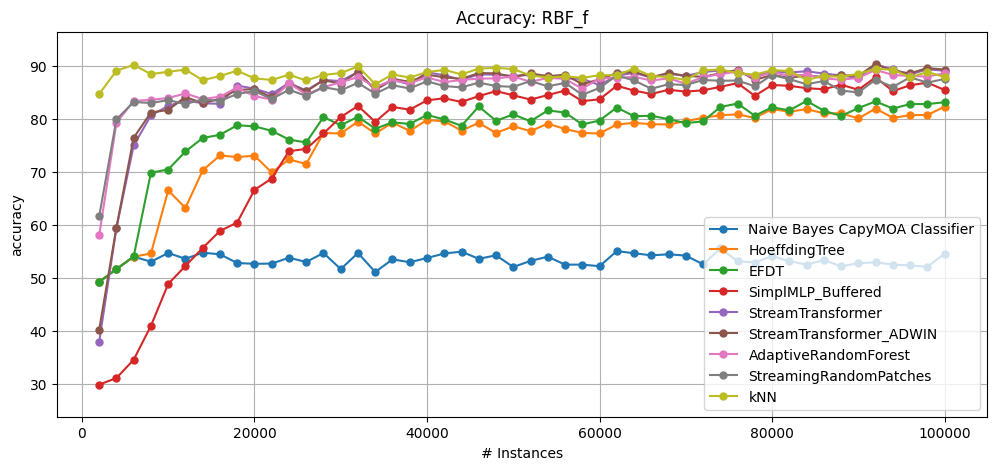


 Windowed Metrics for RBF_f:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.20  32.482767  34.409296  25.676664  45.066617   
1      4000.0     51.60  35.806103  36.482940  30.906495  48.548686   
2      6000.0     53.95  39.365351  41.037132  34.911661  50.780706   
3      8000.0     53.00  37.893657  39.315688  32.761087  48.970950   
4     10000.0     54.65  39.708360  41.521599  34.795111  51.163750   
5     12000.0     53.55  38.492890  40.257235  33.547926  51.305337   
6     14000.0     54.70  40.205637  41.321244  35.835694  51.929725   
7     16000.0     54.40  39.503090  40.932642  34.996436  49.681927   
8     18000.0     52.75  37.206090  39.655172  32.014388  47.999369   
9     20000.0     52.60  36.997973  39.732994  31.304348  49.341106   
10    22000.0     52.65  37.467500  37.901639  31.919482  50.952448   
11    24000.0     53.75  38.986624  40.012970  35.042135  50.767840   
12    26000.0     52.95  37.831837  39.795266  33.825598  49.178870   
13    28000.0     54.65  40.107147  41.521599  37.013889  51.585572   
14    30000.0     51.60  36.165106  37.588652  32.212885  49.636753   
15    32000.0     54.65  39.941789  41.858974  34.888729  52.648307   
16    34000.0     51.05  34.582328  37.082262  29.365079  46.523826   
17    36000.0     53.45  38.438955  40.473146  34.251412  49.548727   
18    38000.0     52.90  37.459045  39.421222  32.762313  49.536038   
19    40000.0     53.70  38.258352  41.131596  32.556446  49.258419   
20    42000.0     54.55  40.053872  41.203105  35.577605  50.418379   
21    44000.0     54.90  39.871958  41.618123  34.112491  51.093123   
22    46000.0     53.55  38.180908  38.313413  33.690221  48.592577   
23    48000.0     54.20  39.037153  39.816032  34.524660  49.845964   
24    50000.0     52.00  36.398843  37.540664  31.866572  48.341775   
25    52000.0     53.15  37.826420  39.470284  32.150615  50.102247   
26    54000.0     53.95  39.324246  39.921722  34.541578  51.125209   
27    56000.0     52.45  37.134877  38.286827  32.216679  50.245407   
28    58000.0     52.45  37.014758  39.695625  33.122363  49.384889   
29    60000.0     52.15  36.984501  39.199492  32.462950  49.076327   
30    62000.0     55.00  39.855332  40.436797  34.210526  51.152972   
31    64000.0     54.60  39.581241  42.091837  34.059550  50.219868   
32    66000.0     54.20  39.230698  41.394754  34.430923  50.564478   
33    68000.0     54.40  39.153960  41.312741  35.135135  50.053618   
34    70000.0     54.15  38.606419  40.647249  31.310861  49.310856   
35    72000.0     52.50  36.832271  38.311688  32.909605  48.475566   
36    74000.0     55.50  40.742220  41.715783  35.693642  51.184760   
37    76000.0     53.10  37.806904  39.755941  32.711621  48.996769   
38    78000.0     52.85  37.441102  37.342193  32.786885  48.036153   
39    80000.0     54.05  39.043945  38.774151  33.837293  50.028116   
40    82000.0     53.10  37.726865  39.327296  33.285917  49.000455   
41    84000.0     52.45  36.439255  38.526180  31.681034  48.304127   
42    86000.0     53.30  37.964684  40.623013  32.072727  49.948303   
43    88000.0     52.15  36.472659  37.695312  31.446991  49.251786   
44    90000.0     52.70  37.698766  39.007092  33.333333  50.184323   
45    92000.0     52.90  37.659326  38.188976  33.286119  48.951962   
46    94000.0     52.45  36.967500  39.233227  31.136857  49.668928   
47    96000.0     52.30  36.856214  37.565445  32.051282  49.532702   
48    98000.0     52.05  36.436058  38.839286  32.417195  49.606509   
49   100000.0     54.50  39.614468  40.947437  35.046395  51.114760   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    50.877193   45.241810   54.368932   13.740458  ...    46.031746   
1    56.221198   44.515103   51.373183   22.745098  ...    46.511628   
2    58.126195   43.917852   59.544160   23.437500  ...    44.694534   
3    57.374101   43.305785   61.627907   20.849421  ...    45.172414   
4    59.057971   41.92


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.20  32.482767  34.409296  25.676664  45.066617   
1      4000.0     51.60  35.806103  36.482940  30.906495  48.548686   
2      6000.0     53.95  39.365351  41.037132  34.911661  50.780706   
3      8000.0     54.55  40.128930  41.316979  34.978541  51.996969   
4     10000.0     66.45  56.283968  56.737589  51.761323  66.303169   
5     12000.0     63.15  51.853635  52.604502  47.281831  62.695138   
6     14000.0     70.25  61.459462  61.463731  57.861190  68.762359   
7     16000.0     73.05  65.009781  65.090674  61.582324  72.460053   
8     18000.0     72.75  64.613170  65.197957  60.791367  72.559409   
9     20000.0     73.00  64.988923  65.670693  60.869565  72.072093   
10    22000.0     69.85  60.964305  60.459016  56.649892  69.590455   
11    24000.0     72.30  64.254490  64.072633  61.095506  71.580288   
12    26000.0     71.45  63.098820  63.467690  59.845288  71.104731   
13    28000.0     77.30  70.645201  70.728562  68.472222  77.260334   
14    30000.0     77.20  70.748755  70.599613  68.067227  77.561850   
15    32000.0     79.45  73.471565  73.653846  70.495334  79.448775   
16    34000.0     77.20  70.427728  70.694087  67.099567  76.228603   
17    36000.0     79.25  73.274499  73.465473  70.692090  78.676791   
18    38000.0     77.70  71.199803  71.318328  68.165596  77.483821   
19    40000.0     79.75  73.891181  74.253020  70.502549  79.010446   
20    42000.0     79.50  73.694012  73.479948  70.942594  79.003597   
21    44000.0     77.75  71.170718  71.197411  67.494522  76.612002   
22    46000.0     79.20  73.082195  72.377158  70.306924  78.022193   
23    48000.0     77.30  70.664633  70.170828  67.548249  76.221417   
24    50000.0     78.55  72.224371  72.088484  69.552874  77.890400   
25    52000.0     77.65  71.027475  71.124031  67.632151  77.316163   
26    54000.0     79.05  73.043611  72.667971  70.220327  78.825115   
27    56000.0     78.05  71.668390  71.512005  68.709907  76.884622   
28    58000.0     77.30  70.638661  71.211160  68.073136  75.879674   
29    60000.0     77.20  70.685129  71.029225  67.819337  76.562820   
30    62000.0     78.90  72.453913  72.071476  69.152047  77.967383   
31    64000.0     79.20  72.919734  73.469388  69.789397  78.524213   
32    66000.0     78.95  72.705539  73.064619  69.863994  78.540062   
33    68000.0     78.90  72.474826  72.844273  69.985775  78.130314   
34    70000.0     79.55  73.277519  73.527508  69.363296  78.897063   
35    72000.0     80.15  74.239263  74.220779  71.963277  80.414495   
36    74000.0     80.65  74.777190  74.656189  72.037572  79.799959   
37    76000.0     80.80  75.141440  75.337187  72.453372  80.200663   
38    78000.0     80.15  74.290312  73.621262  71.703493  79.856802   
39    80000.0     81.80  76.505329  75.749500  73.794096  81.574906   
40    82000.0     81.30  75.760608  75.808538  73.399716  80.887675   
41    84000.0     81.80  76.205091  76.470588  73.850575  81.247118   
42    86000.0     81.00  75.399499  75.842339  72.363636  80.861764   
43    88000.0     81.00  75.343400  75.260417  72.779370  80.398646   
44    90000.0     80.05  74.290086  74.274662  71.881607  79.864878   
45    92000.0     81.90  76.609056  76.246719  74.362606  82.079905   
46    94000.0     80.15  74.214375  74.632588  71.252715  79.878207   
47    96000.0     80.65  75.000145  74.672775  72.435897  80.295339   
48    98000.0     80.70  75.040277  75.382653  72.797745  81.100230   
49   100000.0     82.25  77.060233  76.963011  74.660956  81.981173   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    50.877193   45.241810   54.368932   13.740458  ...    46.031746   
1    56.221198   44.515103   51.373183   22.745098  ...    46.511628   
2    58.126195   43.917852   59.544160   23.437500  ...    44.694534   
3    58.005489   45.826514   61.046512   33.451957  ...    47.297297   
4    70.265152   64.52


--- EFDT Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     49.20  32.482767  34.409296  25.676664  45.066617   
1      4000.0     51.60  35.806103  36.482940  30.906495  48.548686   
2      6000.0     54.00  39.477407  41.101152  34.982332  51.514299   
3      8000.0     69.80  60.714451  61.007101  56.795422  68.343149   
4     10000.0     70.40  61.423964  61.831077  57.440690  69.512763   
5     12000.0     73.80  66.070571  66.302251  62.517883  72.949542   
6     14000.0     76.35  69.457072  69.365285  66.501416  75.763147   
7     16000.0     76.95  70.138097  70.142487  67.141839  76.936039   
8     18000.0     78.75  72.371542  72.860792  69.424460  79.183539   
9     20000.0     78.55  72.188917  72.727273  68.913043  77.915943   
10    22000.0     77.70  71.243376  70.754098  67.936736  78.321525   
11    24000.0     76.05  69.079868  68.936446  66.362360  76.061873   
12    26000.0     75.50  68.119465  68.650032  65.541491  75.569046   
13    28000.0     80.30  74.463590  74.597034  72.638889  79.837082   
14    30000.0     78.75  72.661479  72.598324  70.238095  78.240915   
15    32000.0     80.35  74.570991  74.807692  71.787509  80.676534   
16    34000.0     78.10  71.598480  71.850900  68.398268  77.709596   
17    36000.0     79.30  73.317006  73.529412  70.762712  78.965557   
18    38000.0     79.00  72.751973  72.990354  70.021413  78.871466   
19    40000.0     80.70  75.013019  75.460903  71.886380  80.850889   
20    42000.0     79.85  74.088475  73.932730  71.438696  79.974736   
21    44000.0     78.65  72.296042  72.362460  68.809350  78.189526   
22    46000.0     82.30  77.049112  76.494024  74.732334  81.973160   
23    48000.0     79.60  73.483490  73.193167  70.836312  79.188840   
24    50000.0     80.80  75.235544  75.016265  72.746629  80.795650   
25    52000.0     79.50  73.473557  73.514212  70.311369  79.603508   
26    54000.0     81.55  76.192458  75.929550  73.773987  81.471946   
27    56000.0     81.15  75.683506  75.535367  73.129009  80.720512   
28    58000.0     78.90  72.643695  73.240330  70.323488  78.760299   
29    60000.0     79.65  73.825735  74.142313  71.277347  79.899404   
30    62000.0     82.10  76.698344  76.307081  73.830409  81.702603   
31    64000.0     80.45  74.635762  75.063776  71.604938  80.442045   
32    66000.0     80.55  74.761098  75.111964  72.154617  80.370594   
33    68000.0     79.90  73.775137  74.131274  71.408250  79.396917   
34    70000.0     79.15  72.866763  73.009709  68.764045  79.121906   
35    72000.0     79.50  73.385679  73.376623  71.045198  79.995831   
36    74000.0     82.20  76.815060  76.686313  74.277457  82.016962   
37    76000.0     82.85  77.852249  77.970456  75.394548  82.452306   
38    78000.0     80.55  74.783218  74.152824  72.273699  80.327942   
39    80000.0     82.15  76.901658  76.215856  74.298056  82.025930   
40    82000.0     81.55  76.027333  76.131953  73.755334  81.279450   
41    84000.0     83.35  78.196889  78.474467  76.077586  82.873459   
42    86000.0     81.50  76.011209  76.478067  73.090909  81.225305   
43    88000.0     80.50  74.720565  74.609375  72.063037  80.151031   
44    90000.0     82.00  76.831219  76.789168  74.630021  82.332952   
45    92000.0     83.25  78.354790  78.018373  76.274788  83.469590   
46    94000.0     81.90  76.474327  76.869010  73.787111  81.871935   
47    96000.0     82.75  77.634879  77.421466  75.427350  83.054041   
48    98000.0     82.75  77.671102  77.997449  75.687104  82.796485   
49   100000.0     83.10  78.109092  78.066191  75.874375  82.824392   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    50.877193   45.241810   54.368932   13.740458  ...    46.031746   
1    56.221198   44.515103   51.373183   22.745098  ...    46.511628   
2    56.894889   44.891122   56.983240   32.740214  ...    48.727273   
3    77.614858   60.882353   66.863905   63.188406  ...    56.712329   
4    80.151947   61.73


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     29.80  -0.390874   9.360878  -2.706657        NaN   
1      4000.0     31.05   1.820276   9.514436   1.570307        NaN   
2      6000.0     34.50   8.983534  16.133163   7.420495        NaN   
3      8000.0     40.90  17.945386  23.692705  15.450644        NaN   
4     10000.0     48.80  30.505575  33.978079  26.383896        NaN   
5     12000.0     52.20  36.170092  38.520900  31.616595        NaN   
6     14000.0     55.60  41.368375  42.487047  37.110482        NaN   
7     16000.0     58.80  45.593826  46.632124  41.268710        NaN   
8     18000.0     60.40  47.601252  49.425287  43.021583  50.346716   
9     20000.0     66.55  55.822032  57.469803  51.521739  59.014626   
10    22000.0     68.70  58.838496  58.950820  54.996405  64.376993   
11    24000.0     73.85  65.829556  66.083009  63.272472  71.191073   
12    26000.0     74.30  66.326878  67.114523  63.853727  71.454863   
13    28000.0     77.20  70.048218  70.599613  68.333333  74.658303   
14    30000.0     80.30  74.465245  74.597034  72.408964  79.725137   
15    32000.0     82.40  77.119955  77.435897  74.730797  82.158324   
16    34000.0     79.40  73.036349  73.521851  70.274170  78.099773   
17    36000.0     82.20  76.898733  77.237852  74.858757  81.637142   
18    38000.0     81.70  76.165179  76.463023  73.875803  81.058269   
19    40000.0     83.45  78.463757  78.957406  75.892207  82.498414   
20    42000.0     83.85  79.151512  79.107374  77.108434  83.407255   
21    44000.0     83.15  78.008461  78.187702  75.383492  82.067750   
22    46000.0     84.25  79.496165  79.083665  77.516060  83.587357   
23    48000.0     85.20  80.735745  80.551905  78.842030  84.388959   
24    50000.0     84.40  79.818411  79.700716  77.856636  84.083191   
25    52000.0     83.60  78.738575  78.811370  76.249095  83.224969   
26    54000.0     84.45  79.934053  79.712981  77.896233  84.163521   
27    56000.0     85.30  80.935206  80.921480  79.044904  84.621350   
28    58000.0     83.30  78.404542  78.820545  76.511955  83.263085   
29    60000.0     83.65  78.935780  79.224905  76.923077  83.846113   
30    62000.0     86.20  81.945975  81.733951  79.824561  85.845535   
31    64000.0     85.30  80.866955  81.250000  78.649237  85.156080   
32    66000.0     84.65  80.090559  80.358285  78.024338  84.520630   
33    68000.0     85.45  81.040530  81.274131  79.302987  84.900208   
34    70000.0     85.10  80.516025  80.711974  77.677903  84.327631   
35    72000.0     85.35  80.976324  80.974026  79.307910  85.892594   
36    74000.0     86.00  81.751349  81.663392  79.768786  85.277027   
37    76000.0     86.70  82.769270  82.915864  80.918221  86.272811   
38    78000.0     84.30  79.619349  79.136213  77.619387  84.178216   
39    80000.0     86.35  82.360837  81.812125  80.345572  86.072909   
40    82000.0     86.20  82.102914  82.147477  80.369844  86.425048   
41    84000.0     85.75  81.316848  81.577246  79.525862  85.160791   
42    86000.0     85.55  81.280043  81.627463  78.981818  85.513989   
43    88000.0     86.40  82.378649  82.291667  80.515759  86.127403   
44    90000.0     85.45  81.281286  81.237911  79.492600  85.429525   
45    92000.0     87.80  84.206696  83.989501  82.719547  88.025642   
46    94000.0     85.20  80.786451  81.086262  78.566256  84.973058   
47    96000.0     86.30  82.292833  82.068063  80.484330  86.223499   
48    98000.0     86.80  82.925739  83.163265  81.395349  86.808187   
49   100000.0     85.40  81.102354  81.051265  79.157744  85.077537   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0     8.695652         NaN    1.108033    3.584229  ...          NaN   
1    10.927152         NaN         NaN         NaN  ...          NaN   
2    35.728953    1.219512   23.766816         NaN  ...    33.333333   
3    44.363636   10.187668   36.666667         NaN  ...    32.758621   
4    56.131261   38.43


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     37.90  14.576003  19.819238   9.144111  33.079967   
1      4000.0     59.35  47.158159  46.653543  41.970021  57.428768   
2      6000.0     74.95  67.770106  67.925736  64.593640  74.681225   
3      8000.0     80.60  74.881008  74.951582  72.246066  80.219205   
4     10000.0     82.40  77.131557  77.304965  74.694464  81.846610   
5     12000.0     83.45  78.565959  78.713826  76.323319  83.000408   
6     14000.0     82.90  77.908803  77.849741  75.779037  82.981528   
7     16000.0     82.80  77.734404  77.720207  75.481112  82.858897   
8     18000.0     86.25  82.156072  82.439336  80.215827  86.253143   
9     20000.0     85.65  81.409605  81.754609  79.202899  85.607543   
10    22000.0     84.65  80.164634  79.868852  77.929547  84.581393   
11    24000.0     86.75  82.915383  82.814527  81.390449  86.323385   
12    26000.0     85.30  81.005672  81.190019  79.324895  84.909317   
13    28000.0     87.30  83.546324  83.623469  82.361111  86.819565   
14    30000.0     87.10  83.383264  83.365571  81.932773  86.742151   
15    32000.0     88.80  85.514585  85.641026  83.919598  88.887851   
16    34000.0     85.40  80.991427  81.233933  78.932179  84.568735   
17    36000.0     87.30  83.563668  83.759591  82.062147  86.868829   
18    38000.0     86.50  82.477693  82.636656  80.728051  86.053855   
19    40000.0     88.75  85.389587  85.696122  83.612527  88.302051   
20    42000.0     88.20  84.769467  84.734799  83.274274  88.086719   
21    44000.0     87.30  83.455582  83.559871  81.446311  86.827655   
22    46000.0     88.35  84.867639  84.528552  83.369022  88.188072   
23    48000.0     88.30  84.805012  84.625493  83.273767  87.893286   
24    50000.0     88.05  84.544154  84.450228  83.037615  87.804543   
25    52000.0     88.25  84.762004  84.819121  82.983345  87.928130   
26    54000.0     88.00  84.519365  84.344423  82.942431  87.809082   
27    56000.0     87.60  83.931595  83.906554  82.323592  86.729184   
28    58000.0     87.50  83.840666  84.147115  82.419128  87.303907   
29    60000.0     86.35  82.417571  82.655654  80.733945  86.474870   
30    62000.0     88.10  84.445004  84.248842  82.602339  87.395142   
31    64000.0     88.65  85.207428  85.522959  83.514887  88.458156   
32    66000.0     87.75  84.113099  84.325016  82.462419  87.772267   
33    68000.0     88.50  85.034577  85.199485  83.641536  87.676595   
34    70000.0     88.05  84.354389  84.530744  82.097378  87.389656   
35    72000.0     88.80  85.477466  85.454545  84.180791  88.876377   
36    74000.0     89.10  85.794205  85.723641  84.248555  88.528712   
37    76000.0     88.65  85.312482  85.420681  83.715925  88.382668   
38    78000.0     88.05  84.513524  84.119601  82.965075  87.787844   
39    80000.0     88.95  85.710475  85.276482  84.089273  88.699419   
40    82000.0     88.70  85.332485  85.381630  83.926031  88.636153   
41    84000.0     88.95  85.527727  85.714286  84.123563  88.394667   
42    86000.0     88.50  85.102503  85.378258  83.272727  88.628818   
43    88000.0     88.15  84.650463  84.570312  83.022923  87.618148   
44    90000.0     87.65  84.104726  84.074790  82.593376  87.362719   
45    92000.0     90.20  87.333751  87.139108  86.118980  90.402271   
46    94000.0     89.30  86.113535  86.325879  84.503983  89.107588   
47    96000.0     88.35  84.941365  84.751309  83.404558  88.289590   
48    98000.0     89.30  86.153873  86.352041  84.918957  89.396764   
49   100000.0     89.05  85.846400  85.788449  84.368308  88.591655   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    41.979522   20.869565   28.936170    0.970874  ...    35.820896   
1    65.513929   57.971014   62.983425   31.578947  ...    51.044084   
2    83.317445   71.086037   72.000000   71.216617  ...    65.116279   
3    86.586494   75.507020   75.482094   83.152174  ...    74.233129   
4    87.313433   78.63


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     40.15  19.120173  22.724338  12.435991  35.279662   
1      4000.0     59.45  47.313885  46.784777  42.112777  57.757335   
2      6000.0     76.40  69.650089  69.782330  66.643110  75.899041   
3      8000.0     81.15  75.597292  75.661717  73.032904  80.209488   
4     10000.0     81.65  76.165449  76.337847  73.616104  81.004881   
5     12000.0     84.10  79.425373  79.549839  77.253219  83.934851   
6     14000.0     82.90  77.958407  77.849741  75.779037  82.697080   
7     16000.0     83.75  78.931865  78.950777  76.835353  83.901907   
8     18000.0     85.45  81.132418  81.417625  79.064748  85.477118   
9     20000.0     85.55  81.284341  81.627463  79.057971  85.790232   
10    22000.0     84.00  79.326322  79.016393  76.994968  84.021781   
11    24000.0     86.60  82.721878  82.619974  81.179775  86.216374   
12    26000.0     85.15  80.791239  80.998081  79.113924  84.709579   
13    28000.0     87.25  83.479898  83.558994  82.291667  87.045693   
14    30000.0     86.60  82.752823  82.720825  81.232493  86.352471   
15    32000.0     88.85  85.602435  85.705128  83.991385  88.979480   
16    34000.0     85.45  81.086671  81.298201  79.004329  84.736367   
17    36000.0     87.50  83.819378  84.015345  82.344633  87.083896   
18    38000.0     86.95  83.059615  83.215434  81.370450  86.588423   
19    40000.0     88.30  84.811231  85.123967  82.957028  88.020149   
20    42000.0     87.80  84.273776  84.217335  82.707300  87.783846   
21    44000.0     87.50  83.749081  83.818770  81.738495  86.887749   
22    46000.0     88.60  85.184434  84.860558  83.725910  88.472115   
23    48000.0     88.55  85.125843  84.954008  83.631165  88.059024   
24    50000.0     87.85  84.258079  84.189980  82.753726  87.793808   
25    52000.0     88.55  85.175887  85.206718  83.417813  88.220380   
26    54000.0     88.00  84.502736  84.344423  82.942431  87.699597   
27    56000.0     88.30  84.856790  84.815055  83.321454  87.780119   
28    58000.0     86.50  82.543914  82.878884  81.012658  86.132936   
29    60000.0     87.40  83.779494  83.989835  82.215949  87.570958   
30    62000.0     88.60  85.104625  84.910655  83.333333  88.027711   
31    64000.0     88.85  85.469212  85.778061  83.805374  88.499002   
32    66000.0     87.80  84.193108  84.388996  82.534001  87.709698   
33    68000.0     88.65  85.219641  85.392535  83.854908  88.064374   
34    70000.0     88.05  84.380810  84.530744  82.097378  87.473698   
35    72000.0     87.90  84.299274  84.285714  82.909605  88.073645   
36    74000.0     88.55  85.080592  85.003274  83.453757  87.837670   
37    76000.0     89.20  86.021648  86.127168  84.505022  88.940323   
38    78000.0     87.30  83.538535  83.122924  81.895937  87.119150   
39    80000.0     88.25  84.798268  84.343771  83.081353  88.066451   
40    82000.0     87.70  84.063239  84.087969  82.503556  87.621688   
41    84000.0     88.15  84.488666  84.680026  82.974138  87.310264   
42    86000.0     87.85  84.273300  84.551812  82.327273  87.831487   
43    88000.0     88.20  84.716540  84.635417  83.094556  87.945596   
44    90000.0     88.05  84.611725  84.590587  83.157153  88.079078   
45    92000.0     90.35  87.533008  87.335958  86.331445  90.435564   
46    94000.0     88.95  85.644247  85.878594  83.997104  88.496375   
47    96000.0     88.55  85.186915  85.013089  83.689459  88.556891   
48    98000.0     89.55  86.484551  86.670918  85.271318  89.552935   
49   100000.0     89.25  86.102978  86.048021  84.653819  88.822360   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    42.105263   33.333333   38.039216    0.961538  ...    34.539474   
1    64.980545   55.968170   62.686567   34.328358  ...    49.530516   
2    81.663516   68.656716   75.784191   75.749319  ...    66.091954   
3    86.003683   74.603175   77.030812   80.417755  ...    74.603175   
4    86.055046   76.19


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     57.95  44.352857  45.706908  38.478420  55.889875   
1      4000.0     79.20  72.960808  72.703412  70.306924  78.847917   
2      6000.0     83.35  78.461505  78.681178  76.466431  83.550075   
3      8000.0     83.55  78.600081  78.760491  76.466381  83.480802   
4     10000.0     83.90  79.014004  79.239201  76.851186  83.689612   
5     12000.0     84.75  80.206835  80.385852  78.183119  84.620087   
6     14000.0     83.70  78.857268  78.886010  76.912181  83.228956   
7     16000.0     84.15  79.360461  79.468912  77.405560  84.454622   
8     18000.0     85.85  81.589760  81.928480  79.640288  86.161770   
9     20000.0     84.25  79.495972  79.974571  77.173913  84.561832   
10    22000.0     83.60  78.744087  78.491803  76.419842  84.150164   
11    24000.0     86.70  82.781561  82.749676  81.320225  86.504421   
12    26000.0     84.55  79.932166  80.230326  78.270042  84.245258   
13    28000.0     85.95  81.765028  81.882656  80.486111  85.923439   
14    30000.0     86.85  83.056040  83.043198  81.582633  87.063800   
15    32000.0     87.85  84.237054  84.423077  82.555635  88.417277   
16    34000.0     85.95  81.657598  81.940874  79.725830  85.456126   
17    36000.0     87.25  83.465083  83.695652  81.991525  87.135066   
18    38000.0     86.70  82.710629  82.893891  81.013562  86.489508   
19    40000.0     87.80  84.086569  84.488239  82.228696  87.685468   
20    42000.0     86.90  83.058087  83.053040  81.431609  86.673225   
21    44000.0     87.30  83.428700  83.559871  81.446311  86.793602   
22    46000.0     87.55  83.785711  83.466135  82.226981  87.666759   
23    48000.0     87.60  83.840327  83.705650  82.273052  87.176836   
24    50000.0     87.95  84.377669  84.320104  82.895671  88.339297   
25    52000.0     86.95  83.050649  83.139535  81.100652  86.911145   
26    54000.0     87.70  84.113951  83.953033  82.515991  87.469209   
27    56000.0     87.50  83.792734  83.776768  82.181041  87.203660   
28    58000.0     85.65  81.339147  81.800888  79.817159  85.357056   
29    60000.0     87.60  84.016885  84.243964  82.498236  87.825462   
30    62000.0     87.70  83.903536  83.719391  82.017544  87.618817   
31    64000.0     87.90  84.189806  84.566327  82.425563  87.706065   
32    66000.0     87.20  83.370123  83.621241  81.675018  87.112035   
33    68000.0     87.60  83.790749  84.041184  82.361309  86.967711   
34    70000.0     86.60  82.450000  82.653722  79.925094  86.535020   
35    72000.0     87.85  84.197876  84.220779  82.838983  88.094961   
36    74000.0     88.40  84.840475  84.806811  83.236994  87.889661   
37    76000.0     88.90  85.631133  85.741811  84.074605  88.643776   
38    78000.0     87.75  84.091539  83.720930  82.537420  87.804219   
39    80000.0     88.75  85.406672  85.009993  83.801296  88.822393   
40    82000.0     88.10  84.554055  84.605433  83.072546  88.101074   
41    84000.0     88.30  84.657307  84.873950  83.189655  87.899023   
42    86000.0     87.60  83.928742  84.233948  81.963636  87.913909   
43    88000.0     87.35  83.573226  83.528646  81.876791  87.433184   
44    90000.0     87.70  84.127235  84.139265  82.663848  87.588722   
45    92000.0     89.20  86.021869  85.826772  84.702550  89.340739   
46    94000.0     88.25  84.740136  84.984026  82.983345  88.115751   
47    96000.0     88.05  84.540215  84.358639  82.977208  87.971407   
48    98000.0     87.95  84.407678  84.630102  83.016209  87.950979   
49   100000.0     88.55  85.148020  85.139520  83.654532  88.569981   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    60.233298   51.030111   60.365854   39.333333  ...    52.786885   
1    85.265226   72.868217   74.927114   81.081081  ...    74.132492   
2    90.277778   79.331307   79.132791   86.956522  ...    77.678571   
3    87.749288   76.629571   82.093664   86.705202  ...    76.751592   
4    88.000000   78.32


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     61.55  48.750724  50.355068  43.745428  60.530349   
1      4000.0     79.85  73.762807  73.556430  71.234832  80.273403   
2      6000.0     83.15  78.150147  78.425096  76.183746  83.457548   
3      8000.0     82.95  77.735839  77.985797  75.608011  83.105892   
4     10000.0     83.50  78.468483  78.723404  76.276060  83.399679   
5     12000.0     82.75  77.501653  77.813505  75.321888  83.021313   
6     14000.0     83.65  78.733990  78.821244  76.841360  83.535984   
7     16000.0     83.35  78.291523  78.432642  76.265146  83.454908   
8     18000.0     84.65  79.972183  80.395913  77.913669  85.002900   
9     20000.0     85.20  80.697675  81.182454  78.550725  85.587143   
10    22000.0     83.70  78.793251  78.622951  76.563623  84.071980   
11    24000.0     85.45  81.091243  81.128405  79.564607  85.324052   
12    26000.0     84.30  79.566650  79.910429  77.918425  84.214679   
13    28000.0     85.95  81.741758  81.882656  80.486111  85.960818   
14    30000.0     85.35  81.045959  81.108962  79.481793  85.718648   
15    32000.0     86.75  82.774171  83.012821  80.976310  87.227692   
16    34000.0     84.70  79.981388  80.334190  77.922078  84.581557   
17    36000.0     86.30  82.196370  82.480818  80.649718  85.964239   
18    38000.0     85.70  81.354182  81.607717  79.586010  85.440893   
19    40000.0     87.05  83.074119  83.534647  81.136198  86.995913   
20    42000.0     86.15  82.040276  82.082794  80.368533  86.070176   
21    44000.0     85.90  81.560535  81.747573  79.401023  85.888142   
22    46000.0     86.80  82.765020  82.470120  81.156317  86.771805   
23    48000.0     86.15  81.894863  81.800263  80.200143  85.954456   
24    50000.0     86.00  81.797988  81.782694  80.127750  86.315915   
25    52000.0     87.10  83.197579  83.333333  81.317886  87.010537   
26    54000.0     86.10  81.968145  81.865623  80.241649  86.145886   
27    56000.0     86.75  82.767035  82.803374  81.111903  86.309369   
28    58000.0     84.50  79.830150  80.342422  78.199719  84.274404   
29    60000.0     85.80  81.676834  81.956798  79.957657  86.194144   
30    62000.0     88.15  84.477267  84.315023  82.675439  87.854409   
31    64000.0     87.20  83.267739  83.673469  81.408860  86.892851   
32    66000.0     85.65  81.341937  81.637876  79.455977  85.553046   
33    68000.0     86.50  82.333624  82.625483  80.796586  86.204925   
34    70000.0     86.35  82.068165  82.330097  79.550562  86.055368   
35    72000.0     87.30  83.453944  83.506494  82.062147  87.845122   
36    74000.0     87.15  83.171553  83.169614  81.430636  87.015985   
37    76000.0     87.20  83.358480  83.558125  81.635581  87.011068   
38    78000.0     86.10  81.951058  81.528239  80.185317  85.940286   
39    80000.0     88.25  84.761085  84.343771  83.081353  88.221003   
40    82000.0     87.45  83.668939  83.764554  82.147937  87.474933   
41    84000.0     86.50  82.251397  82.546865  80.603448  86.251020   
42    86000.0     87.10  83.235454  83.598220  81.236364  87.262581   
43    88000.0     85.30  80.865180  80.859375  78.939828  85.202254   
44    90000.0     84.95  80.511562  80.593166  78.787879  85.295393   
45    92000.0     87.35  83.582074  83.398950  82.082153  87.962401   
46    94000.0     86.00  81.753210  82.108626  79.724837  85.898092   
47    96000.0     87.80  84.160678  84.031414  82.621083  88.343989   
48    98000.0     86.80  82.867700  83.163265  81.395349  86.947105   
49   100000.0     87.50  83.759606  83.776768  82.155603  87.724521   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    65.369650   55.195911   60.596026   46.366782  ...    62.068966   
1    83.131407   74.425727   78.325859   84.330484  ...    74.769231   
2    87.124879   78.627145   80.164159   87.465181  ...    78.996865   
3    87.323944   76.518883   81.985816   86.549708  ...    79.251701   
4    87.617261   78.31


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     84.65  80.088938  80.180762  77.542063  84.271092   
1      4000.0     89.05  85.866267  85.629921  84.368308  89.111464   
2      6000.0     90.15  87.331092  87.387964  86.077739  90.160724   
3      8000.0     88.40  84.981768  85.022595  83.404864  88.112312   
4     10000.0     88.85  85.511978  85.622179  83.968368  88.146079   
5     12000.0     89.25  86.067071  86.173633  84.620887  88.965947   
6     14000.0     87.25  83.552250  83.484456  81.940510  87.001062   
7     16000.0     88.05  84.519753  84.520725  82.965075  87.991701   
8     18000.0     89.05  85.817155  86.015326  84.244604  88.892381   
9     20000.0     87.60  83.961176  84.233948  82.028986  87.381091   
10    22000.0     87.30  83.600905  83.344262  81.739756  87.296635   
11    24000.0     88.30  84.908454  84.824903  83.567416  87.890034   
12    26000.0     87.20  83.444255  83.621241  81.997187  86.553921   
13    28000.0     88.25  84.754619  84.848485  83.680556  87.732586   
14    30000.0     88.60  85.341259  85.299807  84.033613  88.107831   
15    32000.0     89.85  86.869166  86.987179  85.427136  89.897685   
16    34000.0     86.50  82.428344  82.647815  80.519481  85.781774   
17    36000.0     88.35  84.939798  85.102302  83.545198  87.809021   
18    38000.0     87.75  84.112048  84.244373  82.512491  87.039308   
19    40000.0     88.80  85.446872  85.759695  83.685361  88.736472   
20    42000.0     89.20  86.069023  86.028461  84.691708  88.936779   
21    44000.0     88.35  84.817949  84.919094  82.980278  87.990743   
22    46000.0     89.45  86.280443  85.989376  84.939329  89.202082   
23    48000.0     89.60  86.482816  86.333771  85.132237  89.146684   
24    50000.0     89.35  86.235188  86.141835  84.882896  88.965430   
25    52000.0     88.15  84.658243  84.689922  82.838523  87.922876   
26    54000.0     87.75  84.200724  84.018265  82.587065  87.427270   
27    56000.0     88.00  84.458123  84.425698  82.893799  87.374142   
28    58000.0     87.70  84.071654  84.400761  82.700422  87.418756   
29    60000.0     88.20  84.817093  85.006353  83.345095  88.388884   
30    62000.0     88.20  84.607658  84.381205  82.748538  87.581910   
31    64000.0     89.45  86.251685  86.543367  84.676834  89.024723   
32    66000.0     88.05  84.526453  84.708893  82.891911  88.048868   
33    68000.0     87.85  84.174809  84.362934  82.716927  87.247293   
34    70000.0     87.30  83.413453  83.559871  80.973783  86.790423   
35    72000.0     89.10  85.867154  85.844156  84.604520  88.916514   
36    74000.0     89.30  86.038199  85.985593  84.537572  88.650446   
37    76000.0     88.60  85.260873  85.356455  83.644189  87.976270   
38    78000.0     88.30  84.846179  84.451827  83.321454  88.026718   
39    80000.0     89.15  85.959995  85.542971  84.377250  88.928380   
40    82000.0     89.00  85.772715  85.769728  84.352774  88.582641   
41    84000.0     87.30  83.374951  83.581125  81.752874  86.405137   
42    86000.0     88.10  84.600637  84.869676  82.690909  88.175536   
43    88000.0     87.90  84.315744  84.244792  82.664756  87.503293   
44    90000.0     88.45  85.157523  85.106383  83.720930  88.037957   
45    92000.0     89.40  86.300852  86.089239  84.985836  89.355948   
46    94000.0     89.25  86.065333  86.261981  84.431571  88.546179   
47    96000.0     87.80  84.231788  84.031414  82.621083  87.617565   
48    98000.0     88.80  85.527397  85.714286  84.214235  88.597414   
49   100000.0     87.85  84.269651  84.231019  82.655246  87.495571   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_1  \
0    86.584206   80.254777   84.023669   84.422111  ...    83.443709   
1    89.648799   86.494689   88.078541   91.191710  ...    86.102719   
2    91.165414   88.750000   89.445910   90.864198  ...    89.308176   
3    90.777577   83.197390   89.226519   88.831169  ...    85.570470   
4    90.826521   84.55


==================== DATASET: Electricity ====================
Config: Evaluation Interval = 2000


electricity.arff: 704kB [00:00, 744kB/s]                    


[1/3] Running Drift Analysis...
 - ABCD            | Drifts: 15
 - ADWIN           | Drifts: 61
 - CUSUM           | Drifts: 4
 - DDM             | Drifts: 6
 - EWMAChart       | Drifts: 1
 - HDDMAverage     | Drifts: 2
 - HDDMWeighted    | Drifts: 2
 - PageHinkley     | Drifts: 4
 - RDDM            | Drifts: 15
 - SEED            | Drifts: 22
 - STEPD           | Drifts: 643

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: Electricity


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                              
NaiveBayes               Electricity         73.36  42.5414      0.24
HoeffdingTree            Electricity         81.73  62.4954      0.28
EFDT                     Electricity         82.26  63.5187      0.55
Simple_MLP               Electricity         63.66  22.5681     41.90
StreamTransformer        Electricity         89.86  79.1567    172.21
StreamTransformer_ADWIN  Electricity         90.57  80.5645    164.96
ARF                      Electricity         89.33  78.0455      9.61
SRP                      Electricity         89.09  77.5236     13.99
KNN                      Electricity         84.08  67.3554      5.44

Results for Electricity saved to thesis_results.csv



 Windowed Metrics for Electricity:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      2000.0     80.90  59.544869  -36.428571  51.522843  79.833587   
1      4000.0     80.75  57.297852   -8.450704  51.995012  80.422478   
2      6000.0     78.65  51.113961  -36.858974  44.689119  77.659843   
3      8000.0     72.80  43.953580  -50.276243  42.494715  75.584110   
4     10000.0     84.00  68.003360   -1.587302  68.000000  84.013176   
5     12000.0     74.50  48.914176  -60.883281  44.745395  74.483112   
6     14000.0     79.35  58.710653  -71.369295  59.068385  80.396229   
7     16000.0     73.15  41.658337  -73.786408  37.919075  72.803131   
8     18000.0     73.70  43.021795  -75.919732  32.041344  71.682122   
9     20000.0     74.55  46.597898  -97.286822  41.019699  73.869013   
10    22000.0     64.55  18.978281  -91.621622   1.253482  59.668949   
11    24000.0     66.40  22.052343 -124.749164  18.347509  66.225704   
12    26000.0     73.95  41.194397 -103.515625  36.385836  74.127137   
13    28000.0     67.30  24.140491 -230.303030  20.243902  67.202291   
14    30000.0     62.60   4.526930 -233.928571   3.732304  63.246530   
15    32000.0     62.35   6.841750 -156.996587   5.639098  62.971831   
16    34000.0     59.15   3.309032 -215.444015   2.738095  60.315632   
17    36000.0     70.65  23.833498 -112.681159  19.257221  68.956369   
18    38000.0     76.40  43.520402  -55.263158  31.594203  72.611548   
19    40000.0     79.20  58.500429  -50.180505  58.358358  79.507290   
20    42000.0     77.60  55.638250  -30.232558  53.478712  79.177308   
21    44000.0     79.90  56.241945  -29.260450  54.266212  80.001620   
22    45312.0     75.85  46.074009  -54.807692  41.947115  76.916425   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    74.934383   84.571890  80.288221    78.005464    82.570978  79.384073   
1    70.498084   85.714286  84.302800    91.451292    77.154309  76.883646   
2    64.913722   84.656845  82.259836    88.764045    75.755627  73.547071   
3    61.198288   79.060816  80.297246    94.078947    66.515544  71.393584   
4    84.126984   83.870968  84.006100    85.226131    82.786070  84.020253   
5    73.242392   75.644699  74.430072    71.516393    77.343750  74.536228   
6    81.701374   76.305221  81.456790    73.290938    89.622642  79.362929   
7    59.532781   79.910213  76.277412    82.291667    70.263158  69.631555   
8    63.319386   79.501169  72.453641    68.787879    76.119403  70.926860   
9    66.535174   79.467527  75.148805    76.899696    73.397914  72.632082   
10   44.392157   73.981651  60.331185    50.807899    69.854470  59.021093   
11   35.632184   77.266576  74.178131    84.162896    64.193367  59.813291   
12   56.181665   81.465671  80.257835    90.270270    70.245399  68.866588   
13   37.950664   77.800407  75.181249    85.470085    64.892412  60.754444   
14    7.196030   76.581090  81.024860   100.000000    62.049721  51.866152   
15   11.307420   76.102825  77.818187    94.117647    61.518728  52.882727   
16    6.199770   73.889422  72.903390    87.096774    58.710005  51.434729   
17   33.821871   81.143591  81.195652    93.750000    68.641304  59.923596   
18   59.310345   83.380282  75.288555    73.191489    77.385621  70.118376   
19   78.242678   80.076628  79.680130    84.044944    75.315315  79.335198   
20   74.689266   79.910314  80.250476    90.177353    70.323599  78.132463   
21   70.178042   84.841629  83.737646    91.666667    75.808625  76.584727   
22   60.115607   82.681965  83.585575    96.042216    71.128933  71.232877   

     recall_0    recall_1  
0   72.095960   86.672185  
1   57.356608   96.410684  
2   51.165803   95.928339  
3   45.348837   97.438330  
4   83.055828   84.984678  
5   75.053763   74.018692  
6   92.292292   66.433566  
7   46.635183   92.627927  
8   58.656331   83.197390  
9   58.632677   86.631486  
10  39.415042   78.627145  
11  22.600243   97.026338  
12  40.781441   96.951736  
13  24.390


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      2000.0     88.90  77.231703   20.714286  71.827411  88.774634   
1      4000.0     86.55  71.973503   24.225352  66.458853  85.987243   
2      6000.0     83.45  65.376424   -6.089744  57.124352  82.710345   
3      8000.0     86.95  73.676832   27.900552  72.410148  87.039140   
4     10000.0     88.80  77.559000   28.888889  77.600000  88.864582   
5     12000.0     87.30  74.341361   19.873817  72.481040  87.275149   
6     14000.0     84.65  69.302456  -27.385892  69.573835  84.765478   
7     16000.0     80.75  59.176489  -24.595469  55.491329  80.434319   
8     18000.0     83.65  65.316889   -9.364548  57.751938  82.672006   
9     20000.0     85.15  68.732168  -15.116279  65.585168  85.422371   
10    22000.0     84.90  66.988619   18.378378  57.938719  83.502451   
11    24000.0     76.25  48.468483  -58.862876  42.284326  75.338113   
12    26000.0     79.80  58.200338  -57.812500  50.671551  79.100421   
13    28000.0     82.80  64.593026  -73.737374  58.048780  82.304847   
14    30000.0     74.25  43.594405 -129.910714  33.719434  72.185109   
15    32000.0     76.65  49.714330  -59.385666  41.478697  75.201081   
16    34000.0     78.00  55.109370  -69.884170  47.619048  77.573398   
17    36000.0     71.75  39.644361 -104.710145  22.283356  69.839884   
18    38000.0     71.90  42.771023  -84.868421  18.550725  72.136631   
19    40000.0     76.20  52.096483  -71.841155  52.352352  77.042392   
20    42000.0     84.65  69.160792   10.755814  68.120457  84.707292   
21    44000.0     82.75  64.006410  -10.932476  60.750853  82.113492   
22    45312.0     83.65  65.533960   -4.807692  60.697115  83.118035   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    86.722488   90.463918  88.202110    82.386364    94.017857  89.354639   
1    83.176986   88.796335  86.024848    83.437892    88.611804  85.949671   
2    79.037365   86.327964  82.458860    77.323420    87.594300  82.963368   
3    85.410844   88.195387  87.449185    90.628707    84.269663  86.632922   
4    89.373814   88.160677  89.003870    86.660534    91.347207  88.725728   
5    85.778275   88.527552  87.575158    89.485981    85.664336  86.977188   
6    85.233285   84.018740  84.877214    82.037037    87.717391  84.654035   
7    73.898305   84.752475  82.385889    86.783439    77.988338  78.573067   
8    78.500986   86.809197  82.896791    79.919679    85.873903  82.448436   
9    80.160321   88.134239  87.691965    94.637224    80.746706  83.267294   
10   78.672316   88.312693  83.716918    79.799427    87.634409  83.289081   
11   65.604634   81.863307  77.761994    81.182796    74.341193  73.060771   
12   75.275398   82.924768  79.122466    75.460123    82.784810  79.078387   
13   79.302046   85.286570  82.181376    78.266033    86.096718  82.428690   
14   62.869503   80.290853  73.471518    71.475410    75.467626  70.942973   
15   67.681661   81.722114  76.370730    75.579598    77.161863  74.066718   
16   74.358974   80.735552  77.429760    72.831050    82.028470  77.717570   
17   62.156731   77.463103  69.630804    60.574413    78.687196  70.050223   
18   65.563725   76.266892  71.071886    56.794055    85.349716  73.233765   
19   79.393939   71.834320  78.224231    71.195652    85.252809  75.895734   
20   85.780454   83.324280  84.944413    82.531194    87.357631  84.471491   
21   78.233438   85.714286  82.668258    82.337317    82.999198  81.566122   
22   78.585462   86.777194  84.276579    86.330935    82.222222  81.990911   

     recall_0   recall_1  
0   91.540404  87.168874  
1   82.917706  88.981636  
2   80.829016  85.097720  
3   80.761099  92.504744  
4   92.262488  85.188968  
5   82.365591  91.588785  
6   88.688689  80.619381  
7   64.344746  92.801388  
8   77.131783  87.765090  
9   69.524913  97.009675  
10  77.576602  89.001560  
11  55.042527  91.079014  
12  75.091575  83.065199  
13  80.365854  84.491525


--- EFDT Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      2000.0     90.75  80.809447   33.928571  76.522843  90.431482   
1      4000.0     87.95  74.755357   32.112676  69.950125  87.397531   
2      6000.0     81.15  60.088758  -20.833333  51.165803  80.048220   
3      8000.0     83.90  67.604069   11.049724  65.961945  83.859808   
4     10000.0     88.80  77.542937   28.888889  77.600000  88.967919   
5     12000.0     88.45  76.748634   27.129338  74.972914  88.384613   
6     14000.0     85.20  70.402338  -22.821577  70.664024  85.314368   
7     16000.0     81.60  61.061209  -19.093851  57.456647  81.294560   
8     18000.0     83.75  65.709848   -8.695652  58.010336  82.855386   
9     20000.0     87.30  73.423985    1.550388  70.567787  87.433193   
10    22000.0     83.25  62.204717    9.459459  53.342618  81.404272   
11    24000.0     79.25  55.201389  -38.795987  49.574727  78.592197   
12    26000.0     79.25  56.549598  -62.109375  49.328449  78.345516   
13    28000.0     83.15  64.705389  -70.202020  58.902439  82.443404   
14    30000.0     79.10  54.890447  -86.607143  46.203346  77.630595   
15    32000.0     75.40  47.558485  -67.918089  38.345865  73.930090   
16    34000.0     74.00  46.598751 -100.772201  38.095238  73.299574   
17    36000.0     75.30  46.934843  -78.985507  32.049519  73.472974   
18    38000.0     75.60  49.444721  -60.526316  29.275362  75.267579   
19    40000.0     80.10  60.017038  -43.682310  60.160160  80.548284   
20    42000.0     86.40  72.726334   20.930233  71.754933  86.386893   
21    44000.0     81.10  60.362068  -21.543408  56.996587  80.378838   
22    45312.0     79.80  57.739878  -29.487179  51.442308  79.012261   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    88.573193   92.230155  90.152525    86.698912    93.606138  90.712171   
1    84.678957   90.070045  87.657708    86.381323    88.934093  87.138893   
2    75.343362   84.743019  80.160763    76.089828    84.231698  79.935993   
3    82.442748   85.133887  84.024402    85.135135    82.913669  83.695857   
4    89.542484   87.944026  89.247574    85.548617    92.946530  88.690012   
5    87.425150   89.320388  88.457116    88.533627    88.380604  88.312230   
6    85.755534   84.599376  85.425038    82.576460    88.273616  85.203985   
7    75.268817   85.350318  83.122513    87.363495    78.881531  79.545275   
8    78.937135   86.772487  82.895011    79.193758    86.596263  82.815800   
9    83.506494   89.674797  89.174485    94.977843    83.371126  85.758603   
10   74.524715   87.523277  82.913080    82.077052    83.749109  79.949396   
11   70.504620   83.995372  80.919143    84.931507    76.906780  76.395340   
12   73.583705   82.914780  78.775402    76.861702    80.689103  77.920297   
13   78.521351   86.137392  82.968018    82.242991    83.693046  81.925382   
14   71.132597   83.620690  78.518524    76.751118    80.285929  76.762524   
15   67.024129   80.382775  74.614173    72.046110    77.182236  73.258437   
16   68.973747   77.624785  73.315082    69.138756    77.491409  73.284072   
17   66.485753   80.443389  73.340556    65.595716    81.085395  73.605872   
18   69.074778   79.851363  74.167153    61.373874    86.960432  76.401151   
19   82.152466   77.514124  81.221988    75.827815    86.616162  79.885665   
20   87.109005   85.608466  86.459241    85.647717    87.270766  86.314665   
21   75.706941   84.533552  81.154852    81.353591    80.956113  79.617525   
22   74.267516   83.374486  79.633352    78.997290    80.269414  78.400784   

     recall_0   recall_1  
0   90.530303  90.894040  
1   83.042394  91.235392  
2   74.611399  85.260586  
3   79.915433  87.476281  
4   93.927522  83.452503  
5   86.344086  90.280374  
6   89.189189  81.218781  
7   66.115702  92.974848  
8   78.682171  86.949429  
9   74.507532  97.009675  
10  68.245125  91.653666  
11  60.267315  92.523364  
12  70.573871  85.266723  
13  75.121951  88.728814


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      2000.0     59.00   0.589673 -192.857143  -4.060914  50.543244   
1      4000.0     59.35  -0.898280 -129.014085  -1.371571  44.530045   
2      6000.0     61.40   0.000000 -147.435897   0.000000        NaN   
3      8000.0     54.40   4.896972 -151.933702   3.594080  53.909230   
4     10000.0     58.05  15.134056 -166.349206  16.100000  58.997502   
5     12000.0     57.95  14.200308 -165.299685   8.884074  57.278161   
6     14000.0     60.35  20.682074 -229.045643  21.407334  60.615669   
7     16000.0     57.85   8.897957 -172.815534   2.543353  54.803124   
8     18000.0     64.45  12.508029 -137.792642   8.139535  60.314903   
9     20000.0     66.70  30.015479 -158.139535  22.827346  65.423205   
10    22000.0     71.15  34.400957  -55.945946  19.637883  67.453829   
11    24000.0     65.90  24.842605 -128.093645  17.132442  63.516492   
12    26000.0     67.50  31.412243 -153.906250  20.634921  65.812098   
13    28000.0     62.65  22.582651 -277.272727   8.902439  61.292720   
14    30000.0     67.40  25.628592 -191.071429  16.087516  63.928153   
15    32000.0     63.15  16.804949 -151.535836   7.644110  59.304573   
16    34000.0     65.90  30.237316 -163.320463  18.809524  65.121861   
17    36000.0     57.75   6.176579 -206.159420 -16.231087  53.105609   
18    38000.0     65.95  16.179457 -124.013158   1.304348  58.778462   
19    40000.0     68.20  36.805959 -129.602888  36.336336  69.378253   
20    42000.0     69.75  38.651053  -75.872093  37.175493  70.587373   
21    44000.0     67.80  33.775379 -107.073955  26.734926  66.887834   
22    45312.0     70.85  37.913731  -86.858974  29.927885  69.392901   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    13.684211   73.114754  50.835635    41.139241    60.532030  50.254198   
1     0.974421   74.425920  40.384973    21.052632    59.717314  49.623333   
2          NaN   76.084263        NaN          NaN    61.400000  50.000000   
3    23.102867   67.590618  55.558712    57.083333    54.034091  52.354867   
4    67.264924   41.614475  60.592635    55.901427    65.283843  57.484201   
5    48.937462   64.258394  57.565406    56.206416    58.924396  56.993769   
6    55.273548   64.391558  60.895182    63.307494    58.482871  60.338710   
7    37.969095   68.080273  55.403646    50.390625    60.416667  54.215480   
8    24.761905   76.726678  66.249892    68.421053    64.078732  55.355856   
9    55.894040   73.253012  66.314938    65.224111    67.405765  64.555135   
10   55.305964   78.700628  68.502919    62.303665    74.702172  66.436387   
11   47.538462   74.740741  65.515347    64.779874    66.250821  61.635994   
12   57.516340   73.684211  66.241016    61.884669    70.597362  65.388699   
13   54.030769   68.547368  61.325658    54.534161    68.117155  61.259818   
14   46.732026   76.512968  66.182938    63.982103    68.383773  61.821943   
15   40.227088   73.364655  60.933862    57.011494    64.856230  57.760145   
16   59.882353   70.347826  65.075479    59.186047    70.964912  65.168309   
17   38.004402   67.956011  53.206210    40.723270    65.689150  53.005389   
18   37.235023   76.638079  60.367128    51.139241    69.595016  57.271269   
19   63.236994   71.982379  70.247591    77.259887    63.235294  68.530169   
20   74.906678   61.925739  72.157387    65.720524    78.594249  69.084226   
21   61.390887   72.384220  66.876305    61.244019    72.508591  66.899368   
22   60.313138   76.965626  70.502378    69.544741    71.460015  68.317802   

     recall_0    recall_1  
0    8.207071   92.301325  
1    0.498753   98.747913  
2    0.000000  100.000000  
3   14.482030   90.227704  
4   84.427032   30.541369  
5   43.333333   70.654206  
6   49.049049   71.628372  
7   30.460449   77.970512  
8   15.116279   95.595432  
9   48.899189   80.211082  
10  49.721448   83.151326  
11  37.545565   85.726423  
12  53.724054   77.053345  
13  53.536


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      2000.0     70.05  33.379304 -113.928571  23.984772  67.595743   
1      4000.0     85.80  69.640345   20.000000  64.588529  85.154805   
2      6000.0     86.75  72.240496   15.064103  65.673575  86.137049   
3      8000.0     88.65  77.207691   37.292818  76.004228  88.612435   
4     10000.0     95.55  91.092518   71.746032  91.100000  95.554496   
5     12000.0     92.45  84.826713   52.365931  83.640303  92.413378   
6     14000.0     94.00  88.000108   50.207469  88.107037  94.002254   
7     16000.0     93.10  85.784583   55.339806  84.046243  92.925264   
8     18000.0     89.80  78.357642   31.772575  73.643411  89.196239   
9     20000.0     90.15  79.704991   23.643411  77.172654  89.978912   
10    22000.0     83.90  65.060916   12.972973  55.153203  82.530769   
11    24000.0     89.30  77.907876   28.428094  73.997570  88.953938   
12    26000.0     91.40  82.263891   32.812500  78.998779  91.136245   
13    28000.0     91.45  82.402700   13.636364  79.146341  91.212927   
14    30000.0     86.35  70.602171  -21.875000  64.864865  85.497701   
15    32000.0     87.80  74.345926   16.723549  69.423559  87.206119   
16    34000.0     88.85  77.296791   13.899614  73.452381  88.696689   
17    36000.0     89.25  76.637647   22.101449  70.426410  88.327079   
18    38000.0     94.30  87.448252   62.500000  83.478261  93.729353   
19    40000.0     96.00  91.996831   71.119134  91.991992  95.998784   
20    42000.0     96.60  93.184112   80.232558  92.938733  96.607887   
21    44000.0     94.15  87.899523   62.379421  86.689420  93.969585   
22    45312.0     93.35  86.148488   57.371795  84.014423  93.186231   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    54.169855   77.757148  69.621457    68.737864    70.505051  65.684578   
1    80.758808   88.748019  86.445927    88.427300    84.464555  83.901682   
2    83.153210   89.081170  85.903203    81.647940    90.158465  86.372171   
3    87.867451   89.337717  88.664991    88.864865    88.465116  88.559941   
4    95.681708   95.410005  95.580929    94.807692    96.354167  95.528078   
5    91.886083   92.940626  92.410416    91.836735    92.984097  92.416340   
6    94.023904   93.975904  94.004014    93.557978    94.450050  94.000494   
7    91.666667   94.112628  93.215391    93.819530    92.611251  92.636938   
8    86.578947   91.774194  89.476677    88.203753    90.749601  88.917553   
9    88.053366   91.620587  90.540702    92.366412    88.714992  89.424050   
10   77.638889   87.421875  82.491254    77.423823    87.558685  82.570322   
11   86.998785   90.909091  88.953938    86.998785    90.909091  88.953938   
12   89.588378   92.674617  91.033020    88.835534    93.230506  91.239704   
13   89.717378   92.682927  91.048812    88.493476    93.604149  91.377635   
14   81.262869   89.264648  86.521836    87.058824    85.984848  84.497528   
15   84.318766   90.016367  87.555182    86.543536    88.566828  86.859828   
16   87.102371   90.180537  88.435565    84.701912    92.169217  88.959360   
17   85.017422   91.617934  88.551232    86.158192    90.944272  88.104057   
18   91.822095   95.625480  93.525533    90.909091    96.141975  93.934064   
19   96.078431   95.918367  95.995102    96.267191    95.723014  96.002465   
20   96.761905   96.421053  96.668678    95.578551    97.758805  96.547173   
21   92.844037   95.052854  94.210984    94.520548    93.901420  93.729419   
22   91.661442   94.469854  93.820557    95.806029    91.835085  92.560425   

     recall_0   recall_1  
0   44.696970  86.672185  
1   74.314214  93.489149  
2   84.715026  88.029316  
3   86.892178  90.227704  
4   96.571988  94.484168  
5   91.935484  92.897196  
6   94.494494  93.506494  
7   89.610390  95.663487  
8   85.012920  92.822186  
9   84.125145  94.722955  
10  77.855153  87.285491  
11  86.998785  90.909091  
12  90.354090  92.125318  
13  90.975610  91.779661


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     75.65  46.892503 -73.928571  38.197970  73.989594   
1      4000.0     89.40  77.742315  40.281690  73.566085  88.909230   
2      6000.0     87.75  74.261786  21.474359  68.264249  87.136858   
3      8000.0     87.90  75.623612  33.149171  74.418605  87.935326   
4     10000.0     96.10  92.194919  75.238095  92.200000  96.099768   
5     12000.0     91.10  82.026375  43.848580  80.715060  91.110315   
6     14000.0     96.20  92.399947  68.464730  92.467790  96.200805   
7     16000.0     90.60  80.430508  39.158576  78.265896  90.454061   
8     18000.0     86.60  71.334200  10.367893  65.374677  85.746656   
9     20000.0     89.65  78.602307  19.767442  76.013905  89.518013   
10    22000.0     90.90  80.263900  50.810811  74.651811  90.132807   
11    24000.0     93.40  86.368101  55.852843  83.961118  93.184143   
12    26000.0     89.30  78.006867  16.406250  73.870574  89.024614   
13    28000.0     93.55  86.635725  34.848485  84.268293  93.321801   
14    30000.0     89.50  77.733834   6.250000  72.972973  88.889468   
15    32000.0     91.05  81.207941  38.907850  77.568922  90.628480   
16    34000.0     89.30  77.775008  17.374517  74.523810  88.997201   
17    36000.0     85.70  67.159315  -3.623188  60.660248  84.526243   
18    38000.0     94.40  87.523672  63.157895  83.768116  93.772775   
19    40000.0     96.10  92.196223  71.841155  92.192192  96.098111   
20    42000.0     95.50  90.983653  73.837209  90.654206  95.495115   
21    44000.0     89.30  77.543653  31.189711  75.654152  89.044098   
22    45312.0     95.05  89.768246  68.269231  88.100962  94.899139   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    65.039483   81.319524  75.571391    75.374376    75.768406  72.472657   
1    86.427657   91.304348  89.286927    88.815789    89.758065  88.534715   
2    84.304933   89.954900  86.991499    83.396705    90.586292  87.282704   
3    86.644592   88.939671  88.224560    90.646651    85.802469  87.647982   
4    96.198830   95.995893  96.111763    95.732299    96.491228  96.087775   
5    90.066964   91.938406  91.405527    93.619490    89.191564  90.817003   
6    96.184739   96.215139  96.201914    96.475327    95.928500  96.199696   
7    88.176101   92.199170  91.366142    94.347241    88.385044  89.560010   
8    81.965007   89.339698  86.361574    85.533708    87.189441  85.140433   
9    87.261538   91.284211  90.302601    93.044619    87.560582  88.746941   
10   87.378641   92.885066  90.060011    87.016575    93.103448  90.205720   
11   91.970803   94.397284  93.200022    92.082826    94.317218  93.168269   
12   87.185629   90.815451  88.813243    85.546416    92.080070  89.236993   
13   92.071297   94.563843  93.430752    92.812887    94.048617  93.213105   
14   86.202365   91.525424  89.206129    88.053691    90.358566  88.575049   
15   88.547665   92.654904  90.937260    90.457516    91.417004  90.321790   
16   86.691542   91.053512  89.574033    90.755208    88.392857  88.427750   
17   77.192982   89.584851  87.671831    91.840607    83.503055  81.598559   
18   91.764706   95.757576  94.085961    93.134328    95.037594  93.461666   
19   96.183953   96.012270  96.098111    96.183953    96.012270  96.098111   
20   95.685523   95.297806  95.518640    95.138227    95.899054  95.471601   
21   86.211340   91.258170  90.091146    92.916667    87.265625  88.021108   
22   93.959732   95.806861  95.109068    95.415118    94.803018  94.690134   

     recall_0   recall_1  
0   57.196970  87.748344  
1   84.164589  92.904841  
2   85.233161  89.332248  
3   82.980973  92.314991  
4   96.669931  95.505618  
5   86.774194  94.859813  
6   95.895896  96.503497  
7   82.762692  96.357329  
8   78.682171  91.598695  
9   82.155272  95.338610  
10  87.743733  92.667707  
11  91.859052  94.477485  
12  88.888889  89.585097  
13  91.341463  95.084746  
14  84.427284  92.722


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     89.15  77.412021  22.500000  72.461929  88.713621   
1      4000.0     89.95  78.786951  43.380282  74.937656  89.492953   
2      6000.0     88.90  76.239811  28.846154  71.243523  88.199453   
3      8000.0     88.65  77.180471  37.292818  76.004228  88.626366   
4     10000.0     91.30  82.573285  44.761905  82.600000  91.342759   
5     12000.0     91.65  83.171599  47.318612  81.906826  91.617975   
6     14000.0     89.60  79.201394  13.692946  79.385530  89.692571   
7     16000.0     89.75  78.671117  33.656958  76.300578  89.555624   
8     18000.0     88.70  76.318911  24.414716  70.801034  88.171602   
9     20000.0     89.95  79.240170  22.093023  76.709154  89.812936   
10    22000.0     87.85  73.114651  34.324324  66.155989  86.636636   
11    24000.0     85.55  69.536298   3.344482  64.884569  85.019874   
12    26000.0     89.35  77.757961  16.796875  73.992674  88.938980   
13    28000.0     90.00  79.128402  -1.010101  75.609756  89.622872   
14    30000.0     88.30  74.747284  -4.464286  69.884170  87.623281   
15    32000.0     86.85  72.093418  10.238908  67.042607  86.188667   
16    34000.0     89.55  78.533279  19.305019  75.119048  89.267159   
17    36000.0     88.55  74.937947  17.028986  68.500688  87.511047   
18    38000.0     88.40  74.403672  23.684211  66.376812  87.203305   
19    40000.0     90.70  81.389355  32.851986  81.381381  90.695003   
20    42000.0     90.50  80.969723  44.767442  80.269990  90.485593   
21    44000.0     89.80  78.765218  34.405145  76.791809  89.476323   
22    45312.0     92.20  83.935809  50.000000  81.250000  91.968261   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    86.462882   90.947017  88.561869    85.450062    91.673675  88.865894   
1    86.922576   91.839220  90.145734    90.884354    89.407115  88.849558   
2    85.040431   91.176471  88.838195    88.623596    89.052795  87.569830   
3    87.723094   89.446769  88.752724    89.811739    87.693710  88.500367   
4    91.690544   90.870934  91.444206    89.468779    93.419633  91.241538   
5    90.829215   92.335934  91.764706    92.817059    90.712353  91.471711   
6    89.932236   89.245088  89.781931    87.066542    92.497320  89.603390   
7    87.131199   91.483174  90.414267    93.029491    87.799043  88.713136   
8    85.623410   90.691928  87.966589    84.335840    91.597338  88.377573   
9    87.676272   91.515407  90.542986    93.098958    87.987013  89.094566   
10   82.352941   90.735799  87.389600    86.039454    88.739746  85.896536   
11   81.148076   88.285367  86.012119    87.605634    84.418605  84.050261   
12   86.561514   91.180124  89.389089    89.556136    89.222042  88.493382   
13   87.405542   91.708126  90.068655    90.364583    89.772727  89.181480   
14   83.839779   90.830721  88.835212    90.461997    87.208427  86.443972   
15   82.617317   89.425010  86.974776    87.412587    86.536965  85.416641   
16   87.522388   91.010753  89.299941    87.784431    90.815451  89.234401   
17   83.770376   91.154886  88.034581    86.403509    89.665653  86.993704   
18   83.285303   91.117917  87.102936    82.808023    91.397849  87.303905   
19   90.917969   90.471311  90.698912    90.740741    90.657084  90.691094   
20   90.865385   90.104167  90.495326    90.604027    90.386625  90.475861   
21   87.234043   91.507077  90.026067    90.992167    89.059968  88.933252   
22   90.602410   93.333333  91.997659    90.821256    93.174061  91.938883   

     recall_0   recall_1  
0   87.500000  90.231788  
1   83.291771  94.407346  
2   81.735751  93.403909  
3   85.729387  91.271347  
4   94.025465  88.457610  
5   88.924731  94.018692  
6   92.992993  86.213786  
7   81.936246  95.490026  
8   86.950904  89.804241  
9   82.850521  95.338610  
10  78.969359  92.823713  
11  75.577157  92.523364  
12  83.760684  93.226080  
13  84.634146  93.728814  
14  78.120978  94.766


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     90.60  80.298457  32.857143  76.142132  90.152420   
1      4000.0     90.25  79.385715  45.070423  75.685786  89.819000   
2      6000.0     88.50  75.311292  26.282051  70.207254  87.769717   
3      8000.0     90.35  80.598374  46.685083  79.598309  90.336913   
4     10000.0     92.50  84.983286  52.380952  85.000000  92.513467   
5     12000.0     92.50  84.900646  52.681388  83.748646  92.462724   
6     14000.0     92.35  84.700337  36.514523  84.836472  92.361374   
7     16000.0     90.50  80.328840  38.511327  78.034682  90.270720   
8     18000.0     89.65  78.159811  30.769231  73.255814  89.080453   
9     20000.0     91.50  82.409577  34.108527  80.301275  91.465405   
10    22000.0     88.20  73.716918  36.216216  67.130919  87.007918   
11    24000.0     84.45  67.229491  -4.013378  62.211422  83.849503   
12    26000.0     88.35  75.715405   8.984375  71.550672  87.895995   
13    28000.0     88.45  76.077546 -16.666667  71.829268  88.041253   
14    30000.0     86.95  71.552823 -16.517857  66.409266  86.251330   
15    32000.0     86.30  70.769592   6.484642  65.664160  85.624653   
16    34000.0     88.65  76.669133  12.355212  72.976190  88.336213   
17    36000.0     84.40  65.945891 -13.043478  57.083906  82.996066   
18    38000.0     87.00  71.156620  14.473684  62.318841  85.579734   
19    40000.0     89.60  79.188096  24.909747  79.179179  89.594365   
20    42000.0     90.55  81.053733  45.058140  80.373832  90.544007   
21    44000.0     87.10  73.059445  17.041801  70.648464  86.672026   
22    45312.0     89.60  78.363984  33.333333  75.000000  89.264121   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    88.040712   92.257002  90.260614    88.717949    91.803279  90.044485   
1    87.246566   92.108458  90.571017    91.746905    89.395130  89.079368   
2    84.375000   90.901899  88.549451    88.714286    88.384615  87.003595   
3    89.561925   91.027429  90.468872    91.694352    89.243391  90.205339   
4    92.767599   92.211838  92.563912    91.358025    93.769799  92.463076   
5    91.830065   93.068392  92.546945    93.046358    92.047532  92.378655   
6    92.429490   92.268823  92.371608    91.389432    93.353783  92.351142   
7    88.300493   92.003367  90.824196    92.277992    89.370401  89.723948   
8    86.584576   91.575092  89.127587    86.866060    91.389115  89.033368   
9    89.493201   92.863140  92.364691    95.894040    88.835341  90.583461   
10   82.595870   91.074130  88.086854    87.774295    88.399413  85.955093   
11   79.739414   87.383367  84.786534    85.955056    83.618012  82.932957   
12   85.391850   90.311850  88.241611    87.757732    88.725490  87.553076   
13   85.819521   90.257275  88.121718    86.402967    89.840470  87.960934   
14   81.449893   89.934439  88.030935    90.952381    85.109489  84.542252   
15   81.586022   89.092357  86.695431    87.971014    85.419847  84.580002   
16   86.415320   90.253328  88.394588    86.883273    89.905902  88.277915   
17   78.028169   87.906977  83.352930    79.942280    86.763581  82.642244   
18   81.049563   90.106545  85.679004    81.524927    89.833080  85.480695   
19   89.843750   89.344262  89.598168    89.668616    89.527721  89.590562   
20   91.012839   90.036900  90.604774    89.774859    91.434690  90.483322   
21   83.670886   89.338843  87.355418    88.368984    86.341853  85.999243   
22   87.016230   91.326105  89.771935    90.519481    89.024390  88.762019   

     recall_0   recall_1  
0   87.373737  92.715232  
1   83.167082  94.991653  
2   80.440415  93.566775  
3   87.526427  92.884250  
4   94.221352  90.704801  
5   90.645161  94.112150  
6   93.493493  91.208791  
7   84.651712  94.796184  
8   86.304910  91.761827  
9   83.893395  97.273527  
10  77.994429  93.915757  
11  74.362090  91.503823  
12  83.150183  91.955970  
13  85.243902  90.677966  
14  73.745174  95.339


--- KNN Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      2000.0     86.35  71.459278   2.500000  65.355330  85.729659   
1      4000.0     85.45  69.681373  18.028169  63.715711  84.841163   
2      6000.0     84.35  66.975737  -0.320513  59.455959  83.487887   
3      8000.0     82.95  65.864977   5.801105  63.953488  82.952726   
4     10000.0     86.65  73.278676  15.238095  73.300000  86.644643   
5     12000.0     87.50  74.866289  21.135647  72.914410  87.433826   
6     14000.0     85.25  70.500236 -22.406639  70.763132  85.251546   
7     16000.0     85.95  71.067794   9.061489  67.514451  85.557106   
8     18000.0     84.50  67.393545  -3.678930  59.948320  83.697977   
9     20000.0     85.75  70.926437 -10.465116  66.975666  85.464126   
10    22000.0     80.60  57.112097  -4.864865  45.961003  78.612352   
11    24000.0     81.60  61.588684 -23.076923  55.285541  80.855527   
12    26000.0     84.90  68.777107 -17.968750  63.125763  84.388553   
13    28000.0     87.75  74.523220 -23.737374  70.121951  87.283692   
14    30000.0     84.45  66.781383 -38.839286  59.974260  83.467525   
15    32000.0     82.50  62.949319 -19.453925  56.140351  81.567662   
16    34000.0     82.20  63.247440 -37.451737  57.619048  81.645739   
17    36000.0     81.15  59.203814 -36.594203  48.143054  79.602349   
18    38000.0     78.35  52.568217 -42.434211  37.246377  76.297741   
19    40000.0     83.45  66.861360 -19.494585  66.866867  83.446797   
20    42000.0     84.15  68.243601   7.848837  67.082035  84.123873   
21    44000.0     83.20  65.159107  -8.038585  61.774744  82.613774   
22    45312.0     83.15  65.085825  -8.012821  59.495192  82.569707   

    f1_score_0  f1_score_1  precision  precision_0  precision_1     recall  \
0    82.754264   88.705006  85.737447    82.806574    88.668321  85.721871   
1    81.801126   87.880050  84.877570    82.057716    87.697423  84.804787   
2    79.714841   87.260887  83.495962    79.766537    87.225386  83.479815   
3    82.304100   83.550410  82.910581    80.835882    84.985280  82.994913   
4    87.032540   86.244204  86.663041    86.319846    87.006237  86.626252   
5    86.515642   88.350419  87.450313    86.796537    88.104089  87.417345   
6    85.301445   85.198194  85.252656    84.920635    85.584677  85.250435   
7    83.062086   87.996583  85.776277    84.852217    86.700337  85.339052   
8    80.077121   87.315876  83.635073    79.667519    87.602627  83.760976   
9    83.420593   87.505480  85.499722    83.761682    87.237762  85.428559   
10   71.884058   85.190840  79.166272    74.924471    83.408072  78.066131   
11   76.796974   84.755592  81.258297    79.816514    82.700081  80.456729   
12   81.562882   87.214225  84.388553    81.562882    87.214225  84.388553   
13   84.754200   89.761805  87.535969    86.531131    88.540808  87.032865   
14   79.141516   87.604623  84.045920    82.633053    85.458787  82.897037   
15   77.034121   85.864297  82.145993    80.853994    83.437991  80.997419   
16   78.345499   84.889643  81.855771    80.099502    83.612040  81.436782   
17   73.982057   85.221482  79.646500    74.238227    85.054773  79.558247   
18   69.268985   83.288306  76.051557    67.872045    84.231069  76.545525   
19   84.048193   82.805195  83.485762    82.811016    84.160507  83.407869   
20   84.796163   83.446475  84.139858    84.351145    83.928571  84.107894   
21   79.259259   85.882353  82.897757    81.472081    84.323432  82.331731   
22   79.261538   85.810526  82.817392    81.210593    84.424192  82.323498   

     recall_0   recall_1  
0   82.702020  88.741722  
1   81.546135  88.063439  
2   79.663212  87.296417  
3   83.826638  82.163188  
4   87.757101  85.495403  
5   86.236559  88.598131  
6   85.685686  84.815185  
7   81.345927  89.332177  
8   80.490956  87.030995  
9   83.082271  87.774846  
10  69.080780  87.051482  
11  73.997570  86.915888  
12  81.562882  87.214225  
13  83.048780  91.016949  
14  75.933076  89.860


==================== DATASET: CovtypeNorm ====================
Config: Evaluation Interval = 5000


covtypeNorm.arff: 16.1MB [00:01, 12.6MB/s]                            


[1/3] Running Drift Analysis...
 - ABCD            | Drifts: 156
 - ADWIN           | Drifts: 119
 - CUSUM           | Drifts: 6
 - DDM             | Drifts: 4
 - EWMAChart       | Drifts: 2
 - HDDMAverage     | Drifts: 7
 - HDDMWeighted    | Drifts: 2
 - PageHinkley     | Drifts: 2
 - RDDM            | Drifts: 20
 - SEED            | Drifts: 212
 - STEPD           | Drifts: 833

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: CovtypeNorm


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                              
NaiveBayes               CovtypeNorm         74.75  50.3086      2.30
HoeffdingTree            CovtypeNorm         85.13  70.7068      2.91
EFDT                     CovtypeNorm         88.56  76.8661      4.39
Simple_MLP               CovtypeNorm         70.93  34.2065    100.84
StreamTransformer        CovtypeNorm         84.06  67.3196    396.31
StreamTransformer_ADWIN  CovtypeNorm         82.39  63.4706    360.10
ARF                      CovtypeNorm         93.56  87.1467     44.76
SRP                      CovtypeNorm         93.87  87.7529     74.78
KNN                      CovtypeNorm         92.34  84.7655     47.63

Results for CovtypeNorm saved to thesis_results.csv


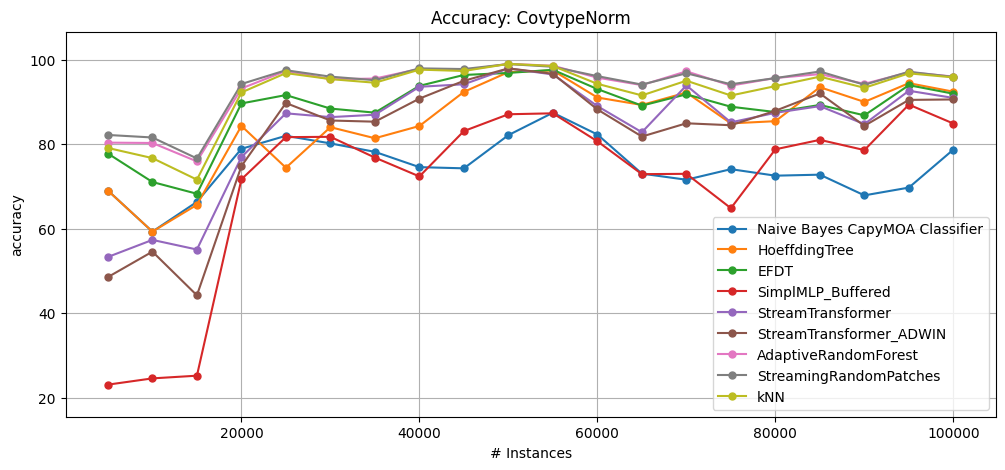


 Windowed Metrics for CovtypeNorm:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa      kappa_t     kappa_m   f1_score  \
0      5000.0     69.02  62.582347    20.195775   58.671291  66.775291   
1     10000.0     59.30  51.822898    12.548346   53.771013  56.780001   
2     15000.0     66.34  60.737990    36.681716   59.736842  66.883047   
3     20000.0     78.90  14.241587  -402.380952   19.404125        NaN   
4     25000.0     81.98   3.944153  -783.333333    1.744820        NaN   
5     30000.0     80.18  36.317111  -489.880952   -8.543264        NaN   
6     35000.0     78.18  37.598971  -492.934783    5.867127        NaN   
7     40000.0     74.56  43.596920 -1345.454545    8.817204        NaN   
8     45000.0     74.28  45.159840 -1737.142857   16.276042        NaN   
9     50000.0     82.14  59.317029 -1760.416667   31.779985        NaN   
10    55000.0     87.44  68.680438  -665.853659   49.232013        NaN   
11    60000.0     82.28  61.687285  -415.116279   52.645644        NaN   
12    65000.0     73.02  40.460743  -496.902655   20.879765        NaN   
13    70000.0     71.58  19.745336  -960.447761   -9.814529        NaN   
14    75000.0     74.08  34.535774  -662.352941   16.224952        NaN   
15    80000.0     72.54   6.935053  -689.080460  -39.532520        NaN   
16    85000.0     72.78  21.864406  -915.671642  -33.562316        NaN   
17    90000.0     67.88   5.341565  -844.705882  -55.319149        NaN   
18    95000.0     69.72   5.434931  -966.197183 -182.990654        NaN   
19   100000.0     78.72  42.225759  -552.760736  -30.392157        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    60.927152   60.646600   62.752772   89.076305  ...    40.568475   
1    53.362573   36.438923   26.583593   70.109235  ...    62.086957   
2    62.155059   48.934356   57.224199   81.444165  ...    65.353261   
3          NaN   88.306636   74.809160         NaN  ...    62.711864   
4     5.079365   90.045299         NaN         NaN  ...          NaN   
5    48.620510   87.727554         NaN         NaN  ...          NaN   
6    51.901566   85.920764         NaN         NaN  ...          NaN   
7    62.396568   81.004334         NaN         NaN  ...          NaN   
8    64.122137   80.511780         NaN         NaN  ...          NaN   
9    71.340629   88.580515         NaN         NaN  ...          NaN   
10   79.171461   91.607241         NaN         NaN  ...          NaN   
11   76.992481   86.481538         NaN         NaN  ...          NaN   
12   62.066731   80.041611         NaN         NaN  ...          NaN   
13   38.147962   81.830968         NaN         NaN  ...          NaN   
14   44.844845   82.893347         NaN         NaN  ...          NaN   
15   23.128342   83.411864         NaN         NaN  ...          NaN   
16   40.449438   82.586428         NaN         NaN  ...          NaN   
17   25.779037   79.536188         NaN         NaN  ...          NaN   
18   20.122974   81.418545         NaN         NaN  ...          NaN   
19   60.369815   86.231884         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     92.481203  65.619168  66.068223  57.383966  74.805599  88.791033   
1     82.729375  58.262920  44.621027  34.241245  20.678514  95.148248   
2     80.862832  67.464243  60.254777  41.176471  49.024390  89.814815   
3           NaN        NaN   0.000000  99.896454  62.820513        NaN   
4           NaN        NaN   2.617230  99.804066        NaN        NaN   
5           NaN        NaN  51.150055  86.665035        NaN        NaN   
6           NaN        NaN  50.259965  86.670138        NaN        NaN   
7      0.000000        NaN  73.768116  75.173370        NaN        NaN   
8      0.000000        NaN  73.828125  74.480370        NaN        NaN   
9      0.000000        NaN  79.679144  83.012734        NaN        NaN   
10     0.000000        NaN  83.427648  88.758969        NaN        NaN   
11          NaN        NaN  68.412614  90.572068


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa      kappa_t    kappa_m   f1_score  \
0      5000.0     69.00  62.556781    20.144256  58.644610  66.759812   
1     10000.0     59.30  51.822898    12.548346  53.771013  56.780001   
2     15000.0     65.64  59.819385    35.364936  58.899522  65.619547   
3     20000.0     84.32  62.556011  -273.333333  40.106952        NaN   
4     25000.0     74.42  33.305460 -1153.921569 -39.476554        NaN   
5     30000.0     84.02  53.664672  -375.595238  12.486309        NaN   
6     35000.0     81.40  40.701346  -405.434783  19.758412        NaN   
7     40000.0     84.30  58.019011  -792.045455  43.727599        NaN   
8     45000.0     92.38  82.050451  -444.285714  75.195312        NaN   
9     50000.0     97.06  92.491790  -206.250000  88.770053        NaN   
10    55000.0     97.44  93.011652   -56.097561  89.652385        NaN   
11    60000.0     91.04  80.661177  -160.465116  76.055585        NaN   
12    65000.0     89.28  76.134480  -137.168142  68.563050        NaN   
13    70000.0     92.22  80.408333  -190.298507  69.938176        NaN   
14    75000.0     84.92  63.837565  -343.529412  51.260504        NaN   
15    80000.0     85.44  55.128260  -318.390805  26.016260        NaN   
16    85000.0     93.48  79.938773  -143.283582  68.007851        NaN   
17    90000.0     90.00  69.990503  -194.117647  51.644101        NaN   
18    95000.0     94.44  69.915699   -95.774648  48.037383        NaN   
19   100000.0     92.42  70.808465  -132.515337  53.553922        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    61.028192   60.612813   62.752772   89.076305  ...    40.568475   
1    53.362573   36.438923   26.583593   70.109235  ...    62.086957   
2    62.716049   41.778523   62.327910   81.541219  ...    62.650602   
3    72.296476   89.838275   79.220779         NaN  ...    68.627451   
4    52.564103   83.111052         NaN         NaN  ...          NaN   
5    65.863067   89.802170         NaN         NaN  ...          NaN   
6    52.021277   88.504326         NaN         NaN  ...          NaN   
7    68.442964   89.609530         NaN         NaN  ...          NaN   
8    88.260725   94.529792         NaN         NaN  ...          NaN   
9    94.496443   97.994269         NaN         NaN  ...          NaN   
10   94.697597   98.312681         NaN         NaN  ...          NaN   
11   87.699066   92.953759         NaN         NaN  ...          NaN   
12   84.263065   91.871398         NaN         NaN  ...          NaN   
13   85.766691   94.651451         NaN         NaN  ...          NaN   
14   72.677381   89.533592         NaN         NaN  ...          NaN   
15   65.980443   90.884047         NaN         NaN  ...          NaN   
16   84.035260   95.903493         NaN         NaN  ...          NaN   
17   76.325758   93.661258         NaN         NaN  ...          NaN   
18   73.009709   96.900780         NaN         NaN  ...          NaN   
19   75.050437   95.563945         NaN         NaN  ...          NaN   

    precision_6    recall   recall_0   recall_1   recall_2   recall_3  \
0     92.481203  65.60405  66.068223  57.383966  74.805599  88.791033   
1     82.729375  58.26292  44.621027  34.241245  20.678514  95.148248   
2     81.172492  66.25677  64.713376  35.724534  60.731707  84.259259   
3           NaN       NaN  76.086957  86.280093  78.205128        NaN   
4           NaN       NaN  62.595420  77.075680        NaN        NaN   
5           NaN       NaN  74.808324  86.077808        NaN        NaN   
6           NaN       NaN  42.374350  93.204895        NaN        NaN   
7           NaN       NaN  59.565217  93.897365        NaN        NaN   
8           NaN       NaN  86.393229  95.034642        NaN        NaN   
9           NaN       NaN  96.409473  97.290707        NaN        NaN   
10          NaN       NaN  92.400970  99.096466        NaN        NaN   
11          NaN       NaN  85.355425  94.439118        NaN        NaN   
12      


--- EFDT Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     77.78  73.017990   42.761463  70.357524  75.321693   
1     10000.0     71.04  65.727893   37.773958  67.105861  69.947308   
2     15000.0     68.26  62.853466   40.293454  62.033493  68.799340   
3     20000.0     89.64  72.483245 -146.666667  60.427807        NaN   
4     25000.0     91.62  70.176467 -310.784314  54.307525        NaN   
5     30000.0     88.42  58.507949 -244.642857  36.582694        NaN   
6     35000.0     87.46  60.935602 -240.760870  45.901639        NaN   
7     40000.0     93.80  84.529780 -252.272727  77.777778        NaN   
8     45000.0     96.38  91.519109 -158.571429  88.216146        NaN   
9     50000.0     96.86  92.009317 -227.083333  88.006112        NaN   
10    55000.0     97.60  93.484367  -46.341463  90.299111        NaN   
11    60000.0     93.04  85.215525 -102.325581  81.400321        NaN   
12    65000.0     89.12  75.295568 -140.707965  68.093842        NaN   
13    70000.0     91.80  79.432951 -205.970149  68.315301        NaN   
14    75000.0     88.86  74.881782 -227.647059  63.994829        NaN   
15    80000.0     87.60  55.622799 -256.321839  36.991870        NaN   
16    85000.0     89.28  61.549200 -300.000000  47.399411        NaN   
17    90000.0     86.82  54.580868 -287.647059  36.266925        NaN   
18    95000.0     93.96  65.927373 -112.676056  43.551402        NaN   
19   100000.0     91.94  67.478856 -147.239264  50.612745        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    58.493870   71.344455   75.236020   92.576419  ...    79.204893   
1    63.109954   48.713235   60.770975   81.279621  ...    82.423208   
2    62.837046   50.230415   65.220012   79.757785  ...    65.254237   
3    77.675033   94.088734   70.312500         NaN  ...    53.623188   
4    75.252226   94.959702         NaN         NaN  ...          NaN   
5    65.391512   93.046716         NaN         NaN  ...          NaN   
6    68.649194   92.173262         NaN         NaN  ...          NaN   
7    89.207048   95.721778         NaN         NaN  ...          NaN   
8    94.109990   97.499639         NaN         NaN  ...          NaN   
9    94.187779   97.853725         NaN         NaN  ...          NaN   
10   95.069844   98.413957         NaN         NaN  ...          NaN   
11   90.817942   94.396135         NaN         NaN  ...          NaN   
12   83.353733   91.919192         NaN         NaN  ...          NaN   
13   85.058309   94.349504         NaN         NaN  ...          NaN   
14   82.038835   91.942990         NaN         NaN  ...          NaN   
15   62.713936   92.578827         NaN         NaN  ...          NaN   
16   67.554479   93.579300         NaN         NaN  ...          NaN   
17   62.234957   92.016959         NaN         NaN  ...          NaN   
18   69.246436   96.651142         NaN         NaN  ...          NaN   
19   71.942446   95.294804         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     89.393939  73.103315  59.964093  76.687764  80.559876  93.354684   
1     88.270042  70.845890  59.290954  51.556420  64.943457  92.452830   
2     88.555858  68.893259  68.280255  46.915352  65.975610  85.370370   
3           NaN        NaN  75.191816  94.149625  57.692308        NaN   
4           NaN        NaN  69.138495  96.669116        NaN        NaN   
5           NaN        NaN  59.912377  94.788353        NaN        NaN   
6           NaN        NaN  59.012132  96.120802        NaN        NaN   
7           NaN        NaN  88.043478  96.199723        NaN        NaN   
8      0.000000        NaN  94.140625  97.372979        NaN        NaN   
9           NaN        NaN  96.562261  96.965592        NaN        NaN   
10          NaN        NaN  93.532741  98.937018        NaN        NaN   
11          NaN        NaN  91.982897  93.672100        NaN        NaN   
12          NaN 


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa      kappa_t    kappa_m  f1_score  \
0      5000.0     23.08   5.282759   -98.145286  -2.614728       NaN   
1     10000.0     24.56  13.694034   -62.097121  14.311677       NaN   
2     15000.0     25.20  11.132743   -40.707299  10.526316       NaN   
3     20000.0     71.68   7.207901  -574.285714  -8.174179       NaN   
4     25000.0     81.66   0.000000  -799.019608   0.000000       NaN   
5     30000.0     81.74   0.000000  -443.452381   0.000000       NaN   
6     35000.0     76.82   0.000000  -529.891304   0.000000       NaN   
7     40000.0     72.36   1.341034 -1470.454545   0.931900       NaN   
8     45000.0     83.10  58.214686 -1107.142857  44.986979       NaN   
9     50000.0     87.08  60.907347 -1245.833333  50.649351       NaN   
10    55000.0     87.30  60.922923  -674.390244  48.666128       NaN   
11    60000.0     80.68  58.363971  -461.627907  48.369856       NaN   
12    65000.0     72.90  37.792216  -499.557522  20.527859       NaN   
13    70000.0     72.98  14.444850  -908.208955  -4.404946       NaN   
14    75000.0     64.84   1.318282  -934.117647 -13.639302       NaN   
15    80000.0     78.78   2.049646  -509.770115  -7.825203       NaN   
16    85000.0     81.02  14.155745  -608.208955   6.869480       NaN   
17    90000.0     78.60   4.431383  -529.411765  -3.481625       NaN   
18    95000.0     89.36   2.704878  -274.647887   0.560748       NaN   
19   100000.0     84.88  22.112410  -363.803681   7.352941       NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    13.413816   23.565121         NaN   46.798030  ...     0.000000   
1    26.098535         NaN         NaN   44.166667  ...    28.623853   
2    21.920136   21.037464   28.288823         NaN  ...    31.954023   
3    13.235294   83.903737         NaN         NaN  ...    34.693878   
4          NaN   89.904217         NaN         NaN  ...          NaN   
5          NaN   89.952680         NaN         NaN  ...          NaN   
6          NaN   86.890623         NaN         NaN  ...          NaN   
7     1.866475   83.915270         NaN         NaN  ...          NaN   
8    69.789060   88.268777         NaN         NaN  ...          NaN   
9    68.177340   91.894605         NaN         NaN  ...          NaN   
10   68.329177   92.057536         NaN         NaN  ...          NaN   
11   73.577681   84.773014         NaN         NaN  ...          NaN   
12   57.563420   80.094021         NaN         NaN  ...          NaN   
13   28.328912   83.351818         NaN         NaN  ...          NaN   
14   14.077426   78.750952         NaN         NaN  ...          NaN   
15    7.570423   88.015362         NaN         NaN  ...          NaN   
16   18.540773   89.258630         NaN         NaN  ...          NaN   
17    9.322034   87.868481         NaN         NaN  ...          NaN   
18    3.272727   94.370370         NaN         NaN  ...          NaN   
19   28.207640   91.558732         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0    recall_1   recall_2    recall_3  \
0           NaN  16.380539  17.953321   45.042194   0.000000   45.636509   
1     53.703704  30.987411  23.960880    0.000000   0.000000  100.000000   
2     24.637044  22.765798  16.433121   20.946915  34.878049    0.000000   
3      0.000000        NaN  10.358056   89.800673   0.000000         NaN   
4           NaN        NaN   0.000000  100.000000        NaN         NaN   
5           NaN        NaN   0.000000  100.000000        NaN         NaN   
6           NaN        NaN   0.000000  100.000000        NaN         NaN   
7           NaN        NaN   0.942029  100.000000        NaN         NaN   
8           NaN        NaN  63.541667   91.772517        NaN         NaN   
9           NaN        NaN  52.864782   99.214305        NaN         NaN   
10          NaN        NaN  55.375909   97.794313        NaN         NaN   
11          NaN        NaN  71.886692   85.937999        NaN      


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     53.30  42.605671  -20.298815  37.700107  42.919937   
1     10000.0     57.34  49.193358    8.336914  51.544752  53.830452   
2     15000.0     55.06  47.351107   15.462754  46.244019  54.115203   
3     20000.0     76.94  20.790909 -449.047619  11.917494        NaN   
4     25000.0     87.30  46.031487 -522.549020  30.752454        NaN   
5     30000.0     86.40  52.076754 -304.761905  25.520263        NaN   
6     35000.0     86.96  60.217175 -254.347826  43.744607        NaN   
7     40000.0     93.58  84.204536 -264.772727  76.989247        NaN   
8     45000.0     94.18  85.783519 -315.714286  81.054687        NaN   
9     50000.0     97.92  94.521434 -116.666667  92.055004        NaN   
10    55000.0     96.50  90.166246 -113.414634  85.852870        NaN   
11    60000.0     89.00  75.524466 -219.767442  70.603955        NaN   
12    65000.0     82.82  60.026581 -280.088496  49.618768        NaN   
13    70000.0     93.90  83.463622 -127.611940  76.429675        NaN   
14    75000.0     85.16  65.077189 -336.470588  52.036199        NaN   
15    80000.0     87.42  58.221809 -261.494253  36.077236        NaN   
16    85000.0     89.00  63.463899 -310.447761  46.025515        NaN   
17    90000.0     84.74  50.114677 -348.823529  26.208897        NaN   
18    95000.0     92.64  60.311212 -159.154930  31.214953        NaN   
19   100000.0     90.94  67.452028 -177.914110  44.485294        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    23.188406   58.204334   48.438690   79.111111  ...    33.463035   
1    54.556575   25.799338   31.269675   69.841270  ...    56.268509   
2    55.512465   23.853211   41.684211   68.288120  ...    52.013423   
3    11.067194   86.769084   63.793103         NaN  ...    38.095238   
4    52.147702   92.678427         NaN         NaN  ...          NaN   
5    60.233918   91.797346         NaN         NaN  ...          NaN   
6    68.392770   91.796678         NaN         NaN  ...          NaN   
7    89.215335   95.529870         NaN         NaN  ...          NaN   
8    89.828731   95.923799         NaN         NaN  ...          NaN   
9    95.915161   98.604776         NaN         NaN  ...          NaN   
10   92.427521   97.724021         NaN         NaN  ...          NaN   
11   83.660131   91.709376         NaN         NaN  ...          NaN   
12   72.299258   87.548920         NaN         NaN  ...          NaN   
13   87.474333   95.968275         NaN         NaN  ...          NaN   
14   77.773788   89.481145         NaN         NaN  ...          NaN   
15   66.229508   92.290722         NaN         NaN  ...          NaN   
16   70.108696   93.259804         NaN         NaN  ...          NaN   
17   59.393294   90.604605         NaN         NaN  ...          NaN   
18   64.410058   95.895606         NaN         NaN  ...          NaN   
19   73.812424   94.565087         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     14.285714  41.620421  15.798923  69.409283  49.455677  78.382706   
1     81.984334  54.347440  54.523227  22.762646  24.071082  77.088949   
2     76.731602  54.809199  63.821656  18.651363  36.219512  67.592593   
3      0.000000        NaN   7.161125  94.304944  47.435897        NaN   
4           NaN        NaN  37.731734  98.432525        NaN        NaN   
5           NaN        NaN  56.407448  93.100073        NaN        NaN   
6           NaN        NaN  60.658579  94.975267        NaN        NaN   
7           NaN        NaN  90.217391  95.145631        NaN        NaN   
8           NaN        NaN  83.658854  98.845266        NaN        NaN   
9           NaN        NaN  93.277311  99.566513        NaN        NaN   
10          NaN        NaN  86.337914  99.840553        NaN        NaN   
11          NaN        NaN  75.253875  97.219559        NaN        NaN   
12          NaN 


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     48.54  36.910525  -32.560536  31.350053  43.162915   
1     10000.0     54.56  46.222049    2.363558  48.387097  51.062031   
2     15000.0     44.22  34.780961   -4.928518  33.277512  42.587870   
3     20000.0     74.80  12.717515 -500.000000   3.743316        NaN   
4     25000.0     89.74  58.584464 -402.941176  44.056707        NaN   
5     30000.0     85.60  48.614050 -328.571429  21.139102        NaN   
6     35000.0     85.32  54.730335 -298.913043  36.669543        NaN   
7     40000.0     90.78  77.517065 -423.863636  66.953405        NaN   
8     45000.0     95.00  87.889193 -257.142857  83.723958        NaN   
9     50000.0     97.94  94.676974 -114.583333  92.131398        NaN   
10    55000.0     96.66  90.615789 -103.658537  86.499596        NaN   
11    60000.0     88.22  74.030266 -242.441860  68.519508        NaN   
12    65000.0     81.80  56.816165 -302.654867  46.627566        NaN   
13    70000.0     84.94  52.833285 -461.940299  41.808346        NaN   
14    75000.0     84.48  62.545345 -356.470588  49.838397        NaN   
15    80000.0     87.90  57.587082 -247.701149  38.516260        NaN   
16    85000.0     92.00  74.258934 -198.507463  60.745829        NaN   
17    90000.0     84.34  45.947245 -360.588235  24.274662        NaN   
18    95000.0     90.48  35.551482 -235.211268  11.028037        NaN   
19   100000.0     90.58  63.297170 -188.957055  42.279412        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    21.900826   57.858377   39.941263   75.976725  ...    26.701571   
1    58.470948   20.512821   24.557261   51.166667  ...    55.364807   
2    49.615582   27.168576   10.229645   39.423077  ...    44.971098   
3     9.856263   86.226550   11.320755         NaN  ...    23.809524   
4    64.000000   94.017493         NaN         NaN  ...          NaN   
5    57.193817   91.344073         NaN         NaN  ...          NaN   
6    63.785395   90.815687         NaN         NaN  ...          NaN   
7    84.436620   93.540703         NaN         NaN  ...          NaN   
8    91.397109   96.475895         NaN         NaN  ...          NaN   
9    96.073199   98.603768         NaN         NaN  ...          NaN   
10   92.773691   97.828066         NaN         NaN  ...          NaN   
11   82.922586   91.009006         NaN         NaN  ...          NaN   
12   69.360269   87.055477         NaN         NaN  ...          NaN   
13   60.801666   90.679540         NaN         NaN  ...          NaN   
14   76.194002   89.171086         NaN         NaN  ...          NaN   
15   65.058824   92.701170         NaN         NaN  ...          NaN   
16   79.188345   95.048279         NaN         NaN  ...          NaN   
17   55.025847   90.519433         NaN         NaN  ...          NaN   
18   40.050378   94.829459         NaN         NaN  ...          NaN   
19   69.770580   94.455562         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0    100.000000  37.674020  19.030521  70.675105  42.301711  73.178543   
1     80.878317  52.097932  58.435208  15.564202  16.801292  82.749326   
2     64.000000  43.632206  61.656051  23.816356   5.975610  37.962963   
3      0.000000        NaN   6.138107  93.994305   7.692308        NaN   
4           NaN        NaN  49.727372  98.726427        NaN        NaN   
5           NaN        NaN  52.683461  92.953266        NaN        NaN   
6      0.000000        NaN  55.632582  94.350430        NaN        NaN   
7           NaN        NaN  86.884058  92.593620        NaN        NaN   
8           NaN        NaN  86.458333  98.787529        NaN        NaN   
9           NaN        NaN  96.256684  98.536982        NaN        NaN   
10          NaN        NaN  86.661277  99.946851        NaN        NaN   
11          NaN        NaN  76.429717  95.270054        NaN        NaN   
12          NaN 


--- ARF Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     80.36  76.126650  49.407522  73.799360  78.877739   
1     10000.0     80.28  76.590051  57.627847  77.601090  78.545609   
2     15000.0     75.92  71.819750  54.702784  71.196172  76.222787   
3     20000.0     93.18  81.650529 -62.380952  73.949580        NaN   
4     25000.0     97.34  91.085466 -30.392157  85.496183        NaN   
5     30000.0     95.38  84.193966 -37.500000  74.698795        NaN   
6     35000.0     95.52  87.061977 -21.739130  80.672994        NaN   
7     40000.0     97.82  94.549771 -23.863636  92.186380        NaN   
8     45000.0     97.50  94.099993 -78.571429  91.861979        NaN   
9     50000.0     99.02  97.471422  -2.083333  96.256684        NaN   
10    55000.0     98.56  96.073387  12.195122  94.179466        NaN   
11    60000.0     95.74  90.848166 -23.837209  88.615714        NaN   
12    65000.0     93.98  86.527327 -33.185841  82.346041        NaN   
13    70000.0     97.24  92.765828  -2.985075  89.335394        NaN   
14    75000.0     93.86  86.035397 -80.588235  80.155139        NaN   
15    80000.0     95.66  86.201597 -24.712644  77.947154        NaN   
16    85000.0     96.58  89.269767 -27.611940  83.218842        NaN   
17    90000.0     94.28  82.476865 -68.235294  72.340426        NaN   
18    95000.0     97.02  83.943966  -4.929577  72.149533        NaN   
19   100000.0     96.00  84.985860 -22.699387  75.490196        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    66.536965   74.899598   74.852941   90.213102  ...    79.338843   
1    76.374622   55.244029   74.844720   84.597156  ...    88.016529   
2    69.725940   59.564891   74.030552   88.347826  ...    80.847724   
3    85.335103   95.943335   85.135135         NaN  ...    70.212766   
4    92.712329   98.373089         NaN         NaN  ...          NaN   
5    87.000563   97.190806         NaN         NaN  ...          NaN   
6    90.130689   97.119342         NaN         NaN  ...          NaN   
7    96.323529   98.497174         NaN         NaN  ...          NaN   
8    95.897604   98.202215         NaN         NaN  ...          NaN   
9    98.136173   99.335233         NaN         NaN  ...          NaN   
10   97.022333   99.050382         NaN         NaN  ...          NaN   
11   94.219810   96.627078         NaN         NaN  ...          NaN   
12   91.065598   95.460715         NaN         NaN  ...          NaN   
13   94.621980   98.143664         NaN         NaN  ...          NaN   
14   90.411932   95.570625         NaN         NaN  ...          NaN   
15   89.280166   97.304683         NaN         NaN  ...          NaN   
16   91.402715   97.865435         NaN         NaN  ...          NaN   
17   86.075949   96.400705         NaN         NaN  ...          NaN   
18   85.603865   98.337981         NaN         NaN  ...          NaN   
19   87.776333   97.626394         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     93.464052  77.201271  61.400359  78.691983  79.160187  91.513211   
1     93.033135  79.322038  77.261614  51.750973  77.867528  96.226415   
2     86.320755  76.517314  69.681529  56.958393  76.829268  94.074074   
3           NaN        NaN  82.225064  96.427647  80.769231        NaN   
4           NaN        NaN  92.257361  98.481509        NaN        NaN   
5           NaN        NaN  84.665936  97.773428        NaN        NaN   
6           NaN        NaN  86.655113  98.307732        NaN        NaN   
7           NaN        NaN  94.927536  99.084605        NaN        NaN   
8           NaN        NaN  95.117188  98.556582        NaN        NaN   
9           NaN        NaN  98.548510  99.187212        NaN        NaN   
10          NaN        NaN  94.826192  99.787404        NaN        NaN   
11          NaN        NaN  92.784607  97.507191        NaN        NaN   
12          NaN        NaN  89.970674


--- SRP Windowed Data ---


instances  accuracy      kappa    kappa_t    kappa_m   f1_score  \
0      5000.0     82.18  78.366210  54.095827  76.227321  80.661140   
1     10000.0     81.58  78.113929  60.421143  79.077692  80.024689   
2     15000.0     76.62  72.632288  56.019564  72.033493  76.960029   
3     20000.0     94.24  84.425881 -37.142857  77.998472        NaN   
4     25000.0     97.50  91.650029 -22.549020  86.368593        NaN   
5     30000.0     95.98  86.365146 -19.642857  77.984666        NaN   
6     35000.0     95.14  85.996840 -32.065217  79.033650        NaN   
7     40000.0     97.94  94.895909 -17.045455  92.616487        NaN   
8     45000.0     97.78  94.751241 -58.571429  92.773438        NaN   
9     50000.0     98.96  97.315951  -8.333333  96.027502        NaN   
10    55000.0     98.32  95.406295  -2.439024  93.209378        NaN   
11    60000.0     96.10  91.612493 -13.372093  89.577766        NaN   
12    65000.0     94.10  86.792125 -30.530973  82.697947        NaN   
13    70000.0     96.78  91.617367 -20.149254  87.557960        NaN   
14    75000.0     94.18  86.690394 -71.176471  81.189399        NaN   
15    80000.0     95.64  85.967388 -25.287356  77.845528        NaN   
16    85000.0     97.20  91.270181  -4.477612  86.261040        NaN   
17    90000.0     94.06  81.517354 -74.705882  71.276596        NaN   
18    95000.0     97.14  84.642547  -0.704225  73.271028        NaN   
19   100000.0     95.92  84.341697 -25.153374  75.000000        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    66.666667   75.025176   79.202279   93.977813  ...    84.194529   
1    76.178960   56.236786   76.770754   88.833124  ...    89.410188   
2    69.367710   59.355828   73.883792   89.709763  ...    77.982955   
3    88.335518   96.668810   82.758621         NaN  ...    66.037736   
4    93.180578   98.469450         NaN         NaN  ...          NaN   
5    88.814691   97.549677         NaN         NaN  ...          NaN   
6    89.258427   96.872184         NaN         NaN  ...          NaN   
7    96.629213   98.572023         NaN         NaN  ...          NaN   
8    96.345077   98.405860         NaN         NaN  ...          NaN   
9    98.021309   99.294628         NaN         NaN  ...          NaN   
10   96.511628   98.893572         NaN         NaN  ...          NaN   
11   94.693878   96.916996         NaN         NaN  ...          NaN   
12   91.238491   95.552540         NaN         NaN  ...          NaN   
13   93.790976   97.826380         NaN         NaN  ...          NaN   
14   90.719424   95.820767         NaN         NaN  ...          NaN   
15   89.276281   97.303315         NaN         NaN  ...          NaN   
16   93.020937   98.248687         NaN         NaN  ...          NaN   
17   85.231228   96.282388         NaN         NaN  ...          NaN   
18   86.236766   98.404196         NaN         NaN  ...          NaN   
19   87.408394   97.590931         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     90.116279  79.472295  63.195691  78.586498  86.469673  94.955965   
1     93.372982  80.546196  77.017115  51.750973  81.421648  95.417790   
2     87.559242  77.241561  71.974522  55.523673  73.658537  94.444444   
3      0.000000        NaN  86.189258  97.281905  76.923077        NaN   
4           NaN        NaN  93.129771  98.481509        NaN        NaN   
5           NaN        NaN  87.404162  97.895767        NaN        NaN   
6           NaN        NaN  86.048527  97.969279        NaN        NaN   
7           NaN        NaN  96.594203  98.613037        NaN        NaN   
8           NaN        NaN  95.247396  98.903002        NaN        NaN   
9           NaN        NaN  98.395722  99.160119        NaN        NaN   
10          NaN        NaN  93.936944  99.760829        NaN        NaN   
11          NaN        NaN  92.998397  97.954618        NaN        NaN   
12          NaN        NaN  90.087977


--- KNN Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     79.10  74.653823   46.161772  72.118463  77.445672   
1     10000.0     76.70  72.292652   49.935539  73.534757  74.423866   
2     15000.0     71.60  66.781374   46.576373  66.028708  71.947479   
3     20000.0     92.24  79.280973  -84.761905  70.359053        NaN   
4     25000.0     96.82  89.572895  -55.882353  82.660851        NaN   
5     30000.0     95.40  84.668609  -36.904762  74.808324        NaN   
6     35000.0     94.54  84.538244  -48.369565  76.445211        NaN   
7     40000.0     97.64  94.104702  -34.090909  91.541219        NaN   
8     45000.0     97.32  93.694702  -91.428571  91.276042        NaN   
9     50000.0     99.00  97.425514   -4.166667  96.180290        NaN   
10    55000.0     98.50  95.937758    8.536585  93.936944        NaN   
11    60000.0     94.28  87.728867  -66.279070  84.714057        NaN   
12    65000.0     91.54  81.205747  -87.168142  75.190616        NaN   
13    70000.0     95.02  87.093904  -85.820896  80.757342        NaN   
14    75000.0     91.52  80.669020 -149.411765  72.592114        NaN   
15    80000.0     93.74  80.417141  -79.885057  68.191057        NaN   
16    85000.0     95.98  87.424667  -50.000000  80.274779        NaN   
17    90000.0     93.34  79.397328  -95.882353  67.794971        NaN   
18    95000.0     96.76  83.101307  -14.084507  69.719626        NaN   
19   100000.0     95.80  84.411559  -28.834356  74.264706        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    59.035005   71.908950   74.316109   91.446843  ...    72.453704   
1    71.214841   48.275862   67.707477   83.650190  ...    79.827798   
2    65.924552   54.061826   66.542289   82.373782  ...    73.203593   
3    84.372990   95.321789   80.281690         NaN  ...    68.627451   
4    91.529036   98.042595         NaN         NaN  ...          NaN   
5    87.486398   97.182063         NaN         NaN  ...          NaN   
6    88.157895   96.460521         NaN         NaN  ...          NaN   
7    95.929593   98.371965         NaN         NaN  ...          NaN   
8    95.626632   98.068051         NaN         NaN  ...          NaN   
9    98.104625   99.320837         NaN         NaN  ...          NaN   
10   96.930004   99.007543         NaN         NaN  ...          NaN   
11   92.266090   95.461758         NaN         NaN  ...          NaN   
12   87.635194   93.570451         NaN         NaN  ...          NaN   
13   90.463424   96.630126         NaN         NaN  ...          NaN   
14   86.366881   93.894009         NaN         NaN  ...          NaN   
15   84.928717   96.092872         NaN         NaN  ...          NaN   
16   89.934902   97.488442         NaN         NaN  ...          NaN   
17   83.571781   95.823404         NaN         NaN  ...          NaN   
18   84.916201   98.185077         NaN         NaN  ...          NaN   
19   87.235407   97.501190         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     92.638037  76.674937  56.014363  73.312236  76.049767  91.593275   
1     92.735043  74.866120  72.738386  44.941634  66.558966  88.948787   
2     90.338770  72.221955  67.898089  53.945481  65.243902  86.111111   
3           NaN        NaN  83.887468  95.469842  73.076923        NaN   
4           NaN        NaN  93.675027  97.526329        NaN        NaN   
5           NaN        NaN  88.061336  97.039393        NaN        NaN   
6           NaN        NaN  87.088388  96.849779        NaN        NaN   
7           NaN        NaN  94.782609  98.890430        NaN        NaN   
8           NaN        NaN  95.377604  98.181293        NaN        NaN   
9           NaN        NaN  98.854087  99.051747        NaN        NaN   
10          NaN        NaN  95.715441  99.415360        NaN        NaN   
11          NaN        NaN  91.181187  96.132950        NaN        NaN   
12          NaN 


==================== DATASET: CovtFD ====================
Config: Evaluation Interval = 5000


covtFD.arff: 280MB [00:06, 47.1MB/s]                           


[1/3] Running Drift Analysis...
 - ABCD            | Drifts: 5
 - ADWIN           | Drifts: 14
 - CUSUM           | Drifts: 1
 - HDDMAverage     | Drifts: 4
 - PageHinkley     | Drifts: 1
 - SEED            | Drifts: 7

[FINAL] Drift results saved to drift_analysis_results.csv
[2/3] Running Prequential Evaluation...
   -> Evaluating NaiveBayes...
   -> Evaluating HoeffdingTree...
   -> Evaluating EFDT...
   -> Evaluating Simple_MLP...
   -> Evaluating StreamTransformer...
   -> Evaluating StreamTransformer_ADWIN...
   -> Evaluating ARF...
   -> Evaluating SRP...
   -> Evaluating KNN...
[3/3] Generating Performance Metrics...

RESULTS SUMMARY: CovtFD


Dataset  Accuracy (%)    Kappa  Time (s)
Learner                                                         
NaiveBayes               CovtFD         74.67  49.9792     10.12
HoeffdingTree            CovtFD         84.88  69.8287     10.90
EFDT                     CovtFD         88.25  76.2652     15.56
Simple_MLP               CovtFD         67.36  21.2112    120.50
StreamTransformer        CovtFD         84.39  68.0623    414.20
StreamTransformer_ADWIN  CovtFD         81.61  61.6494    380.25
ARF                      CovtFD         91.70  83.3104    109.78
SRP                      CovtFD         90.83  81.4391    180.07
KNN                      CovtFD         85.41  70.5620    219.71

Results for CovtFD saved to thesis_results.csv


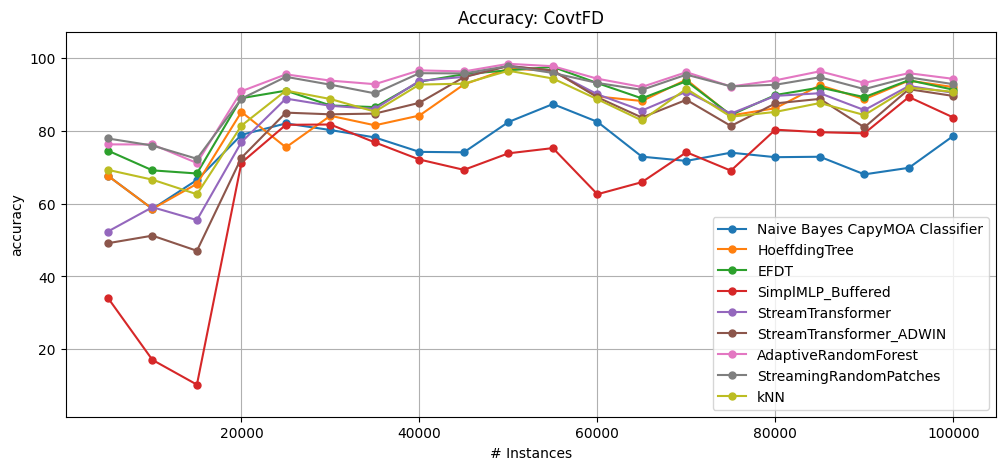


 Windowed Metrics for CovtFD:

--- NaiveBayes Windowed Data ---


instances  accuracy      kappa      kappa_t     kappa_m   f1_score  \
0      5000.0     67.66  60.820677    16.735324   56.868498  64.727920   
1     10000.0     58.56  50.988741    10.958315   52.919791  56.145208   
2     15000.0     66.50  60.929646    36.982694   59.928230  67.106480   
3     20000.0     78.90  14.237390  -404.784689   19.465649        NaN   
4     25000.0     82.04   4.476113  -780.392157    2.071974        NaN   
5     30000.0     80.22  36.341761  -488.690476   -8.324206        NaN   
6     35000.0     78.18  37.560587  -492.934783    5.867127        NaN   
7     40000.0     74.22  42.763184 -1364.772727    7.532281        NaN   
8     45000.0     74.10  44.599253 -1750.000000   15.690104        NaN   
9     50000.0     82.42  59.878663 -1731.250000   32.849503        NaN   
10    55000.0     87.36  68.441521  -670.731707   48.908650        NaN   
11    60000.0     82.48  62.020960  -409.302326   53.180118        NaN   
12    65000.0     72.90  40.060108  -499.557522   20.527859        NaN   
13    70000.0     71.74  19.609556  -954.477612   -9.196291        NaN   
14    75000.0     74.00  34.209840  -664.705882   15.966387        NaN   
15    80000.0     72.76   6.771790  -682.758621  -38.414634        NaN   
16    85000.0     72.88  21.866591  -911.940299  -33.071639        NaN   
17    90000.0     68.04   5.432394  -840.000000  -54.545455        NaN   
18    95000.0     69.84   5.132293  -961.971831 -181.869159        NaN   
19   100000.0     78.62  41.778111  -555.828221  -30.844553        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    56.939502   61.193269   61.948052   88.387097  ...    40.782123   
1    52.287582   36.085627   26.310380   69.488189  ...    61.861314   
2    62.972621   49.488055   57.708628   81.574539  ...    65.782123   
3          NaN   88.283753   75.968992         NaN  ...    65.517241   
4     5.702218   90.075155         NaN         NaN  ...          NaN   
5    48.617632   87.758386         NaN         NaN  ...          NaN   
6    51.858486   85.924397         NaN         NaN  ...          NaN   
7    61.742074   80.823758         NaN         NaN  ...          NaN   
8    63.631190   80.466563         NaN         NaN  ...          NaN   
9    71.775573   88.734835         NaN         NaN  ...          NaN   
10   78.911043   91.542152         NaN         NaN  ...          NaN   
11   77.024992   86.658544         NaN         NaN  ...          NaN   
12   61.658537   79.994068         NaN         NaN  ...          NaN   
13   37.689970   81.983935         NaN         NaN  ...          NaN   
14   44.166249   82.854128         NaN         NaN  ...          NaN   
15   22.644068   83.590361         NaN         NaN  ...          NaN   
16   40.332844   82.670418         NaN         NaN  ...          NaN   
17   25.748219   79.669211         NaN         NaN  ...          NaN   
18   19.786397   81.524278         NaN         NaN  ...          NaN   
19   59.859860   86.179703         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     94.285714  62.388126  57.450628  63.291139  74.183515  87.750200   
1     82.578125  57.741904  44.009780  34.435798  20.678514  95.148248   
2     81.165919  67.662443  61.528662  41.606887  49.695493  90.185185   
3           NaN        NaN   0.000000  99.870567  63.636364        NaN   
4           NaN        NaN   2.944384  99.804066        NaN        NaN   
5           NaN        NaN  51.040526  86.738439        NaN        NaN   
6           NaN        NaN  50.173310  86.696173        NaN        NaN   
7      0.000000        NaN  72.733865  75.097060        NaN        NaN   
8      0.000000        NaN  72.786458  74.682448        NaN        NaN   
9      0.000000        NaN  80.137510  83.229477        NaN        NaN   
10     0.000000        NaN  83.185125  88.732394        NaN        NaN   
11          NaN        NaN  68.359166  90.923618


--- HoeffdingTree Windowed Data ---


instances  accuracy      kappa      kappa_t    kappa_m   f1_score  \
0      5000.0     67.64  60.795007    16.683831  56.841824  64.704682   
1     10000.0     58.56  50.988741    10.958315  52.919791  56.145208   
2     15000.0     65.44  59.546619    34.988713  58.660287  65.657713   
3     20000.0     85.20  62.452817  -254.066986  43.511450        NaN   
4     25000.0     75.46  34.271559 -1102.941176 -33.805889        NaN   
5     30000.0     84.14  53.254754  -372.023810  13.143483        NaN   
6     35000.0     81.52  40.598497  -402.173913  20.276100        NaN   
7     40000.0     84.20  57.311567  -797.727273  43.328551        NaN   
8     45000.0     92.74  82.646418  -418.571429  76.367188        NaN   
9     50000.0     97.08  92.423027  -204.166667  88.846448        NaN   
10    55000.0     96.48  90.245739  -114.634146  85.772029        NaN   
11    60000.0     89.44  76.906843  -206.976744  71.779797        NaN   
12    65000.0     88.20  73.306815  -161.061947  65.395894        NaN   
13    70000.0     94.06  84.483916  -121.641791  77.047913        NaN   
14    75000.0     84.22  61.316597  -364.117647  48.998061        NaN   
15    80000.0     86.22  56.736775  -295.977011  29.979675        NaN   
16    85000.0     92.52  76.557680  -179.104478  63.297350        NaN   
17    90000.0     88.70  65.715204  -232.352941  45.357834        NaN   
18    95000.0     93.80  66.847544  -118.309859  42.056075        NaN   
19   100000.0     92.02  69.011625  -144.785276  51.162791        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    57.040998   60.971867   61.948052   88.387097  ...    40.782123   
1    52.287582   36.085627   26.310380   69.488189  ...    61.861314   
2    61.253197   48.543689   61.600461   79.778393  ...    63.636364   
3    70.745698   90.672280   79.503106         NaN  ...    70.454545   
4    52.558140   83.946094         NaN         NaN  ...          NaN   
5    64.851726   89.927601         NaN         NaN  ...          NaN   
6    51.685393   88.606658         NaN         NaN  ...          NaN   
7    67.647059   89.591568         NaN         NaN  ...          NaN   
8    88.151659   94.838618         NaN         NaN  ...          NaN   
9    94.397544   98.025426         NaN         NaN  ...          NaN   
10   92.542373   97.696335         NaN         NaN  ...          NaN   
11   85.008518   91.849336         NaN         NaN  ...          NaN   
12   82.088646   91.201909         NaN         NaN  ...          NaN   
13   88.518231   95.997844         NaN         NaN  ...          NaN   
14   71.313457   89.190300         NaN         NaN  ...          NaN   
15   66.597186   91.418608         NaN         NaN  ...          NaN   
16   81.224900   95.329670         NaN         NaN  ...          NaN   
17   72.849592   92.865261         NaN         NaN  ...          NaN   
18   70.306513   96.538633         NaN         NaN  ...          NaN   
19   73.712737   95.324461         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     94.285714  62.373200  57.450628  62.869198  74.183515  87.750200   
1     82.578125  57.741904  44.009780  34.435798  20.678514  95.148248   
2     79.059351  65.924501  61.019108  43.041607  65.164434  80.000000   
3           NaN        NaN  70.881226  89.205281  83.116883        NaN   
4           NaN        NaN  61.613959  78.569679        NaN        NaN   
5           NaN        NaN  73.055860  86.616100        NaN        NaN   
6           NaN        NaN  41.854419  93.543348        NaN        NaN   
7           NaN        NaN  58.375635  94.287299        NaN        NaN   
8           NaN        NaN  84.765625  96.275982        NaN        NaN   
9           NaN        NaN  93.964859  98.184774        NaN        NaN   
10          NaN        NaN  88.278092  99.176189        NaN        NaN   
11          NaN        NaN  80.010689  95.078300        NaN        Na


--- EFDT Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     74.56  69.043391   34.500515  66.070952  71.200780   
1     10000.0     69.14  63.374817   33.691448  64.939786  67.260343   
2     15000.0     68.28  62.852362   40.331076  62.057416  68.693019   
3     20000.0     88.98  68.806372 -163.636364  57.938931        NaN   
4     25000.0     91.04  68.463528 -339.215686  51.145038        NaN   
5     30000.0     86.98  51.949365 -287.500000  28.696605        NaN   
6     35000.0     86.52  56.717557 -266.304348  41.846419        NaN   
7     40000.0     93.50  83.529488 -269.318182  76.685796        NaN   
8     45000.0     95.56  89.557572 -217.142857  85.546875        NaN   
9     50000.0     96.64  91.442095 -250.000000  87.165775        NaN   
10    55000.0     97.56  93.305997  -48.780488  90.137429        NaN   
11    60000.0     93.12  85.173091 -100.000000  81.614110        NaN   
12    65000.0     88.92  75.093221 -145.132743  67.507331        NaN   
13    70000.0     93.64  83.634287 -137.313433  75.425039        NaN   
14    75000.0     84.36  61.852910 -360.000000  49.450549        NaN   
15    80000.0     89.84  69.319970 -191.954023  48.373984        NaN   
16    85000.0     91.90  73.807362 -202.238806  60.255152        NaN   
17    90000.0     89.26  65.808287 -215.882353  48.065764        NaN   
18    95000.0     93.92  66.590543 -114.084507  43.177570        NaN   
19   100000.0     91.30  64.686216 -166.871166  46.756426        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    55.412844   69.565217   70.931850   91.039427  ...    72.142857   
1    62.476895   43.029638   54.798762   80.339806  ...    73.542601   
2    64.531159   48.223350   63.311878   80.828083  ...    65.109890   
3    74.281710   93.547571   75.384615         NaN  ...    59.375000   
4    73.874927   94.594595         NaN         NaN  ...          NaN   
5    59.540087   92.241688         NaN         NaN  ...          NaN   
6    64.696570   91.679012         NaN         NaN  ...          NaN   
7    88.439955   95.566502         NaN         NaN  ...          NaN   
8    92.673267   97.093525         NaN         NaN  ...          NaN   
9    93.736018   97.704291         NaN         NaN  ...          NaN   
10   94.908180   98.395581         NaN         NaN  ...          NaN   
11   90.590810   94.577554         NaN         NaN  ...          NaN   
12   83.403235   91.684179         NaN         NaN  ...          NaN   
13   87.945413   95.693520         NaN         NaN  ...          NaN   
14   72.899408   89.301941         NaN         NaN  ...          NaN   
15   75.835351   93.619709         NaN         NaN  ...          NaN   
16   78.784704   94.994438         NaN         NaN  ...          NaN   
17   72.447409   93.330021         NaN         NaN  ...          NaN   
18   69.960474   96.617713         NaN         NaN  ...          NaN   
19   70.697013   94.924746         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     90.384615  67.968991  54.219031  77.637131  79.315708  91.513211   
1     87.627119  68.087961  61.980440  38.132296  57.189015  89.218329   
2     86.640726  68.758597  70.573248  40.889527  65.895250  83.148148   
3           NaN        NaN  67.688378  95.702822  63.636364        NaN   
4           NaN        NaN  68.920393  96.007837        NaN        NaN   
5           NaN        NaN  52.464403  94.690482        NaN        NaN   
6           NaN        NaN  53.119584  96.667534        NaN        NaN   
7      0.000000        NaN  85.714286  96.838602        NaN        NaN   
8      0.000000        NaN  91.406250  97.401848        NaN        NaN   
9           NaN        NaN  96.027502  96.857220        NaN        NaN   
10          NaN        NaN  91.915926  99.415360        NaN        NaN   
11          NaN        NaN  88.508819  95.877277        NaN        NaN   
12          NaN 


--- Simple_MLP Windowed Data ---


instances  accuracy      kappa      kappa_t    kappa_m  f1_score  \
0      5000.0     34.10  18.981242   -69.670443  12.109896       NaN   
1     10000.0     17.06   2.536211   -78.212291   5.771416       NaN   
2     15000.0     10.26  -6.382257   -68.811136  -7.344498       NaN   
3     20000.0     71.24   6.401280  -588.038278  -9.770992       NaN   
4     25000.0     81.66   0.000000  -799.019608   0.000000       NaN   
5     30000.0     81.74   0.000000  -443.452381   0.000000       NaN   
6     35000.0     76.82   0.000000  -529.891304   0.000000       NaN   
7     40000.0     72.12   0.000000 -1484.090909   0.000000       NaN   
8     45000.0     69.28   0.000000 -2094.285714   0.000000       NaN   
9     50000.0     73.82   0.000000 -2627.083333   0.000000       NaN   
10    55000.0     75.26   0.000000 -1408.536585   0.000000       NaN   
11    60000.0     62.58   0.000000  -987.790698   0.000000       NaN   
12    65000.0     65.90   0.000000  -654.424779   0.000000       NaN   
13    70000.0     74.12   0.000000  -865.671642   0.000000       NaN   
14    75000.0     69.06   0.000000  -810.000000   0.000000       NaN   
15    80000.0     80.32   0.000000  -465.517241   0.000000       NaN   
16    85000.0     79.62   0.000000  -660.447761   0.000000       NaN   
17    90000.0     79.32   0.000000  -508.235294   0.000000       NaN   
18    95000.0     89.30   0.000000  -276.760563   0.000000       NaN   
19   100000.0     83.66   0.000000  -401.226994   0.000000       NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0     3.539823   56.867642         NaN   54.276316  ...     3.969754   
1     7.492196         NaN         NaN   41.920904  ...     9.971778   
2    13.080569    1.450589         NaN         NaN  ...    11.459027   
3          NaN   84.865189         NaN         NaN  ...    20.000000   
4          NaN   89.904217         NaN         NaN  ...          NaN   
5          NaN   89.952680         NaN         NaN  ...          NaN   
6          NaN   86.890623         NaN         NaN  ...          NaN   
7          NaN   83.801999         NaN         NaN  ...          NaN   
8          NaN   81.852552         NaN         NaN  ...          NaN   
9          NaN   84.938442         NaN         NaN  ...          NaN   
10         NaN   85.883830         NaN         NaN  ...          NaN   
11         NaN   76.983639         NaN         NaN  ...          NaN   
12         NaN   79.445449         NaN         NaN  ...          NaN   
13         NaN   85.136687         NaN         NaN  ...          NaN   
14         NaN   81.698805         NaN         NaN  ...          NaN   
15         NaN   89.086069         NaN         NaN  ...          NaN   
16         NaN   88.653825         NaN         NaN  ...          NaN   
17         NaN   88.467544         NaN         NaN  ...          NaN   
18         NaN   94.347596         NaN         NaN  ...          NaN   
19         NaN   91.103125         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0    recall_1  recall_2    recall_3  \
0           NaN  23.806591   3.231598   84.071730       0.0   52.842274   
1     47.583643  21.697647   4.400978    0.000000       0.0  100.000000   
2     11.029412   9.305590  17.579618    1.147776       0.0    0.000000   
3      0.000000        NaN   0.000000   91.664509       0.0         NaN   
4           NaN        NaN   0.000000  100.000000       NaN         NaN   
5           NaN        NaN   0.000000  100.000000       NaN         NaN   
6           NaN        NaN   0.000000  100.000000       NaN         NaN   
7           NaN        NaN   0.000000  100.000000       NaN         NaN   
8           NaN        NaN   0.000000  100.000000       NaN         NaN   
9           NaN        NaN   0.000000  100.000000       NaN         NaN   
10          NaN        NaN   0.000000  100.000000       NaN         NaN   
11          NaN        NaN   0.000000  100.000000       NaN         NaN   
12 


--- StreamTransformer Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     52.34  41.291557  -22.708548  36.436383  45.126983   
1     10000.0     59.02  51.024232   11.946713  53.442399  54.096481   
2     15000.0     55.48  47.832022   16.252822  46.746411  54.961516   
3     20000.0     76.90  17.514883 -452.631579  11.832061        NaN   
4     25000.0     88.86  54.331894 -446.078431  39.258451        NaN   
5     30000.0     86.88  53.476774 -290.476190  28.148959        NaN   
6     35000.0     86.02  57.363376 -279.891304  39.689387        NaN   
7     40000.0     93.72  84.353099 -256.818182  77.474892        NaN   
8     45000.0     94.84  87.421761 -268.571429  83.203125        NaN   
9     50000.0     97.88  94.457803 -120.833333  91.902215        NaN   
10    55000.0     96.38  89.817526 -120.731707  85.367825        NaN   
11    60000.0     90.04  78.323907 -189.534884  73.383218        NaN   
12    65000.0     85.58  66.908694 -219.026549  57.712610        NaN   
13    70000.0     90.76  74.146800 -244.776119  64.296754        NaN   
14    75000.0     84.74  63.063293 -348.823529  50.678733        NaN   
15    80000.0     89.60  64.970465 -198.850575  47.154472        NaN   
16    85000.0     90.34  69.326930 -260.447761  52.600589        NaN   
17    90000.0     85.70  51.659061 -320.588235  30.851064        NaN   
18    95000.0     92.32  59.002654 -170.422535  28.224299        NaN   
19   100000.0     90.46  65.959296 -192.638037  41.615667        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    23.575130   58.673693   38.454785   79.000781  ...    23.636364   
1    58.251303   16.978417   24.530387   68.698710  ...    56.761905   
2    55.656109   30.228471   43.610013   69.581395  ...    48.491620   
3    10.515672   87.032448   42.857143         NaN  ...    43.617021   
4    60.071685   93.527019         NaN         NaN  ...          NaN   
5    61.320755   92.100193         NaN         NaN  ...          NaN   
6    66.113281   91.204228         NaN         NaN  ...          NaN   
7    89.263466   95.690608         NaN         NaN  ...          NaN   
8    91.016713   96.380471         NaN         NaN  ...          NaN   
9    95.885093   98.572198         NaN         NaN  ...          NaN   
10   92.154313   97.647212         NaN         NaN  ...          NaN   
11   86.034773   92.259869         NaN         NaN  ...          NaN   
12   77.433490   89.404849         NaN         NaN  ...          NaN   
13   80.051813   93.987507         NaN         NaN  ...          NaN   
14   75.781544   89.392465         NaN         NaN  ...          NaN   
15   71.683389   93.653893         NaN         NaN  ...          NaN   
16   75.319366   93.994778         NaN         NaN  ...          NaN   
17   60.122699   91.287925         NaN         NaN  ...          NaN   
18   63.288719   95.711414         NaN         NaN  ...          NaN   
19   72.584541   94.267516         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     78.571429  40.369185  16.337522  70.464135  34.059098  81.024820   
1     81.727575  55.141957  61.491443  11.478599  17.932149  78.975741   
2     81.213536  55.268310  62.675159  24.677188  40.316687  69.259259   
3           NaN        NaN   6.641124  95.469842  27.272727        NaN   
4           NaN        NaN  45.692475  98.554984        NaN        NaN   
5           NaN        NaN  56.955093  93.564962        NaN        NaN   
6           NaN        NaN  58.665511  94.350430        NaN        NaN   
7           NaN        NaN  88.324873  96.062119        NaN        NaN   
8           NaN        NaN  85.091146  99.162818        NaN        NaN   
9           NaN        NaN  94.346830  99.133026        NaN        NaN   
10          NaN        NaN  85.933711  99.813978        NaN        NaN   
11          NaN        NaN  81.988242  94.854586        NaN        NaN   
12          NaN 


--- StreamTransformer_ADWIN Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     49.12  37.399816  -30.998970  32.141905  40.037181   
1     10000.0     51.20  42.358379   -4.856038  44.558055  48.274199   
2     15000.0     47.04  38.204395    0.376223  36.650718  47.189684   
3     20000.0     72.60  11.484813 -555.502392  -4.580153        NaN   
4     25000.0     85.00  30.306077 -635.294118  18.211559        NaN   
5     30000.0     84.54  43.787313 -360.119048  15.334064        NaN   
6     35000.0     84.74  51.177943 -314.673913  34.167386        NaN   
7     40000.0     87.70  69.438190 -598.863636  55.882353        NaN   
8     45000.0     94.74  87.374988 -275.714286  82.877604        NaN   
9     50000.0     97.82  94.305203 -127.083333  91.673033        NaN   
10    55000.0     96.60  90.475517 -107.317073  86.257074        NaN   
11    60000.0     89.22  76.075587 -213.372093  71.191876        NaN   
12    65000.0     83.66  61.502505 -261.504425  52.082111        NaN   
13    70000.0     88.52  66.542661 -328.358209  55.641422        NaN   
14    75000.0     81.34  53.022809 -448.823529  39.689722        NaN   
15    80000.0     87.54  58.461300 -258.045977  36.686992        NaN   
16    85000.0     88.78  63.606801 -318.656716  44.946026        NaN   
17    90000.0     80.96  31.709747 -460.000000   7.930368        NaN   
18    95000.0     91.44  41.174045 -201.408451  20.000000        NaN   
19   100000.0     89.58  62.123063 -219.631902  36.230110        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    12.176166   58.679893   39.902280   75.445391  ...    28.223844   
1    48.987590   28.571429   20.112994   47.112462  ...    54.849138   
2    43.172691   28.055077   13.751264   66.666667  ...    42.530283   
3    10.786914   85.039370         NaN         NaN  ...    25.000000   
4    35.233161   91.600634         NaN         NaN  ...     0.000000   
5    52.894576   90.752482         NaN         NaN  ...          NaN   
6    60.189076   90.580964         NaN         NaN  ...          NaN   
7    78.292330   91.480815         NaN         NaN  ...          NaN   
8    91.099831   96.266856         NaN         NaN  ...          NaN   
9    95.773556   98.531195         NaN         NaN  ...          NaN   
10   92.792404   97.786458         NaN         NaN  ...          NaN   
11   84.095603   91.846922         NaN         NaN  ...          NaN   
12   72.920119   88.300158         NaN         NaN  ...          NaN   
13   73.523985   92.671093         NaN         NaN  ...          NaN   
14   68.047097   87.369704         NaN         NaN  ...          NaN   
15   66.298343   92.375474         NaN         NaN  ...          NaN   
16   70.489216   93.073219         NaN         NaN  ...          NaN   
17   42.233010   88.601533         NaN         NaN  ...          NaN   
18   45.128205   95.357918         NaN         NaN  ...          NaN   
19   69.221261   93.767197         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     50.000000  37.577023   8.438061  81.118143  38.102644  77.982386   
1     74.933804  49.524738  45.843521  24.319066  14.378029  83.557951   
2     63.340122  48.597198  54.777070  23.385940   8.282582  84.259259   
3      0.000000        NaN   7.790549  90.862024   0.000000        NaN   
4           NaN        NaN  22.246456  99.093804        NaN        NaN   
5           NaN        NaN  47.535597  92.806460        NaN        NaN   
6      0.000000        NaN  49.653380  95.391825        NaN        NaN   
7           NaN        NaN  78.462654  91.569606        NaN        NaN   
8           NaN        NaN  87.630208  97.892610        NaN        NaN   
9           NaN        NaN  94.346830  99.051747        NaN        NaN   
10          NaN        NaN  86.903800  99.787404        NaN        NaN   
11          NaN        NaN  76.162480  97.027804        NaN        NaN   
12          NaN 


--- ARF Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     76.28  71.091244   38.928939  68.364897  73.316822   
1     10000.0     76.26  71.774565   48.990116  73.028857  74.245960   
2     15000.0     71.16  66.276260   45.748683  65.502392  71.411673   
3     20000.0     90.88  73.701391 -118.181818  65.190840        NaN   
4     25000.0     95.52  84.680463 -119.607843  75.572519        NaN   
5     30000.0     93.80  78.667985  -84.523810  66.046002        NaN   
6     35000.0     92.82  78.716174  -95.108696  69.025022        NaN   
7     40000.0     96.62  91.416381  -92.045455  87.876614        NaN   
8     45000.0     96.32  91.291415 -162.857143  88.020833        NaN   
9     50000.0     98.42  95.917291  -64.583333  93.964859        NaN   
10    55000.0     97.76  93.823870  -36.585366  90.945837        NaN   
11    60000.0     94.32  87.732574  -65.116279  84.820951        NaN   
12    65000.0     92.06  82.077332  -75.663717  76.715543        NaN   
13    70000.0     96.12  89.684135  -44.776119  85.007728        NaN   
14    75000.0     92.18  82.226549 -130.000000  74.725275        NaN   
15    80000.0     93.88  80.181881  -75.862069  68.902439        NaN   
16    85000.0     96.36  88.592240  -35.820896  82.139352        NaN   
17    90000.0     93.18  78.902369 -100.588235  67.021277        NaN   
18    95000.0     95.84  77.219610  -46.478873  61.121495        NaN   
19   100000.0     94.28  78.004592  -75.460123  64.993880        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    58.637710   71.085495   70.014347   90.532081  ...    73.442623   
1    71.283582   45.633188   68.630573   86.374696  ...    81.609195   
2    65.231572   52.790347   67.980296   86.062718  ...    70.588235   
3    79.833102   94.601737   83.221477         NaN  ...    68.085106   
4    87.401575   97.275602         NaN         NaN  ...          NaN   
5    82.426304   96.236037         NaN         NaN  ...          NaN   
6    83.426966   95.431989         NaN         NaN  ...          NaN   
7    94.060150   97.690941         NaN         NaN  ...          NaN   
8    93.931398   97.359357         NaN         NaN  ...          NaN   
9    96.988181   98.929104         NaN         NaN  ...          NaN   
10   95.290160   98.530569         NaN         NaN  ...          NaN   
11   92.189219   95.537398         NaN         NaN  ...          NaN   
12   88.002418   94.066657         NaN         NaN  ...          NaN   
13   92.270916   97.409880         NaN         NaN  ...          NaN   
14   88.259958   94.342353         NaN         NaN  ...          NaN   
15   84.288747   96.221289         NaN         NaN  ...          NaN   
16   90.863454   97.727273         NaN         NaN  ...          NaN   
17   83.177109   95.723065         NaN         NaN  ...          NaN   
18   79.527559   97.684773         NaN         NaN  ...          NaN   
19   82.548109   96.623377         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     91.735537  70.431811  53.321364  78.059072  75.894246  92.634107   
1     90.016920  74.941371  72.982885  40.661479  69.628433  95.687332   
2     83.008037  72.041947  63.694268  50.215208  67.235079  91.481481   
3           NaN        NaN  73.307791  97.307792  80.519481        NaN   
4           NaN        NaN  84.732824  97.942689        NaN        NaN   
5           NaN        NaN  79.627601  96.965990        NaN        NaN   
6           NaN        NaN  77.209705  97.630825        NaN        NaN   
7           NaN        NaN  90.717912  99.140322        NaN        NaN   
8           NaN        NaN  92.708333  97.921478        NaN        NaN   
9           NaN        NaN  97.173415  98.862097        NaN        NaN   
10          NaN        NaN  91.592563  99.787404        NaN        NaN   
11          NaN        NaN  89.577766  97.155641        NaN        NaN   
12          NaN 


--- SRP Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     77.90  73.078333   43.099897  70.525473  74.645590   
1     10000.0     75.96  71.410729   48.345509  72.688025  73.916848   
2     15000.0     72.32  67.625666   47.930775  66.889952  72.398916   
3     20000.0     88.84  66.475702 -166.985646  57.404580        NaN   
4     25000.0     94.84  82.169864 -152.941176  71.864776        NaN   
5     30000.0     92.68  73.807609 -117.857143  59.912377        NaN   
6     35000.0     90.30  69.517361 -163.586957  58.153581        NaN   
7     40000.0     95.84  89.309241 -136.363636  85.078910        NaN   
8     45000.0     95.78  89.844872 -201.428571  86.263021        NaN   
9     50000.0     97.80  94.260101 -129.166667  91.596639        NaN   
10    55000.0     95.90  88.434493 -150.000000  83.427648        NaN   
11    60000.0     93.16  85.149787  -98.837209  81.721005        NaN   
12    65000.0     91.26  80.163305  -93.362832  74.369501        NaN   
13    70000.0     95.44  87.938080  -70.149254  82.380216        NaN   
14    75000.0     92.22  82.264186 -128.823529  74.854557        NaN   
15    80000.0     92.66  76.057873 -110.919540  62.703252        NaN   
16    85000.0     94.72  83.390807  -97.014925  74.092247        NaN   
17    90000.0     91.46  72.730724 -151.176471  58.704062        NaN   
18    95000.0     94.70  70.597242  -86.619718  50.467290        NaN   
19   100000.0     92.82  70.855980 -120.245399  56.058752        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    58.679245   71.742313   75.147059   92.074592  ...    77.884615   
1    71.002387   41.737033   69.113150   85.679904  ...    85.754584   
2    66.750157   52.238806   69.336671   84.777124  ...    71.135431   
3    72.834937   93.346574   84.722222         NaN  ...    69.230769   
4    85.290764   96.871210         NaN         NaN  ...          NaN   
5    78.162291   95.603075         NaN         NaN  ...          NaN   
6    75.485189   93.965410         NaN         NaN  ...          NaN   
7    92.454998   97.177748         NaN         NaN  ...          NaN   
8    92.825570   97.010908         NaN         NaN  ...          NaN   
9    95.743034   98.516721         NaN         NaN  ...          NaN   
10   91.075316   97.338699         NaN         NaN  ...          NaN   
11   90.468227   94.666251         NaN         NaN  ...          NaN   
12   86.640171   93.505722         NaN         NaN  ...          NaN   
13   90.988142   96.947791         NaN         NaN  ...          NaN   
14   87.991498   94.405998         NaN         NaN  ...          NaN   
15   81.052067   95.478625         NaN         NaN  ...          NaN   
16   86.680121   96.707408         NaN         NaN  ...          NaN   
17   78.001030   94.701576         NaN         NaN  ...          NaN   
18   73.526474   97.055228         NaN         NaN  ...          NaN   
19   76.102418   95.811457         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     87.301587  72.078985  55.834829  77.531646  79.471229  94.875901   
1     88.595041  74.555848  72.738386  33.657588  73.021002  95.956873   
2     83.276060  73.061712  67.898089  45.193687  67.478685  93.333333   
3      0.000000        NaN  62.835249  97.333678  79.220779        NaN   
4           NaN        NaN  81.570338  97.820230        NaN        NaN   
5           NaN        NaN  71.741512  97.357475        NaN        NaN   
6           NaN        NaN  64.038128  98.307732        NaN        NaN   
7           NaN        NaN  87.527194  99.306711        NaN        NaN   
8           NaN        NaN  88.867188  98.845266        NaN        NaN   
9           NaN        NaN  94.499618  98.970469        NaN        NaN   
10          NaN        NaN  84.559418  99.627956        NaN        NaN   
11          NaN        NaN  86.745056  96.995845        NaN        NaN   
12          NaN 


--- KNN Windowed Data ---


instances  accuracy      kappa     kappa_t    kappa_m   f1_score  \
0      5000.0     69.28  62.736841   20.906282  59.029074  65.985252   
1     10000.0     66.58  60.322775   28.190804  62.031357  63.406004   
2     15000.0     62.58  56.236793   29.608728  55.239234  63.247838   
3     20000.0     81.42  48.388321 -344.497608  29.083969        NaN   
4     25000.0     91.06  69.202591 -338.235294  51.254089        NaN   
5     30000.0     88.74  60.726483 -235.119048  38.335159        NaN   
6     35000.0     85.28  54.825147 -300.000000  36.496980        NaN   
7     40000.0     92.72  81.882662 -313.636364  73.888092        NaN   
8     45000.0     92.96  83.406721 -402.857143  77.083333        NaN   
9     50000.0     96.52  91.071452 -262.500000  86.707410        NaN   
10    55000.0     94.38  84.474253 -242.682927  77.283751        NaN   
11    60000.0     88.68  75.320877 -229.069767  69.748797        NaN   
12    65000.0     82.86  62.147379 -279.203540  49.736070        NaN   
13    70000.0     91.54  78.020228 -215.671642  67.310665        NaN   
14    75000.0     83.88  62.318139 -374.117647  47.899160        NaN   
15    80000.0     85.20  51.037787 -325.287356  24.796748        NaN   
16    85000.0     87.64  60.797956 -361.194030  39.352306        NaN   
17    90000.0     84.34  50.806274 -360.588235  24.274662        NaN   
18    95000.0     91.86  53.794106 -186.619718  23.925234        NaN   
19   100000.0     90.72  65.179010 -184.662577  43.206854        NaN   

    f1_score_0  f1_score_1  f1_score_2  f1_score_3  ...  precision_5  \
0    47.288889   61.216147   64.960910   86.693548  ...    59.466667   
1    64.886825   37.689970   47.634855   70.699881  ...    67.520216   
2    58.629131   46.324008   55.644664   75.357143  ...    64.298725   
3    55.645161   88.557594   79.411765         NaN  ...    68.000000   
4    74.616695   94.574584         NaN         NaN  ...          NaN   
5    67.512983   93.189791         NaN         NaN  ...          NaN   
6    63.972400   90.760733         NaN         NaN  ...          NaN   
7    87.354651   94.964029         NaN         NaN  ...          NaN   
8    88.474132   94.932335         NaN         NaN  ...          NaN   
9    93.438914   97.632009         NaN         NaN  ...          NaN   
10   88.148461   96.316686         NaN         NaN  ...          NaN   
11   84.056338   91.224806         NaN         NaN  ...          NaN   
12   75.252671   86.890011         NaN         NaN  ...          NaN   
13   83.737024   94.283011         NaN         NaN  ...          NaN   
14   72.707018   88.596491         NaN         NaN  ...          NaN   
15   60.360853   90.922473         NaN         NaN  ...          NaN   
16   68.469388   92.313433         NaN         NaN  ...          NaN   
17   60.554156   90.230817         NaN         NaN  ...          NaN   
18   58.256410   95.490305         NaN         NaN  ...          NaN   
19   71.021992   94.491928         NaN         NaN  ...          NaN   

    precision_6     recall   recall_0   recall_1   recall_2   recall_3  \
0     84.955752  63.917641  47.755835  63.185654  71.073095  86.068855   
1     90.972222  64.134106  68.337408  36.186770  46.365105  80.323450   
2     88.189987  63.123782  61.019108  51.076040  54.933009  78.148148   
3           NaN        NaN  52.873563  89.955993  70.129870        NaN   
4           NaN        NaN  71.646674  95.420034        NaN        NaN   
5           NaN        NaN  64.074480  94.250061        NaN        NaN   
6           NaN        NaN  56.239168  94.116116        NaN        NaN   
7           NaN        NaN  87.164612  95.174709        NaN        NaN   
8           NaN        NaN  87.955729  95.178984        NaN        NaN   
9           NaN        NaN  94.652406  97.182335        NaN        NaN   
10          NaN        NaN  84.478577  97.634866        NaN        NaN   
11          NaN        NaN  79.743453  94.023650        NaN        NaN   
12          NaN 


--------------------------------------------------------------------------------
PIPELINE COMPLETE
--------------------------------------------------------------------------------


In [ ]:
# Main Execution Pipeline
print(f"{'-'*80}\nSTARTING INTEGRATED ANALYSIS PIPELINE\n{'-'*80}")
all_detectors = [d for d in detectors.__all__ if d not in ["STUDD", "OPTWIN"]]
all_drift_reports = []
for ds_name, ds_cls in target_datasets:
    print(f"\n{'='*20} DATASET: {ds_name} {'='*20}")
    # Step 0: Dynamic Interval Configuration
    if any(keyword in ds_name for keyword in ["Covtype", "Covt", "Airlines"]):
        EVALUATION_INTERVAL = 5000
    else:
        EVALUATION_INTERVAL = 2000
    print(f"Config: Evaluation Interval = {EVALUATION_INTERVAL}")
    # Define factory for fresh stream instances
    def current_stream_factory():
        return get_stream(ds_name, ds_cls, MAX_INSTANCES)
    # Pull schema once for learner initialization
    try:
        schema_stream = current_stream_factory()
        stream_schema = schema_stream.get_schema()
    except Exception as e:
        print(f"Skipping {ds_name}: failed to get schema: {e}")
        continue
    # Step 1: Learner Configuration
    learner_configs = [
        ("NaiveBayes", NaiveBayes(schema=stream_schema)),
        ("HoeffdingTree", HoeffdingTree(schema=stream_schema)),
        ("EFDT", EFDT(schema=stream_schema)),
        ("Simple_MLP", SimpleMLP(schema=stream_schema)),
        ("StreamTransformer", StreamTransformer(schema=stream_schema)),
        ("StreamTransformer_ADWIN", StreamTransformer_ADWIN(
            base_model=StreamTransformer(schema=stream_schema),
            delta=0.001
        )),
        ("ARF", AdaptiveRandomForestClassifier(schema=stream_schema, ensemble_size=10)),
        ("SRP", StreamingRandomPatches(schema=stream_schema, ensemble_size=10)),
        ("KNN", KNN(schema=stream_schema))
    ]
    # Step 2: DRIFT ANALYSIS
    print(f"[1/3] Running Drift Analysis...")
    drift_limit = int(MAX_INSTANCES * 0.5) if "Covt" in ds_name else MAX_INSTANCES
    drift_results = analyze_stream_drifts(ds_name, current_stream_factory, all_detectors, drift_limit)
    if drift_results is not None:
        triggered = drift_results[drift_results > 0]
        if triggered.empty:
            print(" - No drifts detected.")
        else:
            for det_name, det_count in triggered.items():
                print(f" - {det_name:<15} | Drifts: {det_count}")

                # 2. Append to our reporting list
                all_drift_reports.append({
                    "Dataset": ds_name,
                    "Detector": det_name,
                    "Drift_Count": det_count,
                    "Interval": EVALUATION_INTERVAL
                })
    # 3. Save to CSV and Excel
    if all_drift_reports:
        df_final_report = pd.DataFrame(all_drift_reports)
        df_final_report.to_csv("drift_analysis_results.csv", index=False)
        print(f"\n[FINAL] Drift results saved to drift_analysis_results.csv")
     # Step 3: PREQUENTIAL EVALUATION
    print(f"[2/3] Running Prequential Evaluation...")
    results_dict = {}
    for learner_name, learner_instance in learner_configs:
        print(f"   -> Evaluating {learner_name}...")
        # Memory Management
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Execute evaluation on a fresh stream
        results_dict[learner_name] = prequential_evaluation(
            stream=current_stream_factory(),
            learner=learner_instance,
            window_size=EVALUATION_INTERVAL,
            max_instances=MAX_INSTANCES if ds_name != "Airlines" else None
        )
    # Step 4: SUMMARIZATION
    print(f"[3/3] Generating Performance Metrics...")
    summarize_stream_results(ds_name, results_dict)
print(f"\n{'-'*80}\nPIPELINE COMPLETE\n{'-'*80}")